<a href="https://colab.research.google.com/github/abhikmr778/RFH/blob/main/March18Gamma0_4_30dbmAP32_train_DDPG_parameterNoise_Uplink_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
"""cell_free_ul_reward_state_update_30dBm.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1589qShRSOT9j6evPI_C-XxGqxPkwZL2P
"""



# Commented out IPython magic to ensure Python compatibility.
%tensorflow_version 2.x
%load_ext tensorboard
import numpy as np
import pandas as pd
# import keras.backend.tensorflow_backend as backend
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Dense, Activation, Dropout, Conv2D, LayerNormalization, MaxPooling2D, Activation, Flatten
from tensorflow.keras.layers import Input,Add, Lambda
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard
#from object_detection.utils.networks import tfSummary, OrnsteinUhlenbeckProcess
!rm -rf ./logs/ 
from collections import deque
import time
import random
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from pathlib import Path
from keras import losses
import h5py
from datetime import datetime  
import argparse
import pprint as pp

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Abhinav-cell-free/'
path = Path(base_dir+str(datetime.now().strftime("%c"))+'/testlogs')
dest = path
dest.mkdir(parents=True, exist_ok=True)
path2 = Path(base_dir+str(datetime.now().strftime("%c"))+'/models')
dest2 = path2
model_path = Path(base_dir + 'test30th')
dest2.mkdir(parents=True, exist_ok=True)
path3 = Path(base_dir+'2020-01-30 19:42:04.279775'+'/models')
dest3 = path3
restore_path = base_dir+'Thu Jul 23 01:53:05 2020/models'

Mounted at /content/gdrive


In [ ]:
# DISCOUNT = 0.7
REPLAY_MEMORY_SIZE = 20000
# MIN_REPLAY_MEMORY_SIZE = 512
MINIBATCH_SIZE = 32
#UPDATE_TARGET_EVERY = 100
MIN_REWARD = 30

EPISODES = 1000
UPDATES = 50
# EPOCH = 10
# START = 0
EPSILON = 0.6
MIN_EPSILON = 0.01
EPSILON_DECAY = np.power(MIN_EPSILON,(1/(EPISODES)))
# var = 10
# min_var = 1e-5
# var_decay = np.power(min_var,(1/(EPISODES)))
# MIN_EPSILON = 0

AGGREGATE_STATS_EVERY = 1
np.random.seed(2)
tf.compat.v1.set_random_seed(2)

In [ ]:
# channelGains['channelGain'][0].shape
np.random.rand(10, 32).shape

(10, 32)

In [ ]:
class wirelessEnv:
    def __init__(self, pu, nrx, gainspath, random_seed):
        print(pu)
        random.seed(random_seed)
        self.filename = base_dir+str(gainspath)
        self.channelGains = h5py.File(self.filename, 'r')
        self.B = 20000000
        self.N0 = 1

        self.T_c = 0.001
        
        self.Ptcm = 0.2
        self.Ptcl = 0.2
        self.Pom = 0.825
        self.pp = 0.2
        
        self.K = 10
        self.tauc = 200
        self.eff = 0.4 #amplifier efficiency
        self.M = 32
        self.pu = pu
        #self.ui = 4 # for all i
        #self.F = 3
        #self.Pfix =  # for all i
        self.Pft = 10
        self.C_fh = 100000000
        self.nu = 2
        self.a = 0.88115
        self.b = 0.88115
        self.taup = self.K
        self.tauf = 1 - (self.taup/self.tauc)
        #print(self.tauf)
        self.Nrx = nrx
        
        self.R_fh = 2*self.K*self.nu*self.tauf*self.tauc/self.T_c
        #print(self.R_fh)
        self.Pfix   = self.M*((self.Nrx*self.Ptcm)+self.Pom + self.Pft*self.R_fh/self.C_fh)/self.K
        #print(self.Pfix)
        self.theta_max = 1
        #self.sigma2 = self.F*self.N0*self.B
        self.alpha = deque(maxlen=2)
        self.beta = deque(maxlen=2)
        self.ch_gain = deque(maxlen=2)
        self.wi = [1/self.K for i in range(self.K)] # define equal weights which sum to 1
        self.pi = deque(maxlen=2)
        self.initialize_p()
        self.a_dim = 1 # we decide the cardinality as per the required resolution
        self.action_bound = np.asarray([0, 1])
        # initialize actions
        #self.actions = [0.00001]  
        #for x in range(self.action_space-1):
            #self.actions.append((x+1)*self.theta_max/(self.action_space-1))    
        # input/output for the neural net
        #self.s_dim = 8*self.K + 4*self.M + 2
        self.s_dim = self.K*self.M
        # self.s_dim = 4*self.M + 3*self.K - 1
        self.input = 100
        self.output = self.a_dim
        
    def initialize_matrix(self, episode):
        for t in range(2):
          # BETA = np.random.rand(self.M, self.K)
          BETA = self.channelGains['channelGain'][episode].transpose()
          gamma_num = np.zeros((self.M,self.K))
          gamma_den = np.zeros((self.M,self.K))

          Gamma = np.zeros((self.M,self.K))
          for m in range(self.M):
              for k in range(self.K):
                  gamma_num[m][k] = self.taup*self.pp*np.power(BETA[m][k],2)                                  
                  gamma_den[m][k] = self.taup*self.pp*BETA[m][k]+1                    
                  Gamma[m][k] = gamma_num[m][k]/gamma_den[m][k]
          self.ch_gain.append(Gamma)
          alpha1 = np.zeros((self.K,))
          for k in range(self.K):
              #alpha1[k] = self.Nrx*self.pu*np.sum(Gamma[:][k])*self.pi[t][k]
              alpha1[k] = self.pu*np.power(self.a*self.Nrx*np.sum(Gamma[:,k]),2)
          self.alpha.append(alpha1)
          beta1 = np.zeros((self.K,self.K))
          for k in range(self.K):
              for q in range(self.K):
                  beta1 [k][q] = self.a*self.a*self.pu*self.Nrx*(BETA[:,q].T@Gamma[:,k])         
          self.beta.append(beta1)
          # if episode >= 1999:
          #   print(f'Gamma:{Gamma}')
          #self.alpha_beta.append(np.array([[np.random.uniform(0,1) for e in range(K)] for e in range(K)]))        
        return

    def initialize_p(self):
        for t in range(2):
          self.pi.append(np.random.uniform(low=0, high=self.theta_max, size=(self.K,)))
        return
    
    def cal_alpha_p(self, i, t):
        val = self.alpha[t][i]*self.pi[t][i]
        # print(f'cal_alpha_p: {val}')
        return val
    
    def cal_beta_p(self, i, j, t):
        val = self.beta[t][i][j]*self.pi[t][j] # channel from UE j to BS i
        # print(f'cal_beta_p: {val}')
        return val
    
    def sum_beta_p(self, i, t):
        val = 0
        for j in range(self.K):
            val += self.cal_beta_p(i,j,t)  
        #val = val + (self.b-self.a*self.a)*self.Nrx*self.pu*np.sum(np.square(np.asarray(self.ch_gain)[t,:,i]))/(np.asarray(self.ch_gain)[t,:,i]))
        # print(f'sum_beta_p: {val}')
        return val 

    def cal_Ri(self,i, t):
        val = np.log2(1+(self.cal_alpha_p(i,t)/(self.b*self.Nrx*np.sum(np.asarray(self.ch_gain)[t,:,i]) + (self.b-self.a*self.a)*self.Nrx*self.Nrx*self.pu*self.pi[t][i]*np.linalg.norm(np.asarray(self.ch_gain)[t,:,i])**2 + self.b/(self.a*self.a)*self.sum_beta_p(i, t))))
        return val
        
    def cal_EEi(self,i,t):
        val = self.tauf*self.cal_Ri(i,t)/(self.pu*self.N0*self.pi[t][i]/self.eff + self.Pfix + self.Ptcl)
        return val

    def cal_total_WSEE(self,t):
        val = 0
        for x in range(self.K):
            val += self.wi[x]*self.cal_EEi(x,t)
        return val
    
    def cal_equal_p_WSEE(self, t):
        p = [self.theta_max for x in range(self.K)]
        temp = self.pi.copy()
        self.pi[t] = p
        val = self.cal_total_WSEE(t)
        self.pi = temp
        return val
  

    def cal_reward(self,i,t):
        #ri = self.wi[i]*self.cal_EEi(i,t) - self.sum_price(i,t)
        # ri = self.cal_total_WSEE(t)
        # ri = (np.log(self.cal_total_WSEE(t)) - np.log(self.cal_equal_p_WSEE(t)))
        ri = self.cal_total_WSEE(t) - self.cal_equal_p_WSEE(t) 
        return ri

  
    def cal_state(self,i):
        state = []
        indx = 0
        for t in reversed(range(1)): #for current timestep only
            # next two elements in states are alpha(t)*pi(t-1) and Σbeta(t)pi(t-1)
            #state.append(self.cal_alpha_p(i,t)) # 2
            #state.append(self.sum_beta_p(i,t)) # 2
          for m in range(self.M):
            for k in range(self.K):
              state.append(self.ch_gain[t][m][k]) #M
            # state.append(self.ch_gain[t][m][i]*self.pi[t][i]) #M
            # print(f'ch_gain: {self.ch_gain[t][m][i]}')
            # print(f'pi: {self.pi[t][i]}')
          #2*2*M

          # next elements in states are the interferences from other users to ith user at time step t
          #for x in range(self.K):                               
              #state.append(self.cal_interfering(i,x,t)) # K
              #state.append(self.cal_EEi(x,t)) # K
          # 2xK
          
          # next elements in states are the interfered users by the ith user at time step t
          # for x in range(self.K):
          #     if x!= i:                    
          #         if t==1:
          #           # print(f'cal_alpha_p: {self.cal_alpha_p(x,1)}')
          #           # print(f'cal_beta_p: {self.cal_beta_p(i,x,1)}')
          #           # print(f'sum_beta_p: {self.sum_beta_p(x,1)}')
          #           state.append(self.cal_alpha_p(x,1)) # K-1
          #           # state.append(self.cal_total_WSEE(t)) # K-1
          #           state.append(self.cal_beta_p(i,x,1)) # K-1
          #           state.append(self.sum_beta_p(x,1)) # K-1
                      
                  #state.append(self.cal_interfered(i,x,t)) # K-1
          # 4x(K-1)
        
        # pi(t-1) and WSEEi(t-1)
        # print(f'cal_total_WSEE: {self.cal_total_WSEE(1)}')
        # state.append(self.pi[1][i])
        # state.append(self.cal_total_WSEE(1))        # 1
        #return np.asarray(state)
        state = np.reshape(state, [1, self.s_dim])
        return np.asarray(-np.log10(state))

    def initialize_state(self):
        UE = random.randint(0,self.K-1)
        state = self.cal_state(UE)
        return state, UE

    def reset(self, episode):
        self.initialize_matrix(episode)
#         self.initialize_p()
        self.episode_step = 0
        state, agent_no = self.initialize_state()
        return state, agent_no

    def initialize_state_test(self, UE):
        state = self.cal_state(UE)
        return state

    def reset_test(self, episode):
        self.initialize_matrix(episode)
        self.episode_step = 0

    def agent_reset(self):
        state, agent_no = self.initialize_state()
        state = np.reshape(state, [1, self.s_dim])
        return state, agent_no

            
    def step(self, action, agent):
        self.episode_step += 1
        temp = self.pi[1].copy()
        temp[agent] = action #action generated from action network (+noise+bounding)
        self.pi.append(temp)
        next_state = self.cal_state(agent)
        reward = self.cal_reward(agent,1)
        next_state = np.reshape(next_state, [1, self.s_dim])
        done = False
        if self.episode_step >= UPDATES:
            done = True
        return next_state, reward, done


In [ ]:
class ReplayBuffer():
    def __init__(self, random_seed=1337):
        self.buffer = deque(maxlen = REPLAY_MEMORY_SIZE)
        self.priorities = deque(maxlen = REPLAY_MEMORY_SIZE)
        random.seed(random_seed)

    def add(self, experience):
        self.buffer.append(experience)
        self.priorities.append(max(self.priorities, default=1))

    def get_probabilities(self, priority_scale):
        scaled_priorities = np.array(self.priorities)**priority_scale
        # print(f'shape {scaled_priorities}, sum {np.sum(scaled_priorities)}')
        sampled_probabilities = scaled_priorities/sum(scaled_priorities)
        return sampled_probabilities

    def get_importance(self, probabilities):
        importance = 1/len(self.buffer) * 1/probabilities
        importance_normalized = importance/max(importance)
        return importance_normalized

    def sample(self, priority_scale = 0.7):
        samples = random.sample(self.buffer, MINIBATCH_SIZE)
        sample_probs = self.get_probabilities(priority_scale)
        sample_indices = random.choices(range(len(self.buffer)), k = MINIBATCH_SIZE, weights= sample_probs)
        samples = np.array(self.buffer)[sample_indices]
        importance = self.get_importance(sample_probs[sample_indices])
        return samples, importance, sample_indices

    def set_priorities(self, indices, errors, offset=0.1):
        for i,e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset


In [ ]:
class AdaptiveParamNoise:
  def __init__(self, initial_stddev=0.25, desired_action_stddev=0.25, adoption_coefficient=1.01):
    self.initial_stddev = tf.Variable(initial_stddev)
    self.desired_action_stddev = tf.Variable(desired_action_stddev)
    self.adoption_coefficient = tf.Variable(adoption_coefficient)
    self.current_stddev = tf.Variable(initial_stddev)

  def adapt_stddev(self, distance):
    return tf.cond(distance > self.desired_action_stddev,
                    lambda: self.current_stddev.assign(tf.compat.v1.div(self.current_stddev, self.adoption_coefficient)),
                    lambda: self.current_stddev.assign(tf.compat.v1.multiply(self.current_stddev, self.adoption_coefficient)))
    
  def __repr__(self):
    _repr = 'AdaptiveParamNoise(initial_stddev={}, desired_action_stddev={}, adoption_coefficient={})'
    return _repr.format(self.initial_stddev, self.desired_action_stddev, self.adoption_coefficient)

In [ ]:
class Stats:
  def __init__(self, sess, shape=()):
    self.sess = sess
    self.sum = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=shape,
        initializer=tf.constant_initializer(0.0),
        name='runningsum', trainable=False)
    self.sqsum = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=shape,
        initializer=tf.constant_initializer(1e-2),
        name='runningsqsum', trainable=False)
    self.count = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=(),
        initializer=tf.constant_initializer(1e-2),
        name='count', trainable=False)
    
    self.mean = tf.compat.v1.div(self.sum, self.count)
    self.std = tf.clip_by_value(
        tf.sqrt(tf.compat.v1.squared_difference(tf.sqrt(tf.compat.v1.div(self.sqsum, self.count)),self.mean)),1e-2, 10)
    
    self.sum_next = tf.compat.v1.placeholder(tf.float32, shape=shape)
    self.sqsum_next = tf.compat.v1.placeholder(tf.float32, shape=shape)
    self.count_next = tf.compat.v1.placeholder(tf.float32, shape=())
    self.update_op = [self.sum.assign_add(self.sum_next), self.sqsum.assign_add(self.sqsum_next),
                      self.count.assign_add(self.count_next)]

  def update(self, state):
    self.sess.run(self.update_op, feed_dict={self.sum_next: state.sum(axis=0),
                                             self.sqsum_next: np.square(state).sum(axis=0),
                                             self.count_next: np.array(len(state), dtype='float32')})

In [ ]:
def normalize(x, stats):
    if stats is None:
        return x
    return (x - stats.mean) / stats.std


In [ ]:
class Actor:
    def __init__(self, sess, s_dim, a_dim, normalize_observations=True,
                 use_param_noise=False, tau=0.01, gamma=.99, delta=0.2, learning_rate=0.0001,
                 observation_range=(-5., 5.)):
        #main model #gets trained every step
        
        self.save_path = path2
        self.sess = sess
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.tau = tau
        self.delta = delta
        self.lr = learning_rate
        self.observation_range = observation_range
        self.normalize_observations = normalize_observations

        self.state_ph = tf.compat.v1.placeholder(tf.float32, [None, self.s_dim], name='states_a')
        self.drop_prob_ph = tf.compat.v1.placeholder(tf.float32, name='drop_prob_a')
        self.critic_gradients = tf.compat.v1.placeholder(tf.float32, [None, self.a_dim], 'critic_grad_a')
        self.obs_rms = None


        #Observation normalization
        if self.normalize_observations:
          with tf.compat.v1.variable_scope('obs_rms', reuse=tf.compat.v1.AUTO_REUSE):
            self.obs_rms = Stats(self.sess, self.s_dim)

        with tf.compat.v1.variable_scope('actor'):
          self.actions = self.policy_network(self.state_ph, self.drop_prob_ph)
        self.policy_params = tf.compat.v1.trainable_variables(scope='actor')


        if use_param_noise: 
          with tf.compat.v1.variable_scope('perturbed_actor'):
            self.perturbed_actions = self.policy_network(self.state_ph, self.drop_prob_ph)
          self.perturbed_policy_params = tf.compat.v1.trainable_variables(scope='perturbed_actor')
        
          self.adapt_noise = AdaptiveParamNoise()
          self.stddev_ph = tf.compat.v1.placeholder(tf.float32)

          self.action_distance, self.stddev = self.adaptive_param_noise()

          self.updated_perturbed_policy_params = [self.perturbed_policy_params[i].assign(self.policy_params[i] + tf.random.normal(tf.shape(self.perturbed_policy_params[i]), 0.,self.stddev_ph, seed=1337)) for i in range(len(self.perturbed_policy_params)) if 'LayerNorm' not in self.perturbed_policy_params[i].name]


        with tf.compat.v1.variable_scope('target_actor'):
          self.target_actions = self.policy_network(self.state_ph, self.drop_prob_ph)
        self.target_policy_params = tf.compat.v1.trainable_variables(scope='target_actor')

        self.objective_gradient = \
            tf.gradients(self.actions, self.policy_params, -self.critic_gradients)

        self.update_policy_params = tf.compat.v1.train.AdamOptimizer(self.lr).apply_gradients(
            zip(self.objective_gradient, self.policy_params))

        # print(f'policy_params{np.array(self.policy_params).shape}, target_policy_params{np.array(self.target_policy_params).shape}')
        # print(f'policy_params{self.policy_params}')
        # print(f'target_policy_params{self.target_policy_params}')
        
        self.update_target_policy_params = [self.target_policy_params[i].assign(
                                                                  self.tau * self.policy_params[i]
                                                                  + (1 - self.tau) *
                                                                  self.target_policy_params[i]
                                                                  )
                                                        for i in range(len(self.target_policy_params))]

        # self.merge_op = tf.summary.merge_all(scope='Actor')
        self.saver = tf.compat.v1.train.Saver()




    def policy_network(self, state, drop_prob, seed=1337):
        # state = tf.clip_by_value(normalize(state, self.obs_rms),
        #                          self.observation_range[0], self.observation_range[1])

        # input = Input(shape = (self.s_dim,))
        h1 = Dense(128)(state)
        h1 = LayerNormalization(center=True , scale=True)(h1)
        h1 = Activation('relu')(h1)
        h1 = Dropout(drop_prob, seed=seed)(h1)

        # h1 = tf.layers.dense(state, 128)
        # h1 = tc.layers.layer_norm(h1, center=True, scale=True)
        # h1 = tf.nn.elu(h1)
        # h1 = tf.layers.dropout(h1, drop_prob, seed=seed)

        h2 = Dense(64)(h1)
        h2 = LayerNormalization(center=True , scale=True)(h2)
        h2 = Activation('tanh')(h2)
        h2 = Dropout(drop_prob, seed=seed)(h2)

        # h2 = tf.layers.dense(h1, 128)
        # h2 = tc.layers.layer_norm(h2, center=True, scale=True)
        # h2 = tf.nn.elu(h2)
        # h2 = tf.layers.dropout(h2, drop_prob, seed=seed)

        h3 = Dense(32)(h2)
        h3 = LayerNormalization(center=True , scale=True)(h3)
        h3 = Activation('relu')(h3)
        h3 = Dropout(drop_prob, seed=seed)(h3)

        # h3 = tf.layers.dense(h2, 64)
        # h3 = tc.layers.layer_norm(h3, center=True, scale=True)
        # h3 = tf.nn.elu(h3)
        # h3 = tf.layers.dropout(h3, drop_prob, seed=seed)

        h4 = Dense(16)(h3)
        h4 = LayerNormalization(center=True , scale=True)(h4)
        h4 = Activation('tanh')(h4)
        h4 = Dropout(drop_prob, seed=seed)(h4)

        h5 = Dense(8)(h4)
        h5 = LayerNormalization(center=True , scale=True)(h5)
        h5 = Activation('elu')(h5)
        h5 = Dropout(drop_prob, seed=seed)(h5)

        # h4 = tf.layers.dense(h3, 64)
        # h4 = tc.layers.layer_norm(h4, center=True, scale=True)
        # h4 = tf.nn.elu(h4)
        # h4 = tf.layers.dropout(h4, drop_prob, seed=seed)

        actions = Dense(self.a_dim, kernel_initializer=tf.random_uniform_initializer(-3e-3, 3e-3, seed=seed))(h5)
        actions = Activation('relu')(actions)

        # actions = tf.layers.dense(h4, self.action_dim, kernel_initializer=tf.random_uniform_initializer(-3e-3, 3e-3, seed=seed))
        # actions = tf.nn.tanh(actions)

        return actions

    def add_param_noise(self, state):
        adaptive_policy_distance, stddev = self.sess.run([self.action_distance, self.stddev],
                                                         feed_dict={self.state_ph: state, self.drop_prob_ph: 0.0})
        self.sess.run(self.updated_perturbed_policy_params, feed_dict={self.stddev_ph: stddev})

        return adaptive_policy_distance, stddev

    def adaptive_param_noise(self):
        adaptive_policy_distance = tf.sqrt(tf.reduce_mean(
            tf.compat.v1.squared_difference(self.actions, self.perturbed_actions)))
        
        std_dev = self.adapt_noise.adapt_stddev(adaptive_policy_distance)

        return adaptive_policy_distance, std_dev

    def train(self, state, drop_prob, critic_grads):
        self.sess.run(self.update_policy_params, feed_dict={self.state_ph: state,
                                                            self.drop_prob_ph: drop_prob,
                                                            self.critic_gradients: critic_grads})
        
    def predict(self, state, drop_prob):
        return self.sess.run(self.actions, feed_dict={self.state_ph: state,
                                                      self.drop_prob_ph: drop_prob})

    def perturbed_predict(self, state, drop_prob):
        return self.sess.run(self.perturbed_actions, feed_dict={self.state_ph: state,
                                                                self.drop_prob_ph: drop_prob})
        
    def target_predict(self, state, drop_prob):
        return self.sess.run(self.target_actions, feed_dict={self.state_ph: state,
                                                             self.drop_prob_ph: drop_prob})
        
    def restore_model(self,wsee,fpa):
        self.saver.restore(self.sess, str(self.save_path) + '/actor/model_actor_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

    def save_model(self,wsee,fpa):
        self.saver.save(self.sess, str(self.save_path) + '/actor/model_actor_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')   

        

In [ ]:
class Critic:
    def __init__(self, sess, s_dim ,a_dim, normalize_observations=True,
                 tau=0.01, gamma=.99, learning_rate=0.001, l2_reg=0.01, observation_range=(-5., 5.)):
        
        self.sess = sess
        self.save_path = path2
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.tau = tau
        self.lr = learning_rate
        self.l2_reg = l2_reg
        self.gamma = gamma
        self.normalize_observations = normalize_observations
        self.observation_range = observation_range
        self.obs_rms = None

        self.state_ph = tf.compat.v1.placeholder(tf.float32, [None, self.s_dim])
        self.action_ph = tf.compat.v1.placeholder(tf.float32, [None, self.a_dim])
        self.future_reward_ph = tf.compat.v1.placeholder(tf.float32, [None, MINIBATCH_SIZE])
        self.importance_ph = tf.compat.v1.placeholder(tf.float32, [None, MINIBATCH_SIZE])
        self.drop_prob_ph = tf.compat.v1.placeholder(tf.float32)

        if self.normalize_observations:
          with tf.compat.v1.variable_scope('obs_rms', reuse=tf.compat.v1.AUTO_REUSE):
            self.obs_rms = Stats(self.sess, shape=self.s_dim)

        with tf.compat.v1.variable_scope('critic'):
          self.q_value = self.q_value_network(self.state_ph, self.action_ph, self.drop_prob_ph)
        self.q_params = tf.compat.v1.trainable_variables(scope='critic')

        with tf.compat.v1.variable_scope('target_critic'):
          self.target_q_value = self.q_value_network(self.state_ph, self.action_ph, self.drop_prob_ph)
        self.target_q_params = tf.compat.v1.trainable_variables(scope='target_critic')

        self.critic_gradients = tf.gradients(self.q_value, self.action_ph)

        self.loss = tf.reduce_mean((self.importance_ph**(1-EPSILON))*tf.compat.v1.squared_difference(self.q_value, self.future_reward_ph)) + \
                    self.l2_reg*tf.compat.v1.losses.get_regularization_loss(scope='critic')

        # self.loss = tf.compat.v1.losses.mean_squared_error(self.predict(self.state_ph, self.action_ph, self.drop_prob_ph), self.future_reward_ph, weights = self.importance_ph**(1-EPSILON), scope='critic')

        # mse = tf.keras.losses.MeanSquaredError()
        # self.loss = mse(self.future_reward_ph, self.q_value, sample_weight = self.importance_ph**(1-EPSILON))

        self.update_q_params = tf.compat.v1.train.AdamOptimizer(self.lr).minimize(self.loss)

        self.update_target_q_params = [self.target_q_params[i].assign(self.tau*self.q_params[i]+(1-self.tau)*self.target_q_params[i]) for i in range(len(self.target_q_params))]

        self.saver = tf.compat.v1.train.Saver()

        # self.merge_op = tf.summary.merge_all(scope='critic')

    def q_value_network(self, state, action, drop_prob, seed=1337):
        # state = tf.clip_by_value(normalize(state, self.obs_rms),
        #                          self.observation_range[0], self.observation_range[1])



        # Layer 1
        h1 = Dense(128, kernel_regularizer=tf.nn.l2_loss)(state)
        h1 = LayerNormalization(center=True , scale=True)(h1)
        h1 = Activation('tanh')(h1)
        h1 = Dropout(drop_prob, seed=seed)(h1)
        # h1 = tf.layers.dense(state, 128, kernel_regularizer=tf.nn.l2_loss)
        # h1 = tc.layers.layer_norm(h1, center=True, scale=True)
        # h1 = tf.nn.elu(h1)
        # h1 = tf.layers.dropout(h1, drop_prob, seed=seed)
        

        # Layer 2 + add actions
        h2 = tf.keras.layers.concatenate([h1, action], axis=-1)

        h2 = Dense(64, kernel_regularizer=tf.nn.l2_loss)(h2)
        h2 = LayerNormalization(center=True, scale=True)(h2)
        h2 = Activation('relu')(h2)
        h2 = Dropout(drop_prob, seed=seed)(h2)

        # h2 = tf.concat([h1, action], axis=-1)

        # h2 = tf.layers.dense(h2, 128, kernel_regularizer=tf.nn.l2_loss)
        # h2 = tc.layers.layer_norm(h2, center=True, scale=True)
        # h2 = tf.nn.elu(h2)
        # h2 = tf.layers.dropout(h2, drop_prob, seed=seed)

        # Layer 3
        h3 = Dense(32, kernel_regularizer=tf.nn.l2_loss)(h2)
        h3 = LayerNormalization(center=True, scale=True)(h3)
        h3 = Activation('tanh')(h3)
        h3 = Dropout(drop_prob, seed=seed)(h3)

        # h3 = tf.layers.dense(h2, 64, kernel_regularizer=tf.nn.l2_loss)
        # h3 = tc.layers.layer_norm(h3, center=True, scale=True)
        # h3 = tf.nn.elu(h3)
        # h3 = tf.layers.dropout(h3, drop_prob, seed=seed)

        # Layer 4
        h4 = Dense(16, kernel_regularizer=tf.nn.l2_loss)(h3)
        h4 = LayerNormalization(center=True, scale=True)(h4)
        h4 = Activation('relu')(h4)
        h4 = Dropout(drop_prob, seed=seed)(h4)

        # h4 = tf.layers.dense(h3, 64, kernel_regularizer=tf.nn.l2_loss)
        # h4 = tc.layers.layer_norm(h4, center=True, scale=True)
        # h4 = tf.nn.elu(h4)
        # h4 = tf.layers.dropout(h4, drop_prob, seed=seed)

        # Layer 5
        h5 = Dense(8, kernel_regularizer=tf.nn.l2_loss)(h4)
        h5 = LayerNormalization(center=True, scale=True)(h5)
        h5 = Activation('elu')(h5)
        h5 = Dropout(drop_prob, seed=seed)(h5)

        # h5 = tf.layers.dense(h4, 64, kernel_regularizer=tf.nn.l2_loss)
        # h5 = tc.layers.layer_norm(h5, center=True, scale=True)
        # h5 = tf.nn.elu(h5)
        # h5 = tf.layers.dropout(h5, drop_prob, seed=seed)

        # Output q_value
        q_value = Dense(1, kernel_regularizer=tf.random_uniform_initializer(-3e-4, 3e-4, seed=seed))(h5)
        # q_value = tf.layers.dense(h4, 1, kernel_initializer=tf.random_uniform_initializer(-3e-4, 3e-4, seed=seed))

        return q_value

    def compute_grads(self, state, action, drop_prob):
        return self.sess.run(self.critic_gradients, feed_dict={self.state_ph: state,
                                                               self.action_ph: action,
                                                               self.drop_prob_ph: drop_prob})

    def train(self, state, action, drop_prob, future_reward, importance):
        return self.sess.run([self.loss, self.update_q_params], feed_dict={self.state_ph: state,
                                                         self.action_ph: action,
                                                         self.drop_prob_ph: drop_prob,
                                                         self.future_reward_ph: future_reward,
                                                         self.importance_ph: importance})

    def predict(self, state, action, drop_prob):
        return self.sess.run(self.q_value, feed_dict={self.state_ph: state,
                                                      self.action_ph: action,
                                                      self.drop_prob_ph: drop_prob})

    def target_predict(self, state, action, drop_prob):
        return self.sess.run(self.target_q_value, feed_dict={self.state_ph: state,
                                                             self.action_ph: action,
                                                             self.drop_prob_ph: drop_prob})

    def restore_model(self,wsee,fpa):
        self.saver.restore(self.sess, str(self.save_path) + '/critic/model_critic_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

    def save_model(self,wsee,fpa):
        self.saver.save(self.sess, str(self.save_path) + '/critic/model_critic_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')




In [ ]:
def variable_summaries(var, name):
  with tf.name_scope(name):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

Namespace(actor_lr=0.005, buffer_size=10000, critic_lr=0.05, delta=0.2, drop_prob=0.4, gamma=0.1, l2_reg=0.0, max_episode_len=20000, max_episodes=1000, max_exploration_steps=1000000.0, minibatch_size=512, normalize_obs=True, random_seed=1337, restore=False, save=True, summary_dir='./results/tf_ddpg', tau=0.01, train=True, train_step=50, use_adaptive_parameter_noise=True)
1.0
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


  0%|          | 0/1000 [00:00<?, ?episode/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:203: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 1/1000 [00:00<11:07,  1.50episode/s]

Loss: None|| Global step: 50 || Episode: 1 || Reward: -0.92 || Distance: nan ||
wsee: 0.11052579306041635, eqwsee: 0.12405338095790251, reward: -0.9236488407708251
|| Test Run No: 1100 || WSEE: 0.019337751304110237 || eq_WSEE: 0.10417327110291066 || Reward: -0.49 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07761965002382906, fpa_wsee: 0.12424997011815597


  0%|          | 2/1000 [00:05<29:58,  1.80s/episode]

Loss: None|| Global step: 100 || Episode: 2 || Reward: -3.93 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -3.930645413635999


  0%|          | 3/1000 [00:05<23:11,  1.40s/episode]

Loss: None|| Global step: 150 || Episode: 3 || Reward: -3.19 || Distance: nan ||
wsee: 0.06052864185486667, eqwsee: 0.12667374975229123, reward: -3.1897221972016823
|| Test Run No: 1100 || WSEE: 0.01930711683246188 || eq_WSEE: 0.10417327110291066 || Reward: -0.51 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07761934367911257, fpa_wsee: 0.12424997011815597


  0%|          | 4/1000 [00:09<37:31,  2.26s/episode]

Loss: None|| Global step: 200 || Episode: 4 || Reward: -1.66 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -1.6625270630342754


  0%|          | 5/1000 [00:10<28:37,  1.73s/episode]

Loss: None|| Global step: 250 || Episode: 5 || Reward: -2.87 || Distance: nan ||
wsee: 0.07476066397188637, eqwsee: 0.13794311653266034, reward: -2.872596748329633
|| Test Run No: 1100 || WSEE: 0.019341942753895492 || eq_WSEE: 0.10417327110291066 || Reward: -0.49 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.0776196919383269, fpa_wsee: 0.12424997011815597


  1%|          | 6/1000 [00:14<40:50,  2.47s/episode]

Loss: None|| Global step: 300 || Episode: 6 || Reward: -1.01 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -1.013255850605532


  1%|          | 7/1000 [00:14<30:56,  1.87s/episode]

Loss: None|| Global step: 350 || Episode: 7 || Reward: -1.16 || Distance: nan ||
wsee: 0.12553785136715712, eqwsee: 0.1493886152409169, reward: -1.1600672371915126
|| Test Run No: 1100 || WSEE: 0.018652430049464184 || eq_WSEE: 0.10417327110291066 || Reward: -0.63 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.0776127968112826, fpa_wsee: 0.12424997011815597


  1%|          | 8/1000 [00:19<42:23,  2.56s/episode]

Loss: None|| Global step: 400 || Episode: 8 || Reward: -0.80 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -0.7964237637867293


  1%|          | 9/1000 [00:19<31:59,  1.94s/episode]

Loss: None|| Global step: 450 || Episode: 9 || Reward: -1.98 || Distance: nan ||
wsee: 0.031769090114377826, eqwsee: 0.08196776106857911, reward: -1.9826988785730615
|| Test Run No: 1100 || WSEE: 0.01941561463766322 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07762042865716459, fpa_wsee: 0.12424997011815597


  1%|1         | 10/1000 [00:23<42:52,  2.60s/episode]

Loss: None|| Global step: 500 || Episode: 10 || Reward: -2.30 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -2.2968688809802167


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creati

Loss: 0.000780262635089457|| Global step: 550 || Episode: 11 || Reward: 0.89 || Distance: 0.6123 ||
wsee: 0.1494716303445404, eqwsee: 0.1329870525598128, reward: 0.8887567886212321
|| Test Run No: 1100 || WSEE: 0.017595045022844886 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.0014443218642808352 || eq_WSEE: 0.15875344714719553 || Reward: -1.52 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03860064969866843 || eq_WSEE: 0.13084527637398705 || Reward: -0.98 ||
wsee:0.018084545940151377, fpa_wsee: 0.12424997011815597


  1%|1         | 12/1000 [00:32<59:52,  3.64s/episode]

Loss: 0.0007076826295815408|| Global step: 600 || Episode: 12 || Reward: 0.58 || Distance: 0.5694 ||
wsee: 0.03028114346396135, eqwsee: 0.13152993615391398, reward: 0.5839937611867689


  1%|1         | 13/1000 [00:34<49:47,  3.03s/episode]

Loss: 0.0011408887803554535|| Global step: 650 || Episode: 13 || Reward: -0.69 || Distance: 0.5373 ||
wsee: 0.13531752814986805, eqwsee: 0.13109976637185683, reward: -0.6933412305263658
|| Test Run No: 1100 || WSEE: 0.014811035521172324 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 0.0014671124918072087 || eq_WSEE: 0.15875344714719553 || Reward: -1.52 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0381187148305388 || eq_WSEE: 0.13084527637398705 || Reward: -0.98 ||
wsee:0.01794158442771518, fpa_wsee: 0.12424997011815597


  1%|1         | 14/1000 [00:39<1:01:02,  3.71s/episode]

Loss: 0.0009709413861855865|| Global step: 700 || Episode: 14 || Reward: 0.23 || Distance: 0.9765 ||
wsee: 0.02974504455787043, eqwsee: 0.13152993615391398, reward: 0.22862860976193805


  2%|1         | 15/1000 [00:41<50:58,  3.11s/episode]  

Loss: 0.0009200136410072446|| Global step: 750 || Episode: 15 || Reward: 0.05 || Distance: 0.6859 ||
wsee: 0.11337287421085898, eqwsee: 0.08896563362710563, reward: 0.05073278392249983
|| Test Run No: 1100 || WSEE: 0.015727733599755808 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 0.001688579634061654 || eq_WSEE: 0.15875344714719553 || Reward: -1.51 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04014532443432287 || eq_WSEE: 0.13084527637398705 || Reward: -0.95 ||
wsee:0.018229562673167374, fpa_wsee: 0.12424997011815597


  2%|1         | 16/1000 [00:46<1:02:07,  3.79s/episode]

Loss: 0.0011860886588692665|| Global step: 800 || Episode: 16 || Reward: 0.90 || Distance: 0.4960 ||
wsee: 0.03346656899373385, eqwsee: 0.13152993615391398, reward: 0.8975014119180874


  2%|1         | 17/1000 [00:48<51:45,  3.16s/episode]  

Loss: 0.0008770516142249107|| Global step: 850 || Episode: 17 || Reward: -0.77 || Distance: 0.8488 ||
wsee: 0.1498842137957764, eqwsee: 0.1498842137957764, reward: -0.7703788580024987
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.002388347092757798 || eq_WSEE: 0.15875344714719553 || Reward: -1.47 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04535606179526039 || eq_WSEE: 0.13084527637398705 || Reward: -0.89 ||
wsee:0.0190486837026157, fpa_wsee: 0.12424997011815597


  2%|1         | 18/1000 [00:53<1:02:40,  3.83s/episode]

Loss: 0.0008007661090232432|| Global step: 900 || Episode: 18 || Reward: 0.00 || Distance: 0.6096 ||
wsee: 0.04255335952594576, eqwsee: 0.13152993615391398, reward: 0.0


  2%|1         | 19/1000 [00:55<52:35,  3.22s/episode]  

Loss: 0.001364412484690547|| Global step: 950 || Episode: 19 || Reward: -0.50 || Distance: 0.7361 ||
wsee: 0.10658873034354317, eqwsee: 0.10658873034354317, reward: -0.5007637401728641
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.003022008401026574 || eq_WSEE: 0.15875344714719553 || Reward: -1.45 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.049883573348224644 || eq_WSEE: 0.13084527637398705 || Reward: -0.84 ||
wsee:0.02038967169165727, fpa_wsee: 0.12424997011815597


  2%|2         | 20/1000 [01:01<1:03:34,  3.89s/episode]

Loss: 0.0008820010698400438|| Global step: 1000 || Episode: 20 || Reward: 0.00 || Distance: 0.6793 ||
wsee: 0.050151184906317176, eqwsee: 0.13152993615391398, reward: 0.0


  2%|2         | 21/1000 [01:02<53:10,  3.26s/episode]  

Loss: 0.0010875689331442118|| Global step: 1050 || Episode: 21 || Reward: 0.71 || Distance: 0.2732 ||
wsee: 0.13499429141349292, eqwsee: 0.10375368536381287, reward: 0.7148930123771399
|| Test Run No: 1100 || WSEE: 0.016142078508224217 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 0.0035982725251541437 || eq_WSEE: 0.15875344714719553 || Reward: -1.42 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.053792949220661926 || eq_WSEE: 0.13084527637398705 || Reward: -0.79 ||
wsee:0.021289574117313085, fpa_wsee: 0.12424997011815597


  2%|2         | 22/1000 [01:08<1:04:02,  3.93s/episode]

Loss: 0.0012144182110205293|| Global step: 1100 || Episode: 22 || Reward: 1.51 || Distance: 1.0165 ||
wsee: 0.05622311074357884, eqwsee: 0.13152993615391398, reward: 1.505367919269545


  2%|2         | 23/1000 [01:10<53:42,  3.30s/episode]  

Loss: 0.0009162586065940559|| Global step: 1150 || Episode: 23 || Reward: 0.76 || Distance: 0.6204 ||
wsee: 0.14625957688867341, eqwsee: 0.12460080593306919, reward: 0.7617455769187028
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.0041847561463499066 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.058141047467562545 || eq_WSEE: 0.13084527637398705 || Reward: -0.74 ||
wsee:0.02220121923307883, fpa_wsee: 0.12424997011815597


  2%|2         | 24/1000 [01:15<1:04:29,  3.97s/episode]

Loss: 0.0012845852179452777|| Global step: 1200 || Episode: 24 || Reward: 0.12 || Distance: 0.6247 ||
wsee: 0.062373668705245806, eqwsee: 0.13152993615391398, reward: 0.12284301698751257


  2%|2         | 25/1000 [01:17<54:09,  3.33s/episode]  

Loss: 0.0009398662368766963|| Global step: 1250 || Episode: 25 || Reward: -0.02 || Distance: 0.9160 ||
wsee: 0.10487773727964467, eqwsee: 0.09376202016680894, reward: -0.02124623017921548
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.005487120846200608 || eq_WSEE: 0.15875344714719553 || Reward: -1.34 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07033966658717286 || eq_WSEE: 0.13084527637398705 || Reward: -0.62 ||
wsee:0.025495737030440068, fpa_wsee: 0.12424997011815597


  3%|2         | 26/1000 [01:23<1:05:13,  4.02s/episode]

Loss: 0.0006709335139021277|| Global step: 1300 || Episode: 26 || Reward: 0.12 || Distance: 1.1818 ||
wsee: 0.07814614406514678, eqwsee: 0.13152993615391398, reward: 0.11558517553439446


  3%|2         | 27/1000 [01:25<54:42,  3.37s/episode]  

Loss: 0.0014209758955985308|| Global step: 1350 || Episode: 27 || Reward: -5.79 || Distance: 0.5817 ||
wsee: 0.00010754111152873204, eqwsee: 0.13133773297561768, reward: -5.785764754647409
|| Test Run No: 1100 || WSEE: 0.016575717435786362 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.007030387394593904 || eq_WSEE: 0.15875344714719553 || Reward: -1.27 ||
|| Test Run No: 1140 || WSEE: 0.006586799459674426 || eq_WSEE: 0.10557475616596732 || Reward: -0.84 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08939157413921148 || eq_WSEE: 0.13084527637398705 || Reward: -0.44 ||
wsee:0.035804651256981075, fpa_wsee: 0.12424997011815597


  3%|2         | 28/1000 [01:30<1:05:25,  4.04s/episode]

Loss: 0.0010107987327501178|| Global step: 1400 || Episode: 28 || Reward: 0.25 || Distance: 0.4627 ||
wsee: 0.09664623454504509, eqwsee: 0.13152993615391398, reward: 0.24632246171798505


  3%|2         | 29/1000 [01:32<55:00,  3.40s/episode]  

Loss: 0.0018122880719602108|| Global step: 1450 || Episode: 29 || Reward: -4.55 || Distance: 0.7605 ||
wsee: 0.001208914333768393, eqwsee: 0.11307266508670075, reward: -4.553047527399284
|| Test Run No: 1100 || WSEE: 0.01947589702695068 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.023203214400841186 || eq_WSEE: 0.15875344714719553 || Reward: -1.11 ||
|| Test Run No: 1140 || WSEE: 0.05829795467957198 || eq_WSEE: 0.10557475616596732 || Reward: -0.41 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.10509394161827129 || eq_WSEE: 0.13084527637398705 || Reward: -0.29 ||
wsee:0.05422760821927333, fpa_wsee: 0.12424997011815597


  3%|3         | 30/1000 [01:38<1:06:07,  4.09s/episode]

Loss: 0.0017574019730091095|| Global step: 1500 || Episode: 30 || Reward: -0.28 || Distance: 0.3009 ||
wsee: 0.11272251408884412, eqwsee: 0.13152993615391398, reward: -0.28201103182568343


  3%|3         | 31/1000 [01:40<55:34,  3.44s/episode]  

Loss: 0.0012712061870843172|| Global step: 1550 || Episode: 31 || Reward: 0.07 || Distance: 0.7499 ||
wsee: 0.11408816315779949, eqwsee: 0.11408816315779949, reward: 0.06900649218512732
|| Test Run No: 1100 || WSEE: 0.06203174392070472 || eq_WSEE: 0.10417327110291066 || Reward: -0.05 ||
|| Test Run No: 1120 || WSEE: 0.060154377542373266 || eq_WSEE: 0.15875344714719553 || Reward: -0.83 ||
|| Test Run No: 1140 || WSEE: 0.08666866810033419 || eq_WSEE: 0.10557475616596732 || Reward: -0.16 ||
|| Test Run No: 1160 || WSEE: 0.012014616433854066 || eq_WSEE: 0.10639065246086721 || Reward: -0.88 ||
|| Test Run No: 1180 || WSEE: 0.1169043622237879 || eq_WSEE: 0.13084527637398705 || Reward: -0.16 ||
wsee:0.07896612317552336, fpa_wsee: 0.12424997011815597


  3%|3         | 32/1000 [01:45<1:06:34,  4.13s/episode]

Loss: 0.0006116116419434547|| Global step: 1600 || Episode: 32 || Reward: 0.77 || Distance: 0.5618 ||
wsee: 0.12840378935154206, eqwsee: 0.13152993615391398, reward: 0.7661368206936878


  3%|3         | 33/1000 [01:47<55:51,  3.47s/episode]  

Loss: 0.0008686239598318934|| Global step: 1650 || Episode: 33 || Reward: 0.39 || Distance: 0.3836 ||
wsee: 0.12747766087200432, eqwsee: 0.12747766087200432, reward: 0.3911014495298213
|| Test Run No: 1100 || WSEE: 0.08284409313911496 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.11841057732547713 || eq_WSEE: 0.15875344714719553 || Reward: -0.43 ||
|| Test Run No: 1140 || WSEE: 0.11265924761646452 || eq_WSEE: 0.10557475616596732 || Reward: 0.08 ||
|| Test Run No: 1160 || WSEE: 0.11374302792520567 || eq_WSEE: 0.10639065246086721 || Reward: 0.08 ||
|| Test Run No: 1180 || WSEE: 0.13069734562561944 || eq_WSEE: 0.13084527637398705 || Reward: -0.02 ||
wsee:0.12354652490927381, fpa_wsee: 0.12424997011815597


  3%|3         | 34/1000 [01:53<1:06:42,  4.14s/episode]

Loss: 0.001179656246677041|| Global step: 1700 || Episode: 34 || Reward: 1.06 || Distance: 0.5434 ||
wsee: 0.14742520221771455, eqwsee: 0.13152993615391398, reward: 1.0644361508179376


  4%|3         | 35/1000 [01:55<56:24,  3.51s/episode]  

Loss: 0.001192241907119751|| Global step: 1750 || Episode: 35 || Reward: 0.46 || Distance: 0.5290 ||
wsee: 0.1809392852985072, eqwsee: 0.1546985766937026, reward: 0.45927039116400864
|| Test Run No: 1100 || WSEE: 0.10607464003646619 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.1428334650873395 || eq_WSEE: 0.15875344714719553 || Reward: -0.21 ||
|| Test Run No: 1140 || WSEE: 0.12386097762762764 || eq_WSEE: 0.10557475616596732 || Reward: 0.18 ||
|| Test Run No: 1160 || WSEE: 0.12518540268693093 || eq_WSEE: 0.10639065246086721 || Reward: 0.19 ||
|| Test Run No: 1180 || WSEE: 0.1409380689864228 || eq_WSEE: 0.13084527637398705 || Reward: 0.10 ||
wsee:0.14208669837798946, fpa_wsee: 0.12424997011815597


  4%|3         | 36/1000 [02:01<1:07:38,  4.21s/episode]

Loss: 0.001965746283531189|| Global step: 1800 || Episode: 36 || Reward: 2.25 || Distance: 0.5628 ||
wsee: 0.15557861370686968, eqwsee: 0.13152993615391398, reward: 2.2486929182195317


  4%|3         | 37/1000 [02:03<57:08,  3.56s/episode]  

Loss: 0.0013918050099164248|| Global step: 1850 || Episode: 37 || Reward: 0.07 || Distance: 0.3889 ||
wsee: 0.1328997769250193, eqwsee: 0.12942636481142852, reward: 0.06691819979510755
|| Test Run No: 1100 || WSEE: 0.07763844478172359 || eq_WSEE: 0.10417327110291066 || Reward: -0.02 ||
|| Test Run No: 1120 || WSEE: 0.15739167399120962 || eq_WSEE: 0.15875344714719553 || Reward: -0.05 ||
|| Test Run No: 1140 || WSEE: 0.12914624166358726 || eq_WSEE: 0.10557475616596732 || Reward: 0.24 ||
|| Test Run No: 1160 || WSEE: 0.12994080266069738 || eq_WSEE: 0.10639065246086721 || Reward: 0.24 ||
|| Test Run No: 1180 || WSEE: 0.14862398397989027 || eq_WSEE: 0.13084527637398705 || Reward: 0.18 ||
wsee:0.14837200344858942, fpa_wsee: 0.12424997011815597


  4%|3         | 38/1000 [02:09<1:08:24,  4.27s/episode]

Loss: 0.0012164991348981857|| Global step: 1900 || Episode: 38 || Reward: 0.01 || Distance: 0.7988 ||
wsee: 0.16105040024929426, eqwsee: 0.13152993615391398, reward: 0.0074480612549109315


  4%|3         | 39/1000 [02:11<57:44,  3.61s/episode]  

Loss: 0.0014341991627588868|| Global step: 1950 || Episode: 39 || Reward: 1.08 || Distance: 0.3399 ||
wsee: 0.15905783385161493, eqwsee: 0.13366216924837832, reward: 1.0822875683707482
|| Test Run No: 1100 || WSEE: 0.12818351993423174 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.16558138857053017 || eq_WSEE: 0.15875344714719553 || Reward: 0.05 ||
|| Test Run No: 1140 || WSEE: 0.13161050073955619 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13230937288453803 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.1529552572494765 || eq_WSEE: 0.13084527637398705 || Reward: 0.22 ||
wsee:0.15181912002534195, fpa_wsee: 0.12424997011815597
Model could have been saved!


  4%|4         | 40/1000 [02:17<1:08:28,  4.28s/episode]

Loss: 0.0011112430365756154|| Global step: 2000 || Episode: 40 || Reward: 1.65 || Distance: 0.4756 ||
wsee: 0.16383218186308718, eqwsee: 0.13152993615391398, reward: 1.6515068733212805


  4%|4         | 41/1000 [02:19<57:54,  3.62s/episode]  

Loss: 0.0010617609368637204|| Global step: 2050 || Episode: 41 || Reward: -6.01 || Distance: 0.7960 ||
wsee: 3.881886799111797e-05, eqwsee: 0.14705632290708276, reward: -6.010775090135357
|| Test Run No: 1100 || WSEE: 0.08175795185767343 || eq_WSEE: 0.10417327110291066 || Reward: 0.00 ||
|| Test Run No: 1120 || WSEE: 0.1709736954339794 || eq_WSEE: 0.15875344714719553 || Reward: 0.11 ||
|| Test Run No: 1140 || WSEE: 0.1330347002294217 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13363948979291923 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.15567396174974468 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15303354271920255, fpa_wsee: 0.12424997011815597
Model could have been saved!


  4%|4         | 42/1000 [02:25<1:08:32,  4.29s/episode]

Loss: 0.0014692798722535372|| Global step: 2100 || Episode: 42 || Reward: -1.06 || Distance: 0.6834 ||
wsee: 0.16547082523308226, eqwsee: 0.13152993615391398, reward: -1.0598823581329695


  4%|4         | 43/1000 [02:27<57:47,  3.62s/episode]  

Loss: 0.002039613900706172|| Global step: 2150 || Episode: 43 || Reward: 0.66 || Distance: 0.1995 ||
wsee: 0.12421463623754113, eqwsee: 0.10543505078886685, reward: 0.6605516388061062
|| Test Run No: 1100 || WSEE: 0.10349256261606363 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.17378337045132752 || eq_WSEE: 0.15875344714719553 || Reward: 0.14 ||
|| Test Run No: 1140 || WSEE: 0.13370021894988868 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1342894502235839 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15704022164327677 || eq_WSEE: 0.13084527637398705 || Reward: 0.26 ||
wsee:0.15406772242253733, fpa_wsee: 0.12424997011815597
Model could have been saved!


  4%|4         | 44/1000 [02:33<1:07:49,  4.26s/episode]

Loss: 0.001305695972405374|| Global step: 2200 || Episode: 44 || Reward: 1.23 || Distance: 0.3918 ||
wsee: 0.16624886546734047, eqwsee: 0.13152993615391398, reward: 1.231598840279191


  4%|4         | 45/1000 [02:35<57:28,  3.61s/episode]  

Loss: 0.0022136210463941097|| Global step: 2250 || Episode: 45 || Reward: 0.21 || Distance: 0.8035 ||
wsee: 0.11001511737707946, eqwsee: 0.09938214209364687, reward: 0.21145299384348798
|| Test Run No: 1100 || WSEE: 0.0915506056600272 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.17466183738269409 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13389573054605358 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13447754692467756 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15745285184490748 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15480053320026388, fpa_wsee: 0.12424997011815597
Model could have been saved!


  5%|4         | 46/1000 [02:40<1:07:58,  4.27s/episode]

Loss: 0.0017093713395297527|| Global step: 2300 || Episode: 46 || Reward: 0.62 || Distance: 0.3527 ||
wsee: 0.16647752588292053, eqwsee: 0.13152993615391398, reward: 0.6173911682040492


  5%|4         | 47/1000 [02:43<57:39,  3.63s/episode]  

Loss: 0.0011079880641773343|| Global step: 2350 || Episode: 47 || Reward: 1.89 || Distance: 0.4386 ||
wsee: 0.16343076661010975, eqwsee: 0.12716993041365515, reward: 1.8859759910887424
|| Test Run No: 1100 || WSEE: 0.08334145329467094 || eq_WSEE: 0.10417327110291066 || Reward: 0.01 ||
|| Test Run No: 1120 || WSEE: 0.17512700092635833 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13399744902817923 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13456906355810003 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15766518405809987 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15496062123372997, fpa_wsee: 0.12424997011815597
Model could have been saved!


  5%|4         | 48/1000 [02:48<1:07:43,  4.27s/episode]

Loss: 0.0009655316243879497|| Global step: 2400 || Episode: 48 || Reward: 0.04 || Distance: 0.8100 ||
wsee: 0.16659562103091027, eqwsee: 0.13152993615391398, reward: 0.040652208586166375


  5%|4         | 49/1000 [02:50<57:20,  3.62s/episode]  

Loss: 0.0017969455802813172|| Global step: 2450 || Episode: 49 || Reward: -4.54 || Distance: 0.1931 ||
wsee: 0.0006927298786958197, eqwsee: 0.11422182043007181, reward: -4.543370344520985
|| Test Run No: 1100 || WSEE: 0.14126695734638736 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.17536439484070285 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13404854561707885 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13461429112614864 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15777026600812957 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15568138474142731, fpa_wsee: 0.12424997011815597
Model could have been saved!


  5%|5         | 50/1000 [02:56<1:07:51,  4.29s/episode]

Loss: 0.0017670239321887493|| Global step: 2500 || Episode: 50 || Reward: -8.44 || Distance: 0.3468 ||
wsee: 0.16665401373709343, eqwsee: 0.13152993615391398, reward: -8.44035476926447


  5%|5         | 51/1000 [02:58<57:41,  3.65s/episode]  

Loss: 0.0017724474892020226|| Global step: 2550 || Episode: 51 || Reward: 0.02 || Distance: 0.7027 ||
wsee: 0.10566779990067811, eqwsee: 0.09371570435552588, reward: 0.021799952379600557
|| Test Run No: 1100 || WSEE: 0.08349268993518118 || eq_WSEE: 0.10417327110291066 || Reward: 0.01 ||
|| Test Run No: 1120 || WSEE: 0.17550402705113372 || eq_WSEE: 0.15875344714719553 || Reward: 0.16 ||
|| Test Run No: 1140 || WSEE: 0.13407851390835376 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13463991277542245 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15783157607445783 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.1551824108689941, fpa_wsee: 0.12424997011815597
Model could have been saved!


  5%|5         | 52/1000 [03:04<1:08:07,  4.31s/episode]

Loss: 0.002332814037799835|| Global step: 2600 || Episode: 52 || Reward: 0.16 || Distance: 0.3397 ||
wsee: 0.16668780983980538, eqwsee: 0.13152993615391398, reward: 0.15614795940449297


  5%|5         | 53/1000 [03:07<58:02,  3.68s/episode]  

Loss: 0.003316799644380808|| Global step: 2650 || Episode: 53 || Reward: -3.66 || Distance: 0.2300 ||
wsee: 0.00011947517101353308, eqwsee: 0.10080306344627107, reward: -3.655551009874214
|| Test Run No: 1100 || WSEE: 0.14811087458194383 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.17549538405077642 || eq_WSEE: 0.15875344714719553 || Reward: 0.16 ||
|| Test Run No: 1140 || WSEE: 0.1340767923698738 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13463821149322167 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.157828279847646 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15582455274837986, fpa_wsee: 0.12424997011815597
Model could have been saved!


  5%|5         | 54/1000 [03:12<1:08:10,  4.32s/episode]

Loss: 0.002851534867659211|| Global step: 2700 || Episode: 54 || Reward: 0.74 || Distance: 0.1983 ||
wsee: 0.16668572090941083, eqwsee: 0.13152993615391398, reward: 0.7416422305752959


  6%|5         | 55/1000 [03:15<57:51,  3.67s/episode]  

Loss: 0.0015934202820062637|| Global step: 2750 || Episode: 55 || Reward: 1.07 || Distance: 0.1375 ||
wsee: 0.142224771802467, eqwsee: 0.1195833502440462, reward: 1.0654682614360056
|| Test Run No: 1100 || WSEE: 0.14538942218852793 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.17543628240026313 || eq_WSEE: 0.15875344714719553 || Reward: 0.16 ||
|| Test Run No: 1140 || WSEE: 0.13406419231215058 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13462626458143115 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15780182288521133 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.1557663087366156, fpa_wsee: 0.12424997011815597
Model could have been saved!


  6%|5         | 56/1000 [03:20<1:08:05,  4.33s/episode]

Loss: 0.0026202029548585415|| Global step: 2800 || Episode: 56 || Reward: 1.07 || Distance: 0.3420 ||
wsee: 0.16667126718726677, eqwsee: 0.13152993615391398, reward: 1.073139245312671


  6%|5         | 57/1000 [03:23<57:57,  3.69s/episode]  

Loss: 0.0029833021108061075|| Global step: 2850 || Episode: 57 || Reward: 0.96 || Distance: 0.1592 ||
wsee: 0.116579022523384, eqwsee: 0.09568350753601491, reward: 0.9633950370388198
|| Test Run No: 1100 || WSEE: 0.1400286168093628 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.17529726808040158 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13403437244525157 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13459753546870468 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1577392022971784 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15562966791620947, fpa_wsee: 0.12424997011815597
Model could have been saved!


  6%|5         | 58/1000 [03:28<1:07:56,  4.33s/episode]

Loss: 0.0022932293359190226|| Global step: 2900 || Episode: 58 || Reward: 0.97 || Distance: 0.4179 ||
wsee: 0.16663752717658872, eqwsee: 0.13152993615391398, reward: 0.9724588860456286


  6%|5         | 59/1000 [03:31<57:58,  3.70s/episode]  

Loss: 0.001386177260428667|| Global step: 2950 || Episode: 59 || Reward: 1.06 || Distance: 0.8455 ||
wsee: 0.17249240957224524, eqwsee: 0.14337031954840265, reward: 1.0646577740028969
|| Test Run No: 1100 || WSEE: 0.08798615647968719 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.1753323063476921 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.1340418622528602 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1346053898867991 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15775515042294264 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15513106992249706, fpa_wsee: 0.12424997011815597
Model could have been saved!


  6%|6         | 60/1000 [03:36<1:07:50,  4.33s/episode]

Loss: 0.001642867224290967|| Global step: 3000 || Episode: 60 || Reward: 0.56 || Distance: 0.5351 ||
wsee: 0.1666460973190669, eqwsee: 0.13152993615391398, reward: 0.5628621663853849


  6%|6         | 61/1000 [03:39<58:01,  3.71s/episode]  

Loss: 0.0023582945577800274|| Global step: 3050 || Episode: 61 || Reward: 1.72 || Distance: 0.3972 ||
wsee: 0.17995600667036254, eqwsee: 0.14523213734839777, reward: 1.7198768847286652
|| Test Run No: 1100 || WSEE: 0.1412831260538363 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.1754705840905125 || eq_WSEE: 0.15875344714719553 || Reward: 0.16 ||
|| Test Run No: 1140 || WSEE: 0.13407157609071482 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13463328219120263 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15781670117958638 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15574280776703087, fpa_wsee: 0.12424997011815597
Model could have been saved!


  6%|6         | 62/1000 [03:45<1:08:29,  4.38s/episode]

Loss: 0.002569533186033368|| Global step: 3100 || Episode: 62 || Reward: -4.31 || Distance: 0.3504 ||
wsee: 0.16667990314975858, eqwsee: 0.13152993615391398, reward: -4.3051209396261685


  6%|6         | 63/1000 [03:47<58:33,  3.75s/episode]  

Loss: 0.001711368327960372|| Global step: 3150 || Episode: 63 || Reward: 1.77 || Distance: 0.1824 ||
wsee: 0.1676325273841332, eqwsee: 0.13208198076632058, reward: 1.7688616397913308
|| Test Run No: 1100 || WSEE: 0.08351132136542441 || eq_WSEE: 0.10417327110291066 || Reward: 0.01 ||
|| Test Run No: 1120 || WSEE: 0.1755473286606939 || eq_WSEE: 0.15875344714719553 || Reward: 0.16 ||
|| Test Run No: 1140 || WSEE: 0.13408812683655613 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13464842847247843 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15785093165595096 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15520822465369727, fpa_wsee: 0.12424997011815597
Model could have been saved!


  6%|6         | 64/1000 [03:53<1:08:27,  4.39s/episode]

Loss: 0.0026141139678657055|| Global step: 3200 || Episode: 64 || Reward: 0.15 || Distance: 0.4970 ||
wsee: 0.16669876298736794, eqwsee: 0.13152993615391398, reward: 0.1457666554857508


  6%|6         | 65/1000 [03:55<58:39,  3.76s/episode]  

Loss: 0.0023458502255380154|| Global step: 3250 || Episode: 65 || Reward: -2.88 || Distance: 0.1930 ||
wsee: 0.0005064283168590595, eqwsee: 0.12165755228267655, reward: -2.880269151215642
|| Test Run No: 1100 || WSEE: 0.09736380882185391 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.175428276707527 || eq_WSEE: 0.15875344714719553 || Reward: 0.16 ||
|| Test Run No: 1140 || WSEE: 0.13406253834042234 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13462359501635043 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15779736642166986 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15527400753771142, fpa_wsee: 0.12424997011815597
Model could have been saved!


  7%|6         | 66/1000 [04:01<1:08:47,  4.42s/episode]

Loss: 0.003083629533648491|| Global step: 3300 || Episode: 66 || Reward: 0.24 || Distance: 0.4259 ||
wsee: 0.16666966144471113, eqwsee: 0.13152993615391398, reward: 0.23514369415405598


  7%|6         | 67/1000 [04:03<59:02,  3.80s/episode]  

Loss: 0.0036984547041356564|| Global step: 3350 || Episode: 67 || Reward: -4.58 || Distance: 0.2989 ||
wsee: 0.00025617937290552345, eqwsee: 0.12686051062707315, reward: -4.581076779403979
|| Test Run No: 1100 || WSEE: 0.10548737590351359 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.17523902390142648 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13402185037024078 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13458431029590137 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15771374359863377 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15522842515846239, fpa_wsee: 0.12424997011815597
Model could have been saved!


  7%|6         | 68/1000 [04:09<1:09:23,  4.47s/episode]

Loss: 0.002348981099203229|| Global step: 3400 || Episode: 68 || Reward: 0.27 || Distance: 0.2408 ||
wsee: 0.1666235194302945, eqwsee: 0.13152993615391398, reward: 0.26725918654887393


  7%|6         | 69/1000 [04:12<59:33,  3.84s/episode]  

Loss: 0.0036714603193104267|| Global step: 3450 || Episode: 69 || Reward: 0.97 || Distance: 0.2766 ||
wsee: 0.15958166309494506, eqwsee: 0.13495539352471292, reward: 0.967143375674917
|| Test Run No: 1100 || WSEE: 0.09598368211041228 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.1752303076811758 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13401995316808893 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.134582605335214 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15770998887581605 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.1551271304629289, fpa_wsee: 0.12424997011815597
Model could have been saved!


  7%|7         | 70/1000 [04:18<1:09:23,  4.48s/episode]

Loss: 0.0021549584344029427|| Global step: 3500 || Episode: 70 || Reward: 1.15 || Distance: 0.5109 ||
wsee: 0.16662139557766348, eqwsee: 0.13152993615391398, reward: 1.1505916076103728


  7%|7         | 71/1000 [04:20<59:42,  3.86s/episode]  

Loss: 0.002654898911714554|| Global step: 3550 || Episode: 71 || Reward: 0.63 || Distance: 0.4550 ||
wsee: 0.13855933053228817, eqwsee: 0.1217394096666866, reward: 0.6330044329992366
|| Test Run No: 1100 || WSEE: 0.14122925465778416 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.17512592456486648 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13399723879135594 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13456086482815266 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15766399891051333 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15550503351607933, fpa_wsee: 0.12424997011815597
Model could have been saved!


  7%|7         | 72/1000 [04:26<1:09:49,  4.51s/episode]

Loss: 0.001991177210584283|| Global step: 3600 || Episode: 72 || Reward: -5.75 || Distance: 0.2121 ||
wsee: 0.16659567577849574, eqwsee: 0.13152993615391398, reward: -5.746639852702985


  7%|7         | 73/1000 [04:29<1:00:14,  3.90s/episode]

Loss: 0.0012997306184843183|| Global step: 3650 || Episode: 73 || Reward: -0.50 || Distance: 0.7098 ||
wsee: 0.1529246287384907, eqwsee: 0.15288602961823075, reward: -0.5047760428165009
|| Test Run No: 1100 || WSEE: 0.11655730842173842 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.1750703831561655 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13398515998158383 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13454983809955848 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15763980995993182 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15521686430521833, fpa_wsee: 0.12424997011815597
Model could have been saved!


  7%|7         | 74/1000 [04:35<1:10:21,  4.56s/episode]

Loss: 0.003373575396835804|| Global step: 3700 || Episode: 74 || Reward: 0.90 || Distance: 0.3156 ||
wsee: 0.16658197028036145, eqwsee: 0.13152993615391398, reward: 0.8989430017757803


  8%|7         | 75/1000 [04:37<1:00:46,  3.94s/episode]

Loss: 0.0016764078754931688|| Global step: 3750 || Episode: 75 || Reward: 0.37 || Distance: 0.6287 ||
wsee: 0.10216393198253623, eqwsee: 0.09627257334639852, reward: 0.37053720986183813
|| Test Run No: 1100 || WSEE: 0.12687576237210804 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.1750473977486963 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13398029278339654 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13454459478982994 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15762995196316026 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15529630826751503, fpa_wsee: 0.12424997011815597
Model could have been saved!


  8%|7         | 76/1000 [04:43<1:10:51,  4.60s/episode]

Loss: 0.0021770941093564034|| Global step: 3800 || Episode: 76 || Reward: 1.69 || Distance: 0.2007 ||
wsee: 0.1665764473082756, eqwsee: 0.13152993615391398, reward: 1.6949293226401723


  8%|7         | 77/1000 [04:46<1:01:08,  3.97s/episode]

Loss: 0.002130772452801466|| Global step: 3850 || Episode: 77 || Reward: 2.38 || Distance: 0.1000 ||
wsee: 0.19789739676613827, eqwsee: 0.15128695705743034, reward: 2.375599285000174
|| Test Run No: 1100 || WSEE: 0.09609926498789101 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.17506088101319212 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13398319498686037 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13454753578576267 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15763592533317167 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15500039247843758, fpa_wsee: 0.12424997011815597
Model could have been saved!


  8%|7         | 78/1000 [04:52<1:10:29,  4.59s/episode]

Loss: 0.0028746225871145725|| Global step: 3900 || Episode: 78 || Reward: 1.05 || Distance: 0.3509 ||
wsee: 0.16657968284478095, eqwsee: 0.13152993615391398, reward: 1.0502331091297203


  8%|7         | 79/1000 [04:54<1:01:01,  3.98s/episode]

Loss: 0.0028993277810513973|| Global step: 3950 || Episode: 79 || Reward: 1.44 || Distance: 0.1214 ||
wsee: 0.14106567696345831, eqwsee: 0.11141469645881293, reward: 1.4388105801110653
|| Test Run No: 1100 || WSEE: 0.10333124378134714 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.17499548202004903 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13396910180052712 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1345323927434995 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15760683653053859 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.1550099433883731, fpa_wsee: 0.12424997011815597
Model could have been saved!


  8%|8         | 80/1000 [05:01<1:11:10,  4.64s/episode]

Loss: 0.0010930997086688876|| Global step: 4000 || Episode: 80 || Reward: 1.37 || Distance: 0.2913 ||
wsee: 0.16656391494414624, eqwsee: 0.13152993615391398, reward: 1.3707290986023166


  8%|8         | 81/1000 [05:03<1:01:34,  4.02s/episode]

Loss: 0.0031014219857752323|| Global step: 4050 || Episode: 81 || Reward: 0.22 || Distance: 0.2151 ||
wsee: 0.12934785034861784, eqwsee: 0.11480777355807266, reward: 0.2183580525868163
|| Test Run No: 1100 || WSEE: 0.1411960888758769 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.17492241018552734 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13395337908175808 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1345153403385598 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15757424895386443 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.1553174020126663, fpa_wsee: 0.12424997011815597
Model could have been saved!


  8%|8         | 82/1000 [05:10<1:12:03,  4.71s/episode]

Loss: 0.002003805013373494|| Global step: 4100 || Episode: 82 || Reward: -6.47 || Distance: 0.3075 ||
wsee: 0.1665461937593213, eqwsee: 0.13152993615391398, reward: -6.469950417940726


  8%|8         | 83/1000 [05:12<1:02:20,  4.08s/episode]

Loss: 0.0022375858388841152|| Global step: 4150 || Episode: 83 || Reward: -4.90 || Distance: 0.3235 ||
wsee: 0.0003022442369315932, eqwsee: 0.12013979620869529, reward: -4.903532346699074
|| Test Run No: 1100 || WSEE: 0.09654678208645708 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.17485773733185853 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13393958068215983 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13449459133581948 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15754261143200665 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.1547877822078869, fpa_wsee: 0.12424997011815597
Model could have been saved!


  8%|8         | 84/1000 [05:18<1:11:39,  4.69s/episode]

Loss: 0.002336361212655902|| Global step: 4200 || Episode: 84 || Reward: 0.34 || Distance: 0.2379 ||
wsee: 0.16653043129738826, eqwsee: 0.13152993615391398, reward: 0.3421286574439785


  8%|8         | 85/1000 [05:21<1:01:49,  4.05s/episode]

Loss: 0.003031209809705615|| Global step: 4250 || Episode: 85 || Reward: 1.21 || Distance: 0.2147 ||
wsee: 0.11205457700286275, eqwsee: 0.09230989531623571, reward: 1.2136377743333653
|| Test Run No: 1100 || WSEE: 0.14119213294396782 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.1749032818319184 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.1339493024136573 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13450556571189137 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15756316153966907 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.1552784189237063, fpa_wsee: 0.12424997011815597
Model could have been saved!


  9%|8         | 86/1000 [05:27<1:11:13,  4.68s/episode]

Loss: 0.0023067272268235683|| Global step: 4300 || Episode: 86 || Reward: -5.50 || Distance: 0.2146 ||
wsee: 0.16654177167642986, eqwsee: 0.13152993615391398, reward: -5.495922320394738


  9%|8         | 87/1000 [05:30<1:01:43,  4.06s/episode]

Loss: 0.002854064805433154|| Global step: 4350 || Episode: 87 || Reward: -4.40 || Distance: 0.1272 ||
wsee: 0.0001784653816908092, eqwsee: 0.11331474216233171, reward: -4.395910597672744
|| Test Run No: 1100 || WSEE: 0.10392262047157022 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.1748846518715137 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13394514771649002 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1345018658002735 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1575548967700557 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15488617857603734, fpa_wsee: 0.12424997011815597
Model could have been saved!


  9%|8         | 88/1000 [05:36<1:11:22,  4.70s/episode]

Loss: 0.0027816216461360455|| Global step: 4400 || Episode: 88 || Reward: 0.55 || Distance: 0.3573 ||
wsee: 0.1665371382818353, eqwsee: 0.13152993615391398, reward: 0.547508934564562


  9%|8         | 89/1000 [05:38<1:01:57,  4.08s/episode]

Loss: 0.0036945254541933537|| Global step: 4450 || Episode: 89 || Reward: 1.02 || Distance: 0.4029 ||
wsee: 0.13078292750269094, eqwsee: 0.13078292750269094, reward: 1.0230423841456489
|| Test Run No: 1100 || WSEE: 0.14116923188608216 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.17476767873756807 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.1339197443657703 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13447275524153476 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15750114545812594 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15511366064132703, fpa_wsee: 0.12424997011815597
Model could have been saved!


  9%|9         | 90/1000 [05:45<1:11:36,  4.72s/episode]

Loss: 0.0035427850671112537|| Global step: 4500 || Episode: 90 || Reward: -5.84 || Distance: 0.2206 ||
wsee: 0.16650806162832238, eqwsee: 0.13152993615391398, reward: -5.835188022956941


  9%|9         | 91/1000 [05:47<1:02:13,  4.11s/episode]

Loss: 0.002773591782897711|| Global step: 4550 || Episode: 91 || Reward: -0.10 || Distance: 0.1754 ||
wsee: 0.16763056803945292, eqwsee: 0.17312453190109664, reward: -0.09862031540939512
|| Test Run No: 1100 || WSEE: 0.09147864120139049 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.1749119789905167 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13395098189802424 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13450614519845713 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15756618888931856 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.1547893864603589, fpa_wsee: 0.12424997011815597
Model could have been saved!


  9%|9         | 92/1000 [05:54<1:11:54,  4.75s/episode]

Loss: 0.0027160116005688906|| Global step: 4600 || Episode: 92 || Reward: 0.68 || Distance: 0.6849 ||
wsee: 0.16654359687719394, eqwsee: 0.13152993615391398, reward: 0.6837796290512579


  9%|9         | 93/1000 [05:56<1:02:41,  4.15s/episode]

Loss: 0.001889960141852498|| Global step: 4650 || Episode: 93 || Reward: 1.82 || Distance: 0.3420 ||
wsee: 0.19601657048526777, eqwsee: 0.16126954815004813, reward: 1.8170457034596939
|| Test Run No: 1100 || WSEE: 0.1046339024398673 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.174845365192672 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13393652654914384 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13449087295358153 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15753616084773087 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.1548487725099431, fpa_wsee: 0.12424997011815597
Model could have been saved!


  9%|9         | 94/1000 [06:03<1:13:05,  4.84s/episode]

Loss: 0.002136027440428734|| Global step: 4700 || Episode: 94 || Reward: 1.68 || Distance: 0.2207 ||
wsee: 0.16652698712616348, eqwsee: 0.13152993615391398, reward: 1.6832397538584833


 10%|9         | 95/1000 [06:06<1:03:36,  4.22s/episode]

Loss: 0.004865660797804594|| Global step: 4750 || Episode: 95 || Reward: 0.81 || Distance: 0.1266 ||
wsee: 0.13351562114624482, eqwsee: 0.11205650903237177, reward: 0.8078238309136889
|| Test Run No: 1100 || WSEE: 0.1038332408798066 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.1749020120710515 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13394868757322254 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13450545055223334 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15756225996574036 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15490240916149614, fpa_wsee: 0.12424997011815597
Model could have been saved!


 10%|9         | 96/1000 [06:12<1:13:59,  4.91s/episode]

Loss: 0.0027526100166141987|| Global step: 4800 || Episode: 96 || Reward: 1.22 || Distance: 0.3587 ||
wsee: 0.1665411925176336, eqwsee: 0.13152993615391398, reward: 1.2226841929140515


 10%|9         | 97/1000 [06:15<1:04:08,  4.26s/episode]

Loss: 0.003031704109162092|| Global step: 4850 || Episode: 97 || Reward: 1.41 || Distance: 0.3118 ||
wsee: 0.17734741605007467, eqwsee: 0.1438770677374375, reward: 1.4122195845121421
|| Test Run No: 1100 || WSEE: 0.08405220008300392 || eq_WSEE: 0.10417327110291066 || Reward: 0.02 ||
|| Test Run No: 1120 || WSEE: 0.17494421545104857 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13395804984147874 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.134513882826836 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15758121631170835 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.1547229349100918, fpa_wsee: 0.12424997011815597
Model could have been saved!


 10%|9         | 98/1000 [06:21<1:13:51,  4.91s/episode]

Loss: 0.0023925218265503645|| Global step: 4900 || Episode: 98 || Reward: 0.12 || Distance: 0.5485 ||
wsee: 0.16655255648445433, eqwsee: 0.13152993615391398, reward: 0.11749739161226919


 10%|9         | 99/1000 [06:24<1:04:10,  4.27s/episode]

Loss: 0.0021438177209347486|| Global step: 4950 || Episode: 99 || Reward: 0.32 || Distance: 0.4124 ||
wsee: 0.10994299922579058, eqwsee: 0.10245243408924709, reward: 0.3240720319573723
|| Test Run No: 1100 || WSEE: 0.141295172175329 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.17555174003575263 || eq_WSEE: 0.15875344714719553 || Reward: 0.16 ||
|| Test Run No: 1140 || WSEE: 0.13408915904346805 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1346516507482538 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15785749038222513 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.1557204578017889, fpa_wsee: 0.12424997011815597
Model could have been saved!


 10%|#         | 100/1000 [06:31<1:13:58,  4.93s/episode]

Loss: 0.0027701440267264843|| Global step: 5000 || Episode: 100 || Reward: -6.99 || Distance: 0.1656 ||
wsee: 0.16670222269784782, eqwsee: 0.13152993615391398, reward: -6.994297567859486


 10%|#         | 101/1000 [06:33<1:04:12,  4.29s/episode]

Loss: 0.003497167956084013|| Global step: 5050 || Episode: 101 || Reward: -0.10 || Distance: 0.5898 ||
wsee: 0.0903939833962715, eqwsee: 0.0903939833962715, reward: -0.09803572517209261
|| Test Run No: 1100 || WSEE: 0.09807251169556017 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.17508752436173977 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13398938142034478 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13455363709748835 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15764575993148014 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.1547152229450458, fpa_wsee: 0.12424997011815597
Model could have been saved!


 10%|#         | 102/1000 [06:40<1:13:12,  4.89s/episode]

Loss: 0.0020208489149808884|| Global step: 5100 || Episode: 102 || Reward: 1.28 || Distance: 0.2880 ||
wsee: 0.16658979396219845, eqwsee: 0.13152993615391398, reward: 1.2830325323955112


 10%|#         | 103/1000 [06:42<1:03:54,  4.27s/episode]

Loss: 0.0032331598922610283|| Global step: 5150 || Episode: 103 || Reward: 1.82 || Distance: 0.3045 ||
wsee: 0.16777678208576613, eqwsee: 0.13455395481375648, reward: 1.8196972507668283
|| Test Run No: 1100 || WSEE: 0.10542610418656227 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.17539512833049184 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13405767829040513 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1346064711270943 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1577784477718283 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15509129150081347, fpa_wsee: 0.12424997011815597
Model could have been saved!


 10%|#         | 104/1000 [06:49<1:13:35,  4.93s/episode]

Loss: 0.0029697564896196127|| Global step: 5200 || Episode: 104 || Reward: 0.73 || Distance: 0.2747 ||
wsee: 0.16666612297131128, eqwsee: 0.13152993615391398, reward: 0.7325134461453613


 10%|#         | 105/1000 [06:52<1:04:16,  4.31s/episode]

Loss: 0.0015989829553291202|| Global step: 5250 || Episode: 105 || Reward: -2.14 || Distance: 0.1925 ||
wsee: 0.061089724888667936, eqwsee: 0.11843456618775551, reward: -2.138187137126479
|| Test Run No: 1100 || WSEE: 0.09823106413001523 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.1747228389813126 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13391253373717527 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13442113791676874 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15745850786059837 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.154208104273269, fpa_wsee: 0.12424997011815597
Model could have been saved!


 11%|#         | 106/1000 [06:58<1:14:00,  4.97s/episode]

Loss: 0.0019337896956130862|| Global step: 5300 || Episode: 106 || Reward: 0.48 || Distance: 0.1575 ||
wsee: 0.1664982693354747, eqwsee: 0.13152993615391398, reward: 0.47989386708683013


 11%|#         | 107/1000 [07:01<1:04:46,  4.35s/episode]

Loss: 0.0039067636243999004|| Global step: 5350 || Episode: 107 || Reward: -4.72 || Distance: 0.1628 ||
wsee: 8.438424982380197e-05, eqwsee: 0.15563911557671967, reward: -4.716073108817762
|| Test Run No: 1100 || WSEE: 0.09059546186541444 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.17484751569895604 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13393811422970542 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13446517959355286 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15752057368845074 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15417807344592308, fpa_wsee: 0.12424997011815597
Model could have been saved!


 11%|#         | 108/1000 [07:08<1:14:24,  5.01s/episode]

Loss: 0.004655485972762108|| Global step: 5400 || Episode: 108 || Reward: -0.28 || Distance: 0.3967 ||
wsee: 0.1665305570463129, eqwsee: 0.13152993615391398, reward: -0.2782839991201118


 11%|#         | 109/1000 [07:11<1:05:07,  4.39s/episode]

Loss: 0.004370749928057194|| Global step: 5450 || Episode: 109 || Reward: 0.84 || Distance: 0.2855 ||
wsee: 0.10918338597055605, eqwsee: 0.09374848365668549, reward: 0.8405719365057852
|| Test Run No: 1100 || WSEE: 0.10464378203246291 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.17471962728359072 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13390750592328207 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13447841939965752 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15748316425379877 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.1543075147869289, fpa_wsee: 0.12424997011815597
Model could have been saved!


 11%|#1        | 110/1000 [07:17<1:14:58,  5.05s/episode]

Loss: 0.0025239624083042145|| Global step: 5500 || Episode: 110 || Reward: 0.81 || Distance: 0.2928 ||
wsee: 0.16650241782432335, eqwsee: 0.13152993615391398, reward: 0.8081730796527951


 11%|#1        | 111/1000 [07:20<1:05:39,  4.43s/episode]

Loss: 0.003946059849113226|| Global step: 5550 || Episode: 111 || Reward: 1.13 || Distance: 0.3728 ||
wsee: 0.13468756913006666, eqwsee: 0.1133930359662023, reward: 1.1254383039363365
|| Test Run No: 1100 || WSEE: 0.08690421058508688 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.1756328686926392 || eq_WSEE: 0.15875344714719553 || Reward: 0.16 ||
|| Test Run No: 1140 || WSEE: 0.1341020342992976 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13471246134996276 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15789878358419118 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15510917781778422, fpa_wsee: 0.12424997011815597
Model could have been saved!


 11%|#1        | 112/1000 [07:27<1:15:18,  5.09s/episode]

Loss: 0.0010606583673506975|| Global step: 5600 || Episode: 112 || Reward: 0.39 || Distance: 0.7235 ||
wsee: 0.16672237638305648, eqwsee: 0.13152993615391398, reward: 0.3931699667560137


 11%|#1        | 113/1000 [07:30<1:05:39,  4.44s/episode]

Loss: 0.0024200542829930782|| Global step: 5650 || Episode: 113 || Reward: 1.05 || Distance: 0.2277 ||
wsee: 0.10299812515935028, eqwsee: 0.08060645463185492, reward: 1.049877863278876
|| Test Run No: 1100 || WSEE: 0.0909671987592674 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.17823488247285327 || eq_WSEE: 0.15875344714719553 || Reward: 0.19 ||
|| Test Run No: 1140 || WSEE: 0.13464163648622107 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1352013419483389 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15905562004990653 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1563851281519889, fpa_wsee: 0.12424997011815597
Model could have been saved!


 11%|#1        | 114/1000 [07:36<1:15:06,  5.09s/episode]

Loss: 0.0012007697951048613|| Global step: 5700 || Episode: 114 || Reward: 0.40 || Distance: 0.1973 ||
wsee: 0.1673375023360015, eqwsee: 0.13152993615391398, reward: 0.3984591780151479


 12%|#1        | 115/1000 [07:39<1:06:06,  4.48s/episode]

Loss: 0.002601990243420005|| Global step: 5750 || Episode: 115 || Reward: 0.72 || Distance: 0.5692 ||
wsee: 0.14616918960629155, eqwsee: 0.13499431860432443, reward: 0.7213539532096952
|| Test Run No: 1100 || WSEE: 0.08467998875867061 || eq_WSEE: 0.10417327110291066 || Reward: 0.02 ||
|| Test Run No: 1120 || WSEE: 0.17809947785784533 || eq_WSEE: 0.15875344714719553 || Reward: 0.19 ||
|| Test Run No: 1140 || WSEE: 0.13461116852081367 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1351974363732173 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15900310833697592 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1562810940934, fpa_wsee: 0.12424997011815597
Model could have been saved!


 12%|#1        | 116/1000 [07:46<1:15:28,  5.12s/episode]

Loss: 0.0027811406180262566|| Global step: 5800 || Episode: 116 || Reward: 0.12 || Distance: 0.3501 ||
wsee: 0.16730287219566353, eqwsee: 0.13152993615391398, reward: 0.1177413046293459


 12%|#1        | 117/1000 [07:49<1:06:12,  4.50s/episode]

Loss: 0.0048336610198020935|| Global step: 5850 || Episode: 117 || Reward: 0.32 || Distance: 0.3137 ||
wsee: 0.09235846786265829, eqwsee: 0.08652146543575229, reward: 0.31954029920537613
|| Test Run No: 1100 || WSEE: 0.14582782686369894 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.17807825506080782 || eq_WSEE: 0.15875344714719553 || Reward: 0.19 ||
|| Test Run No: 1140 || WSEE: 0.13460590016486285 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13520230044166903 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15899773796446715 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15689928585158863, fpa_wsee: 0.12424997011815597
Model could have been saved!


 12%|#1        | 118/1000 [07:56<1:16:12,  5.18s/episode]

Loss: 0.002331634983420372|| Global step: 5900 || Episode: 118 || Reward: 0.91 || Distance: 0.3185 ||
wsee: 0.1672960153165438, eqwsee: 0.13152993615391398, reward: 0.9084654281643956


 12%|#1        | 119/1000 [07:59<1:07:03,  4.57s/episode]

Loss: 0.0015724283875897527|| Global step: 5950 || Episode: 119 || Reward: 1.70 || Distance: 0.2818 ||
wsee: 0.165843889442939, eqwsee: 0.13222857554697048, reward: 1.6992008157067224
|| Test Run No: 1100 || WSEE: 0.0884072219788143 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.17826558769589573 || eq_WSEE: 0.15875344714719553 || Reward: 0.19 ||
|| Test Run No: 1140 || WSEE: 0.1346427569984564 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13523651373023593 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15908364975531827 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15638244855044467, fpa_wsee: 0.12424997011815597
Model could have been saved!


 12%|#2        | 120/1000 [08:06<1:16:45,  5.23s/episode]

Loss: 0.0016685259761288762|| Global step: 6000 || Episode: 120 || Reward: 0.53 || Distance: 0.3757 ||
wsee: 0.1673392950548026, eqwsee: 0.13152993615391398, reward: 0.5307044027398587


 12%|#2        | 121/1000 [08:09<1:07:31,  4.61s/episode]

Loss: 0.003067387267947197|| Global step: 6050 || Episode: 121 || Reward: 0.59 || Distance: 0.5060 ||
wsee: 0.10915177797918565, eqwsee: 0.1068064543895102, reward: 0.5923207105595394
|| Test Run No: 1100 || WSEE: 0.08584740847663395 || eq_WSEE: 0.10417327110291066 || Reward: 0.02 ||
|| Test Run No: 1120 || WSEE: 0.180446131093456 || eq_WSEE: 0.15875344714719553 || Reward: 0.21 ||
|| Test Run No: 1140 || WSEE: 0.1350497288995217 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13559922683213294 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16004897095682807 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.1570030745707969, fpa_wsee: 0.12424997011815597
Model could have been saved!


 12%|#2        | 122/1000 [08:16<1:17:14,  5.28s/episode]

Loss: 0.002343385014683008|| Global step: 6100 || Episode: 122 || Reward: 0.02 || Distance: 0.3948 ||
wsee: 0.16781411596350157, eqwsee: 0.13152993615391398, reward: 0.016954985129968847


 12%|#2        | 123/1000 [08:19<1:07:52,  4.64s/episode]

Loss: 0.0024170605465769768|| Global step: 6150 || Episode: 123 || Reward: 0.74 || Distance: 0.2091 ||
wsee: 0.15988459297440885, eqwsee: 0.14704602472359213, reward: 0.7354496318115273
|| Test Run No: 1100 || WSEE: 0.14191673679994926 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.17993720986053785 || eq_WSEE: 0.15875344714719553 || Reward: 0.21 ||
|| Test Run No: 1140 || WSEE: 0.1349592065151089 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13551392101757329 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15982491298947296 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.1574020585915159, fpa_wsee: 0.12424997011815597
Model could have been saved!


 12%|#2        | 124/1000 [08:26<1:17:43,  5.32s/episode]

Loss: 0.0027809974271804094|| Global step: 6200 || Episode: 124 || Reward: -3.65 || Distance: 0.2821 ||
wsee: 0.1677092751340517, eqwsee: 0.13152993615391398, reward: -3.6518374129243925


 12%|#2        | 125/1000 [08:29<1:08:25,  4.69s/episode]

Loss: 0.001890266896225512|| Global step: 6250 || Episode: 125 || Reward: 0.70 || Distance: 0.2789 ||
wsee: 0.15424406364355464, eqwsee: 0.1266206041293283, reward: 0.7008058423791284
|| Test Run No: 1100 || WSEE: 0.09114951970524282 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.18218925026407434 || eq_WSEE: 0.15875344714719553 || Reward: 0.23 ||
|| Test Run No: 1140 || WSEE: 0.13533163152912475 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1358642082102389 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1607978585952693 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15747593460186926, fpa_wsee: 0.12424997011815597
Model could have been saved!


 13%|#2        | 126/1000 [08:36<1:17:45,  5.34s/episode]

Loss: 0.003334005828946829|| Global step: 6300 || Episode: 126 || Reward: 0.55 || Distance: 0.2650 ||
wsee: 0.1681517210827051, eqwsee: 0.13152993615391398, reward: 0.5539074736466342


 13%|#2        | 127/1000 [08:39<1:08:19,  4.70s/episode]

Loss: 0.0017451064195483923|| Global step: 6350 || Episode: 127 || Reward: 0.72 || Distance: 0.3777 ||
wsee: 0.14079439768631377, eqwsee: 0.12531465515260803, reward: 0.7213073688713774
|| Test Run No: 1100 || WSEE: 0.10307787593769392 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.1818014241407606 || eq_WSEE: 0.15875344714719553 || Reward: 0.23 ||
|| Test Run No: 1140 || WSEE: 0.13527155522530657 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13581140156155935 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16063502877654226 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15751443594105474, fpa_wsee: 0.12424997011815597
Model could have been saved!


 13%|#2        | 128/1000 [08:46<1:17:41,  5.35s/episode]

Loss: 0.0019621362444013357|| Global step: 6400 || Episode: 128 || Reward: 1.57 || Distance: 0.4259 ||
wsee: 0.16807828602698519, eqwsee: 0.13152993615391398, reward: 1.5672997877643688


 13%|#2        | 129/1000 [08:49<1:08:25,  4.71s/episode]

Loss: 0.0016767641063779593|| Global step: 6450 || Episode: 129 || Reward: 1.97 || Distance: 0.3389 ||
wsee: 0.1667727918815119, eqwsee: 0.12772584936887826, reward: 1.9663543786344926
|| Test Run No: 1100 || WSEE: 0.10088537493173681 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.1822542796253926 || eq_WSEE: 0.15875344714719553 || Reward: 0.23 ||
|| Test Run No: 1140 || WSEE: 0.13534255188286032 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13586829799008868 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1608282260224586 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.1575926332956047, fpa_wsee: 0.12424997011815597
Model could have been saved!


 13%|#3        | 130/1000 [08:56<1:18:10,  5.39s/episode]

Loss: 0.0021527642384171486|| Global step: 6500 || Episode: 130 || Reward: 1.09 || Distance: 0.5690 ||
wsee: 0.16816317014467697, eqwsee: 0.13152993615391398, reward: 1.085661996965177


 13%|#3        | 131/1000 [09:00<1:09:06,  4.77s/episode]

Loss: 0.0017480849055573344|| Global step: 6550 || Episode: 131 || Reward: 1.71 || Distance: 0.3257 ||
wsee: 0.15037340393370166, eqwsee: 0.12009873610401972, reward: 1.7105205691431826
|| Test Run No: 1100 || WSEE: 0.09325828540208178 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.18331231849260657 || eq_WSEE: 0.15875344714719553 || Reward: 0.24 ||
|| Test Run No: 1140 || WSEE: 0.1354936287844178 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13600211411536453 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16126234799135947 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.1577258699024435, fpa_wsee: 0.12424997011815597
Model could have been saved!


 13%|#3        | 132/1000 [09:07<1:18:56,  5.46s/episode]

Loss: 0.0025810045190155506|| Global step: 6600 || Episode: 132 || Reward: 0.64 || Distance: 0.3027 ||
wsee: 0.16834456222481586, eqwsee: 0.13152993615391398, reward: 0.6392069503438332


 13%|#3        | 133/1000 [09:10<1:09:44,  4.83s/episode]

Loss: 0.0030017602257430553|| Global step: 6650 || Episode: 133 || Reward: -4.11 || Distance: 0.1276 ||
wsee: 0.0002080596487712113, eqwsee: 0.12691388386149793, reward: -4.10800255005969
|| Test Run No: 1100 || WSEE: 0.08358877339223661 || eq_WSEE: 0.10417327110291066 || Reward: 0.01 ||
|| Test Run No: 1120 || WSEE: 0.17467933244012943 || eq_WSEE: 0.15875344714719553 || Reward: 0.14 ||
|| Test Run No: 1140 || WSEE: 0.1339353707509671 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13433042937732653 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1572920580554852 || eq_WSEE: 0.13084527637398705 || Reward: 0.26 ||
wsee:0.1543446388561214, fpa_wsee: 0.12424997011815597
Model could have been saved!


 13%|#3        | 134/1000 [09:17<1:19:56,  5.54s/episode]

Loss: 0.002065706765279174|| Global step: 6700 || Episode: 134 || Reward: -0.05 || Distance: 0.3848 ||
wsee: 0.16647074761863712, eqwsee: 0.13152993615391398, reward: -0.048448821337290976


 14%|#3        | 135/1000 [09:20<1:10:14,  4.87s/episode]

Loss: 0.0037918908055871725|| Global step: 6750 || Episode: 135 || Reward: 0.83 || Distance: 0.3783 ||
wsee: 0.12571588043340384, eqwsee: 0.10596101217868595, reward: 0.8256584016014854
|| Test Run No: 1100 || WSEE: 0.1070031014361473 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.17982376241330492 || eq_WSEE: 0.15875344714719553 || Reward: 0.21 ||
|| Test Run No: 1140 || WSEE: 0.1349272922155204 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13553274529507706 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15975703623788665 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15697295181437448, fpa_wsee: 0.12424997011815597
Model could have been saved!


 14%|#3        | 136/1000 [09:27<1:19:23,  5.51s/episode]

Loss: 0.004129237495362759|| Global step: 6800 || Episode: 136 || Reward: 1.13 || Distance: 0.2462 ||
wsee: 0.16767523076422874, eqwsee: 0.13152993615391398, reward: 1.1285678753182558


 14%|#3        | 137/1000 [09:31<1:09:45,  4.85s/episode]

Loss: 0.004650838673114777|| Global step: 6850 || Episode: 137 || Reward: 1.63 || Distance: 0.3517 ||
wsee: 0.15264838696612043, eqwsee: 0.11645374864848552, reward: 1.6346459605747004
|| Test Run No: 1100 || WSEE: 0.10436828067866982 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.17876607157091293 || eq_WSEE: 0.15875344714719553 || Reward: 0.20 ||
|| Test Run No: 1140 || WSEE: 0.13472555100326333 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1353747171800646 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15928528861383387 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1566630749715599, fpa_wsee: 0.12424997011815597
Model could have been saved!


 14%|#3        | 138/1000 [09:38<1:18:57,  5.50s/episode]

Loss: 0.0027861283160746098|| Global step: 6900 || Episode: 138 || Reward: 1.26 || Distance: 0.2355 ||
wsee: 0.16743977886772354, eqwsee: 0.13152993615391398, reward: 1.255346334761728


 14%|#3        | 139/1000 [09:41<1:09:36,  4.85s/episode]

Loss: 0.0021522354800254107|| Global step: 6950 || Episode: 139 || Reward: -3.00 || Distance: 0.2386 ||
wsee: 0.00016234107010550914, eqwsee: 0.07967767598104078, reward: -2.9984304346077417
|| Test Run No: 1100 || WSEE: 0.15765823587321978 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.17963107503468148 || eq_WSEE: 0.15875344714719553 || Reward: 0.20 ||
|| Test Run No: 1140 || WSEE: 0.13489203752931087 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13549579067274484 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15967196321130328 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.1574175955585648, fpa_wsee: 0.12424997011815597
Model could have been saved!


 14%|#4        | 140/1000 [09:48<1:18:46,  5.50s/episode]

Loss: 0.002774082822725177|| Global step: 7000 || Episode: 140 || Reward: -2.63 || Distance: 0.2528 ||
wsee: 0.16763205216488053, eqwsee: 0.13152993615391398, reward: -2.6270665223211345


 14%|#4        | 141/1000 [09:51<1:09:32,  4.86s/episode]

Loss: 0.002994995564222336|| Global step: 7050 || Episode: 141 || Reward: 0.29 || Distance: 0.3615 ||
wsee: 0.07013496849012843, eqwsee: 0.0596140608006554, reward: 0.28630893705939364
|| Test Run No: 1100 || WSEE: 0.14189383267549358 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.17983172275318576 || eq_WSEE: 0.15875344714719553 || Reward: 0.21 ||
|| Test Run No: 1140 || WSEE: 0.134929441877204 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13552562122266432 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15976635612696566 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15732488280969195, fpa_wsee: 0.12424997011815597
Model could have been saved!


 14%|#4        | 142/1000 [09:59<1:19:27,  5.56s/episode]

Loss: 0.002035738667473197|| Global step: 7100 || Episode: 142 || Reward: -5.89 || Distance: 0.0849 ||
wsee: 0.16767421217577877, eqwsee: 0.13152993615391398, reward: -5.890555627933037


 14%|#4        | 143/1000 [10:02<1:10:25,  4.93s/episode]

Loss: 0.0013838958693668246|| Global step: 7150 || Episode: 143 || Reward: 1.14 || Distance: 0.4449 ||
wsee: 0.14567916005540862, eqwsee: 0.12082249036212048, reward: 1.1381711148821354
|| Test Run No: 1100 || WSEE: 0.14221877746814784 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18302980848162537 || eq_WSEE: 0.15875344714719553 || Reward: 0.24 ||
|| Test Run No: 1140 || WSEE: 0.13545417398255682 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.135974432109568 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16113662939493945 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15811664436664322, fpa_wsee: 0.12424997011815597
Model could have been saved!


 14%|#4        | 144/1000 [10:09<1:20:40,  5.66s/episode]

Loss: 0.0034409731160849333|| Global step: 7200 || Episode: 144 || Reward: -3.65 || Distance: 0.1142 ||
wsee: 0.16829117279132402, eqwsee: 0.13152993615391398, reward: -3.6457295970244026


 14%|#4        | 145/1000 [10:13<1:11:03,  4.99s/episode]

Loss: 0.0025527258403599262|| Global step: 7250 || Episode: 145 || Reward: 1.50 || Distance: 0.1443 ||
wsee: 0.13263734147367, eqwsee: 0.10804323163315988, reward: 1.5042379423638352
|| Test Run No: 1100 || WSEE: 0.10159766095653233 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.1831363990795788 || eq_WSEE: 0.15875344714719553 || Reward: 0.24 ||
|| Test Run No: 1140 || WSEE: 0.13546690966355468 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13599000114817103 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16118398506650297 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.1577331683531305, fpa_wsee: 0.12424997011815597
Model could have been saved!


 15%|#4        | 146/1000 [10:20<1:20:18,  5.64s/episode]

Loss: 0.0023124266881495714|| Global step: 7300 || Episode: 146 || Reward: 0.92 || Distance: 0.4503 ||
wsee: 0.16830597928132499, eqwsee: 0.13152993615391398, reward: 0.9193783608379928


 15%|#4        | 147/1000 [10:24<1:11:02,  5.00s/episode]

Loss: 0.002101682359352708|| Global step: 7350 || Episode: 147 || Reward: 1.31 || Distance: 0.0895 ||
wsee: 0.139509401477656, eqwsee: 0.10928827558944719, reward: 1.3093786078702052
|| Test Run No: 1100 || WSEE: 0.14738877326149474 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.18308754517788858 || eq_WSEE: 0.15875344714719553 || Reward: 0.24 ||
|| Test Run No: 1140 || WSEE: 0.13545999725964483 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13598236351782642 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1611640969068696 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15817786419154792, fpa_wsee: 0.12424997011815597
Model could have been saved!


 15%|#4        | 148/1000 [10:31<1:19:53,  5.63s/episode]

Loss: 0.002049691742286086|| Global step: 7400 || Episode: 148 || Reward: 1.98 || Distance: 0.3133 ||
wsee: 0.1682983250214599, eqwsee: 0.13152993615391398, reward: 1.9826458697576257


 15%|#4        | 149/1000 [10:34<1:10:48,  4.99s/episode]

Loss: 0.004335859790444374|| Global step: 7450 || Episode: 149 || Reward: 2.34 || Distance: 0.2834 ||
wsee: 0.23552670494207334, eqwsee: 0.18824242066067803, reward: 2.3422392786367223
|| Test Run No: 1100 || WSEE: 0.1069343648938414 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.18333938167078623 || eq_WSEE: 0.15875344714719553 || Reward: 0.24 ||
|| Test Run No: 1140 || WSEE: 0.13549351177894617 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1360195913712095 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.161266913022152 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15783233343688585, fpa_wsee: 0.12424997011815597
Model could have been saved!


 15%|#5        | 150/1000 [10:41<1:20:00,  5.65s/episode]

Loss: 0.0022985157556831837|| Global step: 7500 || Episode: 150 || Reward: 1.29 || Distance: 0.2043 ||
wsee: 0.16833779370551374, eqwsee: 0.13152993615391398, reward: 1.285833696102127


 15%|#5        | 151/1000 [10:45<1:10:46,  5.00s/episode]

Loss: 0.003333545755594969|| Global step: 7550 || Episode: 151 || Reward: 1.15 || Distance: 0.2253 ||
wsee: 0.1198985065142671, eqwsee: 0.09488279119230687, reward: 1.1524519714729404
|| Test Run No: 1100 || WSEE: 0.11753521671313868 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.1830110411765691 || eq_WSEE: 0.15875344714719553 || Reward: 0.24 ||
|| Test Run No: 1140 || WSEE: 0.13545116784135244 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1359768167708305 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1611213472563881 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15789197420216078, fpa_wsee: 0.12424997011815597
Model could have been saved!


 15%|#5        | 152/1000 [10:52<1:19:38,  5.64s/episode]

Loss: 0.002482519019395113|| Global step: 7600 || Episode: 152 || Reward: 1.91 || Distance: 0.1076 ||
wsee: 0.1682859778449348, eqwsee: 0.13152993615391398, reward: 1.9127727870807882


 15%|#5        | 153/1000 [10:56<1:10:42,  5.01s/episode]

Loss: 0.0030881469137966633|| Global step: 7650 || Episode: 153 || Reward: -4.49 || Distance: 0.0694 ||
wsee: 1.1766260179963381e-05, eqwsee: 0.11317976166347088, reward: -4.4943226268627665
|| Test Run No: 1100 || WSEE: 0.14220314395761888 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18279857834631225 || eq_WSEE: 0.15875344714719553 || Reward: 0.24 ||
|| Test Run No: 1140 || WSEE: 0.13542119657654514 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1359478817965245 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16103042052514815 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15808953655713273, fpa_wsee: 0.12424997011815597
Model could have been saved!


 15%|#5        | 154/1000 [11:03<1:20:11,  5.69s/episode]

Loss: 0.002288100542500615|| Global step: 7700 || Episode: 154 || Reward: -6.25 || Distance: 0.5855 ||
wsee: 0.16825042475486826, eqwsee: 0.13152993615391398, reward: -6.248060379462139


 16%|#5        | 155/1000 [11:06<1:11:31,  5.08s/episode]

Loss: 0.002700159791857004|| Global step: 7750 || Episode: 155 || Reward: 1.17 || Distance: 0.3570 ||
wsee: 0.1472911272319182, eqwsee: 0.12108352547142147, reward: 1.1686132519826402
|| Test Run No: 1100 || WSEE: 0.08912836415344082 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.17991839007032262 || eq_WSEE: 0.15875344714719553 || Reward: 0.20 ||
|| Test Run No: 1140 || WSEE: 0.13494694658178047 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13550852106870087 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15975411849885113 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15671350686326155, fpa_wsee: 0.12424997011815597
Model could have been saved!


 16%|#5        | 156/1000 [11:14<1:21:20,  5.78s/episode]

Loss: 0.003139885375276208|| Global step: 7800 || Episode: 156 || Reward: 0.77 || Distance: 0.4263 ||
wsee: 0.1676931734444831, eqwsee: 0.13152993615391398, reward: 0.7722258658801681


 16%|#5        | 157/1000 [11:18<1:12:22,  5.15s/episode]

Loss: 0.003783071879297495|| Global step: 7850 || Episode: 157 || Reward: 1.89 || Distance: 0.2172 ||
wsee: 0.17273359505919225, eqwsee: 0.13331824740891934, reward: 1.894645088222914
|| Test Run No: 1100 || WSEE: 0.11614337916304524 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.17947155633145 || eq_WSEE: 0.15875344714719553 || Reward: 0.20 ||
|| Test Run No: 1140 || WSEE: 0.1348731661350996 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13540793936283407 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1595422976155919 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.1567801839625262, fpa_wsee: 0.12424997011815597
Model could have been saved!


 16%|#5        | 158/1000 [11:25<1:21:59,  5.84s/episode]

Loss: 0.004394259303808212|| Global step: 7900 || Episode: 158 || Reward: 1.53 || Distance: 0.1663 ||
wsee: 0.16760593540944704, eqwsee: 0.13152993615391398, reward: 1.5300221285044744


 16%|#5        | 159/1000 [11:29<1:12:42,  5.19s/episode]

Loss: 0.001184207620099187|| Global step: 7950 || Episode: 159 || Reward: 1.38 || Distance: 0.2833 ||
wsee: 0.15172503567364556, eqwsee: 0.12025972556187904, reward: 1.382608609915449
|| Test Run No: 1100 || WSEE: 0.14214143244796557 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18202439579271595 || eq_WSEE: 0.15875344714719553 || Reward: 0.23 ||
|| Test Run No: 1140 || WSEE: 0.13530663627480372 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13584293058561472 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1606989624632665 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15788326994807636, fpa_wsee: 0.12424997011815597
Model could have been saved!


 16%|#6        | 160/1000 [11:36<1:22:16,  5.88s/episode]

Loss: 0.0026846101973205805|| Global step: 8000 || Episode: 160 || Reward: -4.32 || Distance: 0.3103 ||
wsee: 0.16811615107931863, eqwsee: 0.13152993615391398, reward: -4.319683302135572


 16%|#6        | 161/1000 [11:40<1:12:48,  5.21s/episode]

Loss: 0.002171962521970272|| Global step: 8050 || Episode: 161 || Reward: 1.25 || Distance: 0.2740 ||
wsee: 0.127878306183983, eqwsee: 0.10194385547852836, reward: 1.2536241354637345
|| Test Run No: 1100 || WSEE: 0.15165200083921668 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.18394426034204564 || eq_WSEE: 0.15875344714719553 || Reward: 0.25 ||
|| Test Run No: 1140 || WSEE: 0.13557489937185646 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13609938980459418 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16151373468207603 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15843784157880864, fpa_wsee: 0.12424997011815597
Model could have been saved!


 16%|#6        | 162/1000 [11:47<1:21:35,  5.84s/episode]

Loss: 0.0030965248588472605|| Global step: 8100 || Episode: 162 || Reward: 0.66 || Distance: 0.2518 ||
wsee: 0.16843249609384783, eqwsee: 0.13152993615391398, reward: 0.6562545375918012


 16%|#6        | 163/1000 [11:51<1:12:11,  5.17s/episode]

Loss: 0.0022209181915968657|| Global step: 8150 || Episode: 163 || Reward: 1.81 || Distance: 0.4063 ||
wsee: 0.15489966289469928, eqwsee: 0.1193921110252658, reward: 1.8074921978823948
|| Test Run No: 1100 || WSEE: 0.12737365964129063 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.1835711004874302 || eq_WSEE: 0.15875344714719553 || Reward: 0.24 ||
|| Test Run No: 1140 || WSEE: 0.13552716425679623 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.136057883648531 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16136032963199706 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15811856446191433, fpa_wsee: 0.12424997011815597
Model could have been saved!


 16%|#6        | 164/1000 [11:58<1:21:23,  5.84s/episode]

Loss: 0.00231647165492177|| Global step: 8200 || Episode: 164 || Reward: 1.89 || Distance: 0.3503 ||
wsee: 0.16837506472517924, eqwsee: 0.13152993615391398, reward: 1.894931177846059


 16%|#6        | 165/1000 [12:02<1:12:24,  5.20s/episode]

Loss: 0.002269115298986435|| Global step: 8250 || Episode: 165 || Reward: -3.66 || Distance: 0.3101 ||
wsee: 0.0008119396253826323, eqwsee: 0.10457568363236475, reward: -3.658971686781268
|| Test Run No: 1100 || WSEE: 0.1124533305909599 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.1830148921999448 || eq_WSEE: 0.15875344714719553 || Reward: 0.24 ||
|| Test Run No: 1140 || WSEE: 0.13545235193854882 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.135988892727212 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16112656546545448 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15784918215340427, fpa_wsee: 0.12424997011815597
Model could have been saved!


 17%|#6        | 166/1000 [12:09<1:21:53,  5.89s/episode]

Loss: 0.0031288545578718185|| Global step: 8300 || Episode: 166 || Reward: 1.72 || Distance: 0.4109 ||
wsee: 0.16828698384875768, eqwsee: 0.13152993615391398, reward: 1.716009710373192


 17%|#6        | 167/1000 [12:13<1:12:46,  5.24s/episode]

Loss: 0.0029703702311962843|| Global step: 8350 || Episode: 167 || Reward: 0.65 || Distance: 0.3872 ||
wsee: 0.09993811005548897, eqwsee: 0.08603068002953343, reward: 0.6457910851208587
|| Test Run No: 1100 || WSEE: 0.10026962637079222 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.183338271461752 || eq_WSEE: 0.15875344714719553 || Reward: 0.24 ||
|| Test Run No: 1140 || WSEE: 0.1354958907926314 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13603167569311175 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16126209302994948 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15779567809000378, fpa_wsee: 0.12424997011815597
Model could have been saved!


 17%|#6        | 168/1000 [12:20<1:21:43,  5.89s/episode]

Loss: 0.0011815333273261786|| Global step: 8400 || Episode: 168 || Reward: 0.77 || Distance: 0.4332 ||
wsee: 0.16833938606871393, eqwsee: 0.13152993615391398, reward: 0.7719937837375367


 17%|#6        | 169/1000 [12:24<1:12:44,  5.25s/episode]

Loss: 0.0026431912556290627|| Global step: 8450 || Episode: 169 || Reward: -4.79 || Distance: 0.2135 ||
wsee: 0.00045704274745657207, eqwsee: 0.1333014236989324, reward: -4.791558070874485
|| Test Run No: 1100 || WSEE: 0.13298446592545843 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.18772959820538468 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13586214414646244 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13640320074085605 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16293959791904025 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.158806662979925, fpa_wsee: 0.12424997011815597
Model could have been saved!


 17%|#7        | 170/1000 [12:32<1:21:48,  5.91s/episode]

Loss: 0.002738707233220339|| Global step: 8500 || Episode: 170 || Reward: 1.53 || Distance: 0.2088 ||
wsee: 0.16878157984834113, eqwsee: 0.13152993615391398, reward: 1.528917001517085


 17%|#7        | 171/1000 [12:35<1:12:53,  5.28s/episode]

Loss: 0.002407244872301817|| Global step: 8550 || Episode: 171 || Reward: -4.89 || Distance: 0.1468 ||
wsee: 0.0002583806497865868, eqwsee: 0.12863849488214546, reward: -4.886838727841418
|| Test Run No: 1100 || WSEE: 0.12226447865726221 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.1877000233556112 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.1358617331159197 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13640053006466554 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1629298101990682 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1586974849765441, fpa_wsee: 0.12424997011815597
Model could have been saved!


 17%|#7        | 172/1000 [12:43<1:21:32,  5.91s/episode]

Loss: 0.0029510310851037502|| Global step: 8600 || Episode: 172 || Reward: 0.59 || Distance: 0.2112 ||
wsee: 0.1687813743650194, eqwsee: 0.13152993615391398, reward: 0.592488493097781


 17%|#7        | 173/1000 [12:47<1:12:45,  5.28s/episode]

Loss: 0.003479700069874525|| Global step: 8650 || Episode: 173 || Reward: -0.16 || Distance: 0.2826 ||
wsee: 0.14906553917135876, eqwsee: 0.1438335862080987, reward: -0.16341572542132138
|| Test Run No: 1100 || WSEE: 0.09030580911268835 || eq_WSEE: 0.10417327110291066 || Reward: 0.03 ||
|| Test Run No: 1120 || WSEE: 0.18715802144668686 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.1358464645947023 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13638153931982913 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16274472339327498 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15833513690240988, fpa_wsee: 0.12424997011815597
Model could have been saved!


 17%|#7        | 174/1000 [12:54<1:22:35,  6.00s/episode]

Loss: 0.0044243005104362965|| Global step: 8700 || Episode: 174 || Reward: 0.04 || Distance: 0.4534 ||
wsee: 0.16876143775050254, eqwsee: 0.13152993615391398, reward: 0.04275410392382667


 18%|#7        | 175/1000 [12:58<1:14:16,  5.40s/episode]

Loss: 0.00508124427869916|| Global step: 8750 || Episode: 175 || Reward: 1.16 || Distance: 0.3695 ||
wsee: 0.0952861083031338, eqwsee: 0.07271622855893983, reward: 1.1550354398593852
|| Test Run No: 1100 || WSEE: 0.12108412701020513 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.1872663912076459 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.13585047777795026 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1363854657310655 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1627823833810153 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15865218716933152, fpa_wsee: 0.12424997011815597
Model could have been saved!


 18%|#7        | 176/1000 [13:06<1:24:16,  6.14s/episode]

Loss: 0.0026959001552313566|| Global step: 8800 || Episode: 176 || Reward: 2.23 || Distance: 0.2258 ||
wsee: 0.16876700916412507, eqwsee: 0.13152993615391398, reward: 2.2305340815036194


 18%|#7        | 177/1000 [13:10<1:15:24,  5.50s/episode]

Loss: 0.0021979091688990593|| Global step: 8850 || Episode: 177 || Reward: 0.73 || Distance: 0.3472 ||
wsee: 0.07769522785403271, eqwsee: 0.0656670224731152, reward: 0.7279236451305164
|| Test Run No: 1100 || WSEE: 0.11681285215767305 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.18728302919610618 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.13585101378427733 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13638597469561461 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16278829695194413 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1586106001640798, fpa_wsee: 0.12424997011815597
Model could have been saved!


 18%|#7        | 178/1000 [13:18<1:24:44,  6.19s/episode]

Loss: 0.0015617131721228361|| Global step: 8900 || Episode: 178 || Reward: 0.96 || Distance: 0.2785 ||
wsee: 0.16876780338316055, eqwsee: 0.13152993615391398, reward: 0.9634417630367539


 18%|#7        | 179/1000 [13:22<1:16:02,  5.56s/episode]

Loss: 0.0026656414847820997|| Global step: 8950 || Episode: 179 || Reward: -5.31 || Distance: 0.1395 ||
wsee: 0.00014286822740903826, eqwsee: 0.12673587548098364, reward: -5.314246978009395
|| Test Run No: 1100 || WSEE: 0.14235199355404068 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18699167425947097 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.13583896933687253 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1363766945709012 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16268708370092752 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15884128843977727, fpa_wsee: 0.12424997011815597
Model could have been saved!


 18%|#8        | 180/1000 [13:30<1:24:45,  6.20s/episode]

Loss: 0.0027934033423662186|| Global step: 9000 || Episode: 180 || Reward: -4.19 || Distance: 0.2485 ||
wsee: 0.16874980878396856, eqwsee: 0.13152993615391398, reward: -4.1947921533964445


 18%|#8        | 181/1000 [13:34<1:15:29,  5.53s/episode]

Loss: 0.0022000169847160578|| Global step: 9050 || Episode: 181 || Reward: 0.95 || Distance: 0.3832 ||
wsee: 0.09574375675574975, eqwsee: 0.08837355831320659, reward: 0.9527819411850333
|| Test Run No: 1100 || WSEE: 0.10799095017292416 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.18626130177089828 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13579673015649477 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13633910777752148 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1624235772014121 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15842260915993656, fpa_wsee: 0.12424997011815597
Model could have been saved!


 18%|#8        | 182/1000 [13:42<1:24:27,  6.19s/episode]

Loss: 0.0018950577359646559|| Global step: 9100 || Episode: 182 || Reward: 0.59 || Distance: 0.2585 ||
wsee: 0.16869411680779975, eqwsee: 0.13152993615391398, reward: 0.5900598581196178


 18%|#8        | 183/1000 [13:46<1:15:33,  5.55s/episode]

Loss: 0.002948731416836381|| Global step: 9150 || Episode: 183 || Reward: -3.80 || Distance: 0.2862 ||
wsee: 0.0014488418593345204, eqwsee: 0.11178924987925727, reward: -3.804340692585376
|| Test Run No: 1100 || WSEE: 0.14780256316173596 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.18637132654905655 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13580428151800975 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13634504614195392 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1624638558935178 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1588328617427943, fpa_wsee: 0.12424997011815597
Model could have been saved!


 18%|#8        | 184/1000 [13:53<1:24:27,  6.21s/episode]

Loss: 0.0026991507038474083|| Global step: 9200 || Episode: 184 || Reward: 0.56 || Distance: 0.2089 ||
wsee: 0.1687043358595699, eqwsee: 0.13152993615391398, reward: 0.5579380909398023


 18%|#8        | 185/1000 [13:57<1:15:47,  5.58s/episode]

Loss: 0.0029529875610023737|| Global step: 9250 || Episode: 185 || Reward: 1.21 || Distance: 0.3117 ||
wsee: 0.1363864192749802, eqwsee: 0.1093679537656583, reward: 1.2121952764081296
|| Test Run No: 1100 || WSEE: 0.08957992191293068 || eq_WSEE: 0.10417327110291066 || Reward: 0.03 ||
|| Test Run No: 1120 || WSEE: 0.18629153079446203 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13579892063509263 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1363403572232071 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16243456377100612 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15824181478055213, fpa_wsee: 0.12424997011815597
Model could have been saved!


 19%|#8        | 186/1000 [14:05<1:24:28,  6.23s/episode]

Loss: 0.0022414899431169033|| Global step: 9300 || Episode: 186 || Reward: 0.18 || Distance: 0.4707 ||
wsee: 0.16869738650071597, eqwsee: 0.13152993615391398, reward: 0.1840836005175789


 19%|#8        | 187/1000 [14:09<1:15:37,  5.58s/episode]

Loss: 0.003006906248629093|| Global step: 9350 || Episode: 187 || Reward: 0.92 || Distance: 0.4707 ||
wsee: 0.133856365292345, eqwsee: 0.11472161726222613, reward: 0.9204229422368597
|| Test Run No: 1100 || WSEE: 0.1423597685609467 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18629990396961618 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13579948274188153 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13634087163324218 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16243768806732006 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15877059697633567, fpa_wsee: 0.12424997011815597
Model could have been saved!


 19%|#8        | 188/1000 [14:17<1:24:42,  6.26s/episode]

Loss: 0.001889742212370038|| Global step: 9400 || Episode: 188 || Reward: -5.58 || Distance: 0.2203 ||
wsee: 0.16869811363209564, eqwsee: 0.13152993615391398, reward: -5.581718366844866


 19%|#8        | 189/1000 [14:21<1:15:48,  5.61s/episode]

Loss: 0.0025274937506765127|| Global step: 9450 || Episode: 189 || Reward: 0.96 || Distance: 0.1882 ||
wsee: 0.10328395668201046, eqwsee: 0.0854466930093406, reward: 0.9589065371172727
|| Test Run No: 1100 || WSEE: 0.10448706616123521 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.18925748219983102 || eq_WSEE: 0.15875344714719553 || Reward: 0.30 ||
|| Test Run No: 1140 || WSEE: 0.13582715854222072 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13636621725645703 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16340705379582598 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1585502947551514, fpa_wsee: 0.12424997011815597
Model could have been saved!


 19%|#9        | 190/1000 [14:29<1:24:24,  6.25s/episode]

Loss: 0.0026401022914797068|| Global step: 9500 || Episode: 190 || Reward: 0.65 || Distance: 0.3201 ||
wsee: 0.16876730094998357, eqwsee: 0.13152993615391398, reward: 0.6532591299154897


 19%|#9        | 191/1000 [14:33<1:15:26,  5.59s/episode]

Loss: 0.0021624888759106398|| Global step: 9550 || Episode: 191 || Reward: -4.07 || Distance: 0.4653 ||
wsee: 0.00021967044838513736, eqwsee: 0.1064416978716864, reward: -4.065539194539549
|| Test Run No: 1100 || WSEE: 0.14215242463147476 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.189356371466837 || eq_WSEE: 0.15875344714719553 || Reward: 0.30 ||
|| Test Run No: 1140 || WSEE: 0.13582015057743033 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13636105486403957 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16343394322261182 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1589248350286149, fpa_wsee: 0.12424997011815597
Model could have been saved!


 19%|#9        | 192/1000 [14:41<1:24:04,  6.24s/episode]

Loss: 0.0032041335944086313|| Global step: 9600 || Episode: 192 || Reward: -7.05 || Distance: 0.2195 ||
wsee: 0.16875846803756558, eqwsee: 0.13152993615391398, reward: -7.045085810502713


 19%|#9        | 193/1000 [14:45<1:15:17,  5.60s/episode]

Loss: 0.0028271805495023727|| Global step: 9650 || Episode: 193 || Reward: -4.29 || Distance: 0.1532 ||
wsee: 0.00018261382445684647, eqwsee: 0.12244205211833531, reward: -4.2937483369319835
|| Test Run No: 1100 || WSEE: 0.1191299466579066 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.1906390881167173 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1356471072126215 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13621221440541847 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371508367818938 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15857612320351666, fpa_wsee: 0.12424997011815597
Model could have been saved!


 19%|#9        | 194/1000 [14:53<1:24:25,  6.29s/episode]

Loss: 0.003024010919034481|| Global step: 9700 || Episode: 194 || Reward: 0.40 || Distance: 0.2255 ||
wsee: 0.16854895573474388, eqwsee: 0.13152993615391398, reward: 0.40452886248699027


 20%|#9        | 195/1000 [14:57<1:15:51,  5.65s/episode]

Loss: 0.003319802228361368|| Global step: 9750 || Episode: 195 || Reward: 0.72 || Distance: 0.3143 ||
wsee: 0.12092137542173463, eqwsee: 0.11290926101019262, reward: 0.7239334887043161
|| Test Run No: 1100 || WSEE: 0.09407110874342738 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.19066788165846027 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1356408650282679 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1362062524070526 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16371969865034589 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15832027057993434, fpa_wsee: 0.12424997011815597
Model could have been saved!


 20%|#9        | 196/1000 [15:05<1:25:00,  6.34s/episode]

Loss: 0.002783033298328519|| Global step: 9800 || Episode: 196 || Reward: 0.19 || Distance: 0.4218 ||
wsee: 0.1685419220813191, eqwsee: 0.13152993615391398, reward: 0.19052157599811018


 20%|#9        | 197/1000 [15:09<1:16:11,  5.69s/episode]

Loss: 0.002203807234764099|| Global step: 9850 || Episode: 197 || Reward: 1.33 || Distance: 0.2597 ||
wsee: 0.13703244412370186, eqwsee: 0.10909326771655171, reward: 1.3252165805750755
|| Test Run No: 1100 || WSEE: 0.12700665608360773 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19062489522707224 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1356500027157699 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13621394982848334 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637131856632028 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1586573263047926, fpa_wsee: 0.12424997011815597
Model could have been saved!


 20%|#9        | 198/1000 [15:17<1:25:25,  6.39s/episode]

Loss: 0.0026000896468758583|| Global step: 9900 || Episode: 198 || Reward: 2.00 || Distance: 0.1861 ||
wsee: 0.1685535788889246, eqwsee: 0.13152993615391398, reward: 1.997810874838454


 20%|#9        | 199/1000 [15:21<1:16:47,  5.75s/episode]

Loss: 0.00377653818577528|| Global step: 9950 || Episode: 199 || Reward: 2.09 || Distance: 0.3406 ||
wsee: 0.2140894682750765, eqwsee: 0.1759747793818985, reward: 2.0947800503988048
|| Test Run No: 1100 || WSEE: 0.10302797072429694 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.1905952292621328 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13565605604144343 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1362197404834927 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16370811452815803 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15842271286001974, fpa_wsee: 0.12424997011815597
Model could have been saved!


 20%|##        | 200/1000 [15:29<1:25:03,  6.38s/episode]

Loss: 0.003031425178050995|| Global step: 10000 || Episode: 200 || Reward: 0.49 || Distance: 0.2931 ||
wsee: 0.16856062892816404, eqwsee: 0.13152993615391398, reward: 0.4899497310955903


 20%|##        | 201/1000 [15:33<1:16:15,  5.73s/episode]

Loss: 0.0032645445317029953|| Global step: 10050 || Episode: 201 || Reward: 0.31 || Distance: 0.3012 ||
wsee: 0.09426579674479388, eqwsee: 0.09174166323888716, reward: 0.3088420673134229
|| Test Run No: 1100 || WSEE: 0.11037328901860921 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.1900566538551357 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1357478290242275 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1363033782126318 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16360305331963226 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15856779162578072, fpa_wsee: 0.12424997011815597
Model could have been saved!


 20%|##        | 202/1000 [15:41<1:24:45,  6.37s/episode]

Loss: 0.003121711313724518|| Global step: 10100 || Episode: 202 || Reward: 1.32 || Distance: 0.2748 ||
wsee: 0.16866529579950582, eqwsee: 0.13152993615391398, reward: 1.3163888852366399


 20%|##        | 203/1000 [15:45<1:16:03,  5.73s/episode]

Loss: 0.0023678424768149853|| Global step: 10150 || Episode: 203 || Reward: -2.50 || Distance: 0.2874 ||
wsee: 0.00046488560668385713, eqwsee: 0.09774888453443875, reward: -2.504898743627241
|| Test Run No: 1100 || WSEE: 0.12732502712732308 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19025390337655382 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13571858422356556 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1362768726865937 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16364461992244636 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15871557092738808, fpa_wsee: 0.12424997011815597
Model could have been saved!


 20%|##        | 204/1000 [15:53<1:24:36,  6.38s/episode]

Loss: 0.0015723230317234993|| Global step: 10200 || Episode: 204 || Reward: 0.10 || Distance: 0.1419 ||
wsee: 0.16863132379959245, eqwsee: 0.13152993615391398, reward: 0.1012101575279222


 20%|##        | 205/1000 [15:58<1:16:15,  5.76s/episode]

Loss: 0.002320862840861082|| Global step: 10250 || Episode: 205 || Reward: 1.78 || Distance: 0.1258 ||
wsee: 0.19660307145267197, eqwsee: 0.1624468121755209, reward: 1.7801649960922932
|| Test Run No: 1100 || WSEE: 0.14202042039382842 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19006384936505658 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13574715822558273 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13630168334568418 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16360430926755012 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15888328063630738, fpa_wsee: 0.12424997011815597
Model could have been saved!


 21%|##        | 206/1000 [16:06<1:24:42,  6.40s/episode]

Loss: 0.002369288820773363|| Global step: 10300 || Episode: 206 || Reward: -2.74 || Distance: 0.2548 ||
wsee: 0.16866239720135554, eqwsee: 0.13152993615391398, reward: -2.7350138849359715


 21%|##        | 207/1000 [16:10<1:16:15,  5.77s/episode]

Loss: 0.0030620929319411516|| Global step: 10350 || Episode: 207 || Reward: 1.40 || Distance: 0.2978 ||
wsee: 0.18448348791003288, eqwsee: 0.1559885536480079, reward: 1.4006265514890663
|| Test Run No: 1100 || WSEE: 0.1142014871177614 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19004719864753267 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1357494637973361 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13630377309668087 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16360074262786264 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15860679895907986, fpa_wsee: 0.12424997011815597
Model could have been saved!


 21%|##        | 208/1000 [16:18<1:25:20,  6.47s/episode]

Loss: 0.0029117376543581486|| Global step: 10400 || Episode: 208 || Reward: 0.96 || Distance: 0.1572 ||
wsee: 0.16866491809526682, eqwsee: 0.13152993615391398, reward: 0.9562183736563011


 21%|##        | 209/1000 [16:22<1:16:55,  5.84s/episode]

Loss: 0.002369208727031946|| Global step: 10450 || Episode: 209 || Reward: 1.65 || Distance: 0.2665 ||
wsee: 0.15351740508555473, eqwsee: 0.12071660613719319, reward: 1.6521302804025393
|| Test Run No: 1100 || WSEE: 0.11845301234093537 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19083933718629914 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13560304784617672 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.136171085611155 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16374518712618788 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15853015600976875, fpa_wsee: 0.12424997011815597
Model could have been saved!


 21%|##1       | 210/1000 [16:30<1:25:40,  6.51s/episode]

Loss: 0.0024348441511392593|| Global step: 10500 || Episode: 210 || Reward: 1.57 || Distance: 0.2046 ||
wsee: 0.1684922712104053, eqwsee: 0.13152993615391398, reward: 1.5704614513798592


 21%|##1       | 211/1000 [16:35<1:17:09,  5.87s/episode]

Loss: 0.0025944476947188377|| Global step: 10550 || Episode: 211 || Reward: -5.66 || Distance: 0.1490 ||
wsee: 4.5387588631070614e-05, eqwsee: 0.14518714254961243, reward: -5.662725827841854
|| Test Run No: 1100 || WSEE: 0.11564452127640432 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.1902537708501991 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13571996767566757 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1362793428208588 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16364389616823743 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1585988433397922, fpa_wsee: 0.12424997011815597
Model could have been saved!


 21%|##1       | 212/1000 [16:43<1:25:44,  6.53s/episode]

Loss: 0.004410978406667709|| Global step: 10600 || Episode: 212 || Reward: 0.77 || Distance: 0.6623 ||
wsee: 0.16862668119938842, eqwsee: 0.13152993615391398, reward: 0.7717786645694228


 21%|##1       | 213/1000 [16:47<1:17:04,  5.88s/episode]

Loss: 0.0030625087674707174|| Global step: 10650 || Episode: 213 || Reward: 0.94 || Distance: 0.2191 ||
wsee: 0.1285077512155496, eqwsee: 0.11240789577447549, reward: 0.9438021816090045
|| Test Run No: 1100 || WSEE: 0.1420246628811713 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1900485007518921 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13575088161725557 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1363064894685154 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16360191350189252 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15888644450197326, fpa_wsee: 0.12424997011815597
Model could have been saved!


 21%|##1       | 214/1000 [16:55<1:25:30,  6.53s/episode]

Loss: 0.0025557924527674913|| Global step: 10700 || Episode: 214 || Reward: -4.23 || Distance: 0.3066 ||
wsee: 0.16865980388482085, eqwsee: 0.13152993615391398, reward: -4.228384461081259


 22%|##1       | 215/1000 [17:00<1:17:15,  5.91s/episode]

Loss: 0.0036745453253388405|| Global step: 10750 || Episode: 215 || Reward: 1.78 || Distance: 0.5968 ||
wsee: 0.15431067256926834, eqwsee: 0.12440176567673004, reward: 1.7815521235924592
|| Test Run No: 1100 || WSEE: 0.09260343284992667 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.189506174831217 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13581077111840462 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13636053723525815 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.163473601377285 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15843255126756986, fpa_wsee: 0.12424997011815597
Model could have been saved!


 22%|##1       | 216/1000 [17:08<1:25:51,  6.57s/episode]

Loss: 0.0024385242722928524|| Global step: 10800 || Episode: 216 || Reward: 0.23 || Distance: 0.3816 ||
wsee: 0.1687253027167613, eqwsee: 0.13152993615391398, reward: 0.22842578844845018


 22%|##1       | 217/1000 [17:12<1:17:27,  5.94s/episode]

Loss: 0.0031307039316743612|| Global step: 10850 || Episode: 217 || Reward: 0.60 || Distance: 0.3915 ||
wsee: 0.10850447208184391, eqwsee: 0.0947835325971672, reward: 0.6038840546598339
|| Test Run No: 1100 || WSEE: 0.09002298192600491 || eq_WSEE: 0.10417327110291066 || Reward: 0.03 ||
|| Test Run No: 1120 || WSEE: 0.1868924031371581 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.13583082656555484 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13639449982193588 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1626679537410753 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15834023950183637, fpa_wsee: 0.12424997011815597
Model could have been saved!


 22%|##1       | 218/1000 [17:20<1:26:05,  6.61s/episode]

Loss: 0.002067513531073928|| Global step: 10900 || Episode: 218 || Reward: 0.13 || Distance: 0.7170 ||
wsee: 0.16871210182665655, eqwsee: 0.13152993615391398, reward: 0.1271081037722595


 22%|##1       | 219/1000 [17:25<1:17:26,  5.95s/episode]

Loss: 0.0033858332317322493|| Global step: 10950 || Episode: 219 || Reward: 1.51 || Distance: 0.3709 ||
wsee: 0.14528265717618408, eqwsee: 0.11916338826684061, reward: 1.5050772921041202
|| Test Run No: 1100 || WSEE: 0.10173267626786792 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.17815008647287003 || eq_WSEE: 0.15875344714719553 || Reward: 0.20 ||
|| Test Run No: 1140 || WSEE: 0.1345847415722574 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13549423539184127 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15912458550366929 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.15698257333523827, fpa_wsee: 0.12424997011815597
Model could have been saved!


 22%|##2       | 220/1000 [17:33<1:25:54,  6.61s/episode]

Loss: 0.00325819686986506|| Global step: 11000 || Episode: 220 || Reward: 1.20 || Distance: 0.2786 ||
wsee: 0.16719629216657758, eqwsee: 0.13152993615391398, reward: 1.2048226871831444


 22%|##2       | 221/1000 [17:37<1:17:35,  5.98s/episode]

Loss: 0.002986522391438484|| Global step: 11050 || Episode: 221 || Reward: 2.26 || Distance: 0.3803 ||
wsee: 0.2004240047896265, eqwsee: 0.15508714737980372, reward: 2.2636968922265197
|| Test Run No: 1100 || WSEE: 0.09988290334867059 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.1792580303868097 || eq_WSEE: 0.15875344714719553 || Reward: 0.21 ||
|| Test Run No: 1140 || WSEE: 0.1348006043277632 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13563849580385987 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15960300844307274 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15720311708452567, fpa_wsee: 0.12424997011815597
Model could have been saved!


 22%|##2       | 222/1000 [17:46<1:26:12,  6.65s/episode]

Loss: 0.002997354371473193|| Global step: 11100 || Episode: 222 || Reward: 1.65 || Distance: 0.2378 ||
wsee: 0.16746024344949023, eqwsee: 0.13152993615391398, reward: 1.6480707135766104


 22%|##2       | 223/1000 [17:50<1:17:39,  6.00s/episode]

Loss: 0.0028175637125968933|| Global step: 11150 || Episode: 223 || Reward: 0.67 || Distance: 0.2751 ||
wsee: 0.1298031917644654, eqwsee: 0.1152582368708269, reward: 0.668143119720105
|| Test Run No: 1100 || WSEE: 0.08701963071017302 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.1793653118007671 || eq_WSEE: 0.15875344714719553 || Reward: 0.21 ||
|| Test Run No: 1140 || WSEE: 0.13482109451741503 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1356518960104332 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15964871580963488 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.1570966216288093, fpa_wsee: 0.12424997011815597
Model could have been saved!


 22%|##2       | 224/1000 [17:59<1:26:33,  6.69s/episode]

Loss: 0.0022455223370343447|| Global step: 11200 || Episode: 224 || Reward: 0.43 || Distance: 0.3778 ||
wsee: 0.16748462991495666, eqwsee: 0.13152993615391398, reward: 0.4291312605239966


 22%|##2       | 225/1000 [18:03<1:18:12,  6.05s/episode]

Loss: 0.0025773232337087393|| Global step: 11250 || Episode: 225 || Reward: 0.78 || Distance: 0.2720 ||
wsee: 0.08818278611970722, eqwsee: 0.07366986585324131, reward: 0.776333800010059
|| Test Run No: 1100 || WSEE: 0.13095382195564195 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.17929733669179151 || eq_WSEE: 0.15875344714719553 || Reward: 0.21 ||
|| Test Run No: 1140 || WSEE: 0.1348081625608066 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13564267168299626 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1596194811435727 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15752171776751334, fpa_wsee: 0.12424997011815597
Model could have been saved!


 23%|##2       | 226/1000 [18:11<1:26:36,  6.71s/episode]

Loss: 0.002888222923502326|| Global step: 11300 || Episode: 226 || Reward: 1.51 || Distance: 0.5425 ||
wsee: 0.16746925187282488, eqwsee: 0.13152993615391398, reward: 1.5066291262647855


 23%|##2       | 227/1000 [18:16<1:18:09,  6.07s/episode]

Loss: 0.002962087746709585|| Global step: 11350 || Episode: 227 || Reward: 1.64 || Distance: 0.3226 ||
wsee: 0.1545475468285207, eqwsee: 0.12167494506024959, reward: 1.6436354588719024
|| Test Run No: 1100 || WSEE: 0.14183332124929593 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.17998200551669716 || eq_WSEE: 0.15875344714719553 || Reward: 0.21 ||
|| Test Run No: 1140 || WSEE: 0.13493449723844086 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1357298127345599 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1599109978703759 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15776736492820512, fpa_wsee: 0.12424997011815597
Model could have been saved!


 23%|##2       | 228/1000 [18:24<1:26:56,  6.76s/episode]

Loss: 0.002760183997452259|| Global step: 11400 || Episode: 228 || Reward: -5.93 || Distance: 0.0798 ||
wsee: 0.16762053505229157, eqwsee: 0.13152993615391398, reward: -5.931363958321576


 23%|##2       | 229/1000 [18:29<1:18:34,  6.11s/episode]

Loss: 0.005836011841893196|| Global step: 11450 || Episode: 229 || Reward: 1.87 || Distance: 0.1869 ||
wsee: 0.1553913379270864, eqwsee: 0.1260310188067621, reward: 1.870917998849909
|| Test Run No: 1100 || WSEE: 0.11840947381008086 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.1795323103508293 || eq_WSEE: 0.15875344714719553 || Reward: 0.21 ||
|| Test Run No: 1140 || WSEE: 0.134850945742217 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13567308750879611 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15972146724542768 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.1574423485687774, fpa_wsee: 0.12424997011815597
Model could have been saved!


 23%|##3       | 230/1000 [18:37<1:26:41,  6.75s/episode]

Loss: 0.0025103760417550802|| Global step: 11500 || Episode: 230 || Reward: 1.83 || Distance: 0.2330 ||
wsee: 0.1675207575243654, eqwsee: 0.13152993615391398, reward: 1.833099907908036


 23%|##3       | 231/1000 [18:42<1:18:26,  6.12s/episode]

Loss: 0.0026764976792037487|| Global step: 11550 || Episode: 231 || Reward: 1.57 || Distance: 0.3514 ||
wsee: 0.12821523493435258, eqwsee: 0.09891900639191681, reward: 1.57309046022186
|| Test Run No: 1100 || WSEE: 0.09882710880387896 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.17948160817581915 || eq_WSEE: 0.15875344714719553 || Reward: 0.21 ||
|| Test Run No: 1140 || WSEE: 0.1348416667737808 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13566634611512876 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15969997779251166 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.15723625115925133, fpa_wsee: 0.12424997011815597
Model could have been saved!


 23%|##3       | 232/1000 [18:50<1:26:35,  6.76s/episode]

Loss: 0.003352423897013068|| Global step: 11600 || Episode: 232 || Reward: 0.84 || Distance: 0.4207 ||
wsee: 0.16750963420596396, eqwsee: 0.13152993615391398, reward: 0.8401932805705786


 23%|##3       | 233/1000 [18:55<1:18:35,  6.15s/episode]

Loss: 0.0034622279927134514|| Global step: 11650 || Episode: 233 || Reward: 0.55 || Distance: 0.3820 ||
wsee: 0.10042426639898691, eqwsee: 0.09232353005939588, reward: 0.5548782689772416
|| Test Run No: 1100 || WSEE: 0.12301457447935901 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.17973051471420534 || eq_WSEE: 0.15875344714719553 || Reward: 0.21 ||
|| Test Run No: 1140 || WSEE: 0.1348883506361592 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1356992963247453 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15980762384853217 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.1575299325812565, fpa_wsee: 0.12424997011815597
Model could have been saved!


 23%|##3       | 234/1000 [19:03<1:26:59,  6.81s/episode]

Loss: 0.003396193264052272|| Global step: 11700 || Episode: 234 || Reward: 1.61 || Distance: 0.3862 ||
wsee: 0.1675651811360544, eqwsee: 0.13152993615391398, reward: 1.6095624687413177


 24%|##3       | 235/1000 [19:08<1:18:54,  6.19s/episode]

Loss: 0.005599500611424446|| Global step: 11750 || Episode: 235 || Reward: 0.96 || Distance: 0.0987 ||
wsee: 0.09828037801531295, eqwsee: 0.07763278502225465, reward: 0.9613438774825565
|| Test Run No: 1100 || WSEE: 0.08906067241501357 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.18125812519726822 || eq_WSEE: 0.15875344714719553 || Reward: 0.22 ||
|| Test Run No: 1140 || WSEE: 0.1351596981342035 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13588748608211407 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16045254183143343 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15749081238897703, fpa_wsee: 0.12424997011815597
Model could have been saved!


 24%|##3       | 236/1000 [19:16<1:27:48,  6.90s/episode]

Loss: 0.0037611587904393673|| Global step: 11800 || Episode: 236 || Reward: 0.62 || Distance: 0.6462 ||
wsee: 0.1678874725331735, eqwsee: 0.13152993615391398, reward: 0.6244586985127079


 24%|##3       | 237/1000 [19:21<1:19:26,  6.25s/episode]

Loss: 0.002909195376560092|| Global step: 11850 || Episode: 237 || Reward: 1.60 || Distance: 0.2519 ||
wsee: 0.11843007456099044, eqwsee: 0.09822328217820347, reward: 1.6030065090434573
|| Test Run No: 1100 || WSEE: 0.10172174522942842 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.1797968477295518 || eq_WSEE: 0.15875344714719553 || Reward: 0.21 ||
|| Test Run No: 1140 || WSEE: 0.1349018532143827 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13569680397425377 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15982842315613116 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.1573279801612822, fpa_wsee: 0.12424997011815597
Model could have been saved!


 24%|##3       | 238/1000 [19:30<1:27:33,  6.89s/episode]

Loss: 0.0028532915748655796|| Global step: 11900 || Episode: 238 || Reward: 0.88 || Distance: 0.3628 ||
wsee: 0.16758046251909853, eqwsee: 0.13152993615391398, reward: 0.8822663557810496


 24%|##3       | 239/1000 [19:34<1:19:05,  6.24s/episode]

Loss: 0.0030228029936552048|| Global step: 11950 || Episode: 239 || Reward: 0.59 || Distance: 0.4996 ||
wsee: 0.12644241712856033, eqwsee: 0.11435105846603218, reward: 0.5875714149988648
|| Test Run No: 1100 || WSEE: 0.1410105377297337 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.1752753190514467 || eq_WSEE: 0.15875344714719553 || Reward: 0.17 ||
|| Test Run No: 1140 || WSEE: 0.1339723529113246 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1350178350383324 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15782475807125035 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15669084728281324, fpa_wsee: 0.12424997011815597
Model could have been saved!


 24%|##4       | 240/1000 [19:43<1:27:07,  6.88s/episode]

Loss: 0.002959894947707653|| Global step: 12000 || Episode: 240 || Reward: -5.33 || Distance: 0.3101 ||
wsee: 0.16647312354787105, eqwsee: 0.13152993615391398, reward: -5.333455341083419


 24%|##4       | 241/1000 [19:47<1:18:56,  6.24s/episode]

Loss: 0.0033850844483822584|| Global step: 12050 || Episode: 241 || Reward: 1.32 || Distance: 0.2722 ||
wsee: 0.14396486543818113, eqwsee: 0.12055256678864162, reward: 1.3162141789089734
|| Test Run No: 1100 || WSEE: 0.1408925754291597 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.1747148876312018 || eq_WSEE: 0.15875344714719553 || Reward: 0.16 ||
|| Test Run No: 1140 || WSEE: 0.1338459841229745 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13492473005025307 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1575688207818671 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15654952679252696, fpa_wsee: 0.12424997011815597
Model could have been saved!


 24%|##4       | 242/1000 [19:56<1:27:06,  6.90s/episode]

Loss: 0.0022386505734175444|| Global step: 12100 || Episode: 242 || Reward: -5.58 || Distance: 0.6540 ||
wsee: 0.16632388056601816, eqwsee: 0.13152993615391398, reward: -5.578700669003945


 24%|##4       | 243/1000 [20:01<1:18:58,  6.26s/episode]

Loss: 0.0023624293971806765|| Global step: 12150 || Episode: 243 || Reward: 1.15 || Distance: 0.3425 ||
wsee: 0.15060841659284965, eqwsee: 0.13842951438353351, reward: 1.1520460284443592
|| Test Run No: 1100 || WSEE: 0.1408991708464228 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.17474532274452087 || eq_WSEE: 0.15875344714719553 || Reward: 0.16 ||
|| Test Run No: 1140 || WSEE: 0.13385296122522045 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1349299978683418 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15758296707652764 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15655738973186195, fpa_wsee: 0.12424997011815597
Model could have been saved!


 24%|##4       | 244/1000 [20:09<1:27:47,  6.97s/episode]

Loss: 0.0031148060224950314|| Global step: 12200 || Episode: 244 || Reward: -5.15 || Distance: 0.2111 ||
wsee: 0.16633201146508214, eqwsee: 0.13152993615391398, reward: -5.148554156737586


 24%|##4       | 245/1000 [20:14<1:19:22,  6.31s/episode]

Loss: 0.0027448548935353756|| Global step: 12250 || Episode: 245 || Reward: -1.34 || Distance: 0.5255 ||
wsee: 0.09668705731278703, eqwsee: 0.1454410834312328, reward: -1.3409835704083306
|| Test Run No: 1100 || WSEE: 0.11662855932317567 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.17584415978052786 || eq_WSEE: 0.15875344714719553 || Reward: 0.17 ||
|| Test Run No: 1140 || WSEE: 0.1340985599766486 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13510923789412935 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15808089371427886 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15658719583895678, fpa_wsee: 0.12424997011815597
Model could have been saved!


 25%|##4       | 246/1000 [20:22<1:27:13,  6.94s/episode]

Loss: 0.0032395340967923403|| Global step: 12300 || Episode: 246 || Reward: 1.51 || Distance: 0.3069 ||
wsee: 0.16662098518942214, eqwsee: 0.13152993615391398, reward: 1.5130823342926385


 25%|##4       | 247/1000 [20:27<1:19:16,  6.32s/episode]

Loss: 0.004241832531988621|| Global step: 12350 || Episode: 247 || Reward: 0.67 || Distance: 0.6147 ||
wsee: 0.14308444065585812, eqwsee: 0.12767306731308792, reward: 0.6731831169256769
|| Test Run No: 1100 || WSEE: 0.11954837590888369 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.17491975639907711 || eq_WSEE: 0.15875344714719553 || Reward: 0.16 ||
|| Test Run No: 1140 || WSEE: 0.13389154625226732 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1349558139214399 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15766123194741644 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15638566635756346, fpa_wsee: 0.12424997011815597
Model could have been saved!


 25%|##4       | 248/1000 [20:36<1:27:38,  6.99s/episode]

Loss: 0.0032108458690345287|| Global step: 12400 || Episode: 248 || Reward: 1.86 || Distance: 0.2510 ||
wsee: 0.16637765256211556, eqwsee: 0.13152993615391398, reward: 1.8617921728232776


 25%|##4       | 249/1000 [20:41<1:19:29,  6.35s/episode]

Loss: 0.0020314413122832775|| Global step: 12450 || Episode: 249 || Reward: 1.13 || Distance: 0.1994 ||
wsee: 0.12650821884508837, eqwsee: 0.10580049850597681, reward: 1.1324000277175748
|| Test Run No: 1100 || WSEE: 0.09331346563466199 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.173481060894707 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.1335573738526526 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13470885401824517 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15700204210329274 || eq_WSEE: 0.13084527637398705 || Reward: 0.26 ||
wsee:0.1557489188844485, fpa_wsee: 0.12424997011815597
Model could have been saved!


 25%|##5       | 250/1000 [20:49<1:27:37,  7.01s/episode]

Loss: 0.003475767094641924|| Global step: 12500 || Episode: 250 || Reward: 0.83 || Distance: 0.1608 ||
wsee: 0.1659876680819556, eqwsee: 0.13152993615391398, reward: 0.833923135630392


 25%|##5       | 251/1000 [20:54<1:19:26,  6.36s/episode]

Loss: 0.002396197523921728|| Global step: 12550 || Episode: 251 || Reward: 1.04 || Distance: 0.1636 ||
wsee: 0.20597159664215806, eqwsee: 0.1777707255764258, reward: 1.0447691539233555
|| Test Run No: 1100 || WSEE: 0.09283443202534167 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.17403928526330723 || eq_WSEE: 0.15875344714719553 || Reward: 0.16 ||
|| Test Run No: 1140 || WSEE: 0.13368788361545775 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13480816310103996 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15726015510419572 || eq_WSEE: 0.13084527637398705 || Reward: 0.26 ||
wsee:0.15588974952060763, fpa_wsee: 0.12424997011815597
Model could have been saved!


 25%|##5       | 252/1000 [21:03<1:27:22,  7.01s/episode]

Loss: 0.0027968587819486856|| Global step: 12600 || Episode: 252 || Reward: 1.15 || Distance: 0.2036 ||
wsee: 0.16613962902024543, eqwsee: 0.13152993615391398, reward: 1.1473758775100016


 25%|##5       | 253/1000 [21:07<1:19:30,  6.39s/episode]

Loss: 0.0026047062128782272|| Global step: 12650 || Episode: 253 || Reward: 0.98 || Distance: 0.1553 ||
wsee: 0.16354484384117948, eqwsee: 0.14039495709082161, reward: 0.9765918043217634
|| Test Run No: 1100 || WSEE: 0.09702641128885925 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.1728806212831609 || eq_WSEE: 0.15875344714719553 || Reward: 0.15 ||
|| Test Run No: 1140 || WSEE: 0.13341252043764135 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13460238133581082 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1567239312583803 || eq_WSEE: 0.13084527637398705 || Reward: 0.26 ||
wsee:0.15562415065827157, fpa_wsee: 0.12424997011815597
Model could have been saved!


 25%|##5       | 254/1000 [21:16<1:27:37,  7.05s/episode]

Loss: 0.0026955967769026756|| Global step: 12700 || Episode: 254 || Reward: 1.14 || Distance: 0.2548 ||
wsee: 0.16582029706508114, eqwsee: 0.13152993615391398, reward: 1.1381696484503856


 26%|##5       | 255/1000 [21:21<1:19:38,  6.41s/episode]

Loss: 0.002633357886224985|| Global step: 12750 || Episode: 255 || Reward: 2.27 || Distance: 0.1621 ||
wsee: 0.17910223110596205, eqwsee: 0.13581260768450565, reward: 2.271468550798483
|| Test Run No: 1100 || WSEE: 0.09126521682465265 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.1724939668876095 || eq_WSEE: 0.15875344714719553 || Reward: 0.14 ||
|| Test Run No: 1140 || WSEE: 0.13331839832846126 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1345322120412749 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15654397201165435 || eq_WSEE: 0.13084527637398705 || Reward: 0.26 ||
wsee:0.15546098609921444, fpa_wsee: 0.12424997011815597
Model could have been saved!


 26%|##5       | 256/1000 [21:30<1:28:15,  7.12s/episode]

Loss: 0.003078799694776535|| Global step: 12800 || Episode: 256 || Reward: 0.82 || Distance: 0.3687 ||
wsee: 0.16571168566566918, eqwsee: 0.13152993615391398, reward: 0.8185670855205255


 26%|##5       | 257/1000 [21:35<1:19:55,  6.45s/episode]

Loss: 0.0036363420076668262|| Global step: 12850 || Episode: 257 || Reward: -2.91 || Distance: 0.1641 ||
wsee: 0.001760989904508678, eqwsee: 0.10588461111176428, reward: -2.906987069750296
|| Test Run No: 1100 || WSEE: 0.14039342723451056 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.1724899005401742 || eq_WSEE: 0.15875344714719553 || Reward: 0.14 ||
|| Test Run No: 1140 || WSEE: 0.13331739723165786 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1345314402601182 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1565420703136548 || eq_WSEE: 0.13084527637398705 || Reward: 0.26 ||
wsee:0.15595114574224503, fpa_wsee: 0.12424997011815597
Model could have been saved!


 26%|##5       | 258/1000 [21:43<1:27:32,  7.08s/episode]

Loss: 0.0032610828056931496|| Global step: 12900 || Episode: 258 || Reward: -5.69 || Distance: 0.1195 ||
wsee: 0.16571053354656767, eqwsee: 0.13152993615391398, reward: -5.6919210260021265


 26%|##5       | 259/1000 [21:48<1:19:21,  6.43s/episode]

Loss: 0.0023447959683835506|| Global step: 12950 || Episode: 259 || Reward: 1.76 || Distance: 0.6220 ||
wsee: 0.15944990816763283, eqwsee: 0.12354971535589435, reward: 1.7602386598216415
|| Test Run No: 1100 || WSEE: 0.14039717031719182 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.17250594716482565 || eq_WSEE: 0.15875344714719553 || Reward: 0.14 ||
|| Test Run No: 1140 || WSEE: 0.13332126177827586 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13453452192390544 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.156549535895363 || eq_WSEE: 0.13084527637398705 || Reward: 0.26 ||
wsee:0.15595552672397386, fpa_wsee: 0.12424997011815597
Model could have been saved!


 26%|##6       | 260/1000 [21:57<1:27:17,  7.08s/episode]

Loss: 0.003123929025605321|| Global step: 13000 || Episode: 260 || Reward: -4.16 || Distance: 0.4630 ||
wsee: 0.1657150496461349, eqwsee: 0.13152993615391398, reward: -4.156745942349469


 26%|##6       | 261/1000 [22:02<1:19:31,  6.46s/episode]

Loss: 0.003233803901821375|| Global step: 13050 || Episode: 261 || Reward: 1.57 || Distance: 0.2164 ||
wsee: 0.1893386422611871, eqwsee: 0.15395853065847603, reward: 1.5727381427544096
|| Test Run No: 1100 || WSEE: 0.0960745994397396 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.17004876597457014 || eq_WSEE: 0.15875344714719553 || Reward: 0.12 ||
|| Test Run No: 1140 || WSEE: 0.1327082253734742 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13405720119321976 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15540225254007334 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.154814961526559, fpa_wsee: 0.12424997011815597
Model could have been saved!


 26%|##6       | 262/1000 [22:11<1:28:06,  7.16s/episode]

Loss: 0.0036738337948918343|| Global step: 13100 || Episode: 262 || Reward: 1.03 || Distance: 0.2072 ||
wsee: 0.16500942433372426, eqwsee: 0.13152993615391398, reward: 1.025437907601112


 26%|##6       | 263/1000 [22:16<1:20:16,  6.53s/episode]

Loss: 0.002413435373455286|| Global step: 13150 || Episode: 263 || Reward: 1.33 || Distance: 0.2959 ||
wsee: 0.14564859899963328, eqwsee: 0.12484488918664194, reward: 1.327530418785863
|| Test Run No: 1100 || WSEE: 0.13776797700180943 || eq_WSEE: 0.10417327110291066 || Reward: -0.19 ||
|| Test Run No: 1120 || WSEE: 0.16280888408178987 || eq_WSEE: 0.15875344714719553 || Reward: 0.05 ||
|| Test Run No: 1140 || WSEE: 0.1307194628505669 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13248904590737065 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.15193181739608755 || eq_WSEE: 0.13084527637398705 || Reward: 0.21 ||
wsee:0.15287128495437843, fpa_wsee: 0.12424997011815597
Model could have been saved!


 26%|##6       | 264/1000 [22:24<1:28:18,  7.20s/episode]

Loss: 0.0032701625023037195|| Global step: 13200 || Episode: 264 || Reward: -4.56 || Distance: 0.1437 ||
wsee: 0.1627537904319834, eqwsee: 0.13152993615391398, reward: -4.555258596929491


 26%|##6       | 265/1000 [22:29<1:20:24,  6.56s/episode]

Loss: 0.0018043490126729012|| Global step: 13250 || Episode: 265 || Reward: 0.96 || Distance: 0.5263 ||
wsee: 0.1392048456095269, eqwsee: 0.12695472560923804, reward: 0.9615305914862322
|| Test Run No: 1100 || WSEE: 0.07385309638179123 || eq_WSEE: 0.10417327110291066 || Reward: -0.03 ||
|| Test Run No: 1120 || WSEE: 0.14374290947155416 || eq_WSEE: 0.15875344714719553 || Reward: -0.12 ||
|| Test Run No: 1140 || WSEE: 0.12427394984084666 || eq_WSEE: 0.10557475616596732 || Reward: 0.19 ||
|| Test Run No: 1160 || WSEE: 0.1273042000347231 || eq_WSEE: 0.10639065246086721 || Reward: 0.20 ||
|| Test Run No: 1180 || WSEE: 0.1422719121739189 || eq_WSEE: 0.13084527637398705 || Reward: 0.12 ||
wsee:0.1452547485495585, fpa_wsee: 0.12424997011815597


 27%|##6       | 266/1000 [22:38<1:28:21,  7.22s/episode]

Loss: 0.0028745695017278194|| Global step: 13300 || Episode: 266 || Reward: 0.32 || Distance: 0.3807 ||
wsee: 0.15578663559079406, eqwsee: 0.13152993615391398, reward: 0.3242030097485057


 27%|##6       | 267/1000 [22:43<1:20:36,  6.60s/episode]

Loss: 0.0035261311568319798|| Global step: 13350 || Episode: 267 || Reward: 1.80 || Distance: 0.2339 ||
wsee: 0.17045608478326066, eqwsee: 0.14426185472255149, reward: 1.7966787192637435
|| Test Run No: 1100 || WSEE: 0.10457701148400475 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.1637749873655816 || eq_WSEE: 0.15875344714719553 || Reward: 0.06 ||
|| Test Run No: 1140 || WSEE: 0.131009492060883 || eq_WSEE: 0.10557475616596732 || Reward: 0.25 ||
|| Test Run No: 1160 || WSEE: 0.13266398738811208 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.1523578085168135 || eq_WSEE: 0.13084527637398705 || Reward: 0.22 ||
wsee:0.15296420289874557, fpa_wsee: 0.12424997011815597
Model could have been saved!


 27%|##6       | 268/1000 [22:52<1:28:19,  7.24s/episode]

Loss: 0.003153777215629816|| Global step: 13400 || Episode: 268 || Reward: 1.10 || Distance: 0.1105 ||
wsee: 0.16305866166446176, eqwsee: 0.13152993615391398, reward: 1.096261153759151


 27%|##6       | 269/1000 [22:57<1:20:29,  6.61s/episode]

Loss: 0.0027831525076180696|| Global step: 13450 || Episode: 269 || Reward: -0.05 || Distance: 0.4354 ||
wsee: 0.1311833954456565, eqwsee: 0.12984638770387963, reward: -0.05009433734433838
|| Test Run No: 1100 || WSEE: 0.11125918300977336 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.1640419881972836 || eq_WSEE: 0.15875344714719553 || Reward: 0.06 ||
|| Test Run No: 1140 || WSEE: 0.13108693114669762 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1327243850993876 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.15248757698216436 || eq_WSEE: 0.13084527637398705 || Reward: 0.22 ||
wsee:0.15312262302717777, fpa_wsee: 0.12424997011815597
Model could have been saved!


 27%|##7       | 270/1000 [23:06<1:29:20,  7.34s/episode]

Loss: 0.004127867519855499|| Global step: 13500 || Episode: 270 || Reward: 1.20 || Distance: 0.2913 ||
wsee: 0.16314511262873732, eqwsee: 0.13152993615391398, reward: 1.2026410915207069


 27%|##7       | 271/1000 [23:11<1:21:27,  6.70s/episode]

Loss: 0.0033826641738414764|| Global step: 13550 || Episode: 271 || Reward: 0.16 || Distance: 0.4056 ||
wsee: 0.08137607911298332, eqwsee: 0.07284470389984232, reward: 0.1572664550183024
|| Test Run No: 1100 || WSEE: 0.1111095570911185 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.17189199939106004 || eq_WSEE: 0.15875344714719553 || Reward: 0.14 ||
|| Test Run No: 1140 || WSEE: 0.13319903555345208 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.134375492239064 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.15623370827555128 || eq_WSEE: 0.13084527637398705 || Reward: 0.25 ||
wsee:0.15551501890181868, fpa_wsee: 0.12424997011815597
Model could have been saved!


 27%|##7       | 272/1000 [23:20<1:29:38,  7.39s/episode]

Loss: 0.004890759941190481|| Global step: 13600 || Episode: 272 || Reward: 1.65 || Distance: 0.2651 ||
wsee: 0.16553615902906246, eqwsee: 0.13152993615391398, reward: 1.6549206661639393


 27%|##7       | 273/1000 [23:26<1:21:26,  6.72s/episode]

Loss: 0.0025345792528241873|| Global step: 13650 || Episode: 273 || Reward: 0.36 || Distance: 0.3902 ||
wsee: 0.16831748644767322, eqwsee: 0.15503860439130218, reward: 0.3642641600635501
|| Test Run No: 1100 || WSEE: 0.1334931402585421 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.17559831998667177 || eq_WSEE: 0.15875344714719553 || Reward: 0.17 ||
|| Test Run No: 1140 || WSEE: 0.1340712013082851 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13505520887782205 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15795499661264062 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15671434338779672, fpa_wsee: 0.12424997011815597
Model could have been saved!


 27%|##7       | 274/1000 [23:34<1:29:07,  7.37s/episode]

Loss: 0.004352718126028776|| Global step: 13700 || Episode: 274 || Reward: 1.15 || Distance: 0.1646 ||
wsee: 0.16654792921156458, eqwsee: 0.13152993615391398, reward: 1.1458607293980045


 28%|##7       | 275/1000 [23:40<1:20:48,  6.69s/episode]

Loss: 0.0027223266661167145|| Global step: 13750 || Episode: 275 || Reward: 0.74 || Distance: 0.4766 ||
wsee: 0.11065593456067643, eqwsee: 0.1087807154838924, reward: 0.7403629829583315
|| Test Run No: 1100 || WSEE: 0.09021198774000537 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.17533728933856588 || eq_WSEE: 0.15875344714719553 || Reward: 0.17 ||
|| Test Run No: 1140 || WSEE: 0.1340130013199318 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13500987173560808 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15783533757784157 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15621672841963202, fpa_wsee: 0.12424997011815597
Model could have been saved!


 28%|##7       | 276/1000 [23:48<1:28:27,  7.33s/episode]

Loss: 0.0026473901234567165|| Global step: 13800 || Episode: 276 || Reward: 0.50 || Distance: 0.2526 ||
wsee: 0.16647997947827275, eqwsee: 0.13152993615391398, reward: 0.49724255994083766


 28%|##7       | 277/1000 [23:54<1:20:41,  6.70s/episode]

Loss: 0.0025812459643930197|| Global step: 13850 || Episode: 277 || Reward: 0.99 || Distance: 0.2724 ||
wsee: 0.1588124951490967, eqwsee: 0.1372067195771099, reward: 0.9888231414698323
|| Test Run No: 1100 || WSEE: 0.09016974316219198 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.1752515364066577 || eq_WSEE: 0.15875344714719553 || Reward: 0.17 ||
|| Test Run No: 1140 || WSEE: 0.13399381138774194 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13499471827467158 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15779596013900396 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15619490825105922, fpa_wsee: 0.12424997011815597
Model could have been saved!


 28%|##7       | 278/1000 [24:03<1:28:42,  7.37s/episode]

Loss: 0.001959020271897316|| Global step: 13900 || Episode: 278 || Reward: 0.78 || Distance: 0.3926 ||
wsee: 0.1664575917687579, eqwsee: 0.13152993615391398, reward: 0.7843227464004593


 28%|##7       | 279/1000 [24:08<1:21:06,  6.75s/episode]

Loss: 0.0032134167850017548|| Global step: 13950 || Episode: 279 || Reward: 1.82 || Distance: 0.3084 ||
wsee: 0.207033334094367, eqwsee: 0.168965200940453, reward: 1.8195326497277446
|| Test Run No: 1100 || WSEE: 0.09486963492739035 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.17528538252015932 || eq_WSEE: 0.15875344714719553 || Reward: 0.17 ||
|| Test Run No: 1140 || WSEE: 0.1340013929210647 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1350007306500883 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15781153442074 || eq_WSEE: 0.13084527637398705 || Reward: 0.27 ||
wsee:0.15625031322471838, fpa_wsee: 0.12424997011815597
Model could have been saved!


 28%|##8       | 280/1000 [24:17<1:28:56,  7.41s/episode]

Loss: 0.0028468784876167774|| Global step: 14000 || Episode: 280 || Reward: 0.65 || Distance: 0.2479 ||
wsee: 0.16646642556033034, eqwsee: 0.13152993615391398, reward: 0.6491849589842345


 28%|##8       | 281/1000 [24:22<1:21:06,  6.77s/episode]

Loss: 0.0031445124186575413|| Global step: 14050 || Episode: 281 || Reward: 0.92 || Distance: 0.3205 ||
wsee: 0.16190598328015804, eqwsee: 0.14015771308982583, reward: 0.9180521276596271
|| Test Run No: 1100 || WSEE: 0.1413139974354779 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.17683457060314506 || eq_WSEE: 0.15875344714719553 || Reward: 0.18 ||
|| Test Run No: 1140 || WSEE: 0.1343395727961331 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13526734853970232 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1585180748870819 || eq_WSEE: 0.13084527637398705 || Reward: 0.28 ||
wsee:0.1570927710048501, fpa_wsee: 0.12424997011815597
Model could have been saved!


 28%|##8       | 282/1000 [24:31<1:28:48,  7.42s/episode]

Loss: 0.0038346920628100634|| Global step: 14100 || Episode: 282 || Reward: -3.69 || Distance: 0.4683 ||
wsee: 0.16686141529036458, eqwsee: 0.13152993615391398, reward: -3.6939116989770593


 28%|##8       | 283/1000 [24:36<1:20:59,  6.78s/episode]

Loss: 0.0021680688951164484|| Global step: 14150 || Episode: 283 || Reward: 1.46 || Distance: 0.1810 ||
wsee: 0.14631089424210753, eqwsee: 0.11892559072304831, reward: 1.4560753292654012
|| Test Run No: 1100 || WSEE: 0.14166795231794685 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.17893103331265114 || eq_WSEE: 0.15875344714719553 || Reward: 0.20 ||
|| Test Run No: 1140 || WSEE: 0.13476389663913096 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1355976712909475 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.15945268210485836 || eq_WSEE: 0.13084527637398705 || Reward: 0.29 ||
wsee:0.1575725309012812, fpa_wsee: 0.12424997011815597
Model could have been saved!


 28%|##8       | 284/1000 [24:45<1:28:33,  7.42s/episode]

Loss: 0.003264314727857709|| Global step: 14200 || Episode: 284 || Reward: -4.86 || Distance: 0.4098 ||
wsee: 0.1673619544048645, eqwsee: 0.13152993615391398, reward: -4.8558155728323635


 28%|##8       | 285/1000 [24:51<1:20:55,  6.79s/episode]

Loss: 0.0025411106180399656|| Global step: 14250 || Episode: 285 || Reward: -4.21 || Distance: 0.2937 ||
wsee: 0.00020461493849562165, eqwsee: 0.11049674426779822, reward: -4.207258074137524
|| Test Run No: 1100 || WSEE: 0.08698063401431169 || eq_WSEE: 0.10417327110291066 || Reward: 0.02 ||
|| Test Run No: 1120 || WSEE: 0.18292101064593475 || eq_WSEE: 0.15875344714719553 || Reward: 0.24 ||
|| Test Run No: 1140 || WSEE: 0.13543556115795854 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13610994573610566 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16114101894502056 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15779454772711965, fpa_wsee: 0.12424997011815597
Model could have been saved!


 29%|##8       | 286/1000 [25:00<1:29:14,  7.50s/episode]

Loss: 0.002643997548148036|| Global step: 14300 || Episode: 286 || Reward: -0.78 || Distance: 0.5289 ||
wsee: 0.16817303517188853, eqwsee: 0.13152993615391398, reward: -0.7825271315005526


 29%|##8       | 287/1000 [25:05<1:21:27,  6.85s/episode]

Loss: 0.0021628746762871742|| Global step: 14350 || Episode: 287 || Reward: -0.39 || Distance: 0.4662 ||
wsee: 0.13142733226984962, eqwsee: 0.13142733226984962, reward: -0.38985596225151536
|| Test Run No: 1100 || WSEE: 0.11513361313414294 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.18269796533306046 || eq_WSEE: 0.15875344714719553 || Reward: 0.24 ||
|| Test Run No: 1140 || WSEE: 0.1354040942904213 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13608504545800287 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1610499581081991 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.1580377655618913, fpa_wsee: 0.12424997011815597
Model could have been saved!


 29%|##8       | 288/1000 [25:14<1:28:56,  7.49s/episode]

Loss: 0.0032558285165578127|| Global step: 14400 || Episode: 288 || Reward: 1.43 || Distance: 0.1553 ||
wsee: 0.16813396646118167, eqwsee: 0.13152993615391398, reward: 1.428729596710909


 29%|##8       | 289/1000 [25:19<1:21:16,  6.86s/episode]

Loss: 0.00407946202903986|| Global step: 14450 || Episode: 289 || Reward: 0.88 || Distance: 0.3608 ||
wsee: 0.08565112033759056, eqwsee: 0.07067148582198653, reward: 0.8774746769926266
|| Test Run No: 1100 || WSEE: 0.10807261180355866 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.18266929285394684 || eq_WSEE: 0.15875344714719553 || Reward: 0.24 ||
|| Test Run No: 1140 || WSEE: 0.13539999951762144 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1360816007137779 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16103799808812214 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15796204625573185, fpa_wsee: 0.12424997011815597
Model could have been saved!


 29%|##9       | 290/1000 [25:28<1:28:28,  7.48s/episode]

Loss: 0.004059968516230583|| Global step: 14500 || Episode: 290 || Reward: 1.54 || Distance: 0.1544 ||
wsee: 0.16812905930527697, eqwsee: 0.13152993615391398, reward: 1.5392182652779869


 29%|##9       | 291/1000 [25:34<1:20:40,  6.83s/episode]

Loss: 0.002673528390005231|| Global step: 14550 || Episode: 291 || Reward: -3.72 || Distance: 0.3097 ||
wsee: 0.0001495944775580048, eqwsee: 0.11890037742396263, reward: -3.715045056829499
|| Test Run No: 1100 || WSEE: 0.1374887337108861 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.18425586161572247 || eq_WSEE: 0.15875344714719553 || Reward: 0.25 ||
|| Test Run No: 1140 || WSEE: 0.13561403439013017 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13620173528125354 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1616551083964203 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15850235405305566, fpa_wsee: 0.12424997011815597
Model could have been saved!


 29%|##9       | 292/1000 [25:43<1:28:20,  7.49s/episode]

Loss: 0.0022159970831125975|| Global step: 14600 || Episode: 292 || Reward: 0.60 || Distance: 0.1514 ||
wsee: 0.16840226018526422, eqwsee: 0.13152993615391398, reward: 0.5995747929232216


 29%|##9       | 293/1000 [25:48<1:21:06,  6.88s/episode]

Loss: 0.0014365855604410172|| Global step: 14650 || Episode: 293 || Reward: 0.28 || Distance: 0.8162 ||
wsee: 0.1799138918157686, eqwsee: 0.17226948734384567, reward: 0.2839411597339152
|| Test Run No: 1100 || WSEE: 0.11950379308697481 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.19106933920621091 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13552434728109833 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13608762276841965 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16378132107665816 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15848458229326048, fpa_wsee: 0.12424997011815597
Model could have been saved!


 29%|##9       | 294/1000 [25:58<1:29:40,  7.62s/episode]

Loss: 0.002692116890102625|| Global step: 14700 || Episode: 294 || Reward: 1.26 || Distance: 0.4102 ||
wsee: 0.1684560189143703, eqwsee: 0.13152993615391398, reward: 1.258023823177286


 30%|##9       | 295/1000 [26:03<1:22:16,  7.00s/episode]

Loss: 0.0033213994465768337|| Global step: 14750 || Episode: 295 || Reward: -4.94 || Distance: 0.3698 ||
wsee: 0.020842599030921585, eqwsee: 0.14251139203897542, reward: -4.9356974942983385
|| Test Run No: 1100 || WSEE: 0.09670566786090762 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.1909287671953187 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355617722638855 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13612072086571572 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16376493291080993 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15828937462315892, fpa_wsee: 0.12424997011815597
Model could have been saved!


 30%|##9       | 296/1000 [26:12<1:29:48,  7.65s/episode]

Loss: 0.0035735464189201593|| Global step: 14800 || Episode: 296 || Reward: -0.31 || Distance: 0.4449 ||
wsee: 0.1685057742849993, eqwsee: 0.13152993615391398, reward: -0.3067907470966273


 30%|##9       | 297/1000 [26:18<1:21:55,  6.99s/episode]

Loss: 0.002892958465963602|| Global step: 14850 || Episode: 297 || Reward: 1.73 || Distance: 0.1243 ||
wsee: 0.16349973129261935, eqwsee: 0.12878647169149535, reward: 1.727888122444096
|| Test Run No: 1100 || WSEE: 0.1289890016259023 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19206915293421148 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13508830285617687 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13567511230280915 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16375760663227848 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1581516495635045, fpa_wsee: 0.12424997011815597
Model could have been saved!


 30%|##9       | 298/1000 [26:27<1:29:39,  7.66s/episode]

Loss: 0.0032080141827464104|| Global step: 14900 || Episode: 298 || Reward: 2.04 || Distance: 0.1703 ||
wsee: 0.16788426496890535, eqwsee: 0.13152993615391398, reward: 2.0352584396689894


 30%|##9       | 299/1000 [26:32<1:22:07,  7.03s/episode]

Loss: 0.002840839559212327|| Global step: 14950 || Episode: 299 || Reward: 1.79 || Distance: 0.2904 ||
wsee: 0.18692726912693575, eqwsee: 0.15245544412380457, reward: 1.7938428476592816
|| Test Run No: 1100 || WSEE: 0.15523280478323698 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.1923398777682116 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13486154240427362 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13545442885601833 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.163666230753389 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.158179204691859, fpa_wsee: 0.12424997011815597
Model could have been saved!


 30%|###       | 300/1000 [26:42<1:29:29,  7.67s/episode]

Loss: 0.0029382200445979834|| Global step: 15000 || Episode: 300 || Reward: 0.25 || Distance: 0.3654 ||
wsee: 0.1675966965699538, eqwsee: 0.13152993615391398, reward: 0.2525113176501196


 30%|###       | 301/1000 [26:47<1:21:52,  7.03s/episode]

Loss: 0.002330742310732603|| Global step: 15050 || Episode: 301 || Reward: 1.23 || Distance: 0.2718 ||
wsee: 0.1711901048253493, eqwsee: 0.14842995815682827, reward: 1.2342769775107398
|| Test Run No: 1100 || WSEE: 0.11157420656554509 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.19227558831224487 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1349243085038166 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13551589855993904 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16369467559306186 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1578080284584868, fpa_wsee: 0.12424997011815597
Model could have been saved!


 30%|###       | 302/1000 [26:56<1:29:27,  7.69s/episode]

Loss: 0.002212215680629015|| Global step: 15100 || Episode: 302 || Reward: 1.13 || Distance: 0.2465 ||
wsee: 0.16767569187859277, eqwsee: 0.13152993615391398, reward: 1.125578873555878


 30%|###       | 303/1000 [27:02<1:22:09,  7.07s/episode]

Loss: 0.003494864795356989|| Global step: 15150 || Episode: 303 || Reward: -5.54 || Distance: 0.1492 ||
wsee: 8.390271332288965e-05, eqwsee: 0.146481306186028, reward: -5.541505195169987
|| Test Run No: 1100 || WSEE: 0.11894061530164479 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.19228050756304194 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13491981314172674 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13551142002205077 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16369270531077967 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15787695027639828, fpa_wsee: 0.12424997011815597
Model could have been saved!


 30%|###       | 304/1000 [27:11<1:30:00,  7.76s/episode]

Loss: 0.002383194165304303|| Global step: 15200 || Episode: 304 || Reward: -0.00 || Distance: 0.2664 ||
wsee: 0.16766994971258345, eqwsee: 0.13152993615391398, reward: -0.003386252506557219


 30%|###       | 305/1000 [27:17<1:22:31,  7.12s/episode]

Loss: 0.002136755269020796|| Global step: 15250 || Episode: 305 || Reward: 1.61 || Distance: 0.4336 ||
wsee: 0.17188117661809463, eqwsee: 0.13987816186276575, reward: 1.6082560449757064
|| Test Run No: 1100 || WSEE: 0.1317337960204195 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.19228653212046112 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1349142404670837 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13550588164708527 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16369022469801803 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15799901554038917, fpa_wsee: 0.12424997011815597
Model could have been saved!


 31%|###       | 306/1000 [27:26<1:30:09,  7.79s/episode]

Loss: 0.002509916666895151|| Global step: 15300 || Episode: 306 || Reward: 2.03 || Distance: 0.4766 ||
wsee: 0.16766281074327455, eqwsee: 0.13152993615391398, reward: 2.0256900578446353


 31%|###       | 307/1000 [27:32<1:22:23,  7.13s/episode]

Loss: 0.0016583006363362074|| Global step: 15350 || Episode: 307 || Reward: -5.52 || Distance: 0.2939 ||
wsee: 0.0005577209779277536, eqwsee: 0.13185509954926658, reward: -5.517595454947148
|| Test Run No: 1100 || WSEE: 0.1410026235084035 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19222504488664433 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13496977400859442 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13555975433697762 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16371324685058602 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15814862873764532, fpa_wsee: 0.12424997011815597
Model could have been saved!


 31%|###       | 308/1000 [27:41<1:30:02,  7.81s/episode]

Loss: 0.0029892567545175552|| Global step: 15400 || Episode: 308 || Reward: -5.29 || Distance: 0.1397 ||
wsee: 0.16773106364719895, eqwsee: 0.13152993615391398, reward: -5.288895829490872


 31%|###       | 309/1000 [27:47<1:22:17,  7.14s/episode]

Loss: 0.003377174027264118|| Global step: 15450 || Episode: 309 || Reward: 1.47 || Distance: 0.4218 ||
wsee: 0.18476227248814892, eqwsee: 0.15684970358649933, reward: 1.4711707619513859
|| Test Run No: 1100 || WSEE: 0.10475017934812417 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.19222525457136855 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13496972387830666 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13555951524493978 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16371308432594042 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15778586482414222, fpa_wsee: 0.12424997011815597
Model could have been saved!


 31%|###1      | 310/1000 [27:56<1:29:45,  7.81s/episode]

Loss: 0.0032472950406372547|| Global step: 15500 || Episode: 310 || Reward: 0.61 || Distance: 0.3424 ||
wsee: 0.1677305238357161, eqwsee: 0.13152993615391398, reward: 0.6093537309796981


 31%|###1      | 311/1000 [28:02<1:22:16,  7.16s/episode]

Loss: 0.002581979613751173|| Global step: 15550 || Episode: 311 || Reward: -2.93 || Distance: 0.1947 ||
wsee: 0.00010749691387966105, eqwsee: 0.09552650900226609, reward: -2.9288229585574834
|| Test Run No: 1100 || WSEE: 0.11737249993347326 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.1921742121678705 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13501205781907713 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13560070623618464 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16372953136908297 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15795548249882813, fpa_wsee: 0.12424997011815597
Model could have been saved!


 31%|###1      | 312/1000 [28:11<1:30:00,  7.85s/episode]

Loss: 0.001713203964754939|| Global step: 15600 || Episode: 312 || Reward: 0.07 || Distance: 0.1753 ||
wsee: 0.16778291092374756, eqwsee: 0.13152993615391398, reward: 0.07340173271451846


 31%|###1      | 313/1000 [28:17<1:22:40,  7.22s/episode]

Loss: 0.004423382226377726|| Global step: 15650 || Episode: 313 || Reward: 1.34 || Distance: 0.2118 ||
wsee: 0.1926566475529181, eqwsee: 0.16569532740425252, reward: 1.3439627610310787
|| Test Run No: 1100 || WSEE: 0.11539116027444266 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.1920373981400743 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13511079461914727 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1356969168991458 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637637029617406 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15803760612715526, fpa_wsee: 0.12424997011815597
Model could have been saved!


 31%|###1      | 314/1000 [28:27<1:30:05,  7.88s/episode]

Loss: 0.004143173806369305|| Global step: 15700 || Episode: 314 || Reward: 1.28 || Distance: 0.1830 ||
wsee: 0.16790960945541444, eqwsee: 0.13152993615391398, reward: 1.2813907335571475


 32%|###1      | 315/1000 [28:32<1:22:34,  7.23s/episode]

Loss: 0.0034021518658846617|| Global step: 15750 || Episode: 315 || Reward: -5.36 || Distance: 0.1408 ||
wsee: 6.191696479512424e-05, eqwsee: 0.15306058512443263, reward: -5.356755610833773
|| Test Run No: 1100 || WSEE: 0.14123744261012378 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1919623995128007 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13515823653139364 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13574375664609922 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16377653104286355 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15834450680767262, fpa_wsee: 0.12424997011815597
Model could have been saved!


 32%|###1      | 316/1000 [28:42<1:29:41,  7.87s/episode]

Loss: 0.0021466980688273907|| Global step: 15800 || Episode: 316 || Reward: -5.99 || Distance: 0.1779 ||
wsee: 0.1679695736460995, eqwsee: 0.13152993615391398, reward: -5.985124864715646


 32%|###1      | 317/1000 [28:47<1:22:23,  7.24s/episode]

Loss: 0.0023222328163683414|| Global step: 15850 || Episode: 317 || Reward: -4.50 || Distance: 0.3676 ||
wsee: 0.00016820239568525884, eqwsee: 0.12473562336840471, reward: -4.496921566788847
|| Test Run No: 1100 || WSEE: 0.14171481906663877 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.191084105877252 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355256993910405 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13609492596341913 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16377650762083373 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15870340448878775, fpa_wsee: 0.12424997011815597
Model could have been saved!


 32%|###1      | 318/1000 [28:57<1:29:53,  7.91s/episode]

Loss: 0.0025802054442465305|| Global step: 15900 || Episode: 318 || Reward: -5.25 || Distance: 0.3534 ||
wsee: 0.16842919973555312, eqwsee: 0.13152993615391398, reward: -5.252324951711619


 32%|###1      | 319/1000 [29:03<1:22:24,  7.26s/episode]

Loss: 0.0021266890689730644|| Global step: 15950 || Episode: 319 || Reward: -5.47 || Distance: 0.6388 ||
wsee: 0.00013861147989028687, eqwsee: 0.14599958795243084, reward: -5.471414247303906
|| Test Run No: 1100 || WSEE: 0.11031542885021176 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19088703151487943 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13557809304988977 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13614246586095471 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16375369274390117 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1584356756432021, fpa_wsee: 0.12424997011815597
Model could have been saved!


 32%|###2      | 320/1000 [29:12<1:30:00,  7.94s/episode]

Loss: 0.005202638451009989|| Global step: 16000 || Episode: 320 || Reward: 0.27 || Distance: 0.4043 ||
wsee: 0.1684968381064931, eqwsee: 0.13152993615391398, reward: 0.268516492103264


 32%|###2      | 321/1000 [29:18<1:22:32,  7.29s/episode]

Loss: 0.002841272158548236|| Global step: 16050 || Episode: 321 || Reward: 0.94 || Distance: 0.4110 ||
wsee: 0.12379389013091445, eqwsee: 0.10197329345565556, reward: 0.9401425340873752
|| Test Run No: 1100 || WSEE: 0.1000687092996105 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.1903499820556048 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.135689357488648 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1362388263193813 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1636649566390072 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1584232012059189, fpa_wsee: 0.12424997011815597
Model could have been saved!


 32%|###2      | 322/1000 [29:27<1:29:53,  7.95s/episode]

Loss: 0.0030203452333807945|| Global step: 16100 || Episode: 322 || Reward: 0.62 || Distance: 0.7299 ||
wsee: 0.16863781869269304, eqwsee: 0.13152993615391398, reward: 0.6191312148631081


 32%|###2      | 323/1000 [29:33<1:22:28,  7.31s/episode]

Loss: 0.0024238277692347765|| Global step: 16150 || Episode: 323 || Reward: -5.33 || Distance: 0.3748 ||
wsee: 8.531000199429815e-05, eqwsee: 0.1337456704964399, reward: -5.332340085797356
|| Test Run No: 1100 || WSEE: 0.0944939447219608 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19098039412137524 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13555554154084265 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13611865546985652 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637675095838891 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1582561750800137, fpa_wsee: 0.12424997011815597
Model could have been saved!


 32%|###2      | 324/1000 [29:43<1:29:43,  7.96s/episode]

Loss: 0.002701503923162818|| Global step: 16200 || Episode: 324 || Reward: -0.43 || Distance: 0.6583 ||
wsee: 0.16846638274022208, eqwsee: 0.13152993615391398, reward: -0.43479840973913764


 32%|###2      | 325/1000 [29:49<1:22:28,  7.33s/episode]

Loss: 0.004255013074725866|| Global step: 16250 || Episode: 325 || Reward: 1.33 || Distance: 0.2375 ||
wsee: 0.1362241924393266, eqwsee: 0.10804555317034047, reward: 1.3263772101445268
|| Test Run No: 1100 || WSEE: 0.11372969499251384 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.19198375562726833 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13514928568558102 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13572870885254032 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16377388406893528 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15805509415227292, fpa_wsee: 0.12424997011815597
Model could have been saved!


 33%|###2      | 326/1000 [29:58<1:30:04,  8.02s/episode]

Loss: 0.0036627931986004114|| Global step: 16300 || Episode: 326 || Reward: 0.95 || Distance: 0.2368 ||
wsee: 0.16794959490887054, eqwsee: 0.13152993615391398, reward: 0.9537313057817353


 33%|###2      | 327/1000 [30:04<1:22:55,  7.39s/episode]

Loss: 0.0029364197980612516|| Global step: 16350 || Episode: 327 || Reward: -4.75 || Distance: 0.1972 ||
wsee: 6.89325819333808e-05, eqwsee: 0.12558831519361005, reward: -4.746533215094747
|| Test Run No: 1100 || WSEE: 0.1398354735358515 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.192728556744064 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13398364878912986 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1345837657201577 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.16311099402418341 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15708472863320394, fpa_wsee: 0.12424997011815597
Model could have been saved!


 33%|###2      | 328/1000 [30:14<1:30:31,  8.08s/episode]

Loss: 0.003286051331087947|| Global step: 16400 || Episode: 328 || Reward: -6.50 || Distance: 0.3319 ||
wsee: 0.16650768266590912, eqwsee: 0.13152993615391398, reward: -6.50119014824665


 33%|###2      | 329/1000 [30:20<1:23:13,  7.44s/episode]

Loss: 0.003253987990319729|| Global step: 16450 || Episode: 329 || Reward: 1.23 || Distance: 0.3743 ||
wsee: 0.15752316765553595, eqwsee: 0.13272760372369863, reward: 1.2301816478584324
|| Test Run No: 1100 || WSEE: 0.10028597897372749 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.1926978648585373 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13354182757263766 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13412994157312663 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.16273678411704762 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15618557100614847, fpa_wsee: 0.12424997011815597
Model could have been saved!


 33%|###3      | 330/1000 [30:29<1:30:16,  8.08s/episode]

Loss: 0.004111567512154579|| Global step: 16500 || Episode: 330 || Reward: 0.21 || Distance: 0.3534 ||
wsee: 0.16591358505423523, eqwsee: 0.13152993615391398, reward: 0.20545743267752378


 33%|###3      | 331/1000 [30:35<1:23:06,  7.45s/episode]

Loss: 0.004626967012882233|| Global step: 16550 || Episode: 331 || Reward: 1.11 || Distance: 0.2628 ||
wsee: 0.12647134677528252, eqwsee: 0.10342804688440324, reward: 1.112199817895577
|| Test Run No: 1100 || WSEE: 0.10233971360445078 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.19270344208441537 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13357391934373253 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13416121868956135 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.16276242392336077 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15624049915055896, fpa_wsee: 0.12424997011815597
Model could have been saved!


 33%|###3      | 332/1000 [30:45<1:30:27,  8.13s/episode]

Loss: 0.0033917706459760666|| Global step: 16600 || Episode: 332 || Reward: 0.60 || Distance: 0.5715 ||
wsee: 0.16595140503261507, eqwsee: 0.13152993615391398, reward: 0.6011769297844992


 33%|###3      | 333/1000 [30:51<1:23:18,  7.49s/episode]

Loss: 0.0021099960431456566|| Global step: 16650 || Episode: 333 || Reward: 2.29 || Distance: 0.2837 ||
wsee: 0.20909744370541195, eqwsee: 0.16324142847770337, reward: 2.287871487731739
|| Test Run No: 1100 || WSEE: 0.10023940608611485 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.1927023793469224 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13356797114291744 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13415562433469402 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.16275788294299917 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15621333086464403, fpa_wsee: 0.12424997011815597
Model could have been saved!


 33%|###3      | 334/1000 [31:01<1:30:53,  8.19s/episode]

Loss: 0.0016773714451119304|| Global step: 16700 || Episode: 334 || Reward: -0.03 || Distance: 0.6966 ||
wsee: 0.16594488309152822, eqwsee: 0.13152993615391398, reward: -0.03139618640513693


 34%|###3      | 335/1000 [31:07<1:23:51,  7.57s/episode]

Loss: 0.0031228400766849518|| Global step: 16750 || Episode: 335 || Reward: 0.43 || Distance: 0.4850 ||
wsee: 0.12659477780374503, eqwsee: 0.12084423517745674, reward: 0.42524337801824885
|| Test Run No: 1100 || WSEE: 0.10768327575929731 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.1926904240167389 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1335069967735536 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13409247916953837 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.16270601108300511 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1562188532301196, fpa_wsee: 0.12424997011815597
Model could have been saved!


 34%|###3      | 336/1000 [31:17<1:31:53,  8.30s/episode]

Loss: 0.0028137140907347202|| Global step: 16800 || Episode: 336 || Reward: 0.55 || Distance: 0.4610 ||
wsee: 0.16586840945370432, eqwsee: 0.13152993615391398, reward: 0.5469736313731074


 34%|###3      | 337/1000 [31:23<1:24:38,  7.66s/episode]

Loss: 0.0030425717122852802|| Global step: 16850 || Episode: 337 || Reward: 1.83 || Distance: 0.3065 ||
wsee: 0.19481396836165252, eqwsee: 0.1582581783843741, reward: 1.8321232792656716
|| Test Run No: 1100 || WSEE: 0.10949806824456147 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.19269283770169798 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13351852645661094 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13410385443811434 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.16271511553145598 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1562493225378095, fpa_wsee: 0.12424997011815597
Model could have been saved!


 34%|###3      | 338/1000 [31:33<1:32:02,  8.34s/episode]

Loss: 0.0028501669876277447|| Global step: 16900 || Episode: 338 || Reward: 0.99 || Distance: 0.3236 ||
wsee: 0.16588130332822618, eqwsee: 0.13152993615391398, reward: 0.9883087826921095


 34%|###3      | 339/1000 [31:39<1:24:32,  7.67s/episode]

Loss: 0.003953978419303894|| Global step: 16950 || Episode: 339 || Reward: 0.74 || Distance: 0.1727 ||
wsee: 0.11749038639926991, eqwsee: 0.09972996174543007, reward: 0.7392073111706219
|| Test Run No: 1100 || WSEE: 0.1324728302808312 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19269122990765547 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13351010065610366 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13409545723337246 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1627081483047351 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15646981911767302, fpa_wsee: 0.12424997011815597
Model could have been saved!


 34%|###4      | 340/1000 [31:49<1:31:17,  8.30s/episode]

Loss: 0.0011705942451953888|| Global step: 17000 || Episode: 340 || Reward: 1.42 || Distance: 0.5496 ||
wsee: 0.1658709795074491, eqwsee: 0.13152993615391398, reward: 1.4153820801122943


 34%|###4      | 341/1000 [31:55<1:23:56,  7.64s/episode]

Loss: 0.0033321543596684933|| Global step: 17050 || Episode: 341 || Reward: 1.36 || Distance: 0.2656 ||
wsee: 0.16406263347266573, eqwsee: 0.13056349940672268, reward: 1.3633097740598252
|| Test Run No: 1100 || WSEE: 0.13906765858948278 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19264977925515062 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1333302221615928 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13392002251117657 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1625584090183414 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15634189308391327, fpa_wsee: 0.12424997011815597
Model could have been saved!


 34%|###4      | 342/1000 [32:05<1:31:17,  8.33s/episode]

Loss: 0.0018485751934349537|| Global step: 17100 || Episode: 342 || Reward: -4.76 || Distance: 0.3812 ||
wsee: 0.16565294266942823, eqwsee: 0.13152993615391398, reward: -4.7568904543666255


 34%|###4      | 343/1000 [32:11<1:24:02,  7.67s/episode]

Loss: 0.003847884712740779|| Global step: 17150 || Episode: 343 || Reward: 0.82 || Distance: 0.2775 ||
wsee: 0.18245461974745839, eqwsee: 0.16881396148644967, reward: 0.81833266425516
|| Test Run No: 1100 || WSEE: 0.13789102871481687 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.192657767338835 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1333604621446542 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13394988435684857 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.16258399826557277 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15636304918238603, fpa_wsee: 0.12424997011815597
Model could have been saved!


 34%|###4      | 344/1000 [32:21<1:30:51,  8.31s/episode]

Loss: 0.0011780491331592202|| Global step: 17200 || Episode: 344 || Reward: 0.84 || Distance: 0.6118 ||
wsee: 0.16568975496698077, eqwsee: 0.13152993615391398, reward: 0.8418129713008518


 34%|###4      | 345/1000 [32:27<1:23:38,  7.66s/episode]

Loss: 0.0035741226747632027|| Global step: 17250 || Episode: 345 || Reward: -4.22 || Distance: 0.2042 ||
wsee: 0.00016407194359047486, eqwsee: 0.11596668052121505, reward: -4.223571589808482
|| Test Run No: 1100 || WSEE: 0.11723581866003767 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.19266912796252153 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13340648547235434 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13399502742571562 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1626222811413022 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15620635363050756, fpa_wsee: 0.12424997011815597
Model could have been saved!


 35%|###4      | 346/1000 [32:37<1:30:47,  8.33s/episode]

Loss: 0.0029385550878942013|| Global step: 17300 || Episode: 346 || Reward: 0.45 || Distance: 0.5286 ||
wsee: 0.16574492802861757, eqwsee: 0.13152993615391398, reward: 0.4520382412249778


 35%|###4      | 347/1000 [32:43<1:23:53,  7.71s/episode]

Loss: 0.003076681401580572|| Global step: 17350 || Episode: 347 || Reward: -0.06 || Distance: 0.4281 ||
wsee: 0.14172496958837452, eqwsee: 0.14172496958837452, reward: -0.06296793633322317
|| Test Run No: 1100 || WSEE: 0.11152688953305787 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.19266548106466183 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13339189534863644 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13398066684152857 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.16261000476188348 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15613342996501897, fpa_wsee: 0.12424997011815597
Model could have been saved!


 35%|###4      | 348/1000 [32:53<1:31:04,  8.38s/episode]

Loss: 0.003385058371350169|| Global step: 17400 || Episode: 348 || Reward: 0.43 || Distance: 0.6286 ||
wsee: 0.1657272780692066, eqwsee: 0.13152993615391398, reward: 0.4343456420753224


 35%|###4      | 349/1000 [33:00<1:24:08,  7.75s/episode]

Loss: 0.002892890013754368|| Global step: 17450 || Episode: 349 || Reward: 1.88 || Distance: 0.1712 ||
wsee: 0.15963062258000588, eqwsee: 0.12202070486546901, reward: 1.8819782362536825
|| Test Run No: 1100 || WSEE: 0.10057438977879904 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.19266154538034347 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13337595780283398 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13396508774152996 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1625967986070132 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1560067112511918, fpa_wsee: 0.12424997011815597
Model could have been saved!


 35%|###5      | 350/1000 [33:10<1:31:31,  8.45s/episode]

Loss: 0.002045711502432823|| Global step: 17500 || Episode: 350 || Reward: -0.26 || Distance: 0.3458 ||
wsee: 0.16570827003000968, eqwsee: 0.13152993615391398, reward: -0.25503102138858025


 35%|###5      | 351/1000 [33:16<1:24:19,  7.80s/episode]

Loss: 0.0033886730670928955|| Global step: 17550 || Episode: 351 || Reward: 1.03 || Distance: 0.5669 ||
wsee: 0.14869890234834865, eqwsee: 0.1330342522363284, reward: 1.0337007056355656
|| Test Run No: 1100 || WSEE: 0.13911721698428758 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.1926610343985314 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13337375296349616 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13396315246337573 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.16259514817273643 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1563899723512922, fpa_wsee: 0.12424997011815597
Model could have been saved!


 35%|###5      | 352/1000 [33:26<1:31:17,  8.45s/episode]

Loss: 0.0044426159001886845|| Global step: 17600 || Episode: 352 || Reward: -5.67 || Distance: 0.1638 ||
wsee: 0.16570592943424878, eqwsee: 0.13152993615391398, reward: -5.66727570159299


 35%|###5      | 353/1000 [33:32<1:24:00,  7.79s/episode]

Loss: 0.002774464664980769|| Global step: 17650 || Episode: 353 || Reward: 1.24 || Distance: 0.1961 ||
wsee: 0.12275992252331014, eqwsee: 0.10014120861230018, reward: 1.2424104636976363
|| Test Run No: 1100 || WSEE: 0.13910723985198611 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19265876881850724 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13336481326101382 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13395436733146948 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.16258766380893705 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15638019603874379, fpa_wsee: 0.12424997011815597
Model could have been saved!


 35%|###5      | 354/1000 [33:42<1:30:53,  8.44s/episode]

Loss: 0.0027424257714301348|| Global step: 17700 || Episode: 354 || Reward: -4.04 || Distance: 0.2265 ||
wsee: 0.16569515579663072, eqwsee: 0.13152993615391398, reward: -4.042699008024285


 36%|###5      | 355/1000 [33:48<1:23:47,  7.79s/episode]

Loss: 0.003312421031296253|| Global step: 17750 || Episode: 355 || Reward: 1.51 || Distance: 0.2603 ||
wsee: 0.17184066405114695, eqwsee: 0.13925313882136758, reward: 1.5062483050218618
|| Test Run No: 1100 || WSEE: 0.11411978865226846 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.19265653200637217 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.133356121665475 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13394577655693635 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.16258034221520967 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1561208569405492, fpa_wsee: 0.12424997011815597
Model could have been saved!


 36%|###5      | 356/1000 [33:58<1:30:38,  8.44s/episode]

Loss: 0.004780321381986141|| Global step: 17800 || Episode: 356 || Reward: 0.18 || Distance: 0.3703 ||
wsee: 0.1656846132714552, eqwsee: 0.13152993615391398, reward: 0.18461574337929415


 36%|###5      | 357/1000 [34:05<1:23:41,  7.81s/episode]

Loss: 0.003723741276189685|| Global step: 17850 || Episode: 357 || Reward: 1.38 || Distance: 0.3419 ||
wsee: 0.13372470386331345, eqwsee: 0.10645401897853049, reward: 1.3802360114951993
|| Test Run No: 1100 || WSEE: 0.11959796873951563 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.19265376502293147 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13334543548650576 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1339354416163102 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.16257141337115283 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15616420516916976, fpa_wsee: 0.12424997011815597
Model could have been saved!


 36%|###5      | 358/1000 [34:15<1:30:41,  8.48s/episode]

Loss: 0.00193207582924515|| Global step: 17900 || Episode: 358 || Reward: 1.34 || Distance: 0.2230 ||
wsee: 0.16567178541486988, eqwsee: 0.13152993615391398, reward: 1.3410238705398285


 36%|###5      | 359/1000 [34:21<1:23:37,  7.83s/episode]

Loss: 0.0028903838247060776|| Global step: 17950 || Episode: 359 || Reward: 1.54 || Distance: 0.1816 ||
wsee: 0.1561281534552541, eqwsee: 0.12391964756782252, reward: 1.535273224915464
|| Test Run No: 1100 || WSEE: 0.13908064143472168 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19265250630062447 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1333408232271506 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1339309446526862 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.16256760887635816 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15635408951495905, fpa_wsee: 0.12424997011815597
Model could have been saved!


 36%|###6      | 360/1000 [34:31<1:30:11,  8.46s/episode]

Loss: 0.003183642402291298|| Global step: 18000 || Episode: 360 || Reward: -5.49 || Distance: 0.1587 ||
wsee: 0.16566648702886594, eqwsee: 0.13152993615391398, reward: -5.488445209538534


 36%|###6      | 361/1000 [34:37<1:23:12,  7.81s/episode]

Loss: 0.0033826110884547234|| Global step: 18050 || Episode: 361 || Reward: 0.76 || Distance: 0.5712 ||
wsee: 0.09981882870598714, eqwsee: 0.09642657198939965, reward: 0.7583500078103194
|| Test Run No: 1100 || WSEE: 0.13191936739179014 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19265091469525678 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13333502389717938 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13392509942198932 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.16256261135327274 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1562760560189408, fpa_wsee: 0.12424997011815597
Model could have been saved!


 36%|###6      | 362/1000 [34:47<1:30:01,  8.47s/episode]

Loss: 0.0016499869525432587|| Global step: 18100 || Episode: 362 || Reward: 0.74 || Distance: 0.1824 ||
wsee: 0.16565932981573167, eqwsee: 0.13152993615391398, reward: 0.7379375240940741


 36%|###6      | 363/1000 [34:54<1:23:14,  7.84s/episode]

Loss: 0.0035539818927645683|| Global step: 18150 || Episode: 363 || Reward: 1.46 || Distance: 0.1482 ||
wsee: 0.12062074910884975, eqwsee: 0.09323161825549492, reward: 1.4562482407030606
|| Test Run No: 1100 || WSEE: 0.1128486452181869 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.19265309043890583 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13334327114715497 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13393326294732366 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.16256951386342314 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1560943201668973, fpa_wsee: 0.12424997011815597
Model could have been saved!


 36%|###6      | 364/1000 [35:04<1:30:23,  8.53s/episode]

Loss: 0.002652633935213089|| Global step: 18200 || Episode: 364 || Reward: 0.45 || Distance: 0.3554 ||
wsee: 0.16566920527971812, eqwsee: 0.13152993615391398, reward: 0.44801220805995456


 36%|###6      | 365/1000 [35:10<1:23:31,  7.89s/episode]

Loss: 0.0024684565141797066|| Global step: 18250 || Episode: 365 || Reward: -1.91 || Distance: 0.3365 ||
wsee: 0.00530830411138492, eqwsee: 0.07498927861100133, reward: -1.9142988260195697
|| Test Run No: 1100 || WSEE: 0.13908219603377145 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19265279195750717 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13334211127343726 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13393217840517002 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1625685824804178 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15635545472368556, fpa_wsee: 0.12424997011815597
Model could have been saved!


 37%|###6      | 366/1000 [35:20<1:30:17,  8.54s/episode]

Loss: 0.003461522050201893|| Global step: 18300 || Episode: 366 || Reward: -6.52 || Distance: 0.4418 ||
wsee: 0.16566788474137684, eqwsee: 0.13152993615391398, reward: -6.523441666363747


 37%|###6      | 367/1000 [35:27<1:23:31,  7.92s/episode]

Loss: 0.002902138978242874|| Global step: 18350 || Episode: 367 || Reward: 1.28 || Distance: 0.3251 ||
wsee: 0.10127997225251235, eqwsee: 0.0777948330943821, reward: 1.2775752398923519
|| Test Run No: 1100 || WSEE: 0.12217564238874377 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19265279803609764 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13334213938974396 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13393220604498934 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.162568603558319 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1561864217702189, fpa_wsee: 0.12424997011815597
Model could have been saved!


 37%|###6      | 368/1000 [35:37<1:30:16,  8.57s/episode]

Loss: 0.002653272356837988|| Global step: 18400 || Episode: 368 || Reward: 1.02 || Distance: 0.3053 ||
wsee: 0.16566791341872664, eqwsee: 0.13152993615391398, reward: 1.019376908887822


 37%|###6      | 369/1000 [35:43<1:23:28,  7.94s/episode]

Loss: 0.0026781996712088585|| Global step: 18450 || Episode: 369 || Reward: 0.49 || Distance: 0.3264 ||
wsee: 0.14252969993646555, eqwsee: 0.14252969993646555, reward: 0.48801922164027456
|| Test Run No: 1100 || WSEE: 0.13908559134856466 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19265360335228712 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13334517893529324 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1339351921005363 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.16257113523862687 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15635880443926628, fpa_wsee: 0.12424997011815597
Model could have been saved!


 37%|###7      | 370/1000 [35:53<1:30:22,  8.61s/episode]

Loss: 0.0033270446583628654|| Global step: 18500 || Episode: 370 || Reward: -4.21 || Distance: 0.4853 ||
wsee: 0.16567151874147765, eqwsee: 0.13152993615391398, reward: -4.211555627478404


 37%|###7      | 371/1000 [36:00<1:23:53,  8.00s/episode]

Loss: 0.003893607296049595|| Global step: 18550 || Episode: 371 || Reward: 0.90 || Distance: 0.4308 ||
wsee: 0.1789507986323306, eqwsee: 0.16750340669481822, reward: 0.9029809997229703
|| Test Run No: 1100 || WSEE: 0.10597727546870411 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.19264970901562634 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13333038393550636 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1339208067679322 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1625588274522396 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1560118411853228, fpa_wsee: 0.12424997011815597
Model could have been saved!


 37%|###7      | 372/1000 [36:10<1:30:57,  8.69s/episode]

Loss: 0.0034067993983626366|| Global step: 18600 || Episode: 372 || Reward: 0.41 || Distance: 0.4800 ||
wsee: 0.16565390225080084, eqwsee: 0.13152993615391398, reward: 0.411206032121884


 37%|###7      | 373/1000 [36:17<1:24:09,  8.05s/episode]

Loss: 0.0027900689747184515|| Global step: 18650 || Episode: 373 || Reward: 0.09 || Distance: 0.5227 ||
wsee: 0.1706593155450192, eqwsee: 0.16718088435029227, reward: 0.09460255677966486
|| Test Run No: 1100 || WSEE: 0.12921735319518826 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.1926546462600347 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13334909296922726 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13393925025096257 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.16257457284133559 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15626456390742063, fpa_wsee: 0.12424997011815597
Model could have been saved!


 37%|###7      | 374/1000 [36:27<1:30:55,  8.71s/episode]

Loss: 0.002516969572752714|| Global step: 18700 || Episode: 374 || Reward: 1.13 || Distance: 0.2592 ||
wsee: 0.16567650450060145, eqwsee: 0.13152993615391398, reward: 1.1253926233590568


 38%|###7      | 375/1000 [36:34<1:24:06,  8.07s/episode]

Loss: 0.004560124594718218|| Global step: 18750 || Episode: 375 || Reward: 0.89 || Distance: 0.2330 ||
wsee: 0.17308264905707688, eqwsee: 0.1593133116508774, reward: 0.8868503120043555
|| Test Run No: 1100 || WSEE: 0.13937835733826973 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19270807472416704 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13360637140447557 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13419214643393138 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.16278625193424365 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1566443134401559, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###7      | 376/1000 [36:44<1:31:01,  8.75s/episode]

Loss: 0.0014736221637576818|| Global step: 18800 || Episode: 376 || Reward: -5.31 || Distance: 0.3745 ||
wsee: 0.16598641606394565, eqwsee: 0.13152993615391398, reward: -5.309808968794767


 38%|###7      | 377/1000 [36:51<1:24:09,  8.11s/episode]

Loss: 0.004206571262329817|| Global step: 18850 || Episode: 377 || Reward: 1.69 || Distance: 0.2484 ||
wsee: 0.15726482846801546, eqwsee: 0.12334699196177243, reward: 1.687461257903201
|| Test Run No: 1100 || WSEE: 0.10198374530872556 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.19271260753461425 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13363748695581515 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13422312244518758 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.16281147219629175 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1563042688600047, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###7      | 378/1000 [37:01<1:31:00,  8.78s/episode]

Loss: 0.002982174279168248|| Global step: 18900 || Episode: 378 || Reward: 0.30 || Distance: 0.8165 ||
wsee: 0.16602431402561876, eqwsee: 0.13152993615391398, reward: 0.29718745056061585


 38%|###7      | 379/1000 [37:08<1:24:13,  8.14s/episode]

Loss: 0.001522452337667346|| Global step: 18950 || Episode: 379 || Reward: -5.25 || Distance: 0.3622 ||
wsee: 0.00011550583295599494, eqwsee: 0.1398930440274911, reward: -5.253722012578615
|| Test Run No: 1100 || WSEE: 0.13501898912130567 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19270636631872334 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13359501805196813 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13418072544706144 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1627768387147516 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15658820445698826, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###8      | 380/1000 [37:18<1:31:32,  8.86s/episode]

Loss: 0.0035902592353522778|| Global step: 19000 || Episode: 380 || Reward: -0.15 || Distance: 0.3622 ||
wsee: 0.16597218097611485, eqwsee: 0.13152993615391398, reward: -0.1531192408389942


 38%|###8      | 381/1000 [37:25<1:24:15,  8.17s/episode]

Loss: 0.002161236945539713|| Global step: 19050 || Episode: 381 || Reward: -5.59 || Distance: 0.2940 ||
wsee: 0.000346162565570448, eqwsee: 0.14548990440548254, reward: -5.5917180899272045
|| Test Run No: 1100 || WSEE: 0.13940948534586095 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19271212716153832 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13363290402430406 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.1342199454672659 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1628090869054673 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15667500754766345, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###8      | 382/1000 [37:35<1:30:12,  8.76s/episode]

Loss: 0.004076160490512848|| Global step: 19100 || Episode: 382 || Reward: -5.77 || Distance: 0.3238 ||
wsee: 0.1660211721182961, eqwsee: 0.13152993615391398, reward: -5.771659286478937


 38%|###8      | 383/1000 [37:41<1:23:18,  8.10s/episode]

Loss: 0.0029992926865816116|| Global step: 19150 || Episode: 383 || Reward: 1.01 || Distance: 0.4436 ||
wsee: 0.12993178188978508, eqwsee: 0.10818925366770366, reward: 1.005958415418029
|| Test Run No: 1100 || WSEE: 0.13938441300337245 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19270887327030797 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13361074088744765 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13419769258380287 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.1627909608299638 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1566504461886603, fpa_wsee: 0.12424997011815597
Model could have been saved!


 38%|###8      | 384/1000 [37:52<1:29:32,  8.72s/episode]

Loss: 0.002834911923855543|| Global step: 19200 || Episode: 384 || Reward: -6.08 || Distance: 0.2727 ||
wsee: 0.16599393006499594, eqwsee: 0.13152993615391398, reward: -6.07627379031182


 38%|###8      | 385/1000 [37:58<1:23:05,  8.11s/episode]

Loss: 0.0024870058987289667|| Global step: 19250 || Episode: 385 || Reward: 1.14 || Distance: 0.2241 ||
wsee: 0.1606166402085479, eqwsee: 0.14163731413951222, reward: 1.1396409208711165
|| Test Run No: 1100 || WSEE: 0.11391841868605024 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.19265977972920958 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13337301684119762 || eq_WSEE: 0.10557475616596732 || Reward: 0.28 ||
|| Test Run No: 1160 || WSEE: 0.13395881326049514 || eq_WSEE: 0.10639065246086721 || Reward: 0.28 ||
|| Test Run No: 1180 || WSEE: 0.16259131208679048 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1561339704581822, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###8      | 386/1000 [38:09<1:29:52,  8.78s/episode]

Loss: 0.005010837223380804|| Global step: 19300 || Episode: 386 || Reward: 0.71 || Distance: 0.3671 ||
wsee: 0.16570024519729362, eqwsee: 0.13152993615391398, reward: 0.7113134942757998


 39%|###8      | 387/1000 [38:15<1:23:23,  8.16s/episode]

Loss: 0.0022914023138582706|| Global step: 19350 || Episode: 387 || Reward: -5.14 || Distance: 0.3796 ||
wsee: 9.244406369487369e-05, eqwsee: 0.1429431295774163, reward: -5.139448359319396
|| Test Run No: 1100 || WSEE: 0.10468359286019367 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.19253803082989374 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13300305034578422 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13358766822754906 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16226638620587625 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1556328228922995, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###8      | 388/1000 [38:26<1:29:49,  8.81s/episode]

Loss: 0.004331258125603199|| Global step: 19400 || Episode: 388 || Reward: -0.87 || Distance: 0.4250 ||
wsee: 0.16524380318870927, eqwsee: 0.13152993615391398, reward: -0.8652625681475434


 39%|###8      | 389/1000 [38:32<1:23:02,  8.16s/episode]

Loss: 0.00430071447044611|| Global step: 19450 || Episode: 389 || Reward: 0.92 || Distance: 0.5198 ||
wsee: 0.09118071920867707, eqwsee: 0.07076031717146083, reward: 0.9173549106531327
|| Test Run No: 1100 || WSEE: 0.1385422128440003 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19247808393441343 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13285916004507609 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13344368027795167 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16213607928450402 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15581205155881442, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###9      | 390/1000 [38:43<1:29:18,  8.79s/episode]

Loss: 0.002412651665508747|| Global step: 19500 || Episode: 390 || Reward: -6.38 || Distance: 0.2170 ||
wsee: 0.16506620992303905, eqwsee: 0.13152993615391398, reward: -6.375820095783084


 39%|###9      | 391/1000 [38:49<1:22:55,  8.17s/episode]

Loss: 0.0041129919700324535|| Global step: 19550 || Episode: 391 || Reward: -4.34 || Distance: 0.4085 ||
wsee: 6.983334476315145e-05, eqwsee: 0.13201893055203429, reward: -4.338398666406931
|| Test Run No: 1100 || WSEE: 0.13853739845036359 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19247603018889525 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13285486779464734 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13343897156313736 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16213196255776455 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15580687825396894, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###9      | 392/1000 [39:00<1:30:02,  8.89s/episode]

Loss: 0.003842477221041918|| Global step: 19600 || Episode: 392 || Reward: -7.24 || Distance: 0.4941 ||
wsee: 0.1650607569768816, eqwsee: 0.13152993615391398, reward: -7.243555408624435


 39%|###9      | 393/1000 [39:07<1:23:36,  8.26s/episode]

Loss: 0.0030576959252357483|| Global step: 19650 || Episode: 393 || Reward: 1.76 || Distance: 0.6196 ||
wsee: 0.1666521015164136, eqwsee: 0.1294172963732943, reward: 1.7564357537810231
|| Test Run No: 1100 || WSEE: 0.1449790134293334 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.19244754173977072 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13279168117602147 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13337580486027867 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16207420017769014 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15580131760228663, fpa_wsee: 0.12424997011815597
Model could have been saved!


 39%|###9      | 394/1000 [39:17<1:30:27,  8.96s/episode]

Loss: 0.0037297424860298634|| Global step: 19700 || Episode: 394 || Reward: 1.41 || Distance: 0.2815 ||
wsee: 0.16498320374999836, eqwsee: 0.13152993615391398, reward: 1.4138776213886508


 40%|###9      | 395/1000 [39:24<1:23:48,  8.31s/episode]

Loss: 0.002726552542299032|| Global step: 19750 || Episode: 395 || Reward: 0.48 || Distance: 0.2762 ||
wsee: 0.14463357144537844, eqwsee: 0.13683130646590777, reward: 0.48197147726821
|| Test Run No: 1100 || WSEE: 0.11307156175603567 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.19240530739526726 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13270173857037076 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13328624298047506 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16199166605222975 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15538284732700317, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|###9      | 396/1000 [39:34<1:30:03,  8.95s/episode]

Loss: 0.0033175195567309856|| Global step: 19800 || Episode: 396 || Reward: 0.64 || Distance: 0.1899 ||
wsee: 0.1648728551620285, eqwsee: 0.13152993615391398, reward: 0.636977402338733


 40%|###9      | 397/1000 [39:41<1:23:24,  8.30s/episode]

Loss: 0.003030772553756833|| Global step: 19850 || Episode: 397 || Reward: 0.42 || Distance: 0.4944 ||
wsee: 0.08546934177465651, eqwsee: 0.07846748700443817, reward: 0.42230848816744837
|| Test Run No: 1100 || WSEE: 0.11021860398008991 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.19235301363999668 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13259701230957316 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13318128463868437 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1618940652628881 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15523779168616303, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|###9      | 398/1000 [39:52<1:29:46,  8.95s/episode]

Loss: 0.0036753364838659763|| Global step: 19900 || Episode: 398 || Reward: 0.56 || Distance: 0.4884 ||
wsee: 0.16474361194055998, eqwsee: 0.13152993615391398, reward: 0.5558540160403966


 40%|###9      | 399/1000 [39:59<1:23:18,  8.32s/episode]

Loss: 0.002098548226058483|| Global step: 19950 || Episode: 399 || Reward: 0.56 || Distance: 0.5204 ||
wsee: 0.10104611841418332, eqwsee: 0.09066094192120373, reward: 0.5568206838622073
|| Test Run No: 1100 || WSEE: 0.10286593901080039 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.19239359663497482 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.1326768639166781 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13326218921401534 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16196963550574128 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1552540475236369, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|####      | 400/1000 [40:09<1:29:53,  8.99s/episode]

Loss: 0.002294035628437996|| Global step: 20000 || Episode: 400 || Reward: 0.25 || Distance: 0.3298 ||
wsee: 0.16484379022103848, eqwsee: 0.13152993615391398, reward: 0.25233320649637797


 40%|####      | 401/1000 [40:16<1:23:25,  8.36s/episode]

Loss: 0.003609140869230032|| Global step: 20050 || Episode: 401 || Reward: 0.07 || Distance: 0.5383 ||
wsee: 0.16179617176517427, eqwsee: 0.16595860597219106, reward: 0.06579753241542691
|| Test Run No: 1100 || WSEE: 0.10991535369100548 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.1924002254585761 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13269016817556512 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13327578367970025 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16198223489087452 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1553395913703952, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|####      | 402/1000 [40:27<1:29:58,  9.03s/episode]

Loss: 0.003142712404951453|| Global step: 20100 || Episode: 402 || Reward: 0.47 || Distance: 0.4478 ||
wsee: 0.16486053739999615, eqwsee: 0.13152993615391398, reward: 0.4736015365119283


 40%|####      | 403/1000 [40:33<1:23:26,  8.39s/episode]

Loss: 0.003091664519160986|| Global step: 20150 || Episode: 403 || Reward: -5.56 || Distance: 0.5589 ||
wsee: 5.517159318991332e-05, eqwsee: 0.148164174494866, reward: -5.557724608962648
|| Test Run No: 1100 || WSEE: 0.10969784855416254 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.192389859285285 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13266913985211343 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1332546276864945 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16196260463814807 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15531394915399618, fpa_wsee: 0.12424997011815597
Model could have been saved!


 40%|####      | 404/1000 [40:44<1:29:30,  9.01s/episode]

Loss: 0.0028771567158401012|| Global step: 20200 || Episode: 404 || Reward: -1.11 || Distance: 0.2765 ||
wsee: 0.16483447241813434, eqwsee: 0.13152993615391398, reward: -1.1130082400583758


 40%|####      | 405/1000 [40:51<1:22:58,  8.37s/episode]

Loss: 0.0044968039728701115|| Global step: 20250 || Episode: 405 || Reward: -3.75 || Distance: 0.6124 ||
wsee: 0.00022745137411958212, eqwsee: 0.11535639752611902, reward: -3.747916689129286
|| Test Run No: 1100 || WSEE: 0.12427968590724614 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19238429762091563 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13265805089267232 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13324337641253783 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16195213747731288 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1554472994748042, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####      | 406/1000 [41:01<1:29:16,  9.02s/episode]

Loss: 0.003881542943418026|| Global step: 20300 || Episode: 406 || Reward: 0.48 || Distance: 0.2848 ||
wsee: 0.16482059041243186, eqwsee: 0.13152993615391398, reward: 0.4780482201860612


 41%|####      | 407/1000 [41:08<1:22:49,  8.38s/episode]

Loss: 0.0029137253295630217|| Global step: 20350 || Episode: 407 || Reward: 0.55 || Distance: 0.4168 ||
wsee: 0.14823448680821588, eqwsee: 0.1379271282896849, reward: 0.5534482749746452
|| Test Run No: 1100 || WSEE: 0.13828206451431999 || eq_WSEE: 0.10417327110291066 || Reward: -0.16 ||
|| Test Run No: 1120 || WSEE: 0.19236708382049217 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13262396025621687 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13320892749519322 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16191998207491864 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15554911986568798, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####      | 408/1000 [41:19<1:29:08,  9.03s/episode]

Loss: 0.0037541575729846954|| Global step: 20400 || Episode: 408 || Reward: -6.98 || Distance: 0.4399 ||
wsee: 0.16477790490998934, eqwsee: 0.13152993615391398, reward: -6.983127743055831


 41%|####      | 409/1000 [41:26<1:22:47,  8.41s/episode]

Loss: 0.004651788622140884|| Global step: 20450 || Episode: 409 || Reward: -4.88 || Distance: 0.2557 ||
wsee: 0.0005277502000654177, eqwsee: 0.11868739040808492, reward: -4.875590840549271
|| Test Run No: 1100 || WSEE: 0.12206860476053495 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.1923014677124985 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1324995275659151 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.13308306749121024 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.16180190848925766 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15524733472907315, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####1     | 410/1000 [41:36<1:29:09,  9.07s/episode]

Loss: 0.003049826016649604|| Global step: 20500 || Episode: 410 || Reward: 0.69 || Distance: 0.2939 ||
wsee: 0.1646227365752539, eqwsee: 0.13152993615391398, reward: 0.686382023639356


 41%|####1     | 411/1000 [41:43<1:22:49,  8.44s/episode]

Loss: 0.004766603000462055|| Global step: 20550 || Episode: 411 || Reward: 0.47 || Distance: 0.2739 ||
wsee: 0.13504985177219436, eqwsee: 0.12636265501480015, reward: 0.47276296558784
|| Test Run No: 1100 || WSEE: 0.11268206227764246 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.19215143520928685 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1322398851318086 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.132819604801254 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.1615504626397182 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15486055109391011, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####1     | 412/1000 [41:54<1:29:06,  9.09s/episode]

Loss: 0.0031031914986670017|| Global step: 20600 || Episode: 412 || Reward: 0.68 || Distance: 0.5258 ||
wsee: 0.16429761130332143, eqwsee: 0.13152993615391398, reward: 0.6805518991845925


 41%|####1     | 413/1000 [42:01<1:22:50,  8.47s/episode]

Loss: 0.0025557144545018673|| Global step: 20650 || Episode: 413 || Reward: 1.32 || Distance: 0.5265 ||
wsee: 0.12779888788945598, eqwsee: 0.1011991718870916, reward: 1.322825399626727
|| Test Run No: 1100 || WSEE: 0.11330104677154777 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.19206843962654424 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.132106310911193 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1326845664530909 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.16141967613607847 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1547162798448957, fpa_wsee: 0.12424997011815597
Model could have been saved!


 41%|####1     | 414/1000 [42:11<1:28:48,  9.09s/episode]

Loss: 0.0026802762877196074|| Global step: 20700 || Episode: 414 || Reward: 0.71 || Distance: 0.2973 ||
wsee: 0.1641309405361269, eqwsee: 0.13152993615391398, reward: 0.7073036597561818


 42%|####1     | 415/1000 [42:18<1:22:11,  8.43s/episode]

Loss: 0.003727212082594633|| Global step: 20750 || Episode: 415 || Reward: 0.73 || Distance: 0.2608 ||
wsee: 0.10605631342311703, eqwsee: 0.09757300072048439, reward: 0.7347460808346544
|| Test Run No: 1100 || WSEE: 0.13760331661786518 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.19200533242097223 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13200916364146295 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13258637576718113 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.16132399879318557 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15484989684592582, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####1     | 416/1000 [42:29<1:27:57,  9.04s/episode]

Loss: 0.0029381560161709785|| Global step: 20800 || Episode: 416 || Reward: -4.82 || Distance: 0.2572 ||
wsee: 0.1640109241071846, eqwsee: 0.13152993615391398, reward: -4.816270119232046


 42%|####1     | 417/1000 [42:36<1:21:29,  8.39s/episode]

Loss: 0.003429390024393797|| Global step: 20850 || Episode: 417 || Reward: 0.37 || Distance: 0.3796 ||
wsee: 0.11862328018893045, eqwsee: 0.11138147671585223, reward: 0.3689991952923233
|| Test Run No: 1100 || WSEE: 0.10896456087976275 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.19196023676204224 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13194081913766395 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13251753957498044 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.1612564991124245 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.1544866673856018, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####1     | 418/1000 [42:46<1:27:27,  9.02s/episode]

Loss: 0.003301402321085334|| Global step: 20900 || Episode: 418 || Reward: 0.65 || Distance: 0.2784 ||
wsee: 0.16392592786730387, eqwsee: 0.13152993615391398, reward: 0.6473127076808144


 42%|####1     | 419/1000 [42:53<1:21:05,  8.37s/episode]

Loss: 0.004357137717306614|| Global step: 20950 || Episode: 419 || Reward: -4.74 || Distance: 0.1802 ||
wsee: 0.0005017164691910976, eqwsee: 0.12702362671835485, reward: -4.743727260534063
|| Test Run No: 1100 || WSEE: 0.10262744253349043 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.19195079079059724 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13192687109535067 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.1325032505379468 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.16124244136356564 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.15440737504143523, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####2     | 420/1000 [43:04<1:27:34,  9.06s/episode]

Loss: 0.0032509327866137028|| Global step: 21000 || Episode: 420 || Reward: -0.99 || Distance: 0.6155 ||
wsee: 0.16390825319119778, eqwsee: 0.13152993615391398, reward: -0.9907205163258397


 42%|####2     | 421/1000 [43:11<1:21:22,  8.43s/episode]

Loss: 0.003139152191579342|| Global step: 21050 || Episode: 421 || Reward: 0.87 || Distance: 0.1681 ||
wsee: 0.10923564718625277, eqwsee: 0.09195879225575405, reward: 0.8670010100046615
|| Test Run No: 1100 || WSEE: 0.14126884452171068 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.1919332832474361 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13187081305243215 || eq_WSEE: 0.10557475616596732 || Reward: 0.26 ||
|| Test Run No: 1160 || WSEE: 0.13248005164868148 || eq_WSEE: 0.10639065246086721 || Reward: 0.26 ||
|| Test Run No: 1180 || WSEE: 0.161223219264148 || eq_WSEE: 0.13084527637398705 || Reward: 0.30 ||
wsee:0.1547650366495156, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####2     | 422/1000 [43:21<1:27:20,  9.07s/episode]

Loss: 0.0043453071266412735|| Global step: 21100 || Episode: 422 || Reward: 1.58 || Distance: 0.1677 ||
wsee: 0.16388566274078717, eqwsee: 0.13152993615391398, reward: 1.579758814545273


 42%|####2     | 423/1000 [43:28<1:20:53,  8.41s/episode]

Loss: 0.0036461460404098034|| Global step: 21150 || Episode: 423 || Reward: -5.59 || Distance: 0.2628 ||
wsee: 0.00013538949958680422, eqwsee: 0.15560516555741555, reward: -5.594592563443954
|| Test Run No: 1100 || WSEE: 0.1306794495300788 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.19243358278729394 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13270466927666807 || eq_WSEE: 0.10557475616596732 || Reward: 0.27 ||
|| Test Run No: 1160 || WSEE: 0.1333361780514751 || eq_WSEE: 0.10639065246086721 || Reward: 0.27 ||
|| Test Run No: 1180 || WSEE: 0.1620457602290056 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15561144300071814, fpa_wsee: 0.12424997011815597
Model could have been saved!


 42%|####2     | 424/1000 [43:39<1:26:41,  9.03s/episode]

Loss: 0.0022569282446056604|| Global step: 21200 || Episode: 424 || Reward: 0.39 || Distance: 0.2532 ||
wsee: 0.16493923748450956, eqwsee: 0.13152993615391398, reward: 0.3883272506211238


 42%|####2     | 425/1000 [43:45<1:20:26,  8.39s/episode]

Loss: 0.00261540524661541|| Global step: 21250 || Episode: 425 || Reward: 1.03 || Distance: 0.4967 ||
wsee: 0.08580971506204955, eqwsee: 0.06515589978636617, reward: 1.0307393143570964
|| Test Run No: 1100 || WSEE: 0.11183424460649387 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.19263827116172433 || eq_WSEE: 0.15875344714719553 || Reward: 0.34 ||
|| Test Run No: 1140 || WSEE: 0.13449307504188268 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13512880642989444 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1634549156512092 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1573536651779507, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####2     | 426/1000 [43:56<1:26:26,  9.04s/episode]

Loss: 0.004134781658649445|| Global step: 21300 || Episode: 426 || Reward: 1.09 || Distance: 0.6788 ||
wsee: 0.16705839554544288, eqwsee: 0.13152993615391398, reward: 1.0854790558430834


 43%|####2     | 427/1000 [44:03<1:20:09,  8.39s/episode]

Loss: 0.0031979710329324007|| Global step: 21350 || Episode: 427 || Reward: 1.65 || Distance: 0.5077 ||
wsee: 0.1525953935901424, eqwsee: 0.12010258686463408, reward: 1.6485074083941977
|| Test Run No: 1100 || WSEE: 0.14116025051098596 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.1923547983693233 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13489403057646304 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13555089290571598 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16365315976136452 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15805661330848916, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####2     | 428/1000 [44:14<1:26:27,  9.07s/episode]

Loss: 0.0029930227901786566|| Global step: 21400 || Episode: 428 || Reward: 1.99 || Distance: 0.3049 ||
wsee: 0.1675180173096584, eqwsee: 0.13152993615391398, reward: 1.9866714863874155


 43%|####2     | 429/1000 [44:20<1:20:16,  8.44s/episode]

Loss: 0.0023740201722830534|| Global step: 21450 || Episode: 429 || Reward: -4.50 || Distance: 0.4127 ||
wsee: 7.765378618683748e-05, eqwsee: 0.13717578996562185, reward: -4.495718277966212
|| Test Run No: 1100 || WSEE: 0.1435846285445631 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.19217766772208275 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13504909032220958 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13572496225986558 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.1637036890634589 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15823340027114258, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####3     | 430/1000 [44:31<1:26:05,  9.06s/episode]

Loss: 0.0035415422171354294|| Global step: 21500 || Episode: 430 || Reward: 0.03 || Distance: 0.4725 ||
wsee: 0.16768708017794495, eqwsee: 0.13152993615391398, reward: 0.026990208434104546


 43%|####3     | 431/1000 [44:38<1:19:58,  8.43s/episode]

Loss: 0.0026916167698800564|| Global step: 21550 || Episode: 431 || Reward: 1.66 || Distance: 0.4033 ||
wsee: 0.13794426720067543, eqwsee: 0.10620728886993407, reward: 1.6615596848336258
|| Test Run No: 1100 || WSEE: 0.10869233350329346 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.19217539728122845 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13505080226156535 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1357269268265164 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16370413462729427 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15788614494644754, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####3     | 432/1000 [44:49<1:25:52,  9.07s/episode]

Loss: 0.003455942263826728|| Global step: 21600 || Episode: 432 || Reward: 1.15 || Distance: 0.3325 ||
wsee: 0.16768895401923262, eqwsee: 0.13152993615391398, reward: 1.1510306626035764


 43%|####3     | 433/1000 [44:56<1:19:50,  8.45s/episode]

Loss: 0.0031765326857566833|| Global step: 21650 || Episode: 433 || Reward: 1.47 || Distance: 0.2898 ||
wsee: 0.1550712709894846, eqwsee: 0.1261239482253695, reward: 1.467650926543275
|| Test Run No: 1100 || WSEE: 0.1034299223999725 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.1921700309492735 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1350548559794513 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13573155434940892 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16370517456216402 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1578374315789932, fpa_wsee: 0.12424997011815597
Model could have been saved!


 43%|####3     | 434/1000 [45:06<1:25:53,  9.11s/episode]

Loss: 0.002738306764513254|| Global step: 21700 || Episode: 434 || Reward: 0.48 || Distance: 0.2278 ||
wsee: 0.16769331434886914, eqwsee: 0.13152993615391398, reward: 0.4758533528147813


 44%|####3     | 435/1000 [45:13<1:19:46,  8.47s/episode]

Loss: 0.0033884986769407988|| Global step: 21750 || Episode: 435 || Reward: -4.76 || Distance: 0.2156 ||
wsee: 0.00037626060479102597, eqwsee: 0.1448004852147029, reward: -4.762421616435115
|| Test Run No: 1100 || WSEE: 0.1403459557360401 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.1921434310218441 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13507479377989068 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13575415739382965 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16370995882068437 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15822532659926603, fpa_wsee: 0.12424997011815597
Model could have been saved!


 44%|####3     | 436/1000 [45:24<1:25:28,  9.09s/episode]

Loss: 0.003408323274925351|| Global step: 21800 || Episode: 436 || Reward: 0.52 || Distance: 0.3222 ||
wsee: 0.16771385001793596, eqwsee: 0.13152993615391398, reward: 0.5181964504130935


 44%|####3     | 437/1000 [45:31<1:19:06,  8.43s/episode]

Loss: 0.0032791257835924625|| Global step: 21850 || Episode: 437 || Reward: 0.49 || Distance: 0.6020 ||
wsee: 0.16171035224142935, eqwsee: 0.1502347935190261, reward: 0.48761874274519657
|| Test Run No: 1100 || WSEE: 0.11428131028524216 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.1922723604020864 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.1349711771231553 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1356375666813706 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16368108428589276 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15786557903103296, fpa_wsee: 0.12424997011815597
Model could have been saved!


 44%|####3     | 438/1000 [45:41<1:24:41,  9.04s/episode]

Loss: 0.004152143374085426|| Global step: 21900 || Episode: 438 || Reward: 1.18 || Distance: 0.4009 ||
wsee: 0.16760452908014914, eqwsee: 0.13152993615391398, reward: 1.1777814097254162


 44%|####3     | 439/1000 [45:48<1:18:24,  8.39s/episode]

Loss: 0.0022341562435030937|| Global step: 21950 || Episode: 439 || Reward: 0.93 || Distance: 0.1425 ||
wsee: 0.10725781903829866, eqwsee: 0.08764643715630718, reward: 0.9310525401349703
|| Test Run No: 1100 || WSEE: 0.12753277158516035 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.19232244572419677 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13492541850204542 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1355866237543431 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16366543874721845 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15795323198882433, fpa_wsee: 0.12424997011815597
Model could have been saved!


 44%|####4     | 440/1000 [45:59<1:24:32,  9.06s/episode]

Loss: 0.0037013390101492405|| Global step: 22000 || Episode: 440 || Reward: 1.37 || Distance: 0.2814 ||
wsee: 0.16755486630209498, eqwsee: 0.13152993615391398, reward: 1.367393306192818


 44%|####4     | 441/1000 [46:06<1:18:34,  8.43s/episode]

Loss: 0.003902883268892765|| Global step: 22050 || Episode: 441 || Reward: 1.16 || Distance: 0.4922 ||
wsee: 0.1920620529630234, eqwsee: 0.16717572189233082, reward: 1.1637594641876556
|| Test Run No: 1100 || WSEE: 0.14079750761720924 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19232399966060187 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13492395830709017 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1355849693980325 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16366488250906258 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15808439334292448, fpa_wsee: 0.12424997011815597
Model could have been saved!


 44%|####4     | 442/1000 [46:16<1:24:26,  9.08s/episode]

Loss: 0.0034004682675004005|| Global step: 22100 || Episode: 442 || Reward: -3.89 || Distance: 0.2737 ||
wsee: 0.16755318030028496, eqwsee: 0.13152993615391398, reward: -3.891888998195238


 44%|####4     | 443/1000 [46:23<1:18:22,  8.44s/episode]

Loss: 0.002996619325131178|| Global step: 22150 || Episode: 443 || Reward: 0.67 || Distance: 0.3785 ||
wsee: 0.11856709474440685, eqwsee: 0.10402237377460036, reward: 0.6742028014307468
|| Test Run No: 1100 || WSEE: 0.10632831904444462 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.19235180277067426 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13489703737128367 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.1355551453686693 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16365465554715805 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15771276663837494, fpa_wsee: 0.12424997011815597
Model could have been saved!


 44%|####4     | 444/1000 [46:34<1:24:24,  9.11s/episode]

Loss: 0.002396326046437025|| Global step: 22200 || Episode: 444 || Reward: 0.46 || Distance: 0.2983 ||
wsee: 0.16752289928209307, eqwsee: 0.13152993615391398, reward: 0.460387867979603


 44%|####4     | 445/1000 [46:41<1:18:10,  8.45s/episode]

Loss: 0.0033936379477381706|| Global step: 22250 || Episode: 445 || Reward: 1.59 || Distance: 0.1593 ||
wsee: 0.19701131293679658, eqwsee: 0.16478037695934752, reward: 1.5936336077570663
|| Test Run No: 1100 || WSEE: 0.14056096305466967 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19252281638031557 || eq_WSEE: 0.15875344714719553 || Reward: 0.33 ||
|| Test Run No: 1140 || WSEE: 0.13469027692784222 || eq_WSEE: 0.10557475616596732 || Reward: 0.29 ||
|| Test Run No: 1160 || WSEE: 0.13533510553230732 || eq_WSEE: 0.10639065246086721 || Reward: 0.29 ||
|| Test Run No: 1180 || WSEE: 0.16356437432620083 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15785071164548947, fpa_wsee: 0.12424997011815597
Model could have been saved!


 45%|####4     | 446/1000 [46:51<1:23:45,  9.07s/episode]

Loss: 0.003665909171104431|| Global step: 22300 || Episode: 446 || Reward: -4.78 || Distance: 0.7873 ||
wsee: 0.16729737357016802, eqwsee: 0.13152993615391398, reward: -4.780365303978182


 45%|####4     | 447/1000 [46:58<1:17:42,  8.43s/episode]

Loss: 0.0024341160897165537|| Global step: 22350 || Episode: 447 || Reward: 0.69 || Distance: 0.3150 ||
wsee: 0.09821695063981416, eqwsee: 0.08432502034163945, reward: 0.6856918145488048
|| Test Run No: 1100 || WSEE: 0.142174148884178 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18851033522407218 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.13584893344684615 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1366696824590351 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16297029986287975 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15877832518245807, fpa_wsee: 0.12424997011815597
Model could have been saved!


 45%|####4     | 448/1000 [47:09<1:24:08,  9.14s/episode]

Loss: 0.0032537379302084446|| Global step: 22400 || Episode: 448 || Reward: -4.76 || Distance: 0.2605 ||
wsee: 0.16874440753496328, eqwsee: 0.13152993615391398, reward: -4.758848892415516


 45%|####4     | 449/1000 [47:16<1:18:13,  8.52s/episode]

Loss: 0.0029990975745022297|| Global step: 22450 || Episode: 449 || Reward: 0.84 || Distance: 0.5471 ||
wsee: 0.15454849565343576, eqwsee: 0.1385031597933069, reward: 0.8409066491140442
|| Test Run No: 1100 || WSEE: 0.10533458708490268 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.18828078270353477 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.13585770150770035 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13668367567016543 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16288613654735726 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15839337058560995, fpa_wsee: 0.12424997011815597
Model could have been saved!


 45%|####5     | 450/1000 [47:27<1:24:15,  9.19s/episode]

Loss: 0.00342298811301589|| Global step: 22500 || Episode: 450 || Reward: 0.60 || Distance: 0.5209 ||
wsee: 0.1687509268592996, eqwsee: 0.13152993615391398, reward: 0.5983808227782429


 45%|####5     | 451/1000 [47:34<1:17:55,  8.52s/episode]

Loss: 0.00341964652761817|| Global step: 22550 || Episode: 451 || Reward: 0.63 || Distance: 0.2588 ||
wsee: 0.19954931358411832, eqwsee: 0.1843892115710513, reward: 0.6318732910699946
|| Test Run No: 1100 || WSEE: 0.12811936622893738 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18889354984909404 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.13583021269783996 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1366323497980788 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16310902321862097 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15866457392122582, fpa_wsee: 0.12424997011815597
Model could have been saved!


 45%|####5     | 452/1000 [47:44<1:23:28,  9.14s/episode]

Loss: 0.003406818490475416|| Global step: 22600 || Episode: 452 || Reward: 1.35 || Distance: 0.3345 ||
wsee: 0.16872611044409716, eqwsee: 0.13152993615391398, reward: 1.3529132100587464


 45%|####5     | 453/1000 [47:51<1:17:25,  8.49s/episode]

Loss: 0.002359347650781274|| Global step: 22650 || Episode: 453 || Reward: 0.94 || Distance: 0.2851 ||
wsee: 0.18130419086970595, eqwsee: 0.16356237955464067, reward: 0.9419646424885876
|| Test Run No: 1100 || WSEE: 0.1109823957399441 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.1905219645685004 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1356447789595375 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13637531902672745 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16359678851450782 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1584609986727341, fpa_wsee: 0.12424997011815597
Model could have been saved!


 45%|####5     | 454/1000 [48:02<1:23:23,  9.16s/episode]

Loss: 0.0026356650050729513|| Global step: 22700 || Episode: 454 || Reward: 0.39 || Distance: 0.3392 ||
wsee: 0.16851724706259247, eqwsee: 0.13152993615391398, reward: 0.39188450196294977


 46%|####5     | 455/1000 [48:09<1:17:31,  8.53s/episode]

Loss: 0.003401728579774499|| Global step: 22750 || Episode: 455 || Reward: 1.85 || Distance: 0.1868 ||
wsee: 0.16053312475458867, eqwsee: 0.12332303338061744, reward: 1.8455389396218507
|| Test Run No: 1100 || WSEE: 0.10797544605804525 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.1909068258321974 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13556375446734797 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13627193966022094 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1636777739357232 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15837684319006304, fpa_wsee: 0.12424997011815597
Model could have been saved!


 46%|####5     | 456/1000 [48:20<1:23:17,  9.19s/episode]

Loss: 0.002685565035790205|| Global step: 22800 || Episode: 456 || Reward: 1.08 || Distance: 0.2167 ||
wsee: 0.16841909362965626, eqwsee: 0.13152993615391398, reward: 1.0760939836770327


 46%|####5     | 457/1000 [48:27<1:17:11,  8.53s/episode]

Loss: 0.0034918622113764286|| Global step: 22850 || Episode: 457 || Reward: 0.56 || Distance: 0.6377 ||
wsee: 0.19350040991765335, eqwsee: 0.17974055312586273, reward: 0.5646507763109923
|| Test Run No: 1100 || WSEE: 0.1062075928030365 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.1907068424946352 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13560926239248033 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13632804093595594 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16363668222738467 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15839153804789682, fpa_wsee: 0.12424997011815597
Model could have been saved!


 46%|####5     | 458/1000 [48:38<1:23:04,  9.20s/episode]

Loss: 0.0028979270718991756|| Global step: 22900 || Episode: 458 || Reward: 0.50 || Distance: 0.3050 ||
wsee: 0.1684725760206764, eqwsee: 0.13152993615391398, reward: 0.49878339970366403


 46%|####5     | 459/1000 [48:44<1:16:49,  8.52s/episode]

Loss: 0.0034760884009301662|| Global step: 22950 || Episode: 459 || Reward: 0.99 || Distance: 0.1448 ||
wsee: 0.11896357525859391, eqwsee: 0.09633106148855397, reward: 0.9940682915681393
|| Test Run No: 1100 || WSEE: 0.10043937247976902 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.19082682571004553 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1355829486553726 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13629566499013385 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16366096755194667 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1583155771572233, fpa_wsee: 0.12424997011815597
Model could have been saved!


 46%|####6     | 460/1000 [48:55<1:22:18,  9.14s/episode]

Loss: 0.003602691926062107|| Global step: 23000 || Episode: 460 || Reward: 0.15 || Distance: 0.5189 ||
wsee: 0.16844047487415414, eqwsee: 0.13152993615391398, reward: 0.14711317651341335


 46%|####6     | 461/1000 [49:02<1:16:18,  8.49s/episode]

Loss: 0.0029492885805666447|| Global step: 23050 || Episode: 461 || Reward: -4.08 || Distance: 0.1773 ||
wsee: 0.00032906043405263275, eqwsee: 0.13615837994584973, reward: -4.081025632103292
|| Test Run No: 1100 || WSEE: 0.11296528247055676 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19075897572637718 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13559804554221194 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13631600432957588 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16364584546248404 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15845123159297494, fpa_wsee: 0.12424997011815597
Model could have been saved!


 46%|####6     | 462/1000 [49:13<1:22:15,  9.17s/episode]

Loss: 0.002945933025330305|| Global step: 23100 || Episode: 462 || Reward: 0.45 || Distance: 0.4740 ||
wsee: 0.16845816414368323, eqwsee: 0.13152993615391398, reward: 0.44557305655888924


 46%|####6     | 463/1000 [49:20<1:16:06,  8.50s/episode]

Loss: 0.003811923786997795|| Global step: 23150 || Episode: 463 || Reward: 0.97 || Distance: 0.4210 ||
wsee: 0.15245943694682132, eqwsee: 0.14063484557224631, reward: 0.9711920471195958
|| Test Run No: 1100 || WSEE: 0.12313765055469757 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.19094281056999057 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1355538293828606 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13626790093443253 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1636785889994196 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1585208288409167, fpa_wsee: 0.12424997011815597
Model could have been saved!


 46%|####6     | 464/1000 [49:30<1:21:38,  9.14s/episode]

Loss: 0.003455781377851963|| Global step: 23200 || Episode: 464 || Reward: 1.59 || Distance: 0.2532 ||
wsee: 0.16840753509333678, eqwsee: 0.13152993615391398, reward: 1.5860902338361695


 46%|####6     | 465/1000 [49:37<1:15:46,  8.50s/episode]

Loss: 0.0030758436769247055|| Global step: 23250 || Episode: 465 || Reward: 1.98 || Distance: 0.4812 ||
wsee: 0.1761589780036754, eqwsee: 0.13742149497220768, reward: 1.9806075483224208
|| Test Run No: 1100 || WSEE: 0.14168505684160473 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19098919063090225 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1355422029504279 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1362545038775726 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16368514630615827 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15869766513527442, fpa_wsee: 0.12424997011815597
Model could have been saved!


 47%|####6     | 466/1000 [49:48<1:21:19,  9.14s/episode]

Loss: 0.0037985413800925016|| Global step: 23300 || Episode: 466 || Reward: -5.41 || Distance: 0.1463 ||
wsee: 0.1683928492961695, eqwsee: 0.13152993615391398, reward: -5.408371909566517


 47%|####6     | 467/1000 [49:55<1:15:30,  8.50s/episode]

Loss: 0.00498594343662262|| Global step: 23350 || Episode: 467 || Reward: -3.03 || Distance: 0.1568 ||
wsee: 0.0008972686436949655, eqwsee: 0.10367418051034569, reward: -3.0310374827562048
|| Test Run No: 1100 || WSEE: 0.1348817039656263 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.19112175032974743 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13550649512774357 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1362103339118559 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637079871933384 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15860201481693517, fpa_wsee: 0.12424997011815597
Model could have been saved!


 47%|####6     | 468/1000 [50:06<1:21:11,  9.16s/episode]

Loss: 0.003095377702265978|| Global step: 23400 || Episode: 468 || Reward: 0.71 || Distance: 0.1548 ||
wsee: 0.16834985445641829, eqwsee: 0.13152993615391398, reward: 0.7091441117274403


 47%|####6     | 469/1000 [50:13<1:15:22,  8.52s/episode]

Loss: 0.003212094772607088|| Global step: 23450 || Episode: 469 || Reward: 1.91 || Distance: 0.3392 ||
wsee: 0.19461057403451076, eqwsee: 0.15522937396277822, reward: 1.910688222853763
|| Test Run No: 1100 || WSEE: 0.13218992776389327 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.1910908269750775 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13551538637670382 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13621912877349326 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16370399111885137 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15858227620364787, fpa_wsee: 0.12424997011815597
Model could have been saved!


 47%|####6     | 470/1000 [50:23<1:21:08,  9.19s/episode]

Loss: 0.003965998999774456|| Global step: 23500 || Episode: 470 || Reward: 2.16 || Distance: 0.2077 ||
wsee: 0.168360510863528, eqwsee: 0.13152993615391398, reward: 2.159424437009073


 47%|####7     | 471/1000 [50:30<1:15:17,  8.54s/episode]

Loss: 0.0031005763448774815|| Global step: 23550 || Episode: 471 || Reward: 1.60 || Distance: 0.5124 ||
wsee: 0.1481075282643855, eqwsee: 0.11616538539567278, reward: 1.6016504870116035
|| Test Run No: 1100 || WSEE: 0.11003141629579427 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19111429925480983 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13550885665703696 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13621151284918256 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16370766056095734 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15835542894589055, fpa_wsee: 0.12424997011815597
Model could have been saved!


 47%|####7     | 472/1000 [50:41<1:20:43,  9.17s/episode]

Loss: 0.0038659581914544106|| Global step: 23600 || Episode: 472 || Reward: 0.97 || Distance: 0.3252 ||
wsee: 0.16835245959828737, eqwsee: 0.13152993615391398, reward: 0.9655883608818735


 47%|####7     | 473/1000 [50:48<1:14:54,  8.53s/episode]

Loss: 0.0033002772834151983|| Global step: 23650 || Episode: 473 || Reward: 1.38 || Distance: 0.2618 ||
wsee: 0.15708874937989903, eqwsee: 0.1348737408350798, reward: 1.3779326089961508
|| Test Run No: 1100 || WSEE: 0.11935623771221218 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.191103487736391 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355119599429866 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13621514640568747 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16370600389565634 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15845111300216883, fpa_wsee: 0.12424997011815597
Model could have been saved!


 47%|####7     | 474/1000 [50:59<1:20:32,  9.19s/episode]

Loss: 0.004108533263206482|| Global step: 23700 || Episode: 474 || Reward: 1.50 || Distance: 0.5295 ||
wsee: 0.16835604698354711, eqwsee: 0.13152993615391398, reward: 1.4965138562546105


 48%|####7     | 475/1000 [51:06<1:14:41,  8.54s/episode]

Loss: 0.004041926469653845|| Global step: 23750 || Episode: 475 || Reward: -4.12 || Distance: 0.2819 ||
wsee: 4.2321838886943137e-05, eqwsee: 0.13042484342449776, reward: -4.116202195288778
|| Test Run No: 1100 || WSEE: 0.14165998567054439 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19105794374612003 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13552468972206144 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1362294581357322 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1636989574837526 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1586842081352247, fpa_wsee: 0.12424997011815597
Model could have been saved!


 48%|####7     | 476/1000 [51:17<1:20:24,  9.21s/episode]

Loss: 0.0036038090474903584|| Global step: 23800 || Episode: 476 || Reward: -7.10 || Distance: 0.1820 ||
wsee: 0.16837102665807988, eqwsee: 0.13152993615391398, reward: -7.098293090504616


 48%|####7     | 477/1000 [51:24<1:14:46,  8.58s/episode]

Loss: 0.003990764729678631|| Global step: 23850 || Episode: 477 || Reward: 0.42 || Distance: 0.6574 ||
wsee: 0.15699452535332523, eqwsee: 0.14807505335980295, reward: 0.4240640536608352
|| Test Run No: 1100 || WSEE: 0.1416580945527997 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19106321520823147 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13552325941167498 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13622761044492623 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16369988680003453 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15868309212055068, fpa_wsee: 0.12424997011815597
Model could have been saved!


 48%|####7     | 478/1000 [51:35<1:20:24,  9.24s/episode]

Loss: 0.002335458993911743|| Global step: 23900 || Episode: 478 || Reward: -4.78 || Distance: 0.5299 ||
wsee: 0.16836932887011388, eqwsee: 0.13152993615391398, reward: -4.778486637513434


 48%|####7     | 479/1000 [51:42<1:14:34,  8.59s/episode]

Loss: 0.0027901793364435434|| Global step: 23950 || Episode: 479 || Reward: 1.37 || Distance: 0.1358 ||
wsee: 0.12879727425491186, eqwsee: 0.10072338797964131, reward: 1.366194584023002
|| Test Run No: 1100 || WSEE: 0.11269773125485566 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.19106397433868993 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13552307658620663 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13622729989509613 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16370005289557996 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15839334137601602, fpa_wsee: 0.12424997011815597
Model could have been saved!


 48%|####8     | 480/1000 [51:52<1:20:04,  9.24s/episode]

Loss: 0.002892813179641962|| Global step: 24000 || Episode: 480 || Reward: 0.78 || Distance: 0.3822 ||
wsee: 0.16836906876870605, eqwsee: 0.13152993615391398, reward: 0.7792615793087214


 48%|####8     | 481/1000 [51:59<1:14:13,  8.58s/episode]

Loss: 0.0027434465009719133|| Global step: 24050 || Episode: 481 || Reward: 1.45 || Distance: 0.5200 ||
wsee: 0.15849233948573566, eqwsee: 0.13472601010546462, reward: 1.4467404709076643
|| Test Run No: 1100 || WSEE: 0.14213751979587433 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.19123197169560519 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13547375656126334 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13617117856148037 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16372475489079127 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15864809899249527, fpa_wsee: 0.12424997011815597
Model could have been saved!


 48%|####8     | 482/1000 [52:10<1:19:48,  9.24s/episode]

Loss: 0.0021454202942550182|| Global step: 24100 || Episode: 482 || Reward: 1.44 || Distance: 0.3065 ||
wsee: 0.16831125641416167, eqwsee: 0.13152993615391398, reward: 1.4423820063533694


 48%|####8     | 483/1000 [52:17<1:13:45,  8.56s/episode]

Loss: 0.004896941594779491|| Global step: 24150 || Episode: 483 || Reward: 0.28 || Distance: 0.2714 ||
wsee: 0.12293014163319405, eqwsee: 0.11795950842165587, reward: 0.2778703552075164
|| Test Run No: 1100 || WSEE: 0.11813989435266846 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.19122228608972391 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13547666790738855 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13617392198451964 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637237024127174 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15841065829091255, fpa_wsee: 0.12424997011815597
Model could have been saved!


 48%|####8     | 484/1000 [52:28<1:18:58,  9.18s/episode]

Loss: 0.0024323263205587864|| Global step: 24200 || Episode: 484 || Reward: 0.77 || Distance: 0.3641 ||
wsee: 0.16831525042788353, eqwsee: 0.13152993615391398, reward: 0.7741087513869778


 48%|####8     | 485/1000 [52:35<1:13:19,  8.54s/episode]

Loss: 0.00401568878442049|| Global step: 24250 || Episode: 485 || Reward: 1.19 || Distance: 0.3123 ||
wsee: 0.12811179624301522, eqwsee: 0.1074972753336427, reward: 1.1902276072781368
|| Test Run No: 1100 || WSEE: 0.13517876558368833 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.1913000254985487 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13545196729603792 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13614584579726483 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16373343732797957 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1585605304104979, fpa_wsee: 0.12424997011815597
Model could have been saved!


 49%|####8     | 486/1000 [52:46<1:19:02,  9.23s/episode]

Loss: 0.0034953891299664974|| Global step: 24300 || Episode: 486 || Reward: 1.97 || Distance: 0.2738 ||
wsee: 0.1682859231117309, eqwsee: 0.13152993615391398, reward: 1.9702981586031494


 49%|####8     | 487/1000 [52:53<1:13:15,  8.57s/episode]

Loss: 0.004350373055785894|| Global step: 24350 || Episode: 487 || Reward: 1.75 || Distance: 0.1172 ||
wsee: 0.16326637720787482, eqwsee: 0.12842402062999075, reward: 1.7523846006314119
|| Test Run No: 1100 || WSEE: 0.13771569013307047 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.19132324132588202 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1354443281587563 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13613726787807998 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637361295969405 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15857942666883026, fpa_wsee: 0.12424997011815597
Model could have been saved!


 49%|####8     | 488/1000 [53:04<1:18:54,  9.25s/episode]

Loss: 0.003033288987353444|| Global step: 24400 || Episode: 488 || Reward: 1.16 || Distance: 0.1859 ||
wsee: 0.168276783967655, eqwsee: 0.13152993615391398, reward: 1.161335607387404


 49%|####8     | 489/1000 [53:11<1:13:16,  8.60s/episode]

Loss: 0.0033738305792212486|| Global step: 24450 || Episode: 489 || Reward: 1.75 || Distance: 0.4590 ||
wsee: 0.19215435690051352, eqwsee: 0.1558486995897364, reward: 1.7517401831266877
|| Test Run No: 1100 || WSEE: 0.10470859477079039 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.19131899657629317 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13544570958734956 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13613873394117937 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16373567450706059 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15825056137809906, fpa_wsee: 0.12424997011815597
Model could have been saved!


 49%|####9     | 490/1000 [53:21<1:18:30,  9.24s/episode]

Loss: 0.0020572636276483536|| Global step: 24500 || Episode: 490 || Reward: 1.10 || Distance: 0.3455 ||
wsee: 0.16827855693865637, eqwsee: 0.13152993615391398, reward: 1.095050615240448


 49%|####9     | 491/1000 [53:28<1:12:42,  8.57s/episode]

Loss: 0.0037501861806958914|| Global step: 24550 || Episode: 491 || Reward: 0.46 || Distance: 0.3036 ||
wsee: 0.12641520456427877, eqwsee: 0.1162265810960651, reward: 0.462243448314575
|| Test Run No: 1100 || WSEE: 0.10884263421369149 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.19132241034973563 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13544459406118164 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13613746573026728 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16373608828290612 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1582909378860081, fpa_wsee: 0.12424997011815597
Model could have been saved!


 49%|####9     | 492/1000 [53:39<1:17:57,  9.21s/episode]

Loss: 0.004295737948268652|| Global step: 24600 || Episode: 492 || Reward: 0.59 || Distance: 0.3164 ||
wsee: 0.16827720723594744, eqwsee: 0.13152993615391398, reward: 0.5926689010300263


 49%|####9     | 493/1000 [53:46<1:12:17,  8.55s/episode]

Loss: 0.002715125447139144|| Global step: 24650 || Episode: 493 || Reward: 0.01 || Distance: 0.5506 ||
wsee: 0.15930401364478294, eqwsee: 0.15930401364478294, reward: 0.005633530175181284
|| Test Run No: 1100 || WSEE: 0.14154006511699646 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19135978038092208 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1354320006300006 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13612353389026352 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16374015547444137 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15860715673928996, fpa_wsee: 0.12424997011815597
Model could have been saved!


 49%|####9     | 494/1000 [53:57<1:17:35,  9.20s/episode]

Loss: 0.002013354329392314|| Global step: 24700 || Episode: 494 || Reward: -5.48 || Distance: 0.2524 ||
wsee: 0.16826211135602262, eqwsee: 0.13152993615391398, reward: -5.48444294891266


 50%|####9     | 495/1000 [54:04<1:12:07,  8.57s/episode]

Loss: 0.0030525201000273228|| Global step: 24750 || Episode: 495 || Reward: 1.09 || Distance: 0.2904 ||
wsee: 0.14243238818036424, eqwsee: 0.12095842044559056, reward: 1.0909743784190165
|| Test Run No: 1100 || WSEE: 0.12332650868140735 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.19105276820057324 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13552719471822328 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1362285949870844 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16369902254059254 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1585026366972434, fpa_wsee: 0.12424997011815597
Model could have been saved!


 50%|####9     | 496/1000 [54:15<1:17:41,  9.25s/episode]

Loss: 0.003050378756597638|| Global step: 24800 || Episode: 496 || Reward: 1.19 || Distance: 0.1607 ||
wsee: 0.1683725154275619, eqwsee: 0.13152993615391398, reward: 1.1948708907242627


 50%|####9     | 497/1000 [54:22<1:12:03,  8.60s/episode]

Loss: 0.0032003794331103563|| Global step: 24850 || Episode: 497 || Reward: 0.72 || Distance: 0.2483 ||
wsee: 0.08871081524276199, eqwsee: 0.07454283941322655, reward: 0.723876684810425
|| Test Run No: 1100 || WSEE: 0.11282762501832505 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19074723005434352 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13560297109418973 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1363144185207271 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16364341823846992 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15845404214944092, fpa_wsee: 0.12424997011815597
Model could have been saved!


 50%|####9     | 498/1000 [54:33<1:17:17,  9.24s/episode]

Loss: 0.0027917567640542984|| Global step: 24900 || Episode: 498 || Reward: 1.31 || Distance: 0.3110 ||
wsee: 0.16846014118750785, eqwsee: 0.13152993615391398, reward: 1.314782873393871


 50%|####9     | 499/1000 [54:40<1:11:47,  8.60s/episode]

Loss: 0.004713184200227261|| Global step: 24950 || Episode: 499 || Reward: 1.45 || Distance: 0.2497 ||
wsee: 0.15630778857047337, eqwsee: 0.1281592905628322, reward: 1.450378876725391
|| Test Run No: 1100 || WSEE: 0.09704532253721604 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.19066650693131873 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13562041867851932 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13633436629151108 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16362660211696115 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1583083600174306, fpa_wsee: 0.12424997011815597
Model could have been saved!


 50%|#####     | 500/1000 [54:50<1:17:07,  9.26s/episode]

Loss: 0.002871737815439701|| Global step: 25000 || Episode: 500 || Reward: 0.07 || Distance: 0.3831 ||
wsee: 0.16848035374523662, eqwsee: 0.13152993615391398, reward: 0.0733317134713353


 50%|#####     | 501/1000 [54:58<1:11:39,  8.62s/episode]

Loss: 0.0026661939918994904|| Global step: 25050 || Episode: 501 || Reward: -4.31 || Distance: 0.2438 ||
wsee: 6.492231284500369e-05, eqwsee: 0.1251408695091011, reward: -4.312997328870394
|| Test Run No: 1100 || WSEE: 0.14403254593568476 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.1902092596841807 || eq_WSEE: 0.15875344714719553 || Reward: 0.30 ||
|| Test Run No: 1140 || WSEE: 0.13570291092803183 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1364309531651983 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16351816005375625 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1588286415005716, fpa_wsee: 0.12424997011815597
Model could have been saved!


 50%|#####     | 502/1000 [55:08<1:17:01,  9.28s/episode]

Loss: 0.002226396696642041|| Global step: 25100 || Episode: 502 || Reward: 0.91 || Distance: 0.1969 ||
wsee: 0.16857578782219912, eqwsee: 0.13152993615391398, reward: 0.913931170621697


 50%|#####     | 503/1000 [55:16<1:11:41,  8.65s/episode]

Loss: 0.001649250159971416|| Global step: 25150 || Episode: 503 || Reward: 0.41 || Distance: 0.3666 ||
wsee: 0.17556900378192797, eqwsee: 0.17154847604416565, reward: 0.4098442009743227
|| Test Run No: 1100 || WSEE: 0.09352283552287863 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.18993218674578957 || eq_WSEE: 0.15875344714719553 || Reward: 0.30 ||
|| Test Run No: 1140 || WSEE: 0.13574188949871424 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13647755660630348 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16344315518058897 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15834152489336406, fpa_wsee: 0.12424997011815597
Model could have been saved!


 50%|#####     | 504/1000 [55:27<1:17:12,  9.34s/episode]

Loss: 0.004099900834262371|| Global step: 25200 || Episode: 504 || Reward: 0.04 || Distance: 0.9381 ||
wsee: 0.1686203227636665, eqwsee: 0.13152993615391398, reward: 0.03677387715560307


 50%|#####     | 505/1000 [55:34<1:11:24,  8.66s/episode]

Loss: 0.003275525290518999|| Global step: 25250 || Episode: 505 || Reward: -5.68 || Distance: 0.1448 ||
wsee: 0.00017827004045628013, eqwsee: 0.1427801917471584, reward: -5.67605688878707
|| Test Run No: 1100 || WSEE: 0.09520127366428938 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.19012584703239804 || eq_WSEE: 0.15875344714719553 || Reward: 0.30 ||
|| Test Run No: 1140 || WSEE: 0.13571561873778584 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13644605770864326 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1634964843061024 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15834665053368377, fpa_wsee: 0.12424997011815597
Model could have been saved!


 51%|#####     | 506/1000 [55:44<1:16:34,  9.30s/episode]

Loss: 0.0014595820102840662|| Global step: 25300 || Episode: 506 || Reward: -0.51 || Distance: 0.4300 ||
wsee: 0.16859010157088442, eqwsee: 0.13152993615391398, reward: -0.507057000106511


 51%|#####     | 507/1000 [55:51<1:10:52,  8.62s/episode]

Loss: 0.003195436904206872|| Global step: 25350 || Episode: 507 || Reward: 0.74 || Distance: 0.2268 ||
wsee: 0.10172622712518574, eqwsee: 0.08678608878455545, reward: 0.7389717689393844
|| Test Run No: 1100 || WSEE: 0.10345159913217897 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.19041888916002575 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13566850260558583 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13639091920709923 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16357058566367044 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15840300817431316, fpa_wsee: 0.12424997011815597
Model could have been saved!


 51%|#####     | 508/1000 [56:02<1:16:01,  9.27s/episode]

Loss: 0.0032880206126719713|| Global step: 25400 || Episode: 508 || Reward: 0.94 || Distance: 0.1795 ||
wsee: 0.16853544154081967, eqwsee: 0.13152993615391398, reward: 0.9385906667137534


 51%|#####     | 509/1000 [56:09<1:10:27,  8.61s/episode]

Loss: 0.0038458642084151506|| Global step: 25450 || Episode: 509 || Reward: 1.25 || Distance: 0.3559 ||
wsee: 0.14154084417909693, eqwsee: 0.11317168719988961, reward: 1.2498759912409878
|| Test Run No: 1100 || WSEE: 0.09403972216470975 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.19039661388764662 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13567244483430024 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13639540761448365 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16356527353777248 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15831128056941504, fpa_wsee: 0.12424997011815597
Model could have been saved!


 51%|#####1    | 510/1000 [56:20<1:15:34,  9.25s/episode]

Loss: 0.0026235831901431084|| Global step: 25500 || Episode: 510 || Reward: -0.07 || Distance: 0.6813 ||
wsee: 0.16854001000507424, eqwsee: 0.13152993615391398, reward: -0.069943593196154


 51%|#####1    | 511/1000 [56:27<1:10:03,  8.60s/episode]

Loss: 0.0033088703639805317|| Global step: 25550 || Episode: 511 || Reward: 0.46 || Distance: 0.3102 ||
wsee: 0.06608544868637471, eqwsee: 0.056177140919504556, reward: 0.4596679715908194
|| Test Run No: 1100 || WSEE: 0.13149948707531714 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19044366788415412 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13566406179789836 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1363855716915064 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1635764928511753 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15868086381473687, fpa_wsee: 0.12424997011815597
Model could have been saved!


 51%|#####1    | 512/1000 [56:38<1:14:50,  9.20s/episode]

Loss: 0.0036940898280590773|| Global step: 25600 || Episode: 512 || Reward: 1.25 || Distance: 0.0982 ||
wsee: 0.16853037819045075, eqwsee: 0.13152993615391398, reward: 1.252896405905577


 51%|#####1    | 513/1000 [56:45<1:09:08,  8.52s/episode]

Loss: 0.003900316311046481|| Global step: 25650 || Episode: 513 || Reward: 1.75 || Distance: 0.3148 ||
wsee: 0.12987865932459047, eqwsee: 0.10524001418560977, reward: 1.7470725635035542
|| Test Run No: 1100 || WSEE: 0.11219907294177867 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19039301987416404 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13567311613814376 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13639603737688388 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16356437543256652 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.158493351196701, fpa_wsee: 0.12424997011815597
Model could have been saved!


 51%|#####1    | 514/1000 [56:55<1:13:59,  9.14s/episode]

Loss: 0.0034145754761993885|| Global step: 25700 || Episode: 514 || Reward: 0.84 || Distance: 0.3804 ||
wsee: 0.1685406651456735, eqwsee: 0.13152993615391398, reward: 0.8398000878675671


 52%|#####1    | 515/1000 [57:02<1:08:40,  8.50s/episode]

Loss: 0.002482424024492502|| Global step: 25750 || Episode: 515 || Reward: 0.72 || Distance: 0.2656 ||
wsee: 0.13702703316995807, eqwsee: 0.12032630903229555, reward: 0.7224978066865128
|| Test Run No: 1100 || WSEE: 0.11538439195937955 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.19052593268899945 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13564884015147982 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1363684381943823 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1635954926498447 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15850996630937111, fpa_wsee: 0.12424997011815597
Model could have been saved!


 52%|#####1    | 516/1000 [57:13<1:13:42,  9.14s/episode]

Loss: 0.0029497588984668255|| Global step: 25800 || Episode: 516 || Reward: 1.09 || Distance: 0.4766 ||
wsee: 0.16851230029568337, eqwsee: 0.13152993615391398, reward: 1.0853974257670767


 52%|#####1    | 517/1000 [57:20<1:08:31,  8.51s/episode]

Loss: 0.0029632130172103643|| Global step: 25850 || Episode: 517 || Reward: 0.79 || Distance: 0.1777 ||
wsee: 0.12961478420774303, eqwsee: 0.11175651354754572, reward: 0.7926618257266512
|| Test Run No: 1100 || WSEE: 0.10534282479038891 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.1904795287140711 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13565756892630235 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1363783884585047 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1635848361043299 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15841512293982563, fpa_wsee: 0.12424997011815597
Model could have been saved!


 52%|#####1    | 518/1000 [57:30<1:13:10,  9.11s/episode]

Loss: 0.0030658990144729614|| Global step: 25900 || Episode: 518 || Reward: 0.92 || Distance: 0.2387 ||
wsee: 0.16852250982759004, eqwsee: 0.13152993615391398, reward: 0.9213638721160702


 52%|#####1    | 519/1000 [57:37<1:07:47,  8.46s/episode]

Loss: 0.002961263991892338|| Global step: 25950 || Episode: 519 || Reward: 0.97 || Distance: 0.2782 ||
wsee: 0.18754788928461247, eqwsee: 0.16938058697006803, reward: 0.9692043558175815
|| Test Run No: 1100 || WSEE: 0.14185337665392128 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19043659206804714 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13566541791538067 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13638729389435422 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1635747519154088 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15878516464558862, fpa_wsee: 0.12424997011815597
Model could have been saved!


 52%|#####2    | 520/1000 [57:48<1:12:36,  9.08s/episode]

Loss: 0.003852707799524069|| Global step: 26000 || Episode: 520 || Reward: -4.12 || Distance: 0.3584 ||
wsee: 0.1685315978281709, eqwsee: 0.13152993615391398, reward: -4.119762636941542


 52%|#####2    | 521/1000 [57:55<1:07:42,  8.48s/episode]

Loss: 0.004360414110124111|| Global step: 26050 || Episode: 521 || Reward: 1.77 || Distance: 0.1710 ||
wsee: 0.16295291804826095, eqwsee: 0.12960795678411063, reward: 1.7701536044172366
|| Test Run No: 1100 || WSEE: 0.14191288288902137 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19020154743621445 || eq_WSEE: 0.15875344714719553 || Reward: 0.30 ||
|| Test Run No: 1140 || WSEE: 0.13570459129135376 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.136432545463128 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16351620889007457 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15880827345265008, fpa_wsee: 0.12424997011815597
Model could have been saved!


 52%|#####2    | 522/1000 [58:06<1:12:55,  9.15s/episode]

Loss: 0.003748947288841009|| Global step: 26100 || Episode: 522 || Reward: -4.73 || Distance: 0.2131 ||
wsee: 0.16857673836981052, eqwsee: 0.13152993615391398, reward: -4.734965245561634


 52%|#####2    | 523/1000 [58:13<1:07:37,  8.51s/episode]

Loss: 0.0037980731576681137|| Global step: 26150 || Episode: 523 || Reward: -3.98 || Distance: 0.2550 ||
wsee: 9.823130653460751e-05, eqwsee: 0.14005126870542825, reward: -3.9831572083233038
|| Test Run No: 1100 || WSEE: 0.12415118558586226 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.1913176135274721 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1354468442961443 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13614383606708297 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637350744056683 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15844444940701388, fpa_wsee: 0.12424997011815597
Model could have been saved!


 52%|#####2    | 524/1000 [58:23<1:12:34,  9.15s/episode]

Loss: 0.002506108023226261|| Global step: 26200 || Episode: 524 || Reward: 0.32 || Distance: 0.3404 ||
wsee: 0.1682777229107853, eqwsee: 0.13152993615391398, reward: 0.3231057900841535


 52%|#####2    | 525/1000 [58:30<1:07:10,  8.49s/episode]

Loss: 0.002429924439638853|| Global step: 26250 || Episode: 525 || Reward: 1.77 || Distance: 0.5123 ||
wsee: 0.17319629145779974, eqwsee: 0.1371462510790451, reward: 1.7652160328330475
|| Test Run No: 1100 || WSEE: 0.1069214186620613 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.19145066661751037 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13540019723721414 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.136093143017723 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16374831878719173 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15823227532904097, fpa_wsee: 0.12424997011815597
Model could have been saved!


 53%|#####2    | 526/1000 [58:41<1:11:36,  9.06s/episode]

Loss: 0.0026810902636498213|| Global step: 26300 || Episode: 526 || Reward: 1.04 || Distance: 0.2415 ||
wsee: 0.16822258291724404, eqwsee: 0.13152993615391398, reward: 1.0439143399568316


 53%|#####2    | 527/1000 [58:48<1:06:25,  8.43s/episode]

Loss: 0.0018277307972311974|| Global step: 26350 || Episode: 527 || Reward: 2.10 || Distance: 0.3564 ||
wsee: 0.19652416660095548, eqwsee: 0.15409197571556008, reward: 2.102818363034886
|| Test Run No: 1100 || WSEE: 0.14150370636796014 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19143457101142375 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1354061202809002 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1360994847502512 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16374698262498097 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1585832144237239, fpa_wsee: 0.12424997011815597
Model could have been saved!


 53%|#####2    | 528/1000 [58:58<1:11:37,  9.11s/episode]

Loss: 0.003650433849543333|| Global step: 26400 || Episode: 528 || Reward: -4.25 || Distance: 0.1628 ||
wsee: 0.16822962646516665, eqwsee: 0.13152993615391398, reward: -4.253983986563744


 53%|#####2    | 529/1000 [59:05<1:06:34,  8.48s/episode]

Loss: 0.003994530998170376|| Global step: 26450 || Episode: 529 || Reward: 2.40 || Distance: 0.1902 ||
wsee: 0.19316600209039939, eqwsee: 0.1488362470659458, reward: 2.3994220498678436
|| Test Run No: 1100 || WSEE: 0.141506325914981 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1914290155748983 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13540813546712205 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1361016428713812 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16374649071282568 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15858498921897168, fpa_wsee: 0.12424997011815597
Model could have been saved!


 53%|#####3    | 530/1000 [59:16<1:11:38,  9.15s/episode]

Loss: 0.0034110036212950945|| Global step: 26500 || Episode: 530 || Reward: -4.58 || Distance: 0.2335 ||
wsee: 0.16823203870351722, eqwsee: 0.13152993615391398, reward: -4.578272438874376


 53%|#####3    | 531/1000 [59:23<1:06:28,  8.50s/episode]

Loss: 0.004098431207239628|| Global step: 26550 || Episode: 531 || Reward: 1.01 || Distance: 0.3891 ||
wsee: 0.13728265395798595, eqwsee: 0.1213714572706546, reward: 1.0067026133018733
|| Test Run No: 1100 || WSEE: 0.10263169092189345 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.19140221148772618 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13541775298657213 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1361120663301825 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16374406432502023 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15820452067844415, fpa_wsee: 0.12424997011815597
Model could have been saved!


 53%|#####3    | 532/1000 [59:34<1:11:15,  9.14s/episode]

Loss: 0.003252888098359108|| Global step: 26600 || Episode: 532 || Reward: 0.52 || Distance: 0.3565 ||
wsee: 0.1682434740090685, eqwsee: 0.13152993615391398, reward: 0.5160699318363443


 53%|#####3    | 533/1000 [59:41<1:06:00,  8.48s/episode]

Loss: 0.0026986785233020782|| Global step: 26650 || Episode: 533 || Reward: 1.64 || Distance: 0.2626 ||
wsee: 0.1469340244519998, eqwsee: 0.11470194579958493, reward: 1.641815182580635
|| Test Run No: 1100 || WSEE: 0.12958395018409352 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.19142115087310624 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13541003891758502 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1361041268037923 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637459141531215 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15846820713948598, fpa_wsee: 0.12424997011815597
Model could have been saved!


 53%|#####3    | 534/1000 [59:51<1:10:46,  9.11s/episode]

Loss: 0.003637561807408929|| Global step: 26700 || Episode: 534 || Reward: 1.94 || Distance: 0.4175 ||
wsee: 0.16823682435932347, eqwsee: 0.13152993615391398, reward: 1.9384055660814998


 54%|#####3    | 535/1000 [59:58<1:05:45,  8.49s/episode]

Loss: 0.0032829060219228268|| Global step: 26750 || Episode: 535 || Reward: -3.81 || Distance: 0.1368 ||
wsee: 0.02856634447487978, eqwsee: 0.12120938441951647, reward: -3.8099042488620034
|| Test Run No: 1100 || WSEE: 0.14151286031353752 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19141600914574333 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13541189766782696 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13610611253408492 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637454493651322 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15858909189719517, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####3    | 536/1000 [1:00:09<1:10:30,  9.12s/episode]

Loss: 0.0039361221715807915|| Global step: 26800 || Episode: 536 || Reward: -4.39 || Distance: 0.2857 ||
wsee: 0.16823902179225847, eqwsee: 0.13152993615391398, reward: -4.390373341772294


 54%|#####3    | 537/1000 [1:00:16<1:05:32,  8.49s/episode]

Loss: 0.0035723382607102394|| Global step: 26850 || Episode: 537 || Reward: 1.31 || Distance: 0.3511 ||
wsee: 0.16151580388954737, eqwsee: 0.13901795103800327, reward: 1.312874346304279
|| Test Run No: 1100 || WSEE: 0.1415261370105568 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1913869266325476 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13542225312085826 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13611726921614983 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.163742680082513 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1585980920659739, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####3    | 538/1000 [1:00:26<1:10:18,  9.13s/episode]

Loss: 0.00344235822558403|| Global step: 26900 || Episode: 538 || Reward: -4.79 || Distance: 0.1423 ||
wsee: 0.1682512625873282, eqwsee: 0.13152993615391398, reward: -4.793204298780762


 54%|#####3    | 539/1000 [1:00:33<1:05:10,  8.48s/episode]

Loss: 0.00368122523650527|| Global step: 26950 || Episode: 539 || Reward: 1.23 || Distance: 0.2149 ||
wsee: 0.14156474441250613, eqwsee: 0.11906115387714553, reward: 1.232969750780138
|| Test Run No: 1100 || WSEE: 0.09893538540999922 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.19136871579288572 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13542860221608483 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13612407973967872 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637408488398866 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15817761759145635, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####4    | 540/1000 [1:00:44<1:09:57,  9.12s/episode]

Loss: 0.0028085652738809586|| Global step: 27000 || Episode: 540 || Reward: 0.46 || Distance: 0.2873 ||
wsee: 0.16825881216183922, eqwsee: 0.13152993615391398, reward: 0.45613383059689594


 54%|#####4    | 541/1000 [1:00:51<1:04:40,  8.45s/episode]

Loss: 0.0032938122749328613|| Global step: 27050 || Episode: 541 || Reward: 1.27 || Distance: 0.3269 ||
wsee: 0.12844253570511469, eqwsee: 0.10526667307960791, reward: 1.2747421617161192
|| Test Run No: 1100 || WSEE: 0.09662394193160713 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.19140134618533347 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13541713328510796 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1361118281866125 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16374402115773756 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1581446978705999, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####4    | 542/1000 [1:01:02<1:09:36,  9.12s/episode]

Loss: 0.004079187288880348|| Global step: 27100 || Episode: 542 || Reward: 0.13 || Distance: 0.5054 ||
wsee: 0.1682451606317895, eqwsee: 0.13152993615391398, reward: 0.13434667386107702


 54%|#####4    | 543/1000 [1:01:09<1:04:34,  8.48s/episode]

Loss: 0.003523030783981085|| Global step: 27150 || Episode: 543 || Reward: -3.03 || Distance: 0.1903 ||
wsee: 0.00020544039484641293, eqwsee: 0.1038072877764848, reward: -3.030389844419209
|| Test Run No: 1100 || WSEE: 0.12531964664365094 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.1913753041897994 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13542627167303303 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13612158887870787 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16374148161554025 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1584395120322383, fpa_wsee: 0.12424997011815597
Model could have been saved!


 54%|#####4    | 544/1000 [1:01:19<1:09:14,  9.11s/episode]

Loss: 0.0037141828797757626|| Global step: 27200 || Episode: 544 || Reward: 0.49 || Distance: 0.2219 ||
wsee: 0.16825610124491402, eqwsee: 0.13152993615391398, reward: 0.49361984402398384


 55%|#####4    | 545/1000 [1:01:26<1:04:17,  8.48s/episode]

Loss: 0.0033708654809743166|| Global step: 27250 || Episode: 545 || Reward: 1.53 || Distance: 0.3597 ||
wsee: 0.15063422466335863, eqwsee: 0.11954370941529363, reward: 1.527910448228256
|| Test Run No: 1100 || WSEE: 0.12858473927054087 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.19144773320056063 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13540034116335212 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13609384456243148 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16374816234954076 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1584498170373564, fpa_wsee: 0.12424997011815597
Model could have been saved!


 55%|#####4    | 546/1000 [1:01:37<1:09:08,  9.14s/episode]

Loss: 0.003490435890853405|| Global step: 27300 || Episode: 546 || Reward: 1.57 || Distance: 0.3282 ||
wsee: 0.16822518661490338, eqwsee: 0.13152993615391398, reward: 1.570226224907307


 55%|#####4    | 547/1000 [1:01:44<1:04:14,  8.51s/episode]

Loss: 0.004788786172866821|| Global step: 27350 || Episode: 547 || Reward: 1.40 || Distance: 0.3939 ||
wsee: 0.16902921326956266, eqwsee: 0.1405445828469824, reward: 1.4005261913510816
|| Test Run No: 1100 || WSEE: 0.0955518422651773 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19151489181680878 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13537487623152736 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13606669671238494 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16375321014270106 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1580972939617012, fpa_wsee: 0.12424997011815597
Model could have been saved!


 55%|#####4    | 548/1000 [1:01:54<1:08:40,  9.12s/episode]

Loss: 0.0020195713732391596|| Global step: 27400 || Episode: 548 || Reward: 0.41 || Distance: 0.4499 ||
wsee: 0.16819488163109414, eqwsee: 0.13152993615391398, reward: 0.41360633606927677


 55%|#####4    | 549/1000 [1:02:01<1:03:47,  8.49s/episode]

Loss: 0.002628446090966463|| Global step: 27450 || Episode: 549 || Reward: 1.05 || Distance: 0.3007 ||
wsee: 0.10054641591746968, eqwsee: 0.07627706909498665, reward: 1.05351863494796
|| Test Run No: 1100 || WSEE: 0.15262256985755618 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.1915502526078001 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1353609155907268 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13605191584294846 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.163755456463879 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15865568871861288, fpa_wsee: 0.12424997011815597
Model could have been saved!


 55%|#####5    | 550/1000 [1:02:12<1:08:36,  9.15s/episode]

Loss: 0.0030542423482984304|| Global step: 27500 || Episode: 550 || Reward: 1.51 || Distance: 0.2002 ||
wsee: 0.1681782446894173, eqwsee: 0.13152993615391398, reward: 1.508105702414712


 55%|#####5    | 551/1000 [1:02:19<1:03:39,  8.51s/episode]

Loss: 0.0031759815756231546|| Global step: 27550 || Episode: 551 || Reward: 1.74 || Distance: 0.3909 ||
wsee: 0.19140961286129984, eqwsee: 0.15708891837023017, reward: 1.7417212777886992
|| Test Run No: 1100 || WSEE: 0.1414201058959684 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1916031732045082 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13533926650061925 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13602903868201527 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637582055397485 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1585243934125417, fpa_wsee: 0.12424997011815597
Model could have been saved!


 55%|#####5    | 552/1000 [1:02:30<1:08:25,  9.16s/episode]

Loss: 0.0030264791566878557|| Global step: 27600 || Episode: 552 || Reward: -4.20 || Distance: 0.1221 ||
wsee: 0.16815236931595387, eqwsee: 0.13152993615391398, reward: -4.198322287572332


 55%|#####5    | 553/1000 [1:02:37<1:03:31,  8.53s/episode]

Loss: 0.004189946688711643|| Global step: 27650 || Episode: 553 || Reward: 1.21 || Distance: 0.3437 ||
wsee: 0.18346222764843895, eqwsee: 0.16183763178373017, reward: 1.2125242923088
|| Test Run No: 1100 || WSEE: 0.13870158236217908 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.1916099249420372 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13533642742784296 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13602612167448896 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16375851512939654 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1584946659240437, fpa_wsee: 0.12424997011815597
Model could have been saved!


 55%|#####5    | 554/1000 [1:02:48<1:08:18,  9.19s/episode]

Loss: 0.004104917403310537|| Global step: 27700 || Episode: 554 || Reward: 1.25 || Distance: 0.2975 ||
wsee: 0.16814896755329778, eqwsee: 0.13152993615391398, reward: 1.2481563704528311


 56%|#####5    | 555/1000 [1:02:55<1:03:29,  8.56s/episode]

Loss: 0.0036033224314451218|| Global step: 27750 || Episode: 555 || Reward: 0.15 || Distance: 0.4499 ||
wsee: 0.09273640317751697, eqwsee: 0.08869789151377093, reward: 0.1519440496291687
|| Test Run No: 1100 || WSEE: 0.11334510795941535 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19149273123750568 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13538330405694618 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13607557225682856 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16375174610286167 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1582827397352016, fpa_wsee: 0.12424997011815597
Model could have been saved!


 56%|#####5    | 556/1000 [1:03:06<1:08:27,  9.25s/episode]

Loss: 0.001187352230772376|| Global step: 27800 || Episode: 556 || Reward: 0.73 || Distance: 0.2268 ||
wsee: 0.16820536317320678, eqwsee: 0.13152993615391398, reward: 0.7318921547960383


 56%|#####5    | 557/1000 [1:03:13<1:03:41,  8.63s/episode]

Loss: 0.002995599526911974|| Global step: 27850 || Episode: 557 || Reward: 0.95 || Distance: 0.6897 ||
wsee: 0.15826538213736205, eqwsee: 0.13818152769910005, reward: 0.9450520509069591
|| Test Run No: 1100 || WSEE: 0.11419078235325784 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.19142656855616497 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13540794473613843 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1361015961432397 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16374644392493617 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1583126381086491, fpa_wsee: 0.12424997011815597
Model could have been saved!


 56%|#####5    | 558/1000 [1:03:24<1:08:19,  9.28s/episode]

Loss: 0.0027819699607789516|| Global step: 27900 || Episode: 558 || Reward: 1.37 || Distance: 0.4332 ||
wsee: 0.1682348054647644, eqwsee: 0.13152993615391398, reward: 1.3696771002407808


 56%|#####5    | 559/1000 [1:03:31<1:03:18,  8.61s/episode]

Loss: 0.003082579467445612|| Global step: 27950 || Episode: 559 || Reward: -4.36 || Distance: 0.2085 ||
wsee: 0.00015640949966955095, eqwsee: 0.11430031859559298, reward: -4.363077363000493
|| Test Run No: 1100 || WSEE: 0.10283240374826644 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.19142573663186538 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13540824644572522 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13610190869712735 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16374637289089702 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1581993154942224, fpa_wsee: 0.12424997011815597
Model could have been saved!


 56%|#####6    | 560/1000 [1:03:41<1:07:31,  9.21s/episode]

Loss: 0.002806135918945074|| Global step: 28000 || Episode: 560 || Reward: 0.02 || Distance: 0.4538 ||
wsee: 0.16823516884067902, eqwsee: 0.13152993615391398, reward: 0.021793031314801092


 56%|#####6    | 561/1000 [1:03:48<1:02:40,  8.57s/episode]

Loss: 0.00391663983464241|| Global step: 28050 || Episode: 561 || Reward: -0.05 || Distance: 0.5714 ||
wsee: 0.13269122097079514, eqwsee: 0.12927577817954616, reward: -0.04810600855185279
|| Test Run No: 1100 || WSEE: 0.09540328225103076 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.1914229721574135 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1354092484659375 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.136102962965885 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16374612868697486 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15812589142528455, fpa_wsee: 0.12424997011815597
Model could have been saved!


 56%|#####6    | 562/1000 [1:03:59<1:07:09,  9.20s/episode]

Loss: 0.0031011735554784536|| Global step: 28100 || Episode: 562 || Reward: 0.00 || Distance: 0.5485 ||
wsee: 0.16823636574536138, eqwsee: 0.13152993615391398, reward: 0.004775160201474268


 56%|#####6    | 563/1000 [1:04:06<1:02:11,  8.54s/episode]

Loss: 0.0019915371667593718|| Global step: 28150 || Episode: 563 || Reward: 1.46 || Distance: 0.1815 ||
wsee: 0.18641293640544898, eqwsee: 0.1555456188703135, reward: 1.4603576371833915
|| Test Run No: 1100 || WSEE: 0.09847901434197487 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.19142260945063908 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13540937898621086 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1361030941607614 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16374609203483986 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15815676240814955, fpa_wsee: 0.12424997011815597
Model could have been saved!


 56%|#####6    | 564/1000 [1:04:17<1:06:50,  9.20s/episode]

Loss: 0.00217367778532207|| Global step: 28200 || Episode: 564 || Reward: 1.28 || Distance: 0.2538 ||
wsee: 0.16823651991081096, eqwsee: 0.13152993615391398, reward: 1.282813225282131


 56%|#####6    | 565/1000 [1:04:24<1:01:58,  8.55s/episode]

Loss: 0.003096898552030325|| Global step: 28250 || Episode: 565 || Reward: 1.07 || Distance: 0.1777 ||
wsee: 0.12450617217971584, eqwsee: 0.10319859330665067, reward: 1.0718916723876013
|| Test Run No: 1100 || WSEE: 0.14926262531399137 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.191391395365031 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1354205498423432 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13611488301079386 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16374322274860265 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15867420497716034, fpa_wsee: 0.12424997011815597
Model could have been saved!


 57%|#####6    | 566/1000 [1:04:34<1:06:13,  9.16s/episode]

Loss: 0.0031128970440477133|| Global step: 28300 || Episode: 566 || Reward: 0.64 || Distance: 0.6037 ||
wsee: 0.16824980078109794, eqwsee: 0.13152993615391398, reward: 0.6431370582700491


 57%|#####6    | 567/1000 [1:04:41<1:01:27,  8.52s/episode]

Loss: 0.002524261362850666|| Global step: 28350 || Episode: 567 || Reward: -4.81 || Distance: 0.2270 ||
wsee: 9.967038256029728e-05, eqwsee: 0.1484238104933123, reward: -4.814974586302958
|| Test Run No: 1100 || WSEE: 0.1259756464078356 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.19142159850526136 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13540977469905088 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13610351281531413 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16374591083954856 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1584320418462835, fpa_wsee: 0.12424997011815597
Model could have been saved!


 57%|#####6    | 568/1000 [1:04:52<1:05:53,  9.15s/episode]

Loss: 0.0033071122597903013|| Global step: 28400 || Episode: 568 || Reward: -0.20 || Distance: 0.4230 ||
wsee: 0.16823678128891154, eqwsee: 0.13152993615391398, reward: -0.20214099978207056


 57%|#####6    | 569/1000 [1:04:59<1:01:11,  8.52s/episode]

Loss: 0.004008999560028315|| Global step: 28450 || Episode: 569 || Reward: 1.72 || Distance: 0.1708 ||
wsee: 0.18680798800893317, eqwsee: 0.15313293410568513, reward: 1.7234600151615278
|| Test Run No: 1100 || WSEE: 0.14149990739566679 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19144463838250914 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13540145903243475 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13609463019947593 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637478738945483 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1585800178471191, fpa_wsee: 0.12424997011815597
Model could have been saved!


 57%|#####6    | 570/1000 [1:05:10<1:05:42,  9.17s/episode]

Loss: 0.002671665744856|| Global step: 28500 || Episode: 570 || Reward: -4.83 || Distance: 0.4058 ||
wsee: 0.16822663948404196, eqwsee: 0.13152993615391398, reward: -4.827607637437335


 57%|#####7    | 571/1000 [1:05:17<1:00:55,  8.52s/episode]

Loss: 0.004471245687454939|| Global step: 28550 || Episode: 571 || Reward: 0.68 || Distance: 0.5165 ||
wsee: 0.10230911817389672, eqwsee: 0.09835134824941415, reward: 0.6761557640370126
|| Test Run No: 1100 || WSEE: 0.14752808713914756 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.19145308858057486 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1353983398167556 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1360913410146083 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16374856955774905 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1586375895216918, fpa_wsee: 0.12424997011815597
Model could have been saved!


 57%|#####7    | 572/1000 [1:05:27<1:05:18,  9.15s/episode]

Loss: 0.004135263152420521|| Global step: 28600 || Episode: 572 || Reward: 0.27 || Distance: 0.1554 ||
wsee: 0.16822291493922348, eqwsee: 0.13152993615391398, reward: 0.26827519345344925


 57%|#####7    | 573/1000 [1:05:34<1:00:29,  8.50s/episode]

Loss: 0.0034067470114678144|| Global step: 28650 || Episode: 573 || Reward: 1.06 || Distance: 0.2370 ||
wsee: 0.16444480153364538, eqwsee: 0.14593546322169407, reward: 1.0634878493973716
|| Test Run No: 1100 || WSEE: 0.14146257185582656 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1915207707321705 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13537251475583162 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1360643968004197 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16375348107301915 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15855437225087032, fpa_wsee: 0.12424997011815597
Model could have been saved!


 57%|#####7    | 574/1000 [1:05:45<1:04:50,  9.13s/episode]

Loss: 0.004836029373109341|| Global step: 28700 || Episode: 574 || Reward: -4.71 || Distance: 0.4965 ||
wsee: 0.16819207861907076, eqwsee: 0.13152993615391398, reward: -4.711065097525943


 57%|#####7    | 575/1000 [1:05:52<1:00:06,  8.49s/episode]

Loss: 0.0028018183074891567|| Global step: 28750 || Episode: 575 || Reward: -2.96 || Distance: 0.1874 ||
wsee: 0.00011401620496637275, eqwsee: 0.12288967827688582, reward: -2.9608340939757927
|| Test Run No: 1100 || WSEE: 0.10703099076207381 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.19153326946434077 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1353675992328036 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1360592630667073 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16375426816600105 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1582057226832542, fpa_wsee: 0.12424997011815597
Model could have been saved!


 58%|#####7    | 576/1000 [1:06:03<1:04:31,  9.13s/episode]

Loss: 0.0017763272626325488|| Global step: 28800 || Episode: 576 || Reward: -0.28 || Distance: 0.3389 ||
wsee: 0.16818618754511294, eqwsee: 0.13152993615391398, reward: -0.27637179478098806


 58%|#####7    | 577/1000 [1:06:10<59:52,  8.49s/episode]  

Loss: 0.003104525851085782|| Global step: 28850 || Episode: 577 || Reward: 0.68 || Distance: 0.4395 ||
wsee: 0.11597876769932187, eqwsee: 0.0960185564556954, reward: 0.6773866111028339
|| Test Run No: 1100 || WSEE: 0.1414699544634494 || eq_WSEE: 0.10417327110291066 || Reward: -0.17 ||
|| Test Run No: 1120 || WSEE: 0.19150593168630456 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13537833072344707 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13607046058402517 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16375247530714557 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15855951657683998, fpa_wsee: 0.12424997011815597
Model could have been saved!


 58%|#####7    | 578/1000 [1:06:20<1:04:16,  9.14s/episode]

Loss: 0.0032277298159897327|| Global step: 28900 || Episode: 578 || Reward: -4.02 || Distance: 0.3877 ||
wsee: 0.16819890192844167, eqwsee: 0.13152993615391398, reward: -4.024698763434406


 58%|#####7    | 579/1000 [1:06:27<59:38,  8.50s/episode]  

Loss: 0.0025760247372090816|| Global step: 28950 || Episode: 579 || Reward: -3.08 || Distance: 0.7032 ||
wsee: 0.0004850629758376612, eqwsee: 0.08183497564678084, reward: -3.0829442375174136
|| Test Run No: 1100 || WSEE: 0.09748884014160679 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.19142867569750985 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13540737208872763 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13610074735005645 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637465732960571 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15814496483751886, fpa_wsee: 0.12424997011815597
Model could have been saved!


 58%|#####8    | 580/1000 [1:06:38<1:03:57,  9.14s/episode]

Loss: 0.00415873434394598|| Global step: 29000 || Episode: 580 || Reward: -0.37 || Distance: 0.5840 ||
wsee: 0.1682335867640452, eqwsee: 0.13152993615391398, reward: -0.3713928852738796


 58%|#####8    | 581/1000 [1:06:45<59:21,  8.50s/episode]  

Loss: 0.0031699081882834435|| Global step: 29050 || Episode: 581 || Reward: -0.01 || Distance: 0.4435 ||
wsee: 0.09754851655707432, eqwsee: 0.09754851655707432, reward: -0.00668486226794078
|| Test Run No: 1100 || WSEE: 0.0955080725345424 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.19148788702172453 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13538519990127498 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13607781231289826 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16375123794973948 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15810595108761574, fpa_wsee: 0.12424997011815597
Model could have been saved!


 58%|#####8    | 582/1000 [1:06:55<1:03:34,  9.12s/episode]

Loss: 0.0021762733813375235|| Global step: 29100 || Episode: 582 || Reward: 0.00 || Distance: 0.6081 ||
wsee: 0.16820725010659332, eqwsee: 0.13152993615391398, reward: 0.0


 58%|#####8    | 583/1000 [1:07:03<59:15,  8.53s/episode]  

Loss: 0.0034262677654623985|| Global step: 29150 || Episode: 583 || Reward: 1.24 || Distance: 0.3698 ||
wsee: 0.14686379483385664, eqwsee: 0.1209161101253803, reward: 1.237527910007981
|| Test Run No: 1100 || WSEE: 0.14157577143424696 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19127711646904222 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13545961799767292 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13615518940615562 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16373128266939346 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15863022652723652, fpa_wsee: 0.12424997011815597
Model could have been saved!


 58%|#####8    | 584/1000 [1:07:13<1:03:57,  9.23s/episode]

Loss: 0.0023143289145082235|| Global step: 29200 || Episode: 584 || Reward: -4.53 || Distance: 0.4000 ||
wsee: 0.16829576759105053, eqwsee: 0.13152993615391398, reward: -4.5299725622547244


 58%|#####8    | 585/1000 [1:07:20<59:19,  8.58s/episode]  

Loss: 0.002526703057810664|| Global step: 29250 || Episode: 585 || Reward: 1.54 || Distance: 0.2238 ||
wsee: 0.14439983552295502, eqwsee: 0.11439660656243059, reward: 1.5382785046360392
|| Test Run No: 1100 || WSEE: 0.11001280224182089 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.19108622322772822 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13551761652675043 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13621564406702735 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637059522346126 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1583621026794125, fpa_wsee: 0.12424997011815597
Model could have been saved!


 59%|#####8    | 586/1000 [1:07:31<1:03:30,  9.20s/episode]

Loss: 0.001035753870382905|| Global step: 29300 || Episode: 586 || Reward: 0.65 || Distance: 0.4971 ||
wsee: 0.16836459299246648, eqwsee: 0.13152993615391398, reward: 0.6507381805115804


 59%|#####8    | 587/1000 [1:07:38<58:51,  8.55s/episode]  

Loss: 0.0034684836864471436|| Global step: 29350 || Episode: 587 || Reward: 0.16 || Distance: 0.4797 ||
wsee: 0.1264335794039665, eqwsee: 0.1228758464327363, reward: 0.1609029812805815
|| Test Run No: 1100 || WSEE: 0.13280399094790069 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.19106822857414124 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.1355227145060573 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13622090812091847 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1637032826576461 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15859406872267306, fpa_wsee: 0.12424997011815597
Model could have been saved!


 59%|#####8    | 588/1000 [1:07:49<1:02:58,  9.17s/episode]

Loss: 0.0015078408177942038|| Global step: 29400 || Episode: 588 || Reward: 1.29 || Distance: 0.2628 ||
wsee: 0.16837059574763075, eqwsee: 0.13152993615391398, reward: 1.2910656640808786


 59%|#####8    | 589/1000 [1:07:56<58:30,  8.54s/episode]  

Loss: 0.0025827994104474783|| Global step: 29450 || Episode: 589 || Reward: 2.30 || Distance: 0.1595 ||
wsee: 0.2164581638363427, eqwsee: 0.17041539077364123, reward: 2.300161160837407
|| Test Run No: 1100 || WSEE: 0.14169009161261806 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1909880652131548 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.135544545549986 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13624366503222182 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1636906333330833 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15870015553657282, fpa_wsee: 0.12424997011815597
Model could have been saved!


 59%|#####8    | 590/1000 [1:08:07<1:02:48,  9.19s/episode]

Loss: 0.0035061552189290524|| Global step: 29500 || Episode: 590 || Reward: -4.02 || Distance: 0.1288 ||
wsee: 0.16839636115730905, eqwsee: 0.13152993615391398, reward: -4.024259054824112


 59%|#####9    | 591/1000 [1:08:14<58:17,  8.55s/episode]  

Loss: 0.0036545812617987394|| Global step: 29550 || Episode: 591 || Reward: 1.83 || Distance: 0.2645 ||
wsee: 0.18882883449204518, eqwsee: 0.15496387283725319, reward: 1.8299203652378582
|| Test Run No: 1100 || WSEE: 0.1416598094075586 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1910696802588211 || eq_WSEE: 0.15875344714719553 || Reward: 0.32 ||
|| Test Run No: 1140 || WSEE: 0.13552232610964354 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13622044375254536 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16370348845872146 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15868231429385454, fpa_wsee: 0.12424997011815597
Model could have been saved!


 59%|#####9    | 592/1000 [1:08:24<1:02:37,  9.21s/episode]

Loss: 0.0020240882877260447|| Global step: 29600 || Episode: 592 || Reward: -4.31 || Distance: 0.3736 ||
wsee: 0.1683700996332814, eqwsee: 0.13152993615391398, reward: -4.307752035238252


 59%|#####9    | 593/1000 [1:08:32<58:15,  8.59s/episode]  

Loss: 0.00377042219042778|| Global step: 29650 || Episode: 593 || Reward: 1.79 || Distance: 0.3154 ||
wsee: 0.1649074304664234, eqwsee: 0.13023024240619668, reward: 1.786048372396128
|| Test Run No: 1100 || WSEE: 0.10479160384176878 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.19065186994245353 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13562420891617738 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13632703049790285 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16362819557854696 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15839041924730476, fpa_wsee: 0.12424997011815597
Model could have been saved!


 59%|#####9    | 594/1000 [1:08:42<1:02:43,  9.27s/episode]

Loss: 0.003096502274274826|| Global step: 29700 || Episode: 594 || Reward: 0.87 || Distance: 0.2760 ||
wsee: 0.16848938195450713, eqwsee: 0.13152993615391398, reward: 0.8651575690845297


 60%|#####9    | 595/1000 [1:08:49<58:13,  8.63s/episode]  

Loss: 0.002835802733898163|| Global step: 29750 || Episode: 595 || Reward: -0.03 || Distance: 0.5578 ||
wsee: 0.14885296757123784, eqwsee: 0.14885296757123784, reward: -0.03281901562633885
|| Test Run No: 1100 || WSEE: 0.1417808487034577 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19071869188610685 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13560982729971097 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13631198286398621 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16364168594908 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1587500566225453, fpa_wsee: 0.12424997011815597
Model could have been saved!


 60%|#####9    | 596/1000 [1:09:00<1:02:26,  9.27s/episode]

Loss: 0.0015963632613420486|| Global step: 29800 || Episode: 596 || Reward: -4.79 || Distance: 0.5282 ||
wsee: 0.1684725052217213, eqwsee: 0.13152993615391398, reward: -4.793950080475005


 60%|#####9    | 597/1000 [1:09:07<57:51,  8.61s/episode]  

Loss: 0.003519028425216675|| Global step: 29850 || Episode: 597 || Reward: -6.12 || Distance: 0.1348 ||
wsee: 2.870344614908442e-05, eqwsee: 0.17179358693314564, reward: -6.121210319867944
|| Test Run No: 1100 || WSEE: 0.11203005307366089 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.19075885052284647 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13560085033372607 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13630257825070907 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1636495481340693 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15844605008338125, fpa_wsee: 0.12424997011815597
Model could have been saved!


 60%|#####9    | 598/1000 [1:09:18<1:02:05,  9.27s/episode]

Loss: 0.0029980684630572796|| Global step: 29900 || Episode: 598 || Reward: -0.76 || Distance: 0.6956 ||
wsee: 0.16846200050051047, eqwsee: 0.13152993615391398, reward: -0.7578105733801146


 60%|#####9    | 599/1000 [1:09:25<57:25,  8.59s/episode]  

Loss: 0.00254998030140996|| Global step: 29950 || Episode: 599 || Reward: 1.07 || Distance: 0.2665 ||
wsee: 0.1903294785088321, eqwsee: 0.16325667951424744, reward: 1.0746593797400348
|| Test Run No: 1100 || WSEE: 0.09445701657485683 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.1907650691397142 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13559943799657015 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13630111047981042 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16365074596443374 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15826928593301753, fpa_wsee: 0.12424997011815597
Model could have been saved!


 60%|######    | 600/1000 [1:09:36<1:01:17,  9.19s/episode]

Loss: 0.002346775261685252|| Global step: 30000 || Episode: 600 || Reward: 0.20 || Distance: 0.2980 ||
wsee: 0.16846034606656998, eqwsee: 0.13152993615391398, reward: 0.20107407256202997


 60%|######    | 601/1000 [1:09:43<56:53,  8.55s/episode]  

Loss: 0.00418949406594038|| Global step: 30050 || Episode: 601 || Reward: 1.57 || Distance: 0.2825 ||
wsee: 0.19215547540644973, eqwsee: 0.16446265996050924, reward: 1.5722214407465995
|| Test Run No: 1100 || WSEE: 0.09785833228043812 || eq_WSEE: 0.10417327110291066 || Reward: 0.08 ||
|| Test Run No: 1120 || WSEE: 0.19084560026127184 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13558058979513585 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13628158063125145 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16366581378130285 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1582893159066376, fpa_wsee: 0.12424997011815597
Model could have been saved!


 60%|######    | 602/1000 [1:09:53<1:00:53,  9.18s/episode]

Loss: 0.0022581741213798523|| Global step: 30100 || Episode: 602 || Reward: 0.28 || Distance: 0.2089 ||
wsee: 0.16843823698186877, eqwsee: 0.13152993615391398, reward: 0.2795230675730327


 60%|######    | 603/1000 [1:10:01<56:32,  8.55s/episode]  

Loss: 0.0031402590684592724|| Global step: 30150 || Episode: 603 || Reward: -4.60 || Distance: 0.1649 ||
wsee: 0.0002566955028512419, eqwsee: 0.11069738580360372, reward: -4.597610258561414
|| Test Run No: 1100 || WSEE: 0.15172097377676153 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.19088400419940352 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13557119491948208 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1362718619700701 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16367271625914917 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15882086971672382, fpa_wsee: 0.12424997011815597
Model could have been saved!


 60%|######    | 604/1000 [1:10:11<1:00:45,  9.20s/episode]

Loss: 0.0022817219141870737|| Global step: 30200 || Episode: 604 || Reward: 0.74 || Distance: 0.1268 ||
wsee: 0.16842730827851482, eqwsee: 0.13152993615391398, reward: 0.7382483151064725


 60%|######    | 605/1000 [1:10:18<56:18,  8.55s/episode]  

Loss: 0.003284400561824441|| Global step: 30250 || Episode: 605 || Reward: 1.51 || Distance: 0.4221 ||
wsee: 0.15062943012182742, eqwsee: 0.12008640756414252, reward: 1.5124748255981635
|| Test Run No: 1100 || WSEE: 0.09993695321326294 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.19079225184104903 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13559322602470242 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13629456303129642 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16365596622228346 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15831951086330653, fpa_wsee: 0.12424997011815597
Model could have been saved!


 61%|######    | 606/1000 [1:10:29<1:00:01,  9.14s/episode]

Loss: 0.001892834552563727|| Global step: 30300 || Episode: 606 || Reward: 0.69 || Distance: 0.4353 ||
wsee: 0.1684530297963634, eqwsee: 0.13152993615391398, reward: 0.6857207503353575


 61%|######    | 607/1000 [1:10:36<55:39,  8.50s/episode]  

Loss: 0.0021529505029320717|| Global step: 30350 || Episode: 607 || Reward: -3.17 || Distance: 0.1987 ||
wsee: 0.00013014672816729505, eqwsee: 0.07793276692522683, reward: -3.172711299512778
|| Test Run No: 1100 || WSEE: 0.13359665952029823 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.19082902210405212 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1355845976433524 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1362856533422233 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1636628327475831 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1586496764373249, fpa_wsee: 0.12424997011815597
Model could have been saved!


 61%|######    | 608/1000 [1:10:46<59:38,  9.13s/episode]

Loss: 0.0040730563923716545|| Global step: 30400 || Episode: 608 || Reward: 1.05 || Distance: 0.2557 ||
wsee: 0.16844288485622438, eqwsee: 0.13152993615391398, reward: 1.0462167769057582


 61%|######    | 609/1000 [1:10:53<55:20,  8.49s/episode]

Loss: 0.0034248223528265953|| Global step: 30450 || Episode: 609 || Reward: 1.24 || Distance: 0.2837 ||
wsee: 0.1540191966919801, eqwsee: 0.129461991178109, reward: 1.2402988108232469
|| Test Run No: 1100 || WSEE: 0.14175894391771124 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19078688928622334 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1355944975881256 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13629594373457213 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1636549718020489 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15873862313178957, fpa_wsee: 0.12424997011815597
Model could have been saved!


 61%|######1   | 610/1000 [1:11:04<59:32,  9.16s/episode]

Loss: 0.00390378525480628|| Global step: 30500 || Episode: 610 || Reward: -5.29 || Distance: 0.4712 ||
wsee: 0.168454416333186, eqwsee: 0.13152993615391398, reward: -5.290256067583772


 61%|######1   | 611/1000 [1:11:11<55:19,  8.53s/episode]

Loss: 0.0023718862794339657|| Global step: 30550 || Episode: 611 || Reward: 1.28 || Distance: 0.5036 ||
wsee: 0.11100312153640306, eqwsee: 0.0882121542763379, reward: 1.2756903542039129
|| Test Run No: 1100 || WSEE: 0.10509870217823115 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.19080718226114002 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13558976418401336 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13629104428959488 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16365875958549056 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15836853581613478, fpa_wsee: 0.12424997011815597
Model could have been saved!


 61%|######1   | 612/1000 [1:11:22<59:27,  9.20s/episode]

Loss: 0.0052661835215985775|| Global step: 30600 || Episode: 612 || Reward: 0.76 || Distance: 0.3540 ||
wsee: 0.16844888027726113, eqwsee: 0.13152993615391398, reward: 0.7579913621002007


 61%|######1   | 613/1000 [1:11:29<55:12,  8.56s/episode]

Loss: 0.002607746748253703|| Global step: 30650 || Episode: 613 || Reward: -0.12 || Distance: 0.3838 ||
wsee: 0.1162510995189271, eqwsee: 0.1162510995189271, reward: -0.1223626965611284
|| Test Run No: 1100 || WSEE: 0.09464368217825019 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.1909037622056821 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13556637888232734 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13626698462205378 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1636761865678067 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.1582463300205002, fpa_wsee: 0.12424997011815597
Model could have been saved!


 61%|######1   | 614/1000 [1:11:40<59:04,  9.18s/episode]

Loss: 0.0035697915591299534|| Global step: 30700 || Episode: 614 || Reward: 0.00 || Distance: 0.6093 ||
wsee: 0.16842132973174934, eqwsee: 0.13152993615391398, reward: 0.0


 62%|######1   | 615/1000 [1:11:47<54:48,  8.54s/episode]

Loss: 0.002787761390209198|| Global step: 30750 || Episode: 615 || Reward: -2.66 || Distance: 0.5252 ||
wsee: 0.000785020058273291, eqwsee: 0.10704174912531923, reward: -2.6613264042219216
|| Test Run No: 1100 || WSEE: 0.11932770284777143 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.19089584253941283 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13556836178012807 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13626900327529115 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16367480580870902 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15849468595444605, fpa_wsee: 0.12424997011815597
Model could have been saved!


 62%|######1   | 616/1000 [1:11:58<58:59,  9.22s/episode]

Loss: 0.0028391540981829166|| Global step: 30800 || Episode: 616 || Reward: 0.33 || Distance: 0.5703 ||
wsee: 0.1684236601234201, eqwsee: 0.13152993615391398, reward: 0.33325470411756436


 62%|######1   | 617/1000 [1:12:05<54:44,  8.58s/episode]

Loss: 0.0023091761395335197|| Global step: 30850 || Episode: 617 || Reward: 1.54 || Distance: 0.1668 ||
wsee: 0.18257780460195325, eqwsee: 0.15002069732286513, reward: 1.5392091655769433
|| Test Run No: 1100 || WSEE: 0.12340574126271056 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.19093219368028366 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.1355591485610682 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13625949949751098 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16368106470684454 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15852845318169892, fpa_wsee: 0.12424997011815597
Model could have been saved!


 62%|######1   | 618/1000 [1:12:15<58:37,  9.21s/episode]

Loss: 0.003267330816015601|| Global step: 30900 || Episode: 618 || Reward: 1.56 || Distance: 0.6317 ||
wsee: 0.16841293271118532, eqwsee: 0.13152993615391398, reward: 1.5616242396740625


 62%|######1   | 619/1000 [1:12:22<54:20,  8.56s/episode]

Loss: 0.0027261176146566868|| Global step: 30950 || Episode: 619 || Reward: 1.92 || Distance: 0.1690 ||
wsee: 0.19089962716118025, eqwsee: 0.15102874547839448, reward: 1.918484566863122
|| Test Run No: 1100 || WSEE: 0.10095250717699929 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.1907747078428645 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13559730776991952 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1362985550069462 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16365274069848393 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15833269994856386, fpa_wsee: 0.12424997011815597
Model could have been saved!


 62%|######2   | 620/1000 [1:12:33<58:01,  9.16s/episode]

Loss: 0.004605165682733059|| Global step: 31000 || Episode: 620 || Reward: 0.74 || Distance: 0.2425 ||
wsee: 0.16845786466495014, eqwsee: 0.13152993615391398, reward: 0.7407496893286278


 62%|######2   | 621/1000 [1:12:40<53:59,  8.55s/episode]

Loss: 0.0023100669495761395|| Global step: 31050 || Episode: 621 || Reward: 1.28 || Distance: 0.1454 ||
wsee: 0.1377853339369694, eqwsee: 0.11123602150899582, reward: 1.2799117935103437
|| Test Run No: 1100 || WSEE: 0.14372157510102887 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.19073841801805647 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13560552458019434 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13630696038884166 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16364577048553358 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15876642151935197, fpa_wsee: 0.12424997011815597
Model could have been saved!


 62%|######2   | 622/1000 [1:12:51<57:53,  9.19s/episode]

Loss: 0.0027382629923522472|| Global step: 31100 || Episode: 622 || Reward: 1.96 || Distance: 0.1942 ||
wsee: 0.16846754867497152, eqwsee: 0.13152993615391398, reward: 1.961312795745854


 62%|######2   | 623/1000 [1:12:58<53:53,  8.58s/episode]

Loss: 0.003519226098433137|| Global step: 31150 || Episode: 623 || Reward: -3.77 || Distance: 0.2415 ||
wsee: 0.002608310331811014, eqwsee: 0.09825187326695473, reward: -3.769015117848245
|| Test Run No: 1100 || WSEE: 0.14186237663366916 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.19044542700139228 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13566502066900626 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1363678394075511 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16358414412543582 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15878918127817152, fpa_wsee: 0.12424997011815597
Model could have been saved!


 62%|######2   | 624/1000 [1:13:09<57:54,  9.24s/episode]

Loss: 0.0037585452664643526|| Global step: 31200 || Episode: 624 || Reward: -7.02 || Distance: 0.1490 ||
wsee: 0.1685372842813386, eqwsee: 0.13152993615391398, reward: -7.016745473422493


 62%|######2   | 625/1000 [1:13:16<53:47,  8.61s/episode]

Loss: 0.002855985425412655|| Global step: 31250 || Episode: 625 || Reward: -3.60 || Distance: 0.3603 ||
wsee: 0.00019370106573296116, eqwsee: 0.1221159355644926, reward: -3.597026083309257
|| Test Run No: 1100 || WSEE: 0.1082571059630472 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.1902343979928387 || eq_WSEE: 0.15875344714719553 || Reward: 0.31 ||
|| Test Run No: 1140 || WSEE: 0.13570125694032847 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1364049533704736 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16353461389527413 || eq_WSEE: 0.13084527637398705 || Reward: 0.33 ||
wsee:0.15847573259804876, fpa_wsee: 0.12424997011815597
Model could have been saved!


 63%|######2   | 626/1000 [1:13:26<57:27,  9.22s/episode]

Loss: 0.0037510134279727936|| Global step: 31300 || Episode: 626 || Reward: -0.13 || Distance: 0.3692 ||
wsee: 0.1685791915206887, eqwsee: 0.13152993615391398, reward: -0.12501834583276783


 63%|######2   | 627/1000 [1:13:33<53:19,  8.58s/episode]

Loss: 0.0030008573085069656|| Global step: 31350 || Episode: 627 || Reward: 1.80 || Distance: 0.1349 ||
wsee: 0.1541242387948371, eqwsee: 0.11828254416625733, reward: 1.8004200003193898
|| Test Run No: 1100 || WSEE: 0.12126388462175088 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.1886813910830343 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.1358484028276819 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13655689899376994 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16307574882149997 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15864442018771646, fpa_wsee: 0.12424997011815597
Model could have been saved!


 63%|######2   | 628/1000 [1:13:44<56:59,  9.19s/episode]

Loss: 0.0039024471770972013|| Global step: 31400 || Episode: 628 || Reward: 1.67 || Distance: 0.3051 ||
wsee: 0.16874049600269864, eqwsee: 0.13152993615391398, reward: 1.6711644395523775


 63%|######2   | 629/1000 [1:13:51<52:59,  8.57s/episode]

Loss: 0.0026803454384207726|| Global step: 31450 || Episode: 629 || Reward: 0.12 || Distance: 0.7406 ||
wsee: 0.10185053395993642, eqwsee: 0.10185053395993642, reward: 0.11626119793997372
|| Test Run No: 1100 || WSEE: 0.10219931158837821 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.18925040403516885 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.1358145523910214 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365219333358461 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16325975926077527 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15846108506254336, fpa_wsee: 0.12424997011815597
Model could have been saved!


 63%|######3   | 630/1000 [1:14:02<57:11,  9.27s/episode]

Loss: 0.003351410385221243|| Global step: 31500 || Episode: 630 || Reward: 0.54 || Distance: 0.3674 ||
wsee: 0.16870530407258646, eqwsee: 0.13152993615391398, reward: 0.5365414763514141


 63%|######3   | 631/1000 [1:14:09<53:16,  8.66s/episode]

Loss: 0.0033319478388875723|| Global step: 31550 || Episode: 631 || Reward: 0.50 || Distance: 0.4468 ||
wsee: 0.19644112551651746, eqwsee: 0.19145260111912593, reward: 0.5037364758615959
|| Test Run No: 1100 || WSEE: 0.10156222507790562 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.18919599220409294 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.1358186387238425 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365261482419554 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16324284692809368 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1584549437393068, fpa_wsee: 0.12424997011815597
Model could have been saved!


 63%|######3   | 632/1000 [1:14:20<57:01,  9.30s/episode]

Loss: 0.002410692162811756|| Global step: 31600 || Episode: 632 || Reward: 0.48 || Distance: 0.6214 ||
wsee: 0.16870967213726834, eqwsee: 0.13152993615391398, reward: 0.4797554339860589


 63%|######3   | 633/1000 [1:14:27<52:50,  8.64s/episode]

Loss: 0.0028596995398402214|| Global step: 31650 || Episode: 633 || Reward: 0.92 || Distance: 0.4134 ||
wsee: 0.09500727716653498, eqwsee: 0.07622021572313133, reward: 0.918975763067727
|| Test Run No: 1100 || WSEE: 0.10741848212125882 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.18886704020330158 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13583943319645186 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13654782553497427 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16313753019499036 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1585106136225836, fpa_wsee: 0.12424997011815597
Model could have been saved!


 63%|######3   | 634/1000 [1:14:38<56:36,  9.28s/episode]

Loss: 0.0017666961066424847|| Global step: 31700 || Episode: 634 || Reward: 0.97 || Distance: 0.2703 ||
wsee: 0.16873132757422396, eqwsee: 0.13152993615391398, reward: 0.9729516393331421


 64%|######3   | 635/1000 [1:14:45<52:30,  8.63s/episode]

Loss: 0.0024939836002886295|| Global step: 31750 || Episode: 635 || Reward: -4.61 || Distance: 0.1338 ||
wsee: 0.00028893456431582776, eqwsee: 0.14149150298244262, reward: -4.606493689073734
|| Test Run No: 1100 || WSEE: 0.116352412185452 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.1887842239547909 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13584367840080705 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13655227139596118 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.163110228182625 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15859815711955105, fpa_wsee: 0.12424997011815597
Model could have been saved!


 64%|######3   | 636/1000 [1:14:56<56:14,  9.27s/episode]

Loss: 0.0025596986524760723|| Global step: 31800 || Episode: 636 || Reward: 0.23 || Distance: 0.1871 ||
wsee: 0.16873556571039144, eqwsee: 0.13152993615391398, reward: 0.22635940570268254


 64%|######3   | 637/1000 [1:15:03<52:17,  8.64s/episode]

Loss: 0.004292882047593594|| Global step: 31850 || Episode: 637 || Reward: 1.69 || Distance: 0.6318 ||
wsee: 0.1446886970731958, eqwsee: 0.11067656580618809, reward: 1.6850550765716694
|| Test Run No: 1100 || WSEE: 0.12585255062743742 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.18878054401896172 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.1358438591049033 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13655246586105904 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16310901945742962 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15869306187914234, fpa_wsee: 0.12424997011815597
Model could have been saved!


 64%|######3   | 638/1000 [1:15:14<56:08,  9.31s/episode]

Loss: 0.002764144679531455|| Global step: 31900 || Episode: 638 || Reward: 1.58 || Distance: 0.2595 ||
wsee: 0.1687357447138414, eqwsee: 0.13152993615391398, reward: 1.5773420564522438


 64%|######3   | 639/1000 [1:15:21<52:07,  8.66s/episode]

Loss: 0.0029786957893520594|| Global step: 31950 || Episode: 639 || Reward: 1.70 || Distance: 0.2088 ||
wsee: 0.16276080311597396, eqwsee: 0.12274307296928257, reward: 1.699382739899102
|| Test Run No: 1100 || WSEE: 0.11036528043077919 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.18877633853087128 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13584406160112175 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13655267855859712 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16310762783232252 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15853806860240255, fpa_wsee: 0.12424997011815597
Model could have been saved!


 64%|######4   | 640/1000 [1:15:32<55:46,  9.30s/episode]

Loss: 0.0026669413782656193|| Global step: 32000 || Episode: 640 || Reward: 1.85 || Distance: 0.3513 ||
wsee: 0.168735966078425, eqwsee: 0.13152993615391398, reward: 1.8510737869486282


 64%|######4   | 641/1000 [1:15:39<51:52,  8.67s/episode]

Loss: 0.0004999980446882546|| Global step: 32050 || Episode: 641 || Reward: 2.11 || Distance: 0.2849 ||
wsee: 0.19271693193950323, eqwsee: 0.1506084112269192, reward: 2.1140330814140675
|| Test Run No: 1100 || WSEE: 0.1421740997027351 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.188829600201297 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13584139523264466 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13654989100761453 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16312523657517977 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15885736365604627, fpa_wsee: 0.12424997011815597
Model could have been saved!


 64%|######4   | 642/1000 [1:15:50<55:40,  9.33s/episode]

Loss: 0.0020931644830852747|| Global step: 32100 || Episode: 642 || Reward: -4.23 || Distance: 0.2415 ||
wsee: 0.16873333613288607, eqwsee: 0.13152993615391398, reward: -4.226629702990841


 64%|######4   | 643/1000 [1:15:57<51:43,  8.69s/episode]

Loss: 0.002543608658015728|| Global step: 32150 || Episode: 643 || Reward: 0.84 || Distance: 0.1942 ||
wsee: 0.12044812099184621, eqwsee: 0.1041656216103437, reward: 0.8385703263590585
|| Test Run No: 1100 || WSEE: 0.11813614032677747 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.1888231624444269 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.1358417243198272 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13655022011332174 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.163123112687196 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15861684551304267, fpa_wsee: 0.12424997011815597
Model could have been saved!


 64%|######4   | 644/1000 [1:16:08<55:54,  9.42s/episode]

Loss: 0.003243501763790846|| Global step: 32200 || Episode: 644 || Reward: 0.99 || Distance: 0.4182 ||
wsee: 0.16873367506532766, eqwsee: 0.13152993615391398, reward: 0.9870632334027808


 64%|######4   | 645/1000 [1:16:15<51:45,  8.75s/episode]

Loss: 0.003956173546612263|| Global step: 32250 || Episode: 645 || Reward: 0.78 || Distance: 0.2125 ||
wsee: 0.13589529266393674, eqwsee: 0.11707447234548438, reward: 0.7804223121509022
|| Test Run No: 1100 || WSEE: 0.10305776908690753 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.18879234359442465 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13584327720176725 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13655179597121658 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16311294773798246 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15846538749236969, fpa_wsee: 0.12424997011815597
Model could have been saved!


 65%|######4   | 646/1000 [1:16:26<55:25,  9.39s/episode]

Loss: 0.0030073546804487705|| Global step: 32300 || Episode: 646 || Reward: 0.90 || Distance: 0.3348 ||
wsee: 0.1687352111339519, eqwsee: 0.13152993615391398, reward: 0.9026958999222696


 65%|######4   | 647/1000 [1:16:34<51:23,  8.74s/episode]

Loss: 0.00334536237642169|| Global step: 32350 || Episode: 647 || Reward: 0.94 || Distance: 0.4529 ||
wsee: 0.10791683138980417, eqwsee: 0.09485442459122706, reward: 0.9357748685210427
|| Test Run No: 1100 || WSEE: 0.10757777896777612 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.18864435322628267 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.1358500141744238 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13655872231613686 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16306351997567117 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15850655042630094, fpa_wsee: 0.12424997011815597
Model could have been saved!


 65%|######4   | 648/1000 [1:16:44<54:51,  9.35s/episode]

Loss: 0.0026967357844114304|| Global step: 32400 || Episode: 648 || Reward: 0.83 || Distance: 0.4566 ||
wsee: 0.1687417159703945, eqwsee: 0.13152993615391398, reward: 0.8261036820489129


 65%|######4   | 649/1000 [1:16:52<50:58,  8.71s/episode]

Loss: 0.0023133661597967148|| Global step: 32450 || Episode: 649 || Reward: -0.24 || Distance: 0.3197 ||
wsee: 0.1398504200540317, eqwsee: 0.1398504200540317, reward: -0.23771514451333348
|| Test Run No: 1100 || WSEE: 0.11531934802395219 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.1883230987220963 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.13586081524683563 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365701256197815 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1629531761801673 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15857104342632075, fpa_wsee: 0.12424997011815597
Model could have been saved!


 65%|######5   | 650/1000 [1:17:02<54:41,  9.37s/episode]

Loss: 0.004741631913930178|| Global step: 32500 || Episode: 650 || Reward: 1.24 || Distance: 0.4050 ||
wsee: 0.1687511111631846, eqwsee: 0.13152993615391398, reward: 1.2448583054858737


 65%|######5   | 651/1000 [1:17:10<50:47,  8.73s/episode]

Loss: 0.003678867593407631|| Global step: 32550 || Episode: 651 || Reward: 0.97 || Distance: 0.4055 ||
wsee: 0.119810242423842, eqwsee: 0.10270972447533794, reward: 0.9727356826929027
|| Test Run No: 1100 || WSEE: 0.1421583548320509 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1889459915689233 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13583496034343728 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13654354562552312 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1631630922309118 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1588589892095321, fpa_wsee: 0.12424997011815597
Model could have been saved!


 65%|######5   | 652/1000 [1:17:21<54:20,  9.37s/episode]

Loss: 0.0033343425020575523|| Global step: 32600 || Episode: 652 || Reward: -3.80 || Distance: 0.2404 ||
wsee: 0.16872705071852387, eqwsee: 0.13152993615391398, reward: -3.80268583573215


 65%|######5   | 653/1000 [1:17:28<50:18,  8.70s/episode]

Loss: 0.001986890099942684|| Global step: 32650 || Episode: 653 || Reward: 1.22 || Distance: 0.3788 ||
wsee: 0.15111046048425117, eqwsee: 0.12901515754373338, reward: 1.2185902466183136
|| Test Run No: 1100 || WSEE: 0.09984784929425203 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.1884903246027706 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13585579699348235 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365652017857009 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16301093021078109 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1584234651090514, fpa_wsee: 0.12424997011815597
Model could have been saved!


 65%|######5   | 654/1000 [1:17:38<53:41,  9.31s/episode]

Loss: 0.0015907398192211986|| Global step: 32700 || Episode: 654 || Reward: 0.75 || Distance: 0.2883 ||
wsee: 0.1687471111942198, eqwsee: 0.13152993615391398, reward: 0.7501853105184446


 66%|######5   | 655/1000 [1:17:46<49:46,  8.66s/episode]

Loss: 0.0032259889412671328|| Global step: 32750 || Episode: 655 || Reward: -4.27 || Distance: 0.1075 ||
wsee: 0.0002710835157653481, eqwsee: 0.11454423007778317, reward: -4.2724881161989545
|| Test Run No: 1100 || WSEE: 0.09199833257227469 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.1884885772007649 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.1358558559215292 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13656525654078555 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16301032964816478 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15834489944484548, fpa_wsee: 0.12424997011815597
Model could have been saved!


 66%|######5   | 656/1000 [1:17:56<53:14,  9.29s/episode]

Loss: 0.002539122011512518|| Global step: 32800 || Episode: 656 || Reward: -0.94 || Distance: 0.5576 ||
wsee: 0.1687471670797686, eqwsee: 0.13152993615391398, reward: -0.9395122591372023


 66%|######5   | 657/1000 [1:18:03<49:24,  8.64s/episode]

Loss: 0.0015687490813434124|| Global step: 32850 || Episode: 657 || Reward: 1.37 || Distance: 0.4157 ||
wsee: 0.12244481704648946, eqwsee: 0.0975657124129497, reward: 1.3668220483082587
|| Test Run No: 1100 || WSEE: 0.14101805852864807 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.18847496879871678 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.1358563113376858 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365657145573631 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16300564869549697 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15883455093900842, fpa_wsee: 0.12424997011815597
Model could have been saved!


 66%|######5   | 658/1000 [1:18:14<52:53,  9.28s/episode]

Loss: 0.003921192605048418|| Global step: 32900 || Episode: 658 || Reward: 1.78 || Distance: 0.4265 ||
wsee: 0.1687475708035479, eqwsee: 0.13152993615391398, reward: 1.7839260484575417


 66%|######5   | 659/1000 [1:18:21<48:59,  8.62s/episode]

Loss: 0.0033454550430178642|| Global step: 32950 || Episode: 659 || Reward: -4.50 || Distance: 0.1255 ||
wsee: 5.396422629787588e-05, eqwsee: 0.112452894877603, reward: -4.501346481047698
|| Test Run No: 1100 || WSEE: 0.1422155937244329 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18847914747501213 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13585617221422555 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13656557308685596 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16300708802466385 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15884669259277817, fpa_wsee: 0.12424997011815597
Model could have been saved!


 66%|######6   | 660/1000 [1:18:32<52:17,  9.23s/episode]

Loss: 0.003528052009642124|| Global step: 33000 || Episode: 660 || Reward: -5.55 || Distance: 0.2666 ||
wsee: 0.1687474517418356, eqwsee: 0.13152993615391398, reward: -5.554889154054576


 66%|######6   | 661/1000 [1:18:39<48:34,  8.60s/episode]

Loss: 0.004037757869809866|| Global step: 33050 || Episode: 661 || Reward: 1.13 || Distance: 0.3285 ||
wsee: 0.12602750252025255, eqwsee: 0.11033264129479255, reward: 1.1309793730391602
|| Test Run No: 1100 || WSEE: 0.11174150258776154 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.18847892161113877 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13585617971355585 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13656558148972073 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1630070111339348 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1585419430338071, fpa_wsee: 0.12424997011815597
Model could have been saved!


 66%|######6   | 662/1000 [1:18:50<51:57,  9.22s/episode]

Loss: 0.0012233173474669456|| Global step: 33100 || Episode: 662 || Reward: 1.24 || Distance: 0.1309 ||
wsee: 0.16874745719782389, eqwsee: 0.13152993615391398, reward: 1.2400024257034024


 66%|######6   | 663/1000 [1:18:57<48:22,  8.61s/episode]

Loss: 0.0038049386348575354|| Global step: 33150 || Episode: 663 || Reward: 1.24 || Distance: 0.1663 ||
wsee: 0.10202855669946545, eqwsee: 0.07727044835713673, reward: 1.2448494242049308
|| Test Run No: 1100 || WSEE: 0.12190113968767512 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.18848003471892044 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.1358561424827739 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13656554370759494 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1630073929172752 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1586435822695897, fpa_wsee: 0.12424997011815597
Model could have been saved!


 66%|######6   | 664/1000 [1:19:08<52:03,  9.30s/episode]

Loss: 0.0036577845457941294|| Global step: 33200 || Episode: 664 || Reward: 1.40 || Distance: 0.1867 ||
wsee: 0.16874742669911036, eqwsee: 0.13152993615391398, reward: 1.397254737419529


 66%|######6   | 665/1000 [1:19:15<48:31,  8.69s/episode]

Loss: 0.0025651874020695686|| Global step: 33250 || Episode: 665 || Reward: 0.83 || Distance: 0.4895 ||
wsee: 0.12952014898755948, eqwsee: 0.10381491621000948, reward: 0.8345939904167928
|| Test Run No: 1100 || WSEE: 0.15210297117389235 || eq_WSEE: 0.10417327110291066 || Reward: 0.41 ||
|| Test Run No: 1120 || WSEE: 0.18848003972779193 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13585614232175272 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13656554309987468 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16300739465033875 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1589456008119475, fpa_wsee: 0.12424997011815597
Model could have been saved!


 67%|######6   | 666/1000 [1:19:26<52:09,  9.37s/episode]

Loss: 0.0034522409550845623|| Global step: 33300 || Episode: 666 || Reward: 2.13 || Distance: 0.4083 ||
wsee: 0.16874742660497594, eqwsee: 0.13152993615391398, reward: 2.1310404693942804


 67%|######6   | 667/1000 [1:19:33<48:04,  8.66s/episode]

Loss: 0.0034389756619930267|| Global step: 33350 || Episode: 667 || Reward: 0.44 || Distance: 0.4263 ||
wsee: 0.13575328402176198, eqwsee: 0.12837764516038186, reward: 0.4392681570122582
|| Test Run No: 1100 || WSEE: 0.10813073442074035 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.18847847356779213 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13585619496810908 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13656560579206317 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16300685615187915 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1585058178375086, fpa_wsee: 0.12424997011815597
Model could have been saved!


 67%|######6   | 668/1000 [1:19:44<51:13,  9.26s/episode]

Loss: 0.0037170229479670525|| Global step: 33400 || Episode: 668 || Reward: 0.99 || Distance: 0.3997 ||
wsee: 0.16874746447139155, eqwsee: 0.13152993615391398, reward: 0.9930854298822891


 67%|######6   | 669/1000 [1:19:51<47:30,  8.61s/episode]

Loss: 0.0037630838342010975|| Global step: 33450 || Episode: 669 || Reward: -3.41 || Distance: 0.2388 ||
wsee: 0.0002952140294369908, eqwsee: 0.08926482790144943, reward: -3.4085381881371397
|| Test Run No: 1100 || WSEE: 0.12328687347295264 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.18844537087845117 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13585727501520578 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13656668259143048 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16299547418023455 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15865604788355317, fpa_wsee: 0.12424997011815597
Model could have been saved!


 67%|######7   | 670/1000 [1:20:02<50:50,  9.24s/episode]

Loss: 0.0038677381817251444|| Global step: 33500 || Episode: 670 || Reward: 1.15 || Distance: 0.2177 ||
wsee: 0.16874837606433754, eqwsee: 0.13152993615391398, reward: 1.1512373258158848


 67%|######7   | 671/1000 [1:20:09<47:12,  8.61s/episode]

Loss: 0.0035744451452046633|| Global step: 33550 || Episode: 671 || Reward: 1.17 || Distance: 0.2851 ||
wsee: 0.12264182516607934, eqwsee: 0.1002348764313966, reward: 1.1723494192436854
|| Test Run No: 1100 || WSEE: 0.14221468081006539 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18848778553777726 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13585587948699715 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13656520065179792 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16301002657105382 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15884703980520798, fpa_wsee: 0.12424997011815597
Model could have been saved!


 67%|######7   | 672/1000 [1:20:20<50:46,  9.29s/episode]

Loss: 0.0031901097390800714|| Global step: 33600 || Episode: 672 || Reward: -2.72 || Distance: 0.3063 ||
wsee: 0.16874722781289392, eqwsee: 0.13152993615391398, reward: -2.7190930219802674


 67%|######7   | 673/1000 [1:20:27<47:00,  8.62s/episode]

Loss: 0.0022093995939940214|| Global step: 33650 || Episode: 673 || Reward: 0.52 || Distance: 0.6271 ||
wsee: 0.1231834903117738, eqwsee: 0.11733179603950664, reward: 0.5206387935248852
|| Test Run No: 1100 || WSEE: 0.11810497573564746 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.1884809280692397 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13585611108242046 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13656542910188746 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16300767881265701 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15860567528698566, fpa_wsee: 0.12424997011815597
Model could have been saved!


 67%|######7   | 674/1000 [1:20:37<50:07,  9.23s/episode]

Loss: 0.0026062321849167347|| Global step: 33700 || Episode: 674 || Reward: 1.19 || Distance: 0.2886 ||
wsee: 0.168747426913052, eqwsee: 0.13152993615391398, reward: 1.1853068592103437


 68%|######7   | 675/1000 [1:20:44<46:30,  8.59s/episode]

Loss: 0.0034983474761247635|| Global step: 33750 || Episode: 675 || Reward: 1.80 || Distance: 0.1086 ||
wsee: 0.14281784969480693, eqwsee: 0.10646081658428427, reward: 1.7958476177953224
|| Test Run No: 1100 || WSEE: 0.14074808157572583 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.1884754884446573 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.1358562930375195 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13656561367399045 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16300581005610607 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15883189309218193, fpa_wsee: 0.12424997011815597
Model could have been saved!


 68%|######7   | 676/1000 [1:20:55<49:27,  9.16s/episode]

Loss: 0.003734556958079338|| Global step: 33800 || Episode: 676 || Reward: 1.45 || Distance: 0.2076 ||
wsee: 0.16874757743686686, eqwsee: 0.13152993615391398, reward: 1.4497090678978588


 68%|######7   | 677/1000 [1:21:02<45:54,  8.53s/episode]

Loss: 0.003085353411734104|| Global step: 33850 || Episode: 677 || Reward: -3.54 || Distance: 0.1145 ||
wsee: 0.002943453951747887, eqwsee: 0.10155545471221182, reward: -3.5365272256504787
|| Test Run No: 1100 || WSEE: 0.14221834340213688 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18845447406912394 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.1358569815142168 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13656627945215508 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1629985862856055 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15884575533392997, fpa_wsee: 0.12424997011815597
Model could have been saved!


 68%|######7   | 678/1000 [1:21:13<49:14,  9.18s/episode]

Loss: 0.0027822493575513363|| Global step: 33900 || Episode: 678 || Reward: -6.25 || Distance: 0.1227 ||
wsee: 0.16874817082768334, eqwsee: 0.13152993615391398, reward: -6.249946299055564


 68%|######7   | 679/1000 [1:21:20<45:49,  8.57s/episode]

Loss: 0.004201586823910475|| Global step: 33950 || Episode: 679 || Reward: -3.39 || Distance: 0.1930 ||
wsee: 0.0008504104497422267, eqwsee: 0.09458783243506866, reward: -3.3851355657529267
|| Test Run No: 1100 || WSEE: 0.09198356135287077 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.18847287312984176 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13585637620429722 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13656566312762408 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1630048886898076 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1583441353073343, fpa_wsee: 0.12424997011815597
Model could have been saved!


 68%|######8   | 680/1000 [1:21:30<49:01,  9.19s/episode]

Loss: 0.004096083343029022|| Global step: 34000 || Episode: 680 || Reward: -1.11 || Distance: 0.3453 ||
wsee: 0.16874768583170247, eqwsee: 0.13152993615391398, reward: -1.113848433655307


 68%|######8   | 681/1000 [1:21:37<45:28,  8.55s/episode]

Loss: 0.0022803950123488903|| Global step: 34050 || Episode: 681 || Reward: 0.34 || Distance: 0.3726 ||
wsee: 0.17543997872795963, eqwsee: 0.16043843206357827, reward: 0.34414192658450504
|| Test Run No: 1100 || WSEE: 0.11480887957122962 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.18850525212899988 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13585527516557436 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13656459653024416 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16301596770194904 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1585736372154617, fpa_wsee: 0.12424997011815597
Model could have been saved!


 68%|######8   | 682/1000 [1:21:48<48:39,  9.18s/episode]

Loss: 0.0022327229380607605|| Global step: 34100 || Episode: 682 || Reward: 1.30 || Distance: 0.2495 ||
wsee: 0.1687467339621066, eqwsee: 0.13152993615391398, reward: 1.3001389587043344


 68%|######8   | 683/1000 [1:21:55<45:13,  8.56s/episode]

Loss: 0.002687287051230669|| Global step: 34150 || Episode: 683 || Reward: -5.24 || Distance: 0.3809 ||
wsee: 0.0004087342560626519, eqwsee: 0.1425153224536042, reward: -5.2437889598922265
|| Test Run No: 1100 || WSEE: 0.12601256697856061 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.18849504885537174 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13585562679262367 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13656490513579017 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16301248384856393 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15868528794754586, fpa_wsee: 0.12424997011815597
Model could have been saved!


 68%|######8   | 684/1000 [1:22:06<48:29,  9.21s/episode]

Loss: 0.0029950784519314766|| Global step: 34200 || Episode: 684 || Reward: 0.51 || Distance: 0.4309 ||
wsee: 0.1687470569325723, eqwsee: 0.13152993615391398, reward: 0.5099464077127701


 68%|######8   | 685/1000 [1:22:13<45:02,  8.58s/episode]

Loss: 0.0036632816772907972|| Global step: 34250 || Episode: 685 || Reward: 1.58 || Distance: 0.3751 ||
wsee: 0.13663748679170692, eqwsee: 0.11561208458209148, reward: 1.5807257905346346
|| Test Run No: 1100 || WSEE: 0.14221497619432974 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18848508127082567 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13585596600503955 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365652731461081 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16300906179436456 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15884692255251026, fpa_wsee: 0.12424997011815597
Model could have been saved!


 69%|######8   | 686/1000 [1:22:24<48:15,  9.22s/episode]

Loss: 0.003972815815359354|| Global step: 34300 || Episode: 686 || Reward: -4.88 || Distance: 0.2613 ||
wsee: 0.16874733605032055, eqwsee: 0.13152993615391398, reward: -4.880130113675804


 69%|######8   | 687/1000 [1:22:31<44:47,  8.59s/episode]

Loss: 0.004251497332006693|| Global step: 34350 || Episode: 687 || Reward: 0.86 || Distance: 0.5261 ||
wsee: 0.15557438144727975, eqwsee: 0.1340924717368567, reward: 0.8556017358125173
|| Test Run No: 1100 || WSEE: 0.1585208710292387 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.18848605126948498 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13585593354358066 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365652516597584 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16300939306797918 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15901001855976124, fpa_wsee: 0.12424997011815597
Model could have been saved!


 69%|######8   | 688/1000 [1:22:42<47:57,  9.22s/episode]

Loss: 0.0033401709515601397|| Global step: 34400 || Episode: 688 || Reward: -1.44 || Distance: 0.1750 ||
wsee: 0.1687473042032337, eqwsee: 0.13152993615391398, reward: -1.4379001969642025


 69%|######8   | 689/1000 [1:22:49<44:30,  8.59s/episode]

Loss: 0.0030631094705313444|| Global step: 34450 || Episode: 689 || Reward: 0.93 || Distance: 0.3624 ||
wsee: 0.11611902913953683, eqwsee: 0.10056053001995145, reward: 0.9272693419241269
|| Test Run No: 1100 || WSEE: 0.1227786526792217 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.18848511465231074 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13585596574130493 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13656528833485201 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1630090768626285 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15865256134519826, fpa_wsee: 0.12424997011815597
Model could have been saved!


 69%|######9   | 690/1000 [1:23:00<47:49,  9.26s/episode]

Loss: 0.0038033502642065287|| Global step: 34500 || Episode: 690 || Reward: 1.15 || Distance: 0.3276 ||
wsee: 0.1687473276157608, eqwsee: 0.13152993615391398, reward: 1.15494945529445


 69%|######9   | 691/1000 [1:23:07<44:24,  8.62s/episode]

Loss: 0.002987887244671583|| Global step: 34550 || Episode: 691 || Reward: -4.88 || Distance: 0.1952 ||
wsee: 0.0002591942322756999, eqwsee: 0.14228823624231055, reward: -4.876014193480052
|| Test Run No: 1100 || WSEE: 0.12532258331855606 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.18847624230797738 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.13585626390096195 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13656557173484815 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1630060371813959 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.158677657306952, fpa_wsee: 0.12424997011815597
Model could have been saved!


 69%|######9   | 692/1000 [1:23:17<47:33,  9.26s/episode]

Loss: 0.003066437318921089|| Global step: 34600 || Episode: 692 || Reward: 0.76 || Distance: 0.5029 ||
wsee: 0.1687475824016685, eqwsee: 0.13152993615391398, reward: 0.7565682554493823


 69%|######9   | 693/1000 [1:23:25<44:05,  8.62s/episode]

Loss: 0.002685458632186055|| Global step: 34650 || Episode: 693 || Reward: 0.01 || Distance: 0.5114 ||
wsee: 0.13475747869412727, eqwsee: 0.13475747869412727, reward: 0.01324675939500762
|| Test Run No: 1100 || WSEE: 0.14221667341960456 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1884696936705391 || eq_WSEE: 0.15875344714719553 || Reward: 0.29 ||
|| Test Run No: 1140 || WSEE: 0.1358564814986874 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365657782953378 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16300379424761618 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1588463425996485, fpa_wsee: 0.12424997011815597
Model could have been saved!


 69%|######9   | 694/1000 [1:23:35<47:01,  9.22s/episode]

Loss: 0.0031310305930674076|| Global step: 34700 || Episode: 694 || Reward: -5.23 || Distance: 0.1620 ||
wsee: 0.16874776863494298, eqwsee: 0.13152993615391398, reward: -5.231933739743964


 70%|######9   | 695/1000 [1:23:42<43:39,  8.59s/episode]

Loss: 0.003449555253610015|| Global step: 34750 || Episode: 695 || Reward: 1.01 || Distance: 0.2947 ||
wsee: 0.1446781677820842, eqwsee: 0.12006341737835438, reward: 1.0083982217270502
|| Test Run No: 1100 || WSEE: 0.14553287183602706 || eq_WSEE: 0.10417327110291066 || Reward: 0.36 ||
|| Test Run No: 1120 || WSEE: 0.18840293588423251 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.13585857851481878 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13656780562399526 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16298078789330403 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1588767616159943, fpa_wsee: 0.12424997011815597
Model could have been saved!


 70%|######9   | 696/1000 [1:23:53<46:44,  9.22s/episode]

Loss: 0.0036371678579598665|| Global step: 34800 || Episode: 696 || Reward: 1.66 || Distance: 0.1943 ||
wsee: 0.168749512778958, eqwsee: 0.13152993615391398, reward: 1.6621472481212476


 70%|######9   | 697/1000 [1:24:00<43:26,  8.60s/episode]

Loss: 0.00321791460737586|| Global step: 34850 || Episode: 697 || Reward: -5.91 || Distance: 0.1959 ||
wsee: 0.00019689747450704043, eqwsee: 0.14921200410823748, reward: -5.91369948375048
|| Test Run No: 1100 || WSEE: 0.1422342523273161 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18830315012936216 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.13586131559816678 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.136570415063687 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16294607986722057 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1588392503801316, fpa_wsee: 0.12424997011815597
Model could have been saved!


 70%|######9   | 698/1000 [1:24:11<46:43,  9.28s/episode]

Loss: 0.002364367712289095|| Global step: 34900 || Episode: 698 || Reward: -7.39 || Distance: 0.1514 ||
wsee: 0.16875164718815022, eqwsee: 0.13152993615391398, reward: -7.394349545158373


 70%|######9   | 699/1000 [1:24:18<43:20,  8.64s/episode]

Loss: 0.003319421550258994|| Global step: 34950 || Episode: 699 || Reward: 0.99 || Distance: 0.1135 ||
wsee: 0.10666122582182075, eqwsee: 0.0853154600149534, reward: 0.9940589632980497
|| Test Run No: 1100 || WSEE: 0.1422361599559585 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18828416386004607 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.1358617838639831 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657086731649604 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1629394388097085 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15883835443020114, fpa_wsee: 0.12424997011815597
Model could have been saved!


 70%|#######   | 700/1000 [1:24:29<46:20,  9.27s/episode]

Loss: 0.004103978630155325|| Global step: 35000 || Episode: 700 || Reward: -3.60 || Distance: 0.1696 ||
wsee: 0.16875198380756834, eqwsee: 0.13152993615391398, reward: -3.5963490709844703


 70%|#######   | 701/1000 [1:24:36<43:00,  8.63s/episode]

Loss: 0.005196326412260532|| Global step: 35050 || Episode: 701 || Reward: 1.07 || Distance: 0.2225 ||
wsee: 0.15364067180038143, eqwsee: 0.1329479077731473, reward: 1.0702048820583128
|| Test Run No: 1100 || WSEE: 0.09181126227937708 || eq_WSEE: 0.10417327110291066 || Reward: -0.00 ||
|| Test Run No: 1120 || WSEE: 0.18828335077564584 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.13586180425704444 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365708867253029 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16293916193250388 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15833406919252885, fpa_wsee: 0.12424997011815597
Model could have been saved!


 70%|#######   | 702/1000 [1:24:47<46:02,  9.27s/episode]

Loss: 0.0023895329795777798|| Global step: 35100 || Episode: 702 || Reward: 0.65 || Distance: 0.6323 ||
wsee: 0.16875199347729836, eqwsee: 0.13152993615391398, reward: 0.6460694706073208


 70%|#######   | 703/1000 [1:24:54<42:35,  8.60s/episode]

Loss: 0.002612348413094878|| Global step: 35150 || Episode: 703 || Reward: -3.50 || Distance: 0.5195 ||
wsee: 0.00024688228685576936, eqwsee: 0.11676310593006256, reward: -3.497864623064135
|| Test Run No: 1100 || WSEE: 0.14223739422795792 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18827176908057847 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.13586208154581778 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.136571160678732 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16293510522123536 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15883776447302028, fpa_wsee: 0.12424997011815597
Model could have been saved!


 70%|#######   | 704/1000 [1:25:05<45:31,  9.23s/episode]

Loss: 0.003440233413130045|| Global step: 35200 || Episode: 704 || Reward: -7.13 || Distance: 0.4422 ||
wsee: 0.16875218169798203, eqwsee: 0.13152993615391398, reward: -7.126245782086992


 70%|#######   | 705/1000 [1:25:12<42:13,  8.59s/episode]

Loss: 0.003258427605032921|| Global step: 35250 || Episode: 705 || Reward: 0.26 || Distance: 0.4362 ||
wsee: 0.09995103373423612, eqwsee: 0.09678283658151236, reward: 0.25665816200475133
|| Test Run No: 1100 || WSEE: 0.12932446219316007 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.1882693419490292 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.13586213893641122 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657121269855643 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16293425265443676 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1587085187079359, fpa_wsee: 0.12424997011815597
Model could have been saved!


 71%|#######   | 706/1000 [1:25:22<45:04,  9.20s/episode]

Loss: 0.0037948263343423605|| Global step: 35300 || Episode: 706 || Reward: 1.25 || Distance: 0.1466 ||
wsee: 0.1687522211172429, eqwsee: 0.13152993615391398, reward: 1.246147175664483


 71%|#######   | 707/1000 [1:25:29<41:40,  8.53s/episode]

Loss: 0.0038836607709527016|| Global step: 35350 || Episode: 707 || Reward: 0.06 || Distance: 0.6717 ||
wsee: 0.14544893641451392, eqwsee: 0.14544893641451392, reward: 0.055077401168170226
|| Test Run No: 1100 || WSEE: 0.15354645683453097 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.18831336949334684 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.1358610581897392 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657021369561945 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16294965949881823 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15895286158359329, fpa_wsee: 0.12424997011815597
Model could have been saved!


 71%|#######   | 708/1000 [1:25:40<44:38,  9.17s/episode]

Loss: 0.00369295384734869|| Global step: 35400 || Episode: 708 || Reward: 1.35 || Distance: 0.3749 ||
wsee: 0.16875142704145732, eqwsee: 0.13152993615391398, reward: 1.3530570822886434


 71%|#######   | 709/1000 [1:25:47<41:28,  8.55s/episode]

Loss: 0.0033215824514627457|| Global step: 35450 || Episode: 709 || Reward: -5.04 || Distance: 0.5949 ||
wsee: 0.02727407267455083, eqwsee: 0.14787055347169956, reward: -5.040491362063732
|| Test Run No: 1100 || WSEE: 0.11582567630637705 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.18825688073362012 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.13586242898668055 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657148019403026 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16292987798986786 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15857291915947813, fpa_wsee: 0.12424997011815597
Model could have been saved!


 71%|#######1  | 710/1000 [1:25:58<44:31,  9.21s/episode]

Loss: 0.0037961103953421116|| Global step: 35500 || Episode: 710 || Reward: 0.69 || Distance: 0.4644 ||
wsee: 0.16875241947702294, eqwsee: 0.13152993615391398, reward: 0.6915172499134865


 71%|#######1  | 711/1000 [1:26:05<41:25,  8.60s/episode]

Loss: 0.003510834649205208|| Global step: 35550 || Episode: 711 || Reward: 0.87 || Distance: 0.4702 ||
wsee: 0.11627527569250978, eqwsee: 0.11279160090283648, reward: 0.8689231409725028
|| Test Run No: 1100 || WSEE: 0.09879472863000305 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.18826098185819337 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.1358623345132921 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365714064476872 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1629313197010563 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1584028151777125, fpa_wsee: 0.12424997011815597
Model could have been saved!


 71%|#######1  | 712/1000 [1:26:16<44:29,  9.27s/episode]

Loss: 0.0047070300206542015|| Global step: 35600 || Episode: 712 || Reward: 0.48 || Distance: 0.3743 ||
wsee: 0.16875234263841807, eqwsee: 0.13152993615391398, reward: 0.4811496626147832


 71%|#######1  | 713/1000 [1:26:23<41:19,  8.64s/episode]

Loss: 0.0030120841693133116|| Global step: 35650 || Episode: 713 || Reward: 0.27 || Distance: 0.6447 ||
wsee: 0.1230842955889008, eqwsee: 0.11862341567473605, reward: 0.2680669338855187
|| Test Run No: 1100 || WSEE: 0.09151390855238958 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.18794693130220527 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.13586743594725872 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657601844339765 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16281920865613947 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15831207200771197, fpa_wsee: 0.12424997011815597
Model could have been saved!


 71%|#######1  | 714/1000 [1:26:34<44:17,  9.29s/episode]

Loss: 0.002961347345262766|| Global step: 35700 || Episode: 714 || Reward: 0.07 || Distance: 0.4165 ||
wsee: 0.168754805259326, eqwsee: 0.13152993615391398, reward: 0.07139370945983213


 72%|#######1  | 715/1000 [1:26:41<41:02,  8.64s/episode]

Loss: 0.004402640741318464|| Global step: 35750 || Episode: 715 || Reward: -5.30 || Distance: 0.2181 ||
wsee: 0.00015316638535636156, eqwsee: 0.13061553430775286, reward: -5.302985922785842
|| Test Run No: 1100 || WSEE: 0.13754615969980696 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.1879533650540785 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.13586737364653065 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657599865172473 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16282152360963684 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15877279638160802, fpa_wsee: 0.12424997011815597
Model could have been saved!


 72%|#######1  | 716/1000 [1:26:52<43:54,  9.28s/episode]

Loss: 0.004547516815364361|| Global step: 35800 || Episode: 716 || Reward: 0.64 || Distance: 0.1964 ||
wsee: 0.16875480403882653, eqwsee: 0.13152993615391398, reward: 0.6354832122492008


 72%|#######1  | 717/1000 [1:26:59<40:50,  8.66s/episode]

Loss: 0.0028951792046427727|| Global step: 35850 || Episode: 717 || Reward: 0.97 || Distance: 0.3651 ||
wsee: 0.18987267298839983, eqwsee: 0.16586490055898173, reward: 0.9667855126175812
|| Test Run No: 1100 || WSEE: 0.10556188909447636 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.18792706355631894 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.13586761797029404 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657620580789215 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1628119986066048 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15845126661810288, fpa_wsee: 0.12424997011815597
Model could have been saved!


 72%|#######1  | 718/1000 [1:27:10<43:45,  9.31s/episode]

Loss: 0.0037897233851253986|| Global step: 35900 || Episode: 718 || Reward: 1.22 || Distance: 0.3213 ||
wsee: 0.16875477130379124, eqwsee: 0.13152993615391398, reward: 1.2234516458045817


 72%|#######1  | 719/1000 [1:27:17<40:35,  8.67s/episode]

Loss: 0.0026843713130801916|| Global step: 35950 || Episode: 719 || Reward: 1.76 || Distance: 0.3235 ||
wsee: 0.1210766881379081, eqwsee: 0.09878175569807635, reward: 1.7551564129610935
|| Test Run No: 1100 || WSEE: 0.1139138313815764 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.18789581805900168 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.13586787166748787 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657637833510977 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16280064950703702 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15853273778843494, fpa_wsee: 0.12424997011815597
Model could have been saved!


 72%|#######2  | 720/1000 [1:27:28<43:17,  9.28s/episode]

Loss: 0.0031502675265073776|| Global step: 36000 || Episode: 720 || Reward: 1.38 || Distance: 0.2658 ||
wsee: 0.1687547107241918, eqwsee: 0.13152993615391398, reward: 1.3813927916591937


 72%|#######2  | 721/1000 [1:27:35<40:03,  8.62s/episode]

Loss: 0.0028022765181958675|| Global step: 36050 || Episode: 721 || Reward: 1.09 || Distance: 0.5484 ||
wsee: 0.13074738804820035, eqwsee: 0.10775211235748842, reward: 1.0944160681964006
|| Test Run No: 1100 || WSEE: 0.09138495606309775 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.18779721937375582 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.13586841366164698 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657674858922944 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1627646489011243 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15830071224627149, fpa_wsee: 0.12424997011815597
Model could have been saved!


 72%|#######2  | 722/1000 [1:27:45<42:46,  9.23s/episode]

Loss: 0.0028182067908346653|| Global step: 36100 || Episode: 722 || Reward: 0.02 || Distance: 0.5843 ||
wsee: 0.1687541635362137, eqwsee: 0.13152993615391398, reward: 0.02090319507650429


 72%|#######2  | 723/1000 [1:27:52<39:40,  8.59s/episode]

Loss: 0.0029461109079420567|| Global step: 36150 || Episode: 723 || Reward: -2.78 || Distance: 0.2768 ||
wsee: 0.00045912940967454506, eqwsee: 0.09540946613620217, reward: -2.7759286495315494
|| Test Run No: 1100 || WSEE: 0.1261490422320744 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.18779195419863806 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.13586843166194074 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365767629470867 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16276271379761895 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15864798306255798, fpa_wsee: 0.12424997011815597
Model could have been saved!


 72%|#######2  | 724/1000 [1:28:03<42:31,  9.24s/episode]

Loss: 0.004890173673629761|| Global step: 36200 || Episode: 724 || Reward: 0.92 || Distance: 0.2254 ||
wsee: 0.16875411700376278, eqwsee: 0.13152993615391398, reward: 0.9215759453028471


 72%|#######2  | 725/1000 [1:28:10<39:33,  8.63s/episode]

Loss: 0.003919650334864855|| Global step: 36250 || Episode: 725 || Reward: -4.68 || Distance: 0.1066 ||
wsee: 0.00017546300023498193, eqwsee: 0.1170534568436264, reward: -4.683550780494675
|| Test Run No: 1100 || WSEE: 0.11430657730203642 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.1873821609019751 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.1358666257143423 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657413543808006 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16260980816128764 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15849730575439913, fpa_wsee: 0.12424997011815597
Model could have been saved!


 73%|#######2  | 726/1000 [1:28:21<42:22,  9.28s/episode]

Loss: 0.0034424394834786654|| Global step: 36300 || Episode: 726 || Reward: -0.19 || Distance: 0.3019 ||
wsee: 0.16874686343912562, eqwsee: 0.13152993615391398, reward: -0.19060333183768025


 73%|#######2  | 727/1000 [1:28:28<39:13,  8.62s/episode]

Loss: 0.003367653349414468|| Global step: 36350 || Episode: 727 || Reward: 1.38 || Distance: 0.5137 ||
wsee: 0.17946850587368784, eqwsee: 0.15191498508832726, reward: 1.384436218372065
|| Test Run No: 1100 || WSEE: 0.13837568824877283 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.1872368638508436 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13586454023327718 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657177584148344 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16255444421301135 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1587250359180336, fpa_wsee: 0.12424997011815597
Model could have been saved!


 73%|#######2  | 728/1000 [1:28:39<41:45,  9.21s/episode]

Loss: 0.0038873336743563414|| Global step: 36400 || Episode: 728 || Reward: 1.83 || Distance: 0.3654 ||
wsee: 0.16874251074602323, eqwsee: 0.13152993615391398, reward: 1.8263963333644786


 73%|#######2  | 729/1000 [1:28:46<38:45,  8.58s/episode]

Loss: 0.0020754383876919746|| Global step: 36450 || Episode: 729 || Reward: 2.15 || Distance: 0.3924 ||
wsee: 0.2012885128711056, eqwsee: 0.1588465646376977, reward: 2.150933111187065
|| Test Run No: 1100 || WSEE: 0.1228452665753401 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.18723026467612597 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13586442818874725 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657165133103338 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1625519163749772 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15856912435930945, fpa_wsee: 0.12424997011815597
Model could have been saved!


 73%|#######3  | 730/1000 [1:28:57<41:28,  9.22s/episode]

Loss: 0.001456660102121532|| Global step: 36500 || Episode: 730 || Reward: 1.91 || Distance: 0.5672 ||
wsee: 0.16874229485064188, eqwsee: 0.13152993615391398, reward: 1.9131602896830764


 73%|#######3  | 731/1000 [1:29:04<38:34,  8.61s/episode]

Loss: 0.0028447089716792107|| Global step: 36550 || Episode: 731 || Reward: 1.89 || Distance: 0.1843 ||
wsee: 0.15920850122109204, eqwsee: 0.1214442607622829, reward: 1.8879774920305057
|| Test Run No: 1100 || WSEE: 0.14231495671596708 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1872503015034954 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13586476233899933 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365720311605485 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16255959188579336 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15876566273507053, fpa_wsee: 0.12424997011815597
Model could have been saved!


 73%|#######3  | 732/1000 [1:29:15<41:20,  9.26s/episode]

Loss: 0.0029898565262556076|| Global step: 36600 || Episode: 732 || Reward: -4.93 || Distance: 0.3701 ||
wsee: 0.16874294834731646, eqwsee: 0.13152993615391398, reward: -4.927365575409684


 73%|#######3  | 733/1000 [1:29:22<38:18,  8.61s/episode]

Loss: 0.004117981996387243|| Global step: 36650 || Episode: 733 || Reward: -4.30 || Distance: 0.1386 ||
wsee: 8.12018636246936e-05, eqwsee: 0.11231873209220529, reward: -4.304010567761117
|| Test Run No: 1100 || WSEE: 0.1422944734349442 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1875853275250309 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.1358682950514483 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657629933268706 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16268624710692622 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1587939916849567, fpa_wsee: 0.12424997011815597
Model could have been saved!


 73%|#######3  | 734/1000 [1:29:32<40:51,  9.22s/episode]

Loss: 0.0037556965835392475|| Global step: 36700 || Episode: 734 || Reward: -7.29 || Distance: 0.2087 ||
wsee: 0.16875137648976782, eqwsee: 0.13152993615391398, reward: -7.292551318217387


 74%|#######3  | 735/1000 [1:29:39<37:50,  8.57s/episode]

Loss: 0.004111653193831444|| Global step: 36750 || Episode: 735 || Reward: 0.95 || Distance: 0.2463 ||
wsee: 0.1343350927279757, eqwsee: 0.11383981611997383, reward: 0.947924694935229
|| Test Run No: 1100 || WSEE: 0.10662691976190405 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.18718684177288147 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13586364672528717 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657090039513944 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16253527061723125 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15840294563554505, fpa_wsee: 0.12424997011815597
Model could have been saved!


 74%|#######3  | 736/1000 [1:29:50<40:30,  9.21s/episode]

Loss: 0.003925686236470938|| Global step: 36800 || Episode: 736 || Reward: 1.16 || Distance: 0.2728 ||
wsee: 0.1687407420045425, eqwsee: 0.13152993615391398, reward: 1.1640375766303674


 74%|#######3  | 737/1000 [1:29:57<37:43,  8.61s/episode]

Loss: 0.003025500103831291|| Global step: 36850 || Episode: 737 || Reward: 0.35 || Distance: 0.4937 ||
wsee: 0.13910845767841049, eqwsee: 0.13910845767841049, reward: 0.34732774532323374
|| Test Run No: 1100 || WSEE: 0.14755909139230886 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.18746897365869453 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13586751460262997 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657537151386068 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1626426140246817 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1588372254712498, fpa_wsee: 0.12424997011815597
Model could have been saved!


 74%|#######3  | 738/1000 [1:30:08<40:48,  9.35s/episode]

Loss: 0.0038249841891229153|| Global step: 36900 || Episode: 738 || Reward: 0.46 || Distance: 0.5405 ||
wsee: 0.1687489429564669, eqwsee: 0.13152993615391398, reward: 0.4575259187038211


 74%|#######3  | 739/1000 [1:30:15<37:46,  8.68s/episode]

Loss: 0.0037043243646621704|| Global step: 36950 || Episode: 739 || Reward: -0.06 || Distance: 0.3552 ||
wsee: 0.0778341702887356, eqwsee: 0.0778341702887356, reward: -0.06080601121513579
|| Test Run No: 1100 || WSEE: 0.09061771212195747 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.18685697101315332 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13585578543026636 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13656267508542344 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.162407028595623 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15821012356729702, fpa_wsee: 0.12424997011815597
Model could have been saved!


 74%|#######4  | 740/1000 [1:30:26<40:11,  9.28s/episode]

Loss: 0.004071188159286976|| Global step: 37000 || Episode: 740 || Reward: 0.00 || Distance: 0.6489 ||
wsee: 0.16872698487641316, eqwsee: 0.13152993615391398, reward: 0.0


 74%|#######4  | 741/1000 [1:30:33<37:18,  8.64s/episode]

Loss: 0.0025760079734027386|| Global step: 37050 || Episode: 741 || Reward: 1.01 || Distance: 0.2511 ||
wsee: 0.1421042429358866, eqwsee: 0.11917768293389312, reward: 1.0096178359973025
|| Test Run No: 1100 || WSEE: 0.11349152034847128 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.18781640985445788 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.13586832985306746 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657749697517477 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1627717302451485 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15852313595045503, fpa_wsee: 0.12424997011815597
Model could have been saved!


 74%|#######4  | 742/1000 [1:30:44<39:46,  9.25s/episode]

Loss: 0.0031320848502218723|| Global step: 37100 || Episode: 742 || Reward: 1.10 || Distance: 0.1272 ||
wsee: 0.1687540151035367, eqwsee: 0.13152993615391398, reward: 1.0961152350092225


 74%|#######4  | 743/1000 [1:30:51<36:55,  8.62s/episode]

Loss: 0.0028807534836232662|| Global step: 37150 || Episode: 743 || Reward: -0.00 || Distance: 0.3383 ||
wsee: 0.16904062126997554, eqwsee: 0.16530505992304073, reward: -0.00478712902573139
|| Test Run No: 1100 || WSEE: 0.1426190052084042 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.18775401946933773 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.1358685197685184 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365775559821999 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16274881996217808 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15880999910410457, fpa_wsee: 0.12424997011815597
Model could have been saved!


 74%|#######4  | 744/1000 [1:31:02<39:39,  9.29s/episode]

Loss: 0.0034908223897218704|| Global step: 37200 || Episode: 744 || Reward: 0.82 || Distance: 0.2328 ||
wsee: 0.16875349477104784, eqwsee: 0.13152993615391398, reward: 0.8183906985781585


 74%|#######4  | 745/1000 [1:31:09<36:50,  8.67s/episode]

Loss: 0.0024248212575912476|| Global step: 37250 || Episode: 745 || Reward: 1.85 || Distance: 0.2173 ||
wsee: 0.15530525693096894, eqwsee: 0.1184321717836403, reward: 1.8498677105232277
|| Test Run No: 1100 || WSEE: 0.10483864574343388 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.18778115617587435 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.13586845599115427 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657756078240427 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16275879396792758 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15843413261608058, fpa_wsee: 0.12424997011815597
Model could have been saved!


 75%|#######4  | 746/1000 [1:31:20<39:30,  9.33s/episode]

Loss: 0.00306839682161808|| Global step: 37300 || Episode: 746 || Reward: 0.85 || Distance: 0.4784 ||
wsee: 0.16875374161878703, eqwsee: 0.13152993615391398, reward: 0.8520810693349905


 75%|#######4  | 747/1000 [1:31:27<36:37,  8.69s/episode]

Loss: 0.006654008291661739|| Global step: 37350 || Episode: 747 || Reward: 1.13 || Distance: 0.3001 ||
wsee: 0.11860310930250191, eqwsee: 0.0930502723624666, reward: 1.1316844700669506
|| Test Run No: 1100 || WSEE: 0.1422804960699652 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1877763787218258 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.1358684693394922 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657756571944538 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16275703883925083 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15880821246438717, fpa_wsee: 0.12424997011815597
Model could have been saved!


 75%|#######4  | 748/1000 [1:31:38<39:01,  9.29s/episode]

Loss: 0.0031805960461497307|| Global step: 37400 || Episode: 748 || Reward: -2.92 || Distance: 0.2023 ||
wsee: 0.16875369904196338, eqwsee: 0.13152993615391398, reward: -2.9160173234048647


 75%|#######4  | 749/1000 [1:31:45<36:12,  8.65s/episode]

Loss: 0.003250611014664173|| Global step: 37450 || Episode: 749 || Reward: 1.41 || Distance: 0.3141 ||
wsee: 0.11679389238019146, eqwsee: 0.08788887260380869, reward: 1.4065819411568432
|| Test Run No: 1100 || WSEE: 0.14228001435863719 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18778254900456598 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.1358684516995893 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657759385479365 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16275930737893735 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15880864421052748, fpa_wsee: 0.12424997011815597
Model could have been saved!


 75%|#######5  | 750/1000 [1:31:56<38:39,  9.28s/episode]

Loss: 0.0024992534890770912|| Global step: 37500 || Episode: 750 || Reward: -5.39 || Distance: 0.1669 ||
wsee: 0.16875374368570695, eqwsee: 0.13152993615391398, reward: -5.391182843180674


 75%|#######5  | 751/1000 [1:32:03<35:58,  8.67s/episode]

Loss: 0.0032203420996665955|| Global step: 37550 || Episode: 751 || Reward: -4.58 || Distance: 0.1743 ||
wsee: 0.0006480900336142566, eqwsee: 0.11896739611612744, reward: -4.5803552629669735
|| Test Run No: 1100 || WSEE: 0.14227987807778758 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18778431739999923 || eq_WSEE: 0.15875344714719553 || Reward: 0.28 ||
|| Test Run No: 1140 || WSEE: 0.13586844680865212 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657759271915476 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16275994831227686 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15880876303242375, fpa_wsee: 0.12424997011815597
Model could have been saved!


 75%|#######5  | 752/1000 [1:32:14<38:38,  9.35s/episode]

Loss: 0.004571191966533661|| Global step: 37600 || Episode: 752 || Reward: -6.03 || Distance: 0.1423 ||
wsee: 0.16875376291171917, eqwsee: 0.13152993615391398, reward: -6.025644925063301


 75%|#######5  | 753/1000 [1:32:21<35:56,  8.73s/episode]

Loss: 0.0024675908498466015|| Global step: 37650 || Episode: 753 || Reward: -4.05 || Distance: 0.2962 ||
wsee: 0.0001687283157124047, eqwsee: 0.1268360110282677, reward: -4.045802334539504
|| Test Run No: 1100 || WSEE: 0.11393978871002954 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.1871449842457298 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13586282729935395 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365706762038443 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16251921735179745 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15847216256928173, fpa_wsee: 0.12424997011815597
Model could have been saved!


 75%|#######5  | 754/1000 [1:32:33<38:50,  9.47s/episode]

Loss: 0.0034175224136561155|| Global step: 37700 || Episode: 754 || Reward: -0.43 || Distance: 0.3693 ||
wsee: 0.1687390963056155, eqwsee: 0.13152993615391398, reward: -0.43246926749261255


 76%|#######5  | 755/1000 [1:32:40<36:00,  8.82s/episode]

Loss: 0.0036602551117539406|| Global step: 37750 || Episode: 755 || Reward: 1.25 || Distance: 0.3163 ||
wsee: 0.13594105040728705, eqwsee: 0.10975850433375284, reward: 1.2504753425275235
|| Test Run No: 1100 || WSEE: 0.12117039801530759 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.1871283559340646 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13586249198318967 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657030574314682 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16251280315191635 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15854288551855675, fpa_wsee: 0.12424997011815597
Model could have been saved!


 76%|#######5  | 756/1000 [1:32:51<38:35,  9.49s/episode]

Loss: 0.0027528032660484314|| Global step: 37800 || Episode: 756 || Reward: 2.01 || Distance: 0.5695 ||
wsee: 0.1687384834173922, eqwsee: 0.13152993615391398, reward: 2.0085608169147786


 76%|#######5  | 757/1000 [1:32:58<35:47,  8.84s/episode]

Loss: 0.0069958362728357315|| Global step: 37850 || Episode: 757 || Reward: -4.32 || Distance: 0.5747 ||
wsee: 0.0006913565980705581, eqwsee: 0.11060028541504743, reward: -4.31885111419443
|| Test Run No: 1100 || WSEE: 0.1320370088500509 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.18717877576886616 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13586348260506814 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657139504859017 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16253221781635105 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1586563151929735, fpa_wsee: 0.12424997011815597
Model could have been saved!


 76%|#######5  | 758/1000 [1:33:09<38:18,  9.50s/episode]

Loss: 0.00263226218521595|| Global step: 37900 || Episode: 758 || Reward: 0.79 || Distance: 0.5614 ||
wsee: 0.16874031988235172, eqwsee: 0.13152993615391398, reward: 0.7864605468309102


 76%|#######5  | 759/1000 [1:33:17<35:30,  8.84s/episode]

Loss: 0.002339116530492902|| Global step: 37950 || Episode: 759 || Reward: 0.24 || Distance: 0.5618 ||
wsee: 0.12135235109836655, eqwsee: 0.1210416199227427, reward: 0.23750579700461333
|| Test Run No: 1100 || WSEE: 0.09093751046841751 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.18725662714647667 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13586484550867634 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657290881830192 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16256207019709976 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.158252504061039, fpa_wsee: 0.12424997011815597
Model could have been saved!


 76%|#######6  | 760/1000 [1:33:27<37:54,  9.48s/episode]

Loss: 0.0026749148964881897|| Global step: 38000 || Episode: 760 || Reward: 0.00 || Distance: 0.4954 ||
wsee: 0.16874294908037307, eqwsee: 0.13152993615391398, reward: 0.002127727801546908


 76%|#######6  | 761/1000 [1:33:35<35:05,  8.81s/episode]

Loss: 0.003101008478552103|| Global step: 38050 || Episode: 761 || Reward: -3.36 || Distance: 0.2177 ||
wsee: 0.000529255513558072, eqwsee: 0.11890278754669344, reward: -3.356088947244498
|| Test Run No: 1100 || WSEE: 0.11187444800745047 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.1873115470645082 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.1358656828109022 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657386779404482 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16258303103744137 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15846681348373956, fpa_wsee: 0.12424997011815597
Model could have been saved!


 76%|#######6  | 762/1000 [1:33:46<37:25,  9.43s/episode]

Loss: 0.004187741782516241|| Global step: 38100 || Episode: 762 || Reward: -0.24 || Distance: 0.3656 ||
wsee: 0.16874464638476971, eqwsee: 0.13152993615391398, reward: -0.23588181303963815


 76%|#######6  | 763/1000 [1:33:53<34:43,  8.79s/episode]

Loss: 0.0034138851333409548|| Global step: 38150 || Episode: 763 || Reward: -2.47 || Distance: 0.3751 ||
wsee: 0.0007433811039329559, eqwsee: 0.08978203009599653, reward: -2.4715202402507166
|| Test Run No: 1100 || WSEE: 0.11132198103509591 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.18734277843909075 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13586611307256055 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657436359813246 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1625949173962728 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15846404972918493, fpa_wsee: 0.12424997011815597
Model could have been saved!


 76%|#######6  | 764/1000 [1:34:04<37:13,  9.46s/episode]

Loss: 0.004263029899448156|| Global step: 38200 || Episode: 764 || Reward: 0.30 || Distance: 0.3414 ||
wsee: 0.16874555321723228, eqwsee: 0.13152993615391398, reward: 0.295943841853627


 76%|#######6  | 765/1000 [1:34:11<34:35,  8.83s/episode]

Loss: 0.0028567491099238396|| Global step: 38250 || Episode: 765 || Reward: 1.41 || Distance: 0.1829 ||
wsee: 0.12169091343178332, eqwsee: 0.09363379384268691, reward: 1.4090692304935428
|| Test Run No: 1100 || WSEE: 0.12352545279016774 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.18735080133268822 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.1358662182543389 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657448287652751 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1625979678674413 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1585867875068164, fpa_wsee: 0.12424997011815597
Model could have been saved!


 77%|#######6  | 766/1000 [1:34:22<37:10,  9.53s/episode]

Loss: 0.0028173369355499744|| Global step: 38300 || Episode: 766 || Reward: 2.05 || Distance: 0.3680 ||
wsee: 0.16874578044798116, eqwsee: 0.13152993615391398, reward: 2.0526815975912633


 77%|#######6  | 767/1000 [1:34:30<34:32,  8.90s/episode]

Loss: 0.0028383606113493443|| Global step: 38350 || Episode: 767 || Reward: 1.84 || Distance: 0.2866 ||
wsee: 0.19010529857125186, eqwsee: 0.15418479903053858, reward: 1.8376285026527368
|| Test Run No: 1100 || WSEE: 0.12617064024895175 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.1873600224645673 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13586633642770116 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365746219250407 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16260146668978684 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15861404349568697, fpa_wsee: 0.12424997011815597
Model could have been saved!


 77%|#######6  | 768/1000 [1:34:41<36:56,  9.55s/episode]

Loss: 0.0030913047958165407|| Global step: 38400 || Episode: 768 || Reward: 1.58 || Distance: 0.1536 ||
wsee: 0.16874603877823827, eqwsee: 0.13152993615391398, reward: 1.5750302265293097


 77%|#######6  | 769/1000 [1:34:48<34:18,  8.91s/episode]

Loss: 0.002353354822844267|| Global step: 38450 || Episode: 769 || Reward: -2.74 || Distance: 0.1077 ||
wsee: 0.0003733592694070742, eqwsee: 0.10232722695363333, reward: -2.74076297150943
|| Test Run No: 1100 || WSEE: 0.10124750625177432 || eq_WSEE: 0.10417327110291066 || Reward: 0.13 ||
|| Test Run No: 1120 || WSEE: 0.18736123571783436 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13586635170883402 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365746417274757 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.162601927649865 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15836491790666496, fpa_wsee: 0.12424997011815597
Model could have been saved!


 77%|#######7  | 770/1000 [1:35:00<36:49,  9.61s/episode]

Loss: 0.0031515522859990597|| Global step: 38500 || Episode: 770 || Reward: -0.84 || Distance: 0.2913 ||
wsee: 0.16874607216782406, eqwsee: 0.13152993615391398, reward: -0.8440730359030735


 77%|#######7  | 771/1000 [1:35:07<34:08,  8.95s/episode]

Loss: 0.0029166443273425102|| Global step: 38550 || Episode: 771 || Reward: 1.63 || Distance: 0.2021 ||
wsee: 0.17459141017390548, eqwsee: 0.14207157300735723, reward: 1.6270518909932525
|| Test Run No: 1100 || WSEE: 0.12986261625586792 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.18723771628235789 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13586453212961647 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365725537728911 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16255483403505086 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15864004166717527, fpa_wsee: 0.12424997011815597
Model could have been saved!


 77%|#######7  | 772/1000 [1:35:18<36:48,  9.69s/episode]

Loss: 0.0018954146653413773|| Global step: 38600 || Episode: 772 || Reward: 2.32 || Distance: 0.3126 ||
wsee: 0.16874232197060718, eqwsee: 0.13152993615391398, reward: 2.323127783513825


 77%|#######7  | 773/1000 [1:35:26<34:09,  9.03s/episode]

Loss: 0.003675479907542467|| Global step: 38650 || Episode: 773 || Reward: 0.80 || Distance: 0.3633 ||
wsee: 0.13695143427483103, eqwsee: 0.11933086615602878, reward: 0.802042896134608
|| Test Run No: 1100 || WSEE: 0.09581318253989202 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.18723760193002298 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.1358645300983754 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657255047090003 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16255479029567566 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15829953760377571, fpa_wsee: 0.12424997011815597
Model could have been saved!


 77%|#######7  | 774/1000 [1:35:37<36:24,  9.67s/episode]

Loss: 0.0032269880175590515|| Global step: 38700 || Episode: 774 || Reward: 0.35 || Distance: 0.5728 ||
wsee: 0.16874231876654308, eqwsee: 0.13152993615391398, reward: 0.34838317580718725


 78%|#######7  | 775/1000 [1:35:44<33:41,  8.98s/episode]

Loss: 0.004326585214585066|| Global step: 38750 || Episode: 775 || Reward: 1.09 || Distance: 0.2399 ||
wsee: 0.15430785680878978, eqwsee: 0.13260106942848204, reward: 1.0907677989145985
|| Test Run No: 1100 || WSEE: 0.13738632561805572 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.18721905754176038 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13586421232122067 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657218732113446 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16254768308286027 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1587135663452479, fpa_wsee: 0.12424997011815597
Model could have been saved!


 78%|#######7  | 776/1000 [1:35:55<35:48,  9.59s/episode]

Loss: 0.002888582181185484|| Global step: 38800 || Episode: 776 || Reward: 1.77 || Distance: 0.4546 ||
wsee: 0.1687417022102317, eqwsee: 0.13152993615391398, reward: 1.7685268218032353


 78%|#######7  | 777/1000 [1:36:03<33:09,  8.92s/episode]

Loss: 0.003531054826453328|| Global step: 38850 || Episode: 777 || Reward: 0.10 || Distance: 0.4242 ||
wsee: 0.11303352087261598, eqwsee: 0.10941850804321805, reward: 0.10382516692421966
|| Test Run No: 1100 || WSEE: 0.10957450168781376 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.18737726573866606 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.1358665494663217 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657488722448133 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1626080009488731 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15844957805126064, fpa_wsee: 0.12424997011815597
Model could have been saved!


 78%|#######7  | 778/1000 [1:36:14<35:29,  9.59s/episode]

Loss: 0.0033720815554261208|| Global step: 38900 || Episode: 778 || Reward: 1.43 || Distance: 0.2077 ||
wsee: 0.16874650651413203, eqwsee: 0.13152993615391398, reward: 1.4267275534661152


 78%|#######7  | 779/1000 [1:36:21<32:53,  8.93s/episode]

Loss: 0.002409207634627819|| Global step: 38950 || Episode: 779 || Reward: 0.94 || Distance: 0.3736 ||
wsee: 0.07874342680665451, eqwsee: 0.07366230873740168, reward: 0.9429133069263768
|| Test Run No: 1100 || WSEE: 0.1072749879694589 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.18727785428218455 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13586518135377762 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657329307467275 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16257017374981947 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15841780808594183, fpa_wsee: 0.12424997011815597
Model could have been saved!


 78%|#######8  | 780/1000 [1:36:32<35:07,  9.58s/episode]

Loss: 0.002585663227364421|| Global step: 39000 || Episode: 780 || Reward: 0.86 || Distance: 0.3059 ||
wsee: 0.1687436142946715, eqwsee: 0.13152993615391398, reward: 0.855131675863227


 78%|#######8  | 781/1000 [1:36:40<32:31,  8.91s/episode]

Loss: 0.0032665771432220936|| Global step: 39050 || Episode: 781 || Reward: 2.02 || Distance: 0.2815 ||
wsee: 0.22546963931101457, eqwsee: 0.18505339247736766, reward: 2.023128545339605
|| Test Run No: 1100 || WSEE: 0.1596319491729292 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.1872784575787274 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13586519069456063 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13657330286842947 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1625704054741526 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15894143193322402, fpa_wsee: 0.12424997011815597
Model could have been saved!


 78%|#######8  | 782/1000 [1:36:51<34:39,  9.54s/episode]

Loss: 0.0030436415690928698|| Global step: 39100 || Episode: 782 || Reward: -0.10 || Distance: 0.1696 ||
wsee: 0.16874363405950754, eqwsee: 0.13152993615391398, reward: -0.10095667534956476


 78%|#######8  | 783/1000 [1:36:58<32:08,  8.89s/episode]

Loss: 0.0020548412576317787|| Global step: 39150 || Episode: 783 || Reward: 0.11 || Distance: 0.5625 ||
wsee: 0.1420512557165795, eqwsee: 0.1420512557165795, reward: 0.10861102136970444
|| Test Run No: 1100 || WSEE: 0.14232831738149618 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18697756344105643 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13585905119084551 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13656645290271738 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1624542947341625 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15873970460941025, fpa_wsee: 0.12424997011815597
Model could have been saved!


 78%|#######8  | 784/1000 [1:37:09<34:27,  9.57s/episode]

Loss: 0.0032629892230033875|| Global step: 39200 || Episode: 784 || Reward: -5.93 || Distance: 0.3938 ||
wsee: 0.16873243150283398, eqwsee: 0.13152993615391398, reward: -5.925628318843908


 78%|#######8  | 785/1000 [1:37:17<31:57,  8.92s/episode]

Loss: 0.0027372718323022127|| Global step: 39250 || Episode: 785 || Reward: 1.61 || Distance: 0.1744 ||
wsee: 0.16252606886648027, eqwsee: 0.12880828186291518, reward: 1.6132861326992702
|| Test Run No: 1100 || WSEE: 0.0920013108520714 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.18695395189998834 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.1358584466405643 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13656578753432766 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16244508626437162 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15823405378548394, fpa_wsee: 0.12424997011815597
Model could have been saved!


 79%|#######8  | 786/1000 [1:37:28<34:01,  9.54s/episode]

Loss: 0.004937373101711273|| Global step: 39300 || Episode: 786 || Reward: 0.22 || Distance: 0.6206 ||
wsee: 0.1687314020254066, eqwsee: 0.13152993615391398, reward: 0.2193657377560258


 79%|#######8  | 787/1000 [1:37:35<31:28,  8.87s/episode]

Loss: 0.002784913871437311|| Global step: 39350 || Episode: 787 || Reward: 1.53 || Distance: 0.2256 ||
wsee: 0.13884618942450974, eqwsee: 0.11269666439332733, reward: 1.5314948004157152
|| Test Run No: 1100 || WSEE: 0.09784404282974912 || eq_WSEE: 0.10417327110291066 || Reward: 0.11 ||
|| Test Run No: 1120 || WSEE: 0.18679590598379017 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13585395788805898 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365609634617403 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16238306561221688 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1582760642103412, fpa_wsee: 0.12424997011815597
Model could have been saved!


 79%|#######8  | 788/1000 [1:37:46<33:36,  9.51s/episode]

Loss: 0.002786146244034171|| Global step: 39400 || Episode: 788 || Reward: 0.51 || Distance: 0.3542 ||
wsee: 0.168723959237445, eqwsee: 0.13152993615391398, reward: 0.5100533932218033


 79%|#######8  | 789/1000 [1:37:53<31:11,  8.87s/episode]

Loss: 0.00228162482380867|| Global step: 39450 || Episode: 789 || Reward: -4.51 || Distance: 0.4981 ||
wsee: 9.522553549793167e-05, eqwsee: 0.1454708052310142, reward: -4.505092545578117
|| Test Run No: 1100 || WSEE: 0.11213287649913542 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.1867710985920578 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13585318687327708 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13656013021120836 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16237326706620256 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1584162994705018, fpa_wsee: 0.12424997011815597
Model could have been saved!


 79%|#######9  | 790/1000 [1:38:05<33:25,  9.55s/episode]

Loss: 0.0027579728048294783|| Global step: 39500 || Episode: 790 || Reward: 0.36 || Distance: 0.2226 ||
wsee: 0.16872271320172783, eqwsee: 0.13152993615391398, reward: 0.36382584469347357


 79%|#######9  | 791/1000 [1:38:12<31:01,  8.91s/episode]

Loss: 0.0034934086725115776|| Global step: 39550 || Episode: 791 || Reward: 1.12 || Distance: 0.5457 ||
wsee: 0.1550797853112304, eqwsee: 0.13575956160757835, reward: 1.1150505876117247
|| Test Run No: 1100 || WSEE: 0.15647708825032794 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.1867597891035786 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13585282910571242 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13655974972290996 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16236879955052858 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15885852552833216, fpa_wsee: 0.12424997011815597
Model could have been saved!


 79%|#######9  | 792/1000 [1:38:23<33:21,  9.62s/episode]

Loss: 0.0035879272036254406|| Global step: 39600 || Episode: 792 || Reward: 1.20 || Distance: 0.2764 ||
wsee: 0.1687221369506015, eqwsee: 0.13152993615391398, reward: 1.2041938589815808


 79%|#######9  | 793/1000 [1:38:31<30:47,  8.93s/episode]

Loss: 0.0025135702453553677|| Global step: 39650 || Episode: 793 || Reward: -1.97 || Distance: 0.5238 ||
wsee: 0.00035356071655977804, eqwsee: 0.06434195386155254, reward: -1.9708947272606727
|| Test Run No: 1100 || WSEE: 0.12061221763918553 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.18675753619152358 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13585275767097574 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365596702113115 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16236790830957634 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15849963390541716, fpa_wsee: 0.12424997011815597
Model could have been saved!


 79%|#######9  | 794/1000 [1:38:42<32:45,  9.54s/episode]

Loss: 0.002944773994386196|| Global step: 39700 || Episode: 794 || Reward: 0.60 || Distance: 0.3266 ||
wsee: 0.1687220248297577, eqwsee: 0.13152993615391398, reward: 0.6009065714037981


 80%|#######9  | 795/1000 [1:38:49<30:19,  8.88s/episode]

Loss: 0.003260076977312565|| Global step: 39750 || Episode: 795 || Reward: -4.19 || Distance: 0.3031 ||
wsee: 0.00026134273664957274, eqwsee: 0.12866419757665812, reward: -4.1895104476456515
|| Test Run No: 1100 || WSEE: 0.113642796421503 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.1867420824613512 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13585226072260628 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365591412676844 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16236179305301865 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.1584282722149686, fpa_wsee: 0.12424997011815597
Model could have been saved!


 80%|#######9  | 796/1000 [1:39:00<32:31,  9.56s/episode]

Loss: 0.00243021035566926|| Global step: 39800 || Episode: 796 || Reward: 0.24 || Distance: 0.5724 ||
wsee: 0.16872122599880549, eqwsee: 0.13152993615391398, reward: 0.2383700185032011


 80%|#######9  | 797/1000 [1:39:07<30:09,  8.92s/episode]

Loss: 0.003274637972936034|| Global step: 39850 || Episode: 797 || Reward: -5.19 || Distance: 0.3220 ||
wsee: 0.0001739586422365602, eqwsee: 0.1415948722656955, reward: -5.193585988441315
|| Test Run No: 1100 || WSEE: 0.11566260390294406 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.18673797053418603 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13585212648153402 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365590018312126 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16236017117401758 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15844802816340223, fpa_wsee: 0.12424997011815597
Model could have been saved!


 80%|#######9  | 798/1000 [1:39:19<32:19,  9.60s/episode]

Loss: 0.0021075839176774025|| Global step: 39900 || Episode: 798 || Reward: 0.56 || Distance: 0.3211 ||
wsee: 0.1687210086129741, eqwsee: 0.13152993615391398, reward: 0.5604380674706873


 80%|#######9  | 799/1000 [1:39:26<29:59,  8.95s/episode]

Loss: 0.0028542333748191595|| Global step: 39950 || Episode: 799 || Reward: -3.18 || Distance: 0.3633 ||
wsee: 0.01838787554772453, eqwsee: 0.09918017981273342, reward: -3.183666842170231
|| Test Run No: 1100 || WSEE: 0.11403196063605792 || eq_WSEE: 0.10417327110291066 || Reward: 0.22 ||
|| Test Run No: 1120 || WSEE: 0.18673060568531868 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13585187749850802 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365587731123678 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16235727900229963 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15843094061659638, fpa_wsee: 0.12424997011815597
Model could have been saved!


 80%|########  | 800/1000 [1:39:37<32:03,  9.62s/episode]

Loss: 0.003322493750602007|| Global step: 40000 || Episode: 800 || Reward: 0.17 || Distance: 0.2264 ||
wsee: 0.16872059777256926, eqwsee: 0.13152993615391398, reward: 0.17223350997148423


 80%|########  | 801/1000 [1:39:45<29:45,  8.97s/episode]

Loss: 0.0034263343550264835|| Global step: 40050 || Episode: 801 || Reward: 0.34 || Distance: 0.3302 ||
wsee: 0.13335891004536418, eqwsee: 0.12407047969835441, reward: 0.33545658381180965
|| Test Run No: 1100 || WSEE: 0.11016334676625938 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.1866624038112825 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13584944093657653 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365567164234312 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16233057084397753 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15838502979711525, fpa_wsee: 0.12424997011815597
Model could have been saved!


 80%|########  | 802/1000 [1:39:56<31:44,  9.62s/episode]

Loss: 0.00401647761464119|| Global step: 40100 || Episode: 802 || Reward: 1.05 || Distance: 0.1671 ||
wsee: 0.168716553193268, eqwsee: 0.13152993615391398, reward: 1.0455354253140823


 80%|########  | 803/1000 [1:40:03<29:24,  8.96s/episode]

Loss: 0.0019614247139543295|| Global step: 40150 || Episode: 803 || Reward: -3.13 || Distance: 0.1617 ||
wsee: 0.002100154407028301, eqwsee: 0.08222461665716838, reward: -3.1263994742457655
|| Test Run No: 1100 || WSEE: 0.09635998168931616 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.18674278955917664 || eq_WSEE: 0.15875344714719553 || Reward: 0.27 ||
|| Test Run No: 1140 || WSEE: 0.13585305803150793 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13655674485784225 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16235998358382442 || eq_WSEE: 0.13084527637398705 || Reward: 0.32 ||
wsee:0.15825403919957715, fpa_wsee: 0.12424997011815597
Model could have been saved!


 80%|########  | 804/1000 [1:40:15<31:32,  9.65s/episode]

Loss: 0.0031210295855998993|| Global step: 40200 || Episode: 804 || Reward: -0.72 || Distance: 0.3674 ||
wsee: 0.1687236524257923, eqwsee: 0.13152993615391398, reward: -0.7161336322837779


 80%|########  | 805/1000 [1:40:22<29:09,  8.97s/episode]

Loss: 0.0035579558461904526|| Global step: 40250 || Episode: 805 || Reward: -0.00 || Distance: 0.6170 ||
wsee: 0.11123789877067299, eqwsee: 0.10889973945728157, reward: -0.0028374587996978368
|| Test Run No: 1100 || WSEE: 0.11525522859357407 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.18654712462161738 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13584606751768322 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13655001510740403 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1622825969006263 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1584215825022872, fpa_wsee: 0.12424997011815597
Model could have been saved!


 81%|########  | 806/1000 [1:40:33<31:07,  9.63s/episode]

Loss: 0.0033966312184929848|| Global step: 40300 || Episode: 806 || Reward: 1.47 || Distance: 0.2761 ||
wsee: 0.16871219920578304, eqwsee: 0.13152993615391398, reward: 1.4679686998515413


 81%|########  | 807/1000 [1:40:41<28:53,  8.98s/episode]

Loss: 0.004067228175699711|| Global step: 40350 || Episode: 807 || Reward: 1.46 || Distance: 0.5098 ||
wsee: 0.20316320555541162, eqwsee: 0.17449906210379068, reward: 1.4599739404659156
|| Test Run No: 1100 || WSEE: 0.14235455701952454 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18476240740812155 || eq_WSEE: 0.15875344714719553 || Reward: 0.24 ||
|| Test Run No: 1140 || WSEE: 0.13571291253989948 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1364844059504655 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16156940756230007 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1584695799571776, fpa_wsee: 0.12424997011815597
Model could have been saved!


 81%|########  | 808/1000 [1:40:52<30:46,  9.62s/episode]

Loss: 0.003240207675844431|| Global step: 40400 || Episode: 808 || Reward: -5.04 || Distance: 0.2403 ||
wsee: 0.16852940643348777, eqwsee: 0.13152993615391398, reward: -5.035693802959889


 81%|########  | 809/1000 [1:40:59<28:30,  8.96s/episode]

Loss: 0.0022952351719141006|| Global step: 40450 || Episode: 809 || Reward: 0.59 || Distance: 0.2422 ||
wsee: 0.10549848996900216, eqwsee: 0.09368618715653734, reward: 0.5880422632590886
|| Test Run No: 1100 || WSEE: 0.09657651135199441 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.18527343883601316 || eq_WSEE: 0.15875344714719553 || Reward: 0.25 ||
|| Test Run No: 1140 || WSEE: 0.1357612357522172 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13650862029401514 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16177873603751428 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1580831448196702, fpa_wsee: 0.12424997011815597
Model could have been saved!


 81%|########1 | 810/1000 [1:41:10<30:29,  9.63s/episode]

Loss: 0.0025405047927051783|| Global step: 40500 || Episode: 810 || Reward: 0.44 || Distance: 0.2933 ||
wsee: 0.1685900235659079, eqwsee: 0.13152993615391398, reward: 0.4384827596252919


 81%|########1 | 811/1000 [1:41:18<28:13,  8.96s/episode]

Loss: 0.0021696039475500584|| Global step: 40550 || Episode: 811 || Reward: -5.55 || Distance: 0.2490 ||
wsee: 0.00010898293242596449, eqwsee: 0.13386528077468263, reward: -5.547789061081306
|| Test Run No: 1100 || WSEE: 0.138281917633328 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.18531879273606663 || eq_WSEE: 0.15875344714719553 || Reward: 0.25 ||
|| Test Run No: 1140 || WSEE: 0.13576456101394185 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13651169391074902 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16179791905252525 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1585067975642856, fpa_wsee: 0.12424997011815597
Model could have been saved!


 81%|########1 | 812/1000 [1:41:29<30:09,  9.62s/episode]

Loss: 0.0024488051421940327|| Global step: 40600 || Episode: 812 || Reward: 0.60 || Distance: 0.2412 ||
wsee: 0.1685943150793633, eqwsee: 0.13152993615391398, reward: 0.6048396597132258


 81%|########1 | 813/1000 [1:41:36<27:51,  8.94s/episode]

Loss: 0.002978745847940445|| Global step: 40650 || Episode: 813 || Reward: -4.84 || Distance: 0.1212 ||
wsee: 0.00016991319163869823, eqwsee: 0.12674619603567996, reward: -4.841151946390261
|| Test Run No: 1100 || WSEE: 0.12126304670622759 || eq_WSEE: 0.10417327110291066 || Reward: 0.27 ||
|| Test Run No: 1120 || WSEE: 0.18536700274619194 || eq_WSEE: 0.15875344714719553 || Reward: 0.25 ||
|| Test Run No: 1140 || WSEE: 0.1357681796133537 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365146718926371 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16181809644136966 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15834345148329804, fpa_wsee: 0.12424997011815597
Model could have been saved!


 81%|########1 | 814/1000 [1:41:47<29:45,  9.60s/episode]

Loss: 0.003450107527896762|| Global step: 40700 || Episode: 814 || Reward: 0.04 || Distance: 0.3102 ||
wsee: 0.16859899452412344, eqwsee: 0.13152993615391398, reward: 0.03762082588932314


 82%|########1 | 815/1000 [1:41:55<27:34,  8.94s/episode]

Loss: 0.003747515846043825|| Global step: 40750 || Episode: 815 || Reward: -4.52 || Distance: 0.3722 ||
wsee: 0.00018156763240124058, eqwsee: 0.12097555619094652, reward: -4.524460491641365
|| Test Run No: 1100 || WSEE: 0.11456607919600519 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.18539654891714413 || eq_WSEE: 0.15875344714719553 || Reward: 0.25 ||
|| Test Run No: 1140 || WSEE: 0.13577058134154363 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13651607485806505 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1618301591878071 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1582804582532674, fpa_wsee: 0.12424997011815597
Model could have been saved!


 82%|########1 | 816/1000 [1:42:06<29:29,  9.62s/episode]

Loss: 0.005438251420855522|| Global step: 40800 || Episode: 816 || Reward: 0.55 || Distance: 0.3975 ||
wsee: 0.16860212371646238, eqwsee: 0.13152993615391398, reward: 0.5519003088519477


 82%|########1 | 817/1000 [1:42:13<27:19,  8.96s/episode]

Loss: 0.0028991629369556904|| Global step: 40850 || Episode: 817 || Reward: 1.17 || Distance: 0.5379 ||
wsee: 0.12712689938514615, eqwsee: 0.10601871968264942, reward: 1.169620759646692
|| Test Run No: 1100 || WSEE: 0.1488328700917375 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.18543336301980215 || eq_WSEE: 0.15875344714719553 || Reward: 0.25 ||
|| Test Run No: 1140 || WSEE: 0.135773594529039 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13651769141892617 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16184509345193623 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15862800237899755, fpa_wsee: 0.12424997011815597
Model could have been saved!


 82%|########1 | 818/1000 [1:42:24<29:06,  9.60s/episode]

Loss: 0.001820780336856842|| Global step: 40900 || Episode: 818 || Reward: 0.35 || Distance: 0.2827 ||
wsee: 0.16860606820904062, eqwsee: 0.13152993615391398, reward: 0.35407229483809405


 82%|########1 | 819/1000 [1:42:32<26:51,  8.90s/episode]

Loss: 0.003382840659469366|| Global step: 40950 || Episode: 819 || Reward: 1.14 || Distance: 0.2346 ||
wsee: 0.10291381900828415, eqwsee: 0.08070959095161483, reward: 1.1394150001576533
|| Test Run No: 1100 || WSEE: 0.12504028829344027 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.18569560684936154 || eq_WSEE: 0.15875344714719553 || Reward: 0.25 ||
|| Test Run No: 1140 || WSEE: 0.1357942005455755 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13652790547271504 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1619503816575961 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1584235956108435, fpa_wsee: 0.12424997011815597
Model could have been saved!


 82%|########2 | 820/1000 [1:42:43<28:27,  9.48s/episode]

Loss: 0.002529580844566226|| Global step: 41000 || Episode: 820 || Reward: 1.13 || Distance: 0.2696 ||
wsee: 0.16863366551222606, eqwsee: 0.13152993615391398, reward: 1.125106233540185


 82%|########2 | 821/1000 [1:42:50<26:15,  8.80s/episode]

Loss: 0.0016823720652610064|| Global step: 41050 || Episode: 821 || Reward: 1.20 || Distance: 0.3730 ||
wsee: 0.16508691531176797, eqwsee: 0.14228502245858268, reward: 1.204509206599655
|| Test Run No: 1100 || WSEE: 0.14235186618964144 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1862416841948554 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.1358286293869938 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13654809508853943 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1621684674739576 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15866298514390598, fpa_wsee: 0.12424997011815597
Model could have been saved!


 82%|########2 | 822/1000 [1:43:01<27:58,  9.43s/episode]

Loss: 0.0026888330467045307|| Global step: 41100 || Episode: 822 || Reward: -5.95 || Distance: 0.2711 ||
wsee: 0.1686824546782483, eqwsee: 0.13152993615391398, reward: -5.95447954848334


 82%|########2 | 823/1000 [1:43:08<25:52,  8.77s/episode]

Loss: 0.003191798459738493|| Global step: 41150 || Episode: 823 || Reward: 0.90 || Distance: 0.2514 ||
wsee: 0.11312663641904318, eqwsee: 0.09339535806960604, reward: 0.8964797404753108
|| Test Run No: 1100 || WSEE: 0.12368465858163996 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.18629626126387638 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13583156030199728 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13654969200759276 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1621899562355273 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1584825166216447, fpa_wsee: 0.12424997011815597
Model could have been saved!


 82%|########2 | 824/1000 [1:43:19<27:36,  9.41s/episode]

Loss: 0.004162267781794071|| Global step: 41200 || Episode: 824 || Reward: 1.42 || Distance: 0.2788 ||
wsee: 0.16868687211669023, eqwsee: 0.13152993615391398, reward: 1.4246691535386824


 82%|########2 | 825/1000 [1:43:26<25:37,  8.79s/episode]

Loss: 0.003533376380801201|| Global step: 41250 || Episode: 825 || Reward: 1.02 || Distance: 0.3756 ||
wsee: 0.1553794220526391, eqwsee: 0.13545450543569038, reward: 1.018227111201976
|| Test Run No: 1100 || WSEE: 0.09090794670027375 || eq_WSEE: 0.10417327110291066 || Reward: 0.04 ||
|| Test Run No: 1120 || WSEE: 0.18646483834224994 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13583999184847823 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13655428401002265 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16225591777394371 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15817337474976026, fpa_wsee: 0.12424997011815597
Model could have been saved!


 83%|########2 | 826/1000 [1:43:37<27:21,  9.43s/episode]

Loss: 0.0034260633401572704|| Global step: 41300 || Episode: 826 || Reward: 0.49 || Distance: 0.4674 ||
wsee: 0.16869993344045608, eqwsee: 0.13152993615391398, reward: 0.4938783563643466


 83%|########2 | 827/1000 [1:43:44<25:16,  8.77s/episode]

Loss: 0.0020101224072277546|| Global step: 41350 || Episode: 827 || Reward: 1.31 || Distance: 0.1213 ||
wsee: 0.1521124046694734, eqwsee: 0.12211264384385187, reward: 1.305387183997159
|| Test Run No: 1100 || WSEE: 0.09029988833880404 || eq_WSEE: 0.10417327110291066 || Reward: 0.03 ||
|| Test Run No: 1120 || WSEE: 0.18643489338904037 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.1358384554915127 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13655381512507 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16224446687887165 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1581642083769263, fpa_wsee: 0.12424997011815597
Model could have been saved!


 83%|########2 | 828/1000 [1:43:55<26:56,  9.40s/episode]

Loss: 0.00224889419041574|| Global step: 41400 || Episode: 828 || Reward: -0.14 || Distance: 0.4035 ||
wsee: 0.16869741162346813, eqwsee: 0.13152993615391398, reward: -0.14019571772427514


 83%|########2 | 829/1000 [1:44:02<24:59,  8.77s/episode]

Loss: 0.003113298676908016|| Global step: 41450 || Episode: 829 || Reward: 1.34 || Distance: 0.2571 ||
wsee: 0.12402467790195762, eqwsee: 0.0977262813269331, reward: 1.3442891081956672
|| Test Run No: 1100 || WSEE: 0.14234711071798192 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1864447082756201 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.1358390040118936 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13655385174979867 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1622481375894794 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15868563307390596, fpa_wsee: 0.12424997011815597
Model could have been saved!


 83%|########2 | 830/1000 [1:44:13<26:38,  9.41s/episode]

Loss: 0.003442631335929036|| Global step: 41500 || Episode: 830 || Reward: -5.71 || Distance: 0.2035 ||
wsee: 0.16869834362698488, eqwsee: 0.13152993615391398, reward: -5.707449712690122


 83%|########3 | 831/1000 [1:44:21<24:37,  8.74s/episode]

Loss: 0.0022957141045480967|| Global step: 41550 || Episode: 831 || Reward: 1.36 || Distance: 0.2973 ||
wsee: 0.1520480151268156, eqwsee: 0.11983954241607216, reward: 1.3564242929247683
|| Test Run No: 1100 || WSEE: 0.14234706320451346 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18644656610305005 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13583910935831278 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365538520587367 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1622488274814219 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15868580889534184, fpa_wsee: 0.12424997011815597
Model could have been saved!


 83%|########3 | 832/1000 [1:44:31<26:06,  9.32s/episode]

Loss: 0.003112091450020671|| Global step: 41600 || Episode: 832 || Reward: -4.68 || Distance: 0.2568 ||
wsee: 0.1686985247316028, eqwsee: 0.13152993615391398, reward: -4.681450764745587


 83%|########3 | 833/1000 [1:44:38<24:07,  8.66s/episode]

Loss: 0.0024943421594798565|| Global step: 41650 || Episode: 833 || Reward: 1.92 || Distance: 0.2501 ||
wsee: 0.15599376774048027, eqwsee: 0.1278187551314247, reward: 1.9207720304251281
|| Test Run No: 1100 || WSEE: 0.12011568520268033 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.18645078358509065 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.135839457131213 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13655354694247698 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1622501674293355 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15846373046184692, fpa_wsee: 0.12424997011815597
Model could have been saved!


 83%|########3 | 834/1000 [1:44:49<25:50,  9.34s/episode]

Loss: 0.0033293133601546288|| Global step: 41700 || Episode: 834 || Reward: 1.74 || Distance: 0.2052 ||
wsee: 0.16869920564977536, eqwsee: 0.13152993615391398, reward: 1.7442383121424008


 84%|########3 | 835/1000 [1:44:57<23:58,  8.72s/episode]

Loss: 0.0015906565822660923|| Global step: 41750 || Episode: 835 || Reward: 1.00 || Distance: 0.5427 ||
wsee: 0.20739183506924716, eqwsee: 0.18440594441436817, reward: 1.0008495255322412
|| Test Run No: 1100 || WSEE: 0.12860167537059006 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.1864582486836015 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13583991746790597 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13655343810035994 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16225285221493826 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15854923583276248, fpa_wsee: 0.12424997011815597
Model could have been saved!


 84%|########3 | 836/1000 [1:45:07<25:38,  9.38s/episode]

Loss: 0.002585073933005333|| Global step: 41800 || Episode: 836 || Reward: 1.49 || Distance: 0.2933 ||
wsee: 0.168700030106902, eqwsee: 0.13152993615391398, reward: 1.4922982987535414


 84%|########3 | 837/1000 [1:45:15<23:47,  8.76s/episode]

Loss: 0.0022392948158085346|| Global step: 41850 || Episode: 837 || Reward: 1.27 || Distance: 0.2681 ||
wsee: 0.13899698183051437, eqwsee: 0.119893505394547, reward: 1.2707134214334197
|| Test Run No: 1100 || WSEE: 0.10278243235414158 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.18645078547172567 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13583967378467382 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13655292456940135 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16224971062318844 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15829006816312444, fpa_wsee: 0.12424997011815597
Model could have been saved!


 84%|########3 | 838/1000 [1:45:26<25:21,  9.39s/episode]

Loss: 0.0016697307582944632|| Global step: 41900 || Episode: 838 || Reward: 0.98 || Distance: 0.4037 ||
wsee: 0.16869974221991801, eqwsee: 0.13152993615391398, reward: 0.9765712789736933


 84%|########3 | 839/1000 [1:45:33<23:23,  8.72s/episode]

Loss: 0.003523176070302725|| Global step: 41950 || Episode: 839 || Reward: 1.64 || Distance: 0.1267 ||
wsee: 0.13905296028587844, eqwsee: 0.1064509005027339, reward: 1.6444481755041125
|| Test Run No: 1100 || WSEE: 0.10698288697605383 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.18641195465711052 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.1358379335459696 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365515239906528 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1622343017363366 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15832765936266477, fpa_wsee: 0.12424997011815597
Model could have been saved!


 84%|########4 | 840/1000 [1:45:44<24:55,  9.35s/episode]

Loss: 0.0034069991670548916|| Global step: 42000 || Episode: 840 || Reward: 0.71 || Distance: 0.4110 ||
wsee: 0.16869709673946234, eqwsee: 0.13152993615391398, reward: 0.7074493150507097


 84%|########4 | 841/1000 [1:45:51<23:09,  8.74s/episode]

Loss: 0.002199396723881364|| Global step: 42050 || Episode: 841 || Reward: 0.29 || Distance: 0.3488 ||
wsee: 0.1292054418310494, eqwsee: 0.12152262883955445, reward: 0.29119494332340967
|| Test Run No: 1100 || WSEE: 0.09024447898518499 || eq_WSEE: 0.10417327110291066 || Reward: 0.03 ||
|| Test Run No: 1120 || WSEE: 0.1863617667368078 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13583545597367924 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13655009048666206 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16221465464800586 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15815474082359932, fpa_wsee: 0.12424997011815597
Model could have been saved!


 84%|########4 | 842/1000 [1:46:02<24:49,  9.43s/episode]

Loss: 0.002360554412007332|| Global step: 42100 || Episode: 842 || Reward: 0.03 || Distance: 0.4933 ||
wsee: 0.16869322811977705, eqwsee: 0.13152993615391398, reward: 0.025984803100904577


 84%|########4 | 843/1000 [1:46:09<23:01,  8.80s/episode]

Loss: 0.0019744662567973137|| Global step: 42150 || Episode: 843 || Reward: 2.35 || Distance: 0.0989 ||
wsee: 0.19952048057213215, eqwsee: 0.15256790114670646, reward: 2.34580149725414
|| Test Run No: 1100 || WSEE: 0.13020328227393968 || eq_WSEE: 0.10417327110291066 || Reward: 0.30 ||
|| Test Run No: 1120 || WSEE: 0.18637342043295838 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13583604825770768 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13655041012534466 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16221920108523977 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15855560568873067, fpa_wsee: 0.12424997011815597
Model could have been saved!


 84%|########4 | 844/1000 [1:46:20<24:31,  9.43s/episode]

Loss: 0.0030933988746255636|| Global step: 42200 || Episode: 844 || Reward: 1.91 || Distance: 0.1698 ||
wsee: 0.16869415503056967, eqwsee: 0.13152993615391398, reward: 1.913579581081062


 84%|########4 | 845/1000 [1:46:27<22:42,  8.79s/episode]

Loss: 0.003171720076352358|| Global step: 42250 || Episode: 845 || Reward: 0.62 || Distance: 0.1655 ||
wsee: 0.11965292916132976, eqwsee: 0.10064953032244393, reward: 0.6153744124155656
|| Test Run No: 1100 || WSEE: 0.14235006131703654 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18632629770743964 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.1358332946844727 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365499852592495 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16220144933485534 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15867235148021527, fpa_wsee: 0.12424997011815597
Model could have been saved!


 85%|########4 | 846/1000 [1:46:38<24:06,  9.39s/episode]

Loss: 0.0032475050538778305|| Global step: 42300 || Episode: 846 || Reward: -2.94 || Distance: 0.4468 ||
wsee: 0.1686896332816429, eqwsee: 0.13152993615391398, reward: -2.9356653800273502


 85%|########4 | 847/1000 [1:46:45<22:17,  8.74s/episode]

Loss: 0.004700875375419855|| Global step: 42350 || Episode: 847 || Reward: 1.55 || Distance: 0.1803 ||
wsee: 0.18311058915870182, eqwsee: 0.15123174659119912, reward: 1.5478902266457755
|| Test Run No: 1100 || WSEE: 0.12391695971150218 || eq_WSEE: 0.10417327110291066 || Reward: 0.28 ||
|| Test Run No: 1120 || WSEE: 0.18633546750510294 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13583383478322025 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365500854030193 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16220491252101546 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15848894939796662, fpa_wsee: 0.12424997011815597
Model could have been saved!


 85%|########4 | 848/1000 [1:46:56<23:39,  9.34s/episode]

Loss: 0.00585711095482111|| Global step: 42400 || Episode: 848 || Reward: 2.00 || Distance: 0.2473 ||
wsee: 0.1686905102796526, eqwsee: 0.13152993615391398, reward: 1.9967315442295035


 85%|########4 | 849/1000 [1:47:03<21:53,  8.70s/episode]

Loss: 0.0033075606916099787|| Global step: 42450 || Episode: 849 || Reward: 1.83 || Distance: 0.1273 ||
wsee: 0.17598020864090547, eqwsee: 0.1434633102012381, reward: 1.8329797291918937
|| Test Run No: 1100 || WSEE: 0.09358800088053484 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.1863396479828376 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13583374317135163 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13655100044872845 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16220715265921726 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15818655809135887, fpa_wsee: 0.12424997011815597
Model could have been saved!


 85%|########5 | 850/1000 [1:47:14<23:17,  9.32s/episode]

Loss: 0.0023742690682411194|| Global step: 42500 || Episode: 850 || Reward: 0.36 || Distance: 0.2691 ||
wsee: 0.16869014252923564, eqwsee: 0.13152993615391398, reward: 0.35940826324132547


 85%|########5 | 851/1000 [1:47:21<21:31,  8.67s/episode]

Loss: 0.004458770155906677|| Global step: 42550 || Episode: 851 || Reward: 1.50 || Distance: 0.4564 ||
wsee: 0.1284560541449566, eqwsee: 0.09837666969537678, reward: 1.5023264566607306
|| Test Run No: 1100 || WSEE: 0.0921506726181768 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.18636218682805938 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.1358349749184911 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365514474804947 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1622158175954962 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1581745721345216, fpa_wsee: 0.12424997011815597
Model could have been saved!


 85%|########5 | 852/1000 [1:47:32<22:52,  9.27s/episode]

Loss: 0.0029353618156164885|| Global step: 42600 || Episode: 852 || Reward: -0.39 || Distance: 0.4557 ||
wsee: 0.16869209316298017, eqwsee: 0.13152993615391398, reward: -0.38527855656814214


 85%|########5 | 853/1000 [1:47:39<21:09,  8.64s/episode]

Loss: 0.0028456333093345165|| Global step: 42650 || Episode: 853 || Reward: -0.26 || Distance: 0.6194 ||
wsee: 0.18286905084465457, eqwsee: 0.18286905084465457, reward: -0.26194045008066613
|| Test Run No: 1100 || WSEE: 0.11174218740070914 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.18641213328761053 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13583762129841637 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13655244507074552 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16223501409178742 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1583757446380844, fpa_wsee: 0.12424997011815597
Model could have been saved!


 85%|########5 | 854/1000 [1:47:50<22:29,  9.25s/episode]

Loss: 0.0015909055946394801|| Global step: 42700 || Episode: 854 || Reward: 1.32 || Distance: 0.3346 ||
wsee: 0.1686963307492797, eqwsee: 0.13152993615391398, reward: 1.3201908459508154


 86%|########5 | 855/1000 [1:47:57<20:51,  8.63s/episode]

Loss: 0.002653171308338642|| Global step: 42750 || Episode: 855 || Reward: 1.44 || Distance: 0.6529 ||
wsee: 0.1584007540320915, eqwsee: 0.1313974526213328, reward: 1.4441728551167319
|| Test Run No: 1100 || WSEE: 0.11646081438197028 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.18643665867629694 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13583878248727363 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13655319909344177 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16224464279576442 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15842564178107857, fpa_wsee: 0.12424997011815597
Model could have been saved!


 86%|########5 | 856/1000 [1:48:08<22:13,  9.26s/episode]

Loss: 0.001865744823589921|| Global step: 42800 || Episode: 856 || Reward: 1.42 || Distance: 0.3575 ||
wsee: 0.16869813086609828, eqwsee: 0.13152993615391398, reward: 1.4209327066311133


 86%|########5 | 857/1000 [1:48:15<20:35,  8.64s/episode]

Loss: 0.004347493406385183|| Global step: 42850 || Episode: 857 || Reward: 0.85 || Distance: 0.2674 ||
wsee: 0.07411906859536241, eqwsee: 0.056928167099302714, reward: 0.8539928985234297
|| Test Run No: 1100 || WSEE: 0.14234692375404429 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18645205295170572 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.1358394732005277 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365537365322803 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16225073499172704 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1586862373507383, fpa_wsee: 0.12424997011815597
Model could have been saved!


 86%|########5 | 858/1000 [1:48:26<21:56,  9.27s/episode]

Loss: 0.004101770929992199|| Global step: 42900 || Episode: 858 || Reward: -5.85 || Distance: 0.1593 ||
wsee: 0.16869918379353216, eqwsee: 0.13152993615391398, reward: -5.845658565100828


 86%|########5 | 859/1000 [1:48:33<20:21,  8.67s/episode]

Loss: 0.0023468376602977514|| Global step: 42950 || Episode: 859 || Reward: 0.96 || Distance: 0.2040 ||
wsee: 0.1718958333833254, eqwsee: 0.14631526119030322, reward: 0.9597164440248518
|| Test Run No: 1100 || WSEE: 0.1423468884945565 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18645334233225655 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13583952726869164 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13655379321143696 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16225125547602975 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15868638763892093, fpa_wsee: 0.12424997011815597
Model could have been saved!


 86%|########6 | 860/1000 [1:48:44<21:41,  9.29s/episode]

Loss: 0.0024288163986057043|| Global step: 43000 || Episode: 860 || Reward: -2.15 || Distance: 0.1762 ||
wsee: 0.16869926256585926, eqwsee: 0.13152993615391398, reward: -2.1452620695109674


 86%|########6 | 861/1000 [1:48:51<20:05,  8.68s/episode]

Loss: 0.0032935007475316525|| Global step: 43050 || Episode: 861 || Reward: 1.22 || Distance: 0.2488 ||
wsee: 0.1561997114564024, eqwsee: 0.13417626243464184, reward: 1.2222164098404893
|| Test Run No: 1100 || WSEE: 0.09032512858044714 || eq_WSEE: 0.10417327110291066 || Reward: 0.03 ||
|| Test Run No: 1120 || WSEE: 0.18646867794205593 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.1358399622483655 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13655499831582538 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16225784661527948 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15816825899164316, fpa_wsee: 0.12424997011815597
Model could have been saved!


 86%|########6 | 862/1000 [1:49:02<21:31,  9.36s/episode]

Loss: 0.002740468829870224|| Global step: 43100 || Episode: 862 || Reward: -0.01 || Distance: 0.4623 ||
wsee: 0.1686997005230583, eqwsee: 0.13152993615391398, reward: -0.01080245570962901


 86%|########6 | 863/1000 [1:49:09<20:00,  8.76s/episode]

Loss: 0.0023258079309016466|| Global step: 43150 || Episode: 863 || Reward: 0.28 || Distance: 0.8043 ||
wsee: 0.10415771060666132, eqwsee: 0.10415771060666132, reward: 0.28307212929792674
|| Test Run No: 1100 || WSEE: 0.1296474350106438 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.18644501611316844 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.1358389225995755 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13655414026773513 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1622484506245696 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1585587959783276, fpa_wsee: 0.12424997011815597
Model could have been saved!


 86%|########6 | 864/1000 [1:49:20<21:22,  9.43s/episode]

Loss: 0.00214335392229259|| Global step: 43200 || Episode: 864 || Reward: 1.60 || Distance: 0.2059 ||
wsee: 0.1686981347123394, eqwsee: 0.13152993615391398, reward: 1.6012507481454956


 86%|########6 | 865/1000 [1:49:27<19:43,  8.77s/episode]

Loss: 0.002277127467095852|| Global step: 43250 || Episode: 865 || Reward: 0.13 || Distance: 0.3898 ||
wsee: 0.14042450859319897, eqwsee: 0.13691504671306437, reward: 0.12824050758173441
|| Test Run No: 1100 || WSEE: 0.12017906434582702 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.1863271055519323 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.1358322893220079 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13655261574998595 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1622038286716817 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15845216768742934, fpa_wsee: 0.12424997011815597
Model could have been saved!


 87%|########6 | 866/1000 [1:49:38<20:52,  9.35s/episode]

Loss: 0.001974807120859623|| Global step: 43300 || Episode: 866 || Reward: 0.81 || Distance: 0.1780 ||
wsee: 0.16868736985554328, eqwsee: 0.13152993615391398, reward: 0.8059857714908453


 87%|########6 | 867/1000 [1:49:45<19:19,  8.72s/episode]

Loss: 0.003473160322755575|| Global step: 43350 || Episode: 867 || Reward: 1.53 || Distance: 0.3283 ||
wsee: 0.12344005509009796, eqwsee: 0.10255457343508409, reward: 1.5342276047373398
|| Test Run No: 1100 || WSEE: 0.09958141565578131 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.18632586702052786 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13583223976828135 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365525393149151 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16220331193758838 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1582460318564867, fpa_wsee: 0.12424997011815597
Model could have been saved!


 87%|########6 | 868/1000 [1:49:56<20:34,  9.35s/episode]

Loss: 0.0036139688454568386|| Global step: 43400 || Episode: 868 || Reward: 0.74 || Distance: 0.4452 ||
wsee: 0.16868730778711052, eqwsee: 0.13152993615391398, reward: 0.7364749144786339


 87%|########6 | 869/1000 [1:50:04<19:04,  8.73s/episode]

Loss: 0.0027584489434957504|| Global step: 43450 || Episode: 869 || Reward: 0.54 || Distance: 0.2758 ||
wsee: 0.1348510342476391, eqwsee: 0.12137738299041664, reward: 0.5444582552596603
|| Test Run No: 1100 || WSEE: 0.11920462296525629 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.18628526146635868 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13583030581755148 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13655075981125078 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16218695727301846 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15843741934862643, fpa_wsee: 0.12424997011815597
Model could have been saved!


 87%|########7 | 870/1000 [1:50:14<20:20,  9.39s/episode]

Loss: 0.0025997133925557137|| Global step: 43500 || Episode: 870 || Reward: 1.48 || Distance: 0.3265 ||
wsee: 0.16868454819867182, eqwsee: 0.13152993615391398, reward: 1.4808841025950374


 87%|########7 | 871/1000 [1:50:22<18:49,  8.75s/episode]

Loss: 0.0034322391729801893|| Global step: 43550 || Episode: 871 || Reward: 0.60 || Distance: 0.2364 ||
wsee: 0.14722124728085506, eqwsee: 0.13136994926820475, reward: 0.6017566966537007
|| Test Run No: 1100 || WSEE: 0.14235093833560722 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18628566252192752 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13583052528060152 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365502959973692 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1621867263776631 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1586686625072687, fpa_wsee: 0.12424997011815597
Model could have been saved!


 87%|########7 | 872/1000 [1:50:33<20:01,  9.38s/episode]

Loss: 0.0025604628026485443|| Global step: 43600 || Episode: 872 || Reward: -4.01 || Distance: 0.1233 ||
wsee: 0.16868500412593154, eqwsee: 0.13152993615391398, reward: -4.01379054306735


 87%|########7 | 873/1000 [1:50:40<18:28,  8.73s/episode]

Loss: 0.0032911926973611116|| Global step: 43650 || Episode: 873 || Reward: 0.67 || Distance: 0.2107 ||
wsee: 0.13028143146291468, eqwsee: 0.11875457112443558, reward: 0.6714213844803063
|| Test Run No: 1100 || WSEE: 0.1049328622552264 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.18624956169875245 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13582949434366504 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13654695875326806 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1621707598404119 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1582891763733823, fpa_wsee: 0.12424997011815597
Model could have been saved!


 87%|########7 | 874/1000 [1:50:51<19:39,  9.36s/episode]

Loss: 0.0025075271259993315|| Global step: 43700 || Episode: 874 || Reward: 1.03 || Distance: 0.6138 ||
wsee: 0.16868402835608073, eqwsee: 0.13152993615391398, reward: 1.027614940084821


 88%|########7 | 875/1000 [1:50:58<18:12,  8.74s/episode]

Loss: 0.0027141503524035215|| Global step: 43750 || Episode: 875 || Reward: 0.85 || Distance: 0.2419 ||
wsee: 0.11691338331576824, eqwsee: 0.10376464240668112, reward: 0.8456680871661251
|| Test Run No: 1100 || WSEE: 0.10812088406116303 || eq_WSEE: 0.10417327110291066 || Reward: 0.19 ||
|| Test Run No: 1120 || WSEE: 0.1864311857257131 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13583976373590329 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365497769217818 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.162239836638803 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1583397551461391, fpa_wsee: 0.12424997011815597
Model could have been saved!


 88%|########7 | 876/1000 [1:51:09<19:26,  9.41s/episode]

Loss: 0.0016768983332440257|| Global step: 43800 || Episode: 876 || Reward: 1.10 || Distance: 0.2676 ||
wsee: 0.16870071970244588, eqwsee: 0.13152993615391398, reward: 1.0968895696314065


 88%|########7 | 877/1000 [1:51:16<18:02,  8.80s/episode]

Loss: 0.002913114381954074|| Global step: 43850 || Episode: 877 || Reward: 0.85 || Distance: 0.3578 ||
wsee: 0.1427741760144698, eqwsee: 0.12457638579048697, reward: 0.8495166372401395
|| Test Run No: 1100 || WSEE: 0.09027802958730877 || eq_WSEE: 0.10417327110291066 || Reward: 0.03 ||
|| Test Run No: 1120 || WSEE: 0.1864097133488422 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.1358387916680836 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13654903174084407 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16223133653791005 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15815890156257978, fpa_wsee: 0.12424997011815597
Model could have been saved!


 88%|########7 | 878/1000 [1:51:27<19:19,  9.50s/episode]

Loss: 0.0035967370495200157|| Global step: 43900 || Episode: 878 || Reward: 0.06 || Distance: 0.4257 ||
wsee: 0.168699207666223, eqwsee: 0.13152993615391398, reward: 0.055073222786502854


 88%|########7 | 879/1000 [1:51:35<17:49,  8.84s/episode]

Loss: 0.0029763630591332912|| Global step: 43950 || Episode: 879 || Reward: 1.61 || Distance: 0.5803 ||
wsee: 0.19097026765148367, eqwsee: 0.1607140219674742, reward: 1.6122975047349113
|| Test Run No: 1100 || WSEE: 0.11211262065226713 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.18641085957707434 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.1358389292425386 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365488542887013 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16223160608932308 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1583772459072628, fpa_wsee: 0.12424997011815597
Model could have been saved!


 88%|########8 | 880/1000 [1:51:46<18:57,  9.48s/episode]

Loss: 0.004237034823745489|| Global step: 44000 || Episode: 880 || Reward: 1.50 || Distance: 0.2426 ||
wsee: 0.16869949194730055, eqwsee: 0.13152993615391398, reward: 1.4964046030491724


 88%|########8 | 881/1000 [1:51:53<17:29,  8.82s/episode]

Loss: 0.0019460296025499701|| Global step: 44050 || Episode: 881 || Reward: 0.18 || Distance: 0.3061 ||
wsee: 0.11824641260678422, eqwsee: 0.10763104725380411, reward: 0.18094758427224303
|| Test Run No: 1100 || WSEE: 0.09303415834313447 || eq_WSEE: 0.10417327110291066 || Reward: 0.06 ||
|| Test Run No: 1120 || WSEE: 0.18641813086070755 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13583917120442096 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13654934362329993 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16223467589401752 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15818742065878985, fpa_wsee: 0.12424997011815597
Model could have been saved!


 88%|########8 | 882/1000 [1:52:04<18:38,  9.48s/episode]

Loss: 0.0021682814694941044|| Global step: 44100 || Episode: 882 || Reward: 0.33 || Distance: 0.3715 ||
wsee: 0.16869979202525545, eqwsee: 0.13152993615391398, reward: 0.32998149847052766


 88%|########8 | 883/1000 [1:52:11<17:15,  8.85s/episode]

Loss: 0.0048408713191747665|| Global step: 44150 || Episode: 883 || Reward: 1.61 || Distance: 0.2753 ||
wsee: 0.15544575241198028, eqwsee: 0.12222075480884892, reward: 1.6116760197716018
|| Test Run No: 1100 || WSEE: 0.10931942989124477 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.18642161552839154 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13583930915606288 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13654951388796388 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16223609721842883 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15835069705206728, fpa_wsee: 0.12424997011815597
Model could have been saved!


 88%|########8 | 884/1000 [1:52:22<18:23,  9.52s/episode]

Loss: 0.0034285252913832664|| Global step: 44200 || Episode: 884 || Reward: 1.17 || Distance: 0.6663 ||
wsee: 0.16869999009893435, eqwsee: 0.13152993615391398, reward: 1.1682598486497204


 88%|########8 | 885/1000 [1:52:30<16:57,  8.85s/episode]

Loss: 0.002728092484176159|| Global step: 44250 || Episode: 885 || Reward: 2.31 || Distance: 0.2831 ||
wsee: 0.21804479248304393, eqwsee: 0.17156329060301984, reward: 2.311510487619476
|| Test Run No: 1100 || WSEE: 0.11942630400725215 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.18641777872354404 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.1358391474383216 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365493422190418 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16223455262337214 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15845131586929234, fpa_wsee: 0.12424997011815597
Model could have been saved!


 89%|########8 | 886/1000 [1:52:41<17:58,  9.46s/episode]

Loss: 0.0015673303278163075|| Global step: 44300 || Episode: 886 || Reward: 1.63 || Distance: 0.3251 ||
wsee: 0.16869974770234306, eqwsee: 0.13152993615391398, reward: 1.6259731069169638


 89%|########8 | 887/1000 [1:52:48<16:36,  8.82s/episode]

Loss: 0.0012799628311768174|| Global step: 44350 || Episode: 887 || Reward: 0.20 || Distance: 0.5603 ||
wsee: 0.10225852159870455, eqwsee: 0.10225852159870455, reward: 0.20388267802658916
|| Test Run No: 1100 || WSEE: 0.09028597802367247 || eq_WSEE: 0.10417327110291066 || Reward: 0.03 ||
|| Test Run No: 1120 || WSEE: 0.18642042166357833 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13583930628173005 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13654934381672953 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16223551600075434 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15816014771273143, fpa_wsee: 0.12424997011815597
Model could have been saved!


 89%|########8 | 888/1000 [1:52:59<17:41,  9.48s/episode]

Loss: 0.0015080259181559086|| Global step: 44400 || Episode: 888 || Reward: 0.00 || Distance: 0.5009 ||
wsee: 0.16870002944773754, eqwsee: 0.13152993615391398, reward: 0.0


 89%|########8 | 889/1000 [1:53:06<16:22,  8.85s/episode]

Loss: 0.003961122594773769|| Global step: 44450 || Episode: 889 || Reward: 0.07 || Distance: 0.4803 ||
wsee: 0.09523455350928241, eqwsee: 0.0913605852281109, reward: 0.06767460187962654
|| Test Run No: 1100 || WSEE: 0.11090799977890078 || eq_WSEE: 0.10417327110291066 || Reward: 0.21 ||
|| Test Run No: 1120 || WSEE: 0.18638700508838787 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.1358377855267812 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13654814355370382 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1622222585788415 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15836257056597186, fpa_wsee: 0.12424997011815597
Model could have been saved!


 89%|########9 | 890/1000 [1:53:17<17:28,  9.54s/episode]

Loss: 0.0027633742429316044|| Global step: 44500 || Episode: 890 || Reward: 1.12 || Distance: 0.4594 ||
wsee: 0.16869767742048183, eqwsee: 0.13152993615391398, reward: 1.1245839627951446


 89%|########9 | 891/1000 [1:53:25<16:09,  8.89s/episode]

Loss: 0.0036741821095347404|| Global step: 44550 || Episode: 891 || Reward: 0.59 || Distance: 0.4374 ||
wsee: 0.1514438108067493, eqwsee: 0.13320094955806935, reward: 0.587792943454685
|| Test Run No: 1100 || WSEE: 0.1266794493446075 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18613585232921162 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13582434307821328 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13654037848966255 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16212364004536503 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15849201314171282, fpa_wsee: 0.12424997011815597
Model could have been saved!


 89%|########9 | 892/1000 [1:53:36<17:07,  9.51s/episode]

Loss: 0.004027689341455698|| Global step: 44600 || Episode: 892 || Reward: 1.02 || Distance: 0.2033 ||
wsee: 0.1686769746609309, eqwsee: 0.13152993615391398, reward: 1.0202559412485155


 89%|########9 | 893/1000 [1:53:43<15:49,  8.87s/episode]

Loss: 0.0041823675855994225|| Global step: 44650 || Episode: 893 || Reward: -4.54 || Distance: 0.3008 ||
wsee: 0.0004664406925770064, eqwsee: 0.122880447392991, reward: -4.540609934143594
|| Test Run No: 1100 || WSEE: 0.10210481189264402 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.18609416155217356 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13582189754341 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365389620581789 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1621071748661469 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15824142715187323, fpa_wsee: 0.12424997011815597
Model could have been saved!


 89%|########9 | 894/1000 [1:53:54<16:44,  9.48s/episode]

Loss: 0.0037316656671464443|| Global step: 44700 || Episode: 894 || Reward: -0.85 || Distance: 0.2523 ||
wsee: 0.16867333043360777, eqwsee: 0.13152993615391398, reward: -0.8509745476714798


 90%|########9 | 895/1000 [1:54:01<15:28,  8.85s/episode]

Loss: 0.002213162835687399|| Global step: 44750 || Episode: 895 || Reward: 1.91 || Distance: 0.1110 ||
wsee: 0.16727543693780228, eqwsee: 0.12864008862633697, reward: 1.905996406024816
|| Test Run No: 1100 || WSEE: 0.14235473137689686 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18609282630585844 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13582182456398134 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13653890207745112 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16210663725576574 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1586437630516028, fpa_wsee: 0.12424997011815597
Model could have been saved!


 90%|########9 | 896/1000 [1:54:12<16:27,  9.49s/episode]

Loss: 0.002539099659770727|| Global step: 44800 || Episode: 896 || Reward: -4.25 || Distance: 0.0960 ||
wsee: 0.16867322516375055, eqwsee: 0.13152993615391398, reward: -4.2490703939220476


 90%|########9 | 897/1000 [1:54:20<15:10,  8.84s/episode]

Loss: 0.003229937283322215|| Global step: 44850 || Episode: 897 || Reward: -5.07 || Distance: 0.3692 ||
wsee: 0.00046647767594830305, eqwsee: 0.13205960931109081, reward: -5.067465947652404
|| Test Run No: 1100 || WSEE: 0.09390765431570507 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.18609182983256087 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.1358217707939786 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13653885695893186 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16210623396871848 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15815916957464407, fpa_wsee: 0.12424997011815597
Model could have been saved!


 90%|########9 | 898/1000 [1:54:31<16:04,  9.45s/episode]

Loss: 0.0036764342803508043|| Global step: 44900 || Episode: 898 || Reward: -0.37 || Distance: 0.4355 ||
wsee: 0.1686731480988183, eqwsee: 0.13152993615391398, reward: -0.36772291014046654


 90%|########9 | 899/1000 [1:54:38<14:49,  8.81s/episode]

Loss: 0.00231603579595685|| Global step: 44950 || Episode: 899 || Reward: -5.84 || Distance: 0.1602 ||
wsee: 0.007624260869985369, eqwsee: 0.15158102174348753, reward: -5.83505447964896
|| Test Run No: 1100 || WSEE: 0.09587758472710657 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.1860885332000793 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13582155384020744 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365387881515765 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16210496907646407 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15817851175239703, fpa_wsee: 0.12424997011815597
Model could have been saved!


 90%|######### | 900/1000 [1:54:49<15:46,  9.46s/episode]

Loss: 0.003308280371129513|| Global step: 45000 || Episode: 900 || Reward: -0.04 || Distance: 0.3522 ||
wsee: 0.16867281826447428, eqwsee: 0.13152993615391398, reward: -0.03976178462504201


 90%|######### | 901/1000 [1:54:56<14:34,  8.84s/episode]

Loss: 0.00225972943007946|| Global step: 45050 || Episode: 901 || Reward: 1.50 || Distance: 0.1618 ||
wsee: 0.15910964953042478, eqwsee: 0.12617607009593934, reward: 1.4967324700961806
|| Test Run No: 1100 || WSEE: 0.14235420144464406 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1861237844241736 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13582335984394514 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365405940936159 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16211940095096206 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1586477258275232, fpa_wsee: 0.12424997011815597
Model could have been saved!


 90%|######### | 902/1000 [1:55:07<15:28,  9.47s/episode]

Loss: 0.0031557679176330566|| Global step: 45100 || Episode: 902 || Reward: -5.12 || Distance: 0.3720 ||
wsee: 0.16867536909306238, eqwsee: 0.13152993615391398, reward: -5.115576925110475


 90%|######### | 903/1000 [1:55:15<14:16,  8.83s/episode]

Loss: 0.002497981069609523|| Global step: 45150 || Episode: 903 || Reward: 0.73 || Distance: 0.2600 ||
wsee: 0.1409299614136368, eqwsee: 0.12201533064540115, reward: 0.7311746911022388
|| Test Run No: 1100 || WSEE: 0.135970898654589 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.18614266405251279 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13582580567841074 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13653823842749097 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16212429857386745 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15858427851048362, fpa_wsee: 0.12424997011815597
Model could have been saved!


 90%|######### | 904/1000 [1:55:25<15:06,  9.44s/episode]

Loss: 0.0028525139205157757|| Global step: 45200 || Episode: 904 || Reward: 0.75 || Distance: 0.2733 ||
wsee: 0.1686797124281975, eqwsee: 0.13152993615391398, reward: 0.748781398050941


 90%|######### | 905/1000 [1:55:33<13:54,  8.79s/episode]

Loss: 0.003047091420739889|| Global step: 45250 || Episode: 905 || Reward: 1.44 || Distance: 0.3225 ||
wsee: 0.1870931979597239, eqwsee: 0.16176597960679667, reward: 1.4352926917397641
|| Test Run No: 1100 || WSEE: 0.14235376617202805 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18615147364833265 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13582641755644975 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13653828621914108 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16212756360468628 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15864897330941308, fpa_wsee: 0.12424997011815597
Model could have been saved!


 91%|######### | 906/1000 [1:55:44<14:45,  9.42s/episode]

Loss: 0.0028814077377319336|| Global step: 45300 || Episode: 906 || Reward: -4.42 || Distance: 0.4288 ||
wsee: 0.16868069508028152, eqwsee: 0.13152993615391398, reward: -4.420365823441168


 91%|######### | 907/1000 [1:55:51<13:35,  8.77s/episode]

Loss: 0.0017847167328000069|| Global step: 45350 || Episode: 907 || Reward: 1.32 || Distance: 0.2909 ||
wsee: 0.1375902512450631, eqwsee: 0.11713829194644784, reward: 1.3179178660858726
|| Test Run No: 1100 || WSEE: 0.13866416009233198 || eq_WSEE: 0.10417327110291066 || Reward: 0.33 ||
|| Test Run No: 1120 || WSEE: 0.1860977653874417 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13582379815661577 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13653538695017173 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16210545506887147 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15860522209646294, fpa_wsee: 0.12424997011815597
Model could have been saved!


 91%|######### | 908/1000 [1:56:02<14:27,  9.43s/episode]

Loss: 0.003206026740372181|| Global step: 45400 || Episode: 908 || Reward: 1.89 || Distance: 0.2235 ||
wsee: 0.16867695633426158, eqwsee: 0.13152993615391398, reward: 1.8933326722773387


 91%|######### | 909/1000 [1:56:09<13:22,  8.82s/episode]

Loss: 0.003459443338215351|| Global step: 45450 || Episode: 909 || Reward: 1.99 || Distance: 0.2133 ||
wsee: 0.19201973580732348, eqwsee: 0.1514445538804705, reward: 1.9879571848039073
|| Test Run No: 1100 || WSEE: 0.14235490430420955 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18608615162495545 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13582337262346583 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13653440358679916 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16210037639602987 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15864043510837178, fpa_wsee: 0.12424997011815597
Model could have been saved!


 91%|#########1| 910/1000 [1:56:20<14:14,  9.49s/episode]

Loss: 0.003421453293412924|| Global step: 45500 || Episode: 910 || Reward: -3.63 || Distance: 0.1949 ||
wsee: 0.16867643040547134, eqwsee: 0.13152993615391398, reward: -3.631902056062398


 91%|#########1| 911/1000 [1:56:28<13:08,  8.86s/episode]

Loss: 0.002791842445731163|| Global step: 45550 || Episode: 911 || Reward: 0.61 || Distance: 0.2720 ||
wsee: 0.1183041822892742, eqwsee: 0.10713351633317943, reward: 0.6059092848283472
|| Test Run No: 1100 || WSEE: 0.14235514047900075 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18607435898625985 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13582424794862194 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13653053684082 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16209274136329388 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15863693109380375, fpa_wsee: 0.12424997011815597
Model could have been saved!


 91%|#########1| 912/1000 [1:56:39<13:59,  9.54s/episode]

Loss: 0.004417807329446077|| Global step: 45600 || Episode: 912 || Reward: -4.05 || Distance: 0.1194 ||
wsee: 0.16867846890685884, eqwsee: 0.13152993615391398, reward: -4.054159375399207


 91%|#########1| 913/1000 [1:56:46<12:53,  8.90s/episode]

Loss: 0.003075422951951623|| Global step: 45650 || Episode: 913 || Reward: -4.80 || Distance: 0.5279 ||
wsee: 0.0003625279710017614, eqwsee: 0.12212799206151105, reward: -4.8037063378180225
|| Test Run No: 1100 || WSEE: 0.09127852721209771 || eq_WSEE: 0.10417327110291066 || Reward: 0.05 ||
|| Test Run No: 1120 || WSEE: 0.1860054659915684 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.1358210707168095 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365259993970298 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16206373302646637 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15811680977610273, fpa_wsee: 0.12424997011815597
Model could have been saved!


 91%|#########1| 914/1000 [1:56:57<13:40,  9.54s/episode]

Loss: 0.002905078697949648|| Global step: 45700 || Episode: 914 || Reward: -0.89 || Distance: 0.3772 ||
wsee: 0.16867400829628829, eqwsee: 0.13152993615391398, reward: -0.8873200273983869


 92%|#########1| 915/1000 [1:57:05<12:36,  8.90s/episode]

Loss: 0.0029028812423348427|| Global step: 45750 || Episode: 915 || Reward: 0.88 || Distance: 0.3439 ||
wsee: 0.1197946166920327, eqwsee: 0.10412007080604405, reward: 0.8831040074967267
|| Test Run No: 1100 || WSEE: 0.1012781598833209 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.18600940316114598 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13582128278351374 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13652619244223113 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16206534756260227 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15821730430706815, fpa_wsee: 0.12424997011815597
Model could have been saved!


 92%|#########1| 916/1000 [1:57:16<13:20,  9.53s/episode]

Loss: 0.0012719661463052034|| Global step: 45800 || Episode: 916 || Reward: 1.11 || Distance: 0.3964 ||
wsee: 0.16867432304131402, eqwsee: 0.13152993615391398, reward: 1.1098725412430235


 92%|#########1| 917/1000 [1:57:23<12:16,  8.87s/episode]

Loss: 0.0035482868552207947|| Global step: 45850 || Episode: 917 || Reward: 1.34 || Distance: 0.3262 ||
wsee: 0.13136120617781777, eqwsee: 0.10508897357887512, reward: 1.344038555124228
|| Test Run No: 1100 || WSEE: 0.14117414594887054 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.1859963701135642 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13582025333941095 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13652625085082262 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16206063195889306 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15861505030724554, fpa_wsee: 0.12424997011815597
Model could have been saved!


 92%|#########1| 918/1000 [1:57:34<12:58,  9.50s/episode]

Loss: 0.004903573542833328|| Global step: 45900 || Episode: 918 || Reward: 1.99 || Distance: 0.3384 ||
wsee: 0.1686726643232617, eqwsee: 0.13152993615391398, reward: 1.9899535959017112


 92%|#########1| 919/1000 [1:57:41<11:56,  8.84s/episode]

Loss: 0.001784174470230937|| Global step: 45950 || Episode: 919 || Reward: -3.74 || Distance: 0.1406 ||
wsee: 0.0011377403602050129, eqwsee: 0.10994245111959319, reward: -3.73546453924553
|| Test Run No: 1100 || WSEE: 0.10640057679761794 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.18599617225583917 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13582036270604494 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13652597594148286 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16206032369818849 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15826712691727196, fpa_wsee: 0.12424997011815597
Model could have been saved!


 92%|#########2| 920/1000 [1:57:52<12:37,  9.47s/episode]

Loss: 0.002644776599481702|| Global step: 46000 || Episode: 920 || Reward: 0.05 || Distance: 0.4834 ||
wsee: 0.16867287565898906, eqwsee: 0.13152993615391398, reward: 0.049905244141822236


 92%|#########2| 921/1000 [1:58:00<11:38,  8.85s/episode]

Loss: 0.004258081316947937|| Global step: 46050 || Episode: 921 || Reward: 0.07 || Distance: 0.3035 ||
wsee: 0.12419803035317235, eqwsee: 0.12347743815984212, reward: 0.06844673447245556
|| Test Run No: 1100 || WSEE: 0.1416149457910789 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.18599953185596313 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13582012968545157 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13652705111246927 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16206247422155992 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15862025811338135, fpa_wsee: 0.12424997011815597
Model could have been saved!


 92%|#########2| 922/1000 [1:58:11<12:21,  9.50s/episode]

Loss: 0.0025619366206228733|| Global step: 46100 || Episode: 922 || Reward: 1.10 || Distance: 0.2503 ||
wsee: 0.16867235401276054, eqwsee: 0.13152993615391398, reward: 1.1024293484545054


 92%|#########2| 923/1000 [1:58:18<11:23,  8.87s/episode]

Loss: 0.0029657846316695213|| Global step: 46150 || Episode: 923 || Reward: 0.10 || Distance: 0.5041 ||
wsee: 0.1287416259522875, eqwsee: 0.1263438290270062, reward: 0.10167694707518043
|| Test Run No: 1100 || WSEE: 0.10535487105541025 || eq_WSEE: 0.10417327110291066 || Reward: 0.17 ||
|| Test Run No: 1120 || WSEE: 0.18599959805687216 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.1358201347622638 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13652704839223462 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16206249725150107 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15825766358504156, fpa_wsee: 0.12424997011815597
Model could have been saved!


 92%|#########2| 924/1000 [1:58:29<12:02,  9.51s/episode]

Loss: 0.003461486892774701|| Global step: 46200 || Episode: 924 || Reward: 0.78 || Distance: 0.2937 ||
wsee: 0.16867236310510828, eqwsee: 0.13152993615391398, reward: 0.7751947110973291


 92%|#########2| 925/1000 [1:58:36<11:04,  8.86s/episode]

Loss: 0.0041615329682827|| Global step: 46250 || Episode: 925 || Reward: -0.53 || Distance: 0.2608 ||
wsee: 0.10060651045240666, eqwsee: 0.10060651045240666, reward: -0.5332476079964242
|| Test Run No: 1100 || WSEE: 0.1423562910900568 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18599635929325017 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13581999562977046 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13652680716699517 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1620611045251809 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15862721560533005, fpa_wsee: 0.12424997011815597
Model could have been saved!


 93%|#########2| 926/1000 [1:58:47<11:39,  9.45s/episode]

Loss: 0.0025118456687778234|| Global step: 46300 || Episode: 926 || Reward: -5.48 || Distance: 0.4496 ||
wsee: 0.16867217495009146, eqwsee: 0.13152993615391398, reward: -5.475106347733706


 93%|#########2| 927/1000 [1:58:55<10:43,  8.81s/episode]

Loss: 0.0031010727398097515|| Global step: 46350 || Episode: 927 || Reward: -1.36 || Distance: 0.0921 ||
wsee: 0.0026467319871096504, eqwsee: 0.05989469380099607, reward: -1.3648712823114526
|| Test Run No: 1100 || WSEE: 0.09302828339736943 || eq_WSEE: 0.10417327110291066 || Reward: 0.07 ||
|| Test Run No: 1120 || WSEE: 0.18600958713274965 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13582075462951634 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13652738689519225 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16206642754859804 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15813555704555612, fpa_wsee: 0.12424997011815597
Model could have been saved!


 93%|#########2| 928/1000 [1:59:06<11:21,  9.47s/episode]

Loss: 0.0019160070223733783|| Global step: 46400 || Episode: 928 || Reward: -0.66 || Distance: 0.4326 ||
wsee: 0.1686733073765359, eqwsee: 0.13152993615391398, reward: -0.6565547520315735


 93%|#########2| 929/1000 [1:59:13<10:27,  8.84s/episode]

Loss: 0.0033481407444924116|| Global step: 46450 || Episode: 929 || Reward: 1.97 || Distance: 0.3805 ||
wsee: 0.17822244796073866, eqwsee: 0.13715129998154643, reward: 1.972655055501817
|| Test Run No: 1100 || WSEE: 0.14921660765872405 || eq_WSEE: 0.10417327110291066 || Reward: 0.35 ||
|| Test Run No: 1120 || WSEE: 0.1859612531355126 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13581843401802463 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13652423037396683 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16204606520118203 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15869085118940834, fpa_wsee: 0.12424997011815597
Model could have been saved!


 93%|#########3| 930/1000 [1:59:24<11:02,  9.47s/episode]

Loss: 0.002480553463101387|| Global step: 46500 || Episode: 930 || Reward: 1.47 || Distance: 0.2575 ||
wsee: 0.16867003279075649, eqwsee: 0.13152993615391398, reward: 1.4677695252987664


 93%|#########3| 931/1000 [1:59:31<10:07,  8.81s/episode]

Loss: 0.0027549313381314278|| Global step: 46550 || Episode: 931 || Reward: 0.72 || Distance: 0.2988 ||
wsee: 0.11293230741090722, eqwsee: 0.1051162195433297, reward: 0.7234231207051229
|| Test Run No: 1100 || WSEE: 0.09878998955161558 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.18599799756491295 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13582155420147154 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13652368472538048 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16205900384457805 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15818974936808808, fpa_wsee: 0.12424997011815597
Model could have been saved!


 93%|#########3| 932/1000 [1:59:42<10:42,  9.45s/episode]

Loss: 0.0036637447774410248|| Global step: 46600 || Episode: 932 || Reward: 0.62 || Distance: 0.5400 ||
wsee: 0.16867511220378195, eqwsee: 0.13152993615391398, reward: 0.6177480421789794


 93%|#########3| 933/1000 [1:59:49<09:50,  8.81s/episode]

Loss: 0.0020689615048468113|| Global step: 46650 || Episode: 933 || Reward: 1.24 || Distance: 0.4161 ||
wsee: 0.15288515519325244, eqwsee: 0.12705769683361987, reward: 1.2443577110442399
|| Test Run No: 1100 || WSEE: 0.09896430748941906 || eq_WSEE: 0.10417327110291066 || Reward: 0.12 ||
|| Test Run No: 1120 || WSEE: 0.18598819946786235 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13582110476957948 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13652301412604106 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16205484711786372 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15819013647458013, fpa_wsee: 0.12424997011815597
Model could have been saved!


 93%|#########3| 934/1000 [2:00:00<10:24,  9.47s/episode]

Loss: 0.0036193295381963253|| Global step: 46700 || Episode: 934 || Reward: 0.87 || Distance: 0.5536 ||
wsee: 0.16867447676661657, eqwsee: 0.13152993615391398, reward: 0.8720144981452347


 94%|#########3| 935/1000 [2:00:08<09:35,  8.85s/episode]

Loss: 0.0031921733170747757|| Global step: 46750 || Episode: 935 || Reward: 1.96 || Distance: 0.1471 ||
wsee: 0.17554315121682643, eqwsee: 0.14158871415294766, reward: 1.9623981103692325
|| Test Run No: 1100 || WSEE: 0.12006065607557713 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.18595658459299452 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13581898043535312 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13652224577140779 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16204265991383648 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15839761587692772, fpa_wsee: 0.12424997011815597
Model could have been saved!


 94%|#########3| 936/1000 [2:00:19<10:08,  9.51s/episode]

Loss: 0.002781621878966689|| Global step: 46800 || Episode: 936 || Reward: 1.88 || Distance: 0.2928 ||
wsee: 0.16867115697594665, eqwsee: 0.13152993615391398, reward: 1.8826938843359704


 94%|#########3| 937/1000 [2:00:26<09:18,  8.86s/episode]

Loss: 0.0018410307820886374|| Global step: 46850 || Episode: 937 || Reward: 0.38 || Distance: 0.4931 ||
wsee: 0.12177769198765531, eqwsee: 0.11411969938470326, reward: 0.38438529354709494
|| Test Run No: 1100 || WSEE: 0.14396334680290018 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.18596819033229575 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13581902110324354 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13652414678587665 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16204852347364007 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15863893769998622, fpa_wsee: 0.12424997011815597
Model could have been saved!


 94%|#########3| 938/1000 [2:00:37<09:48,  9.50s/episode]

Loss: 0.0021934579126536846|| Global step: 46900 || Episode: 938 || Reward: 1.08 || Distance: 0.3036 ||
wsee: 0.16867097651180113, eqwsee: 0.13152993615391398, reward: 1.0823972397932151


 94%|#########3| 939/1000 [2:00:45<09:00,  8.86s/episode]

Loss: 0.002032994758337736|| Global step: 46950 || Episode: 939 || Reward: 1.30 || Distance: 0.1462 ||
wsee: 0.14415390472642933, eqwsee: 0.1172956647668883, reward: 1.3046899207201763
|| Test Run No: 1100 || WSEE: 0.10713753981935324 || eq_WSEE: 0.10417327110291066 || Reward: 0.18 ||
|| Test Run No: 1120 || WSEE: 0.1859668910751297 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13581889886659237 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13652418846331807 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1620480866954078 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15827058167458125, fpa_wsee: 0.12424997011815597
Model could have been saved!


 94%|#########3| 940/1000 [2:00:56<09:29,  9.49s/episode]

Loss: 0.003218263853341341|| Global step: 47000 || Episode: 940 || Reward: 1.12 || Distance: 0.2662 ||
wsee: 0.1686707775198966, eqwsee: 0.13152993615391398, reward: 1.119929506388202


 94%|#########4| 941/1000 [2:01:03<08:41,  8.85s/episode]

Loss: 0.00203323015011847|| Global step: 47050 || Episode: 941 || Reward: -2.98 || Distance: 0.1818 ||
wsee: 0.00039133062240393537, eqwsee: 0.09596636177257238, reward: -2.9792290828585117
|| Test Run No: 1100 || WSEE: 0.14235853838692455 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.1857901763511879 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13580885388707498 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13651452223932117 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16197532705049145 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15859971521188426, fpa_wsee: 0.12424997011815597
Model could have been saved!


 94%|#########4| 942/1000 [2:01:14<09:11,  9.51s/episode]

Loss: 0.002419218420982361|| Global step: 47100 || Episode: 942 || Reward: -6.80 || Distance: 0.2782 ||
wsee: 0.16865616816178988, eqwsee: 0.13152993615391398, reward: -6.800430035794088


 94%|#########4| 943/1000 [2:01:21<08:27,  8.90s/episode]

Loss: 0.0031829604413360357|| Global step: 47150 || Episode: 943 || Reward: -3.63 || Distance: 0.2552 ||
wsee: 0.0005642465735116167, eqwsee: 0.09681522963420074, reward: -3.6279940064006224
|| Test Run No: 1100 || WSEE: 0.11486274665511885 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.18586619021369902 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13581341909690076 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13651842466180758 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1620064428229741 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1583345932973496, fpa_wsee: 0.12424997011815597
Model could have been saved!


 94%|#########4| 944/1000 [2:01:32<08:54,  9.54s/episode]

Loss: 0.0018963406328111887|| Global step: 47200 || Episode: 944 || Reward: 0.24 || Distance: 0.5689 ||
wsee: 0.16866282819079403, eqwsee: 0.13152993615391398, reward: 0.2423496444156505


 94%|#########4| 945/1000 [2:01:40<08:08,  8.88s/episode]

Loss: 0.004406393971294165|| Global step: 47250 || Episode: 945 || Reward: 1.94 || Distance: 0.2366 ||
wsee: 0.16992918636153562, eqwsee: 0.13151957170634299, reward: 1.943362684955561
|| Test Run No: 1100 || WSEE: 0.14235777333370028 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18587377202047858 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.1358136513392475 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365192532092947 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1620099273096901 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1586107976487916, fpa_wsee: 0.12424997011815597
Model could have been saved!


 95%|#########4| 946/1000 [2:01:51<08:32,  9.50s/episode]

Loss: 0.003197796642780304|| Global step: 47300 || Episode: 946 || Reward: -5.57 || Distance: 0.0835 ||
wsee: 0.1686631007350268, eqwsee: 0.13152993615391398, reward: -5.5726040574481575


 95%|#########4| 947/1000 [2:01:58<07:50,  8.88s/episode]

Loss: 0.0038657747209072113|| Global step: 47350 || Episode: 947 || Reward: 1.86 || Distance: 0.3466 ||
wsee: 0.1645087717939232, eqwsee: 0.12713287420087363, reward: 1.8620521730162654
|| Test Run No: 1100 || WSEE: 0.1423584487501695 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18580126360453086 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13580946696163165 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13651518340236632 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16197998366460073 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15860123364447354, fpa_wsee: 0.12424997011815597
Model could have been saved!


 95%|#########4| 948/1000 [2:02:09<08:18,  9.58s/episode]

Loss: 0.0028261025436222553|| Global step: 47400 || Episode: 948 || Reward: -2.82 || Distance: 0.0971 ||
wsee: 0.16865704443417168, eqwsee: 0.13152993615391398, reward: -2.8171427722736437


 95%|#########4| 949/1000 [2:02:17<07:34,  8.92s/episode]

Loss: 0.003723620902746916|| Global step: 47450 || Episode: 949 || Reward: 1.88 || Distance: 0.2454 ||
wsee: 0.18620409502870744, eqwsee: 0.1469289130532012, reward: 1.8775692374002668
|| Test Run No: 1100 || WSEE: 0.11436936304512538 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.18579753368777074 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.1358092429209516 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13651498104809964 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16197845135896358 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15832085452163375, fpa_wsee: 0.12424997011815597
Model could have been saved!


 95%|#########5| 950/1000 [2:02:28<07:55,  9.51s/episode]

Loss: 0.0024087135680019855|| Global step: 47500 || Episode: 950 || Reward: 0.93 || Distance: 0.2665 ||
wsee: 0.1686567212648387, eqwsee: 0.13152993615391398, reward: 0.9326989324827962


 95%|#########5| 951/1000 [2:02:35<07:13,  8.84s/episode]

Loss: 0.0034772856160998344|| Global step: 47550 || Episode: 951 || Reward: 1.97 || Distance: 0.2531 ||
wsee: 0.18974713857177378, eqwsee: 0.15006323949083644, reward: 1.9729932582082839
|| Test Run No: 1100 || WSEE: 0.09672244072310798 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.18580946116338026 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.1358101396044386 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13651525529707115 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16198303385847507 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15814572063055773, fpa_wsee: 0.12424997011815597
Model could have been saved!


 95%|#########5| 952/1000 [2:02:46<07:32,  9.42s/episode]

Loss: 0.0030679372139275074|| Global step: 47600 || Episode: 952 || Reward: 0.54 || Distance: 0.6725 ||
wsee: 0.16865806795110397, eqwsee: 0.13152993615391398, reward: 0.5393184345819478


 95%|#########5| 953/1000 [2:02:53<06:52,  8.77s/episode]

Loss: 0.0022832113318145275|| Global step: 47650 || Episode: 953 || Reward: 1.74 || Distance: 0.3383 ||
wsee: 0.16228848698600762, eqwsee: 0.12758162130270137, reward: 1.7402364812354982
|| Test Run No: 1100 || WSEE: 0.09498313049756492 || eq_WSEE: 0.10417327110291066 || Reward: 0.09 ||
|| Test Run No: 1120 || WSEE: 0.1858908245066138 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13581439208303175 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13652064428903563 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16201735645451207 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1581395782040771, fpa_wsee: 0.12424997011815597
Model could have been saved!


 95%|#########5| 954/1000 [2:03:04<07:11,  9.39s/episode]

Loss: 0.004159233532845974|| Global step: 47700 || Episode: 954 || Reward: 0.03 || Distance: 0.4891 ||
wsee: 0.16866409704974483, eqwsee: 0.13152993615391398, reward: 0.03469297649229597


 96%|#########5| 955/1000 [2:03:11<06:33,  8.75s/episode]

Loss: 0.003069828962907195|| Global step: 47750 || Episode: 955 || Reward: 0.63 || Distance: 0.3408 ||
wsee: 0.135467478060295, eqwsee: 0.12044373127392628, reward: 0.6316071456396916
|| Test Run No: 1100 || WSEE: 0.15075684942270826 || eq_WSEE: 0.10417327110291066 || Reward: 0.34 ||
|| Test Run No: 1120 || WSEE: 0.18587713230244501 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13581279829182769 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13652160591974433 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16201317488826536 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15869657328040326, fpa_wsee: 0.12424997011815597
Model could have been saved!


 96%|#########5| 956/1000 [2:03:22<06:51,  9.36s/episode]

Loss: 0.002457465510815382|| Global step: 47800 || Episode: 956 || Reward: 1.60 || Distance: 0.0790 ||
wsee: 0.16866151446577496, eqwsee: 0.13152993615391398, reward: 1.5952277967416728


 96%|#########5| 957/1000 [2:03:29<06:15,  8.73s/episode]

Loss: 0.0019942086655646563|| Global step: 47850 || Episode: 957 || Reward: 0.33 || Distance: 0.2542 ||
wsee: 0.1257213376273866, eqwsee: 0.11743847128235717, reward: 0.33451841129939275
|| Test Run No: 1100 || WSEE: 0.14235751204713346 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18589735521044481 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13581440560669467 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365217460798003 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16202068327376243 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15861463454055966, fpa_wsee: 0.12424997011815597
Model could have been saved!


 96%|#########5| 958/1000 [2:03:40<06:33,  9.37s/episode]

Loss: 0.0028507362585514784|| Global step: 47900 || Episode: 958 || Reward: -4.66 || Distance: 0.1431 ||
wsee: 0.16866399013299313, eqwsee: 0.13152993615391398, reward: -4.664362961329354


 96%|#########5| 959/1000 [2:03:47<05:59,  8.76s/episode]

Loss: 0.003390486352145672|| Global step: 47950 || Episode: 959 || Reward: 0.56 || Distance: 0.2922 ||
wsee: 0.14419144393414213, eqwsee: 0.13655772405003785, reward: 0.5559010389369885
|| Test Run No: 1100 || WSEE: 0.09666832504893762 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.1858928409144786 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13581430020981813 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13652118265030416 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16201855458177303 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15815696094519235, fpa_wsee: 0.12424997011815597
Model could have been saved!


 96%|#########6| 960/1000 [2:03:58<06:19,  9.49s/episode]

Loss: 0.003644490148872137|| Global step: 48000 || Episode: 960 || Reward: 0.38 || Distance: 0.4709 ||
wsee: 0.1686638905996327, eqwsee: 0.13152993615391398, reward: 0.3818095867895339


 96%|#########6| 961/1000 [2:04:06<05:46,  8.87s/episode]

Loss: 0.0034162839874625206|| Global step: 48050 || Episode: 961 || Reward: -5.35 || Distance: 0.2687 ||
wsee: 0.00036795692138173654, eqwsee: 0.14597440176066234, reward: -5.345761244148602
|| Test Run No: 1100 || WSEE: 0.14235756785862022 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18589255643966224 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13581429018301336 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365211550673459 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16201842579641343 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15861380838220557, fpa_wsee: 0.12424997011815597
Model could have been saved!


 96%|#########6| 962/1000 [2:04:17<06:04,  9.59s/episode]

Loss: 0.0031680206302553415|| Global step: 48100 || Episode: 962 || Reward: -4.49 || Distance: 0.2211 ||
wsee: 0.1686638781721326, eqwsee: 0.13152993615391398, reward: -4.494251397238097


 96%|#########6| 963/1000 [2:04:25<05:30,  8.93s/episode]

Loss: 0.004083961248397827|| Global step: 48150 || Episode: 963 || Reward: 1.15 || Distance: 0.1480 ||
wsee: 0.093230805306031, eqwsee: 0.07086570371161066, reward: 1.1543925720485393
|| Test Run No: 1100 || WSEE: 0.11920242195311762 || eq_WSEE: 0.10417327110291066 || Reward: 0.26 ||
|| Test Run No: 1120 || WSEE: 0.18589202626449577 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13581426261749 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365211209734706 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16201820541254092 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15838218484898803, fpa_wsee: 0.12424997011815597
Model could have been saved!


 96%|#########6| 964/1000 [2:04:35<05:43,  9.54s/episode]

Loss: 0.002726226579397917|| Global step: 48200 || Episode: 964 || Reward: 1.27 || Distance: 0.6388 ||
wsee: 0.16866383672399396, eqwsee: 0.13152993615391398, reward: 1.2674307777887712


 96%|#########6| 965/1000 [2:04:43<05:10,  8.86s/episode]

Loss: 0.0026294332928955555|| Global step: 48250 || Episode: 965 || Reward: 1.88 || Distance: 0.2873 ||
wsee: 0.17237653423192534, eqwsee: 0.13930486994045385, reward: 1.878896422063061
|| Test Run No: 1100 || WSEE: 0.1423575890651198 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.18589057927216743 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13581416910192723 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13652106653621948 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1620176291775531 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15861356260717477, fpa_wsee: 0.12424997011815597
Model could have been saved!


 97%|#########6| 966/1000 [2:04:54<05:21,  9.47s/episode]

Loss: 0.0028186223935335875|| Global step: 48300 || Episode: 966 || Reward: -3.44 || Distance: 0.2116 ||
wsee: 0.16866369839743348, eqwsee: 0.13152993615391398, reward: -3.4380598835910527


 97%|#########6| 967/1000 [2:05:01<04:51,  8.82s/episode]

Loss: 0.003805429209023714|| Global step: 48350 || Episode: 967 || Reward: 1.00 || Distance: 0.1448 ||
wsee: 0.147640481966907, eqwsee: 0.12519876644161163, reward: 1.0036450613335965
|| Test Run No: 1100 || WSEE: 0.10966221539780482 || eq_WSEE: 0.10417327110291066 || Reward: 0.20 ||
|| Test Run No: 1120 || WSEE: 0.18586522817793621 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.1358124806587939 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365201799648237 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16200761741587774 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1582836050750236, fpa_wsee: 0.12424997011815597
Model could have been saved!


 97%|#########6| 968/1000 [2:05:12<05:03,  9.48s/episode]

Loss: 0.0025820215232670307|| Global step: 48400 || Episode: 968 || Reward: 0.50 || Distance: 0.4874 ||
wsee: 0.1686611757576362, eqwsee: 0.13152993615391398, reward: 0.49718180302592063


 97%|#########6| 969/1000 [2:05:19<04:34,  8.84s/episode]

Loss: 0.002573742065578699|| Global step: 48450 || Episode: 969 || Reward: 0.56 || Distance: 0.4153 ||
wsee: 0.10989530370393912, eqwsee: 0.10989530370393912, reward: 0.5563842279951461
|| Test Run No: 1100 || WSEE: 0.14235775300346434 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18587443822447844 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13581293030489427 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13652084857761954 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16201155469036138 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1586118660341252, fpa_wsee: 0.12424997011815597
Model could have been saved!


 97%|#########7| 970/1000 [2:05:30<04:44,  9.47s/episode]

Loss: 0.002930898219347|| Global step: 48500 || Episode: 970 || Reward: -5.17 || Distance: 0.3119 ||
wsee: 0.16866180042931966, eqwsee: 0.13152993615391398, reward: -5.166834841963865


 97%|#########7| 971/1000 [2:05:38<04:16,  8.83s/episode]

Loss: 0.003024271223694086|| Global step: 48550 || Episode: 971 || Reward: 1.70 || Distance: 0.5816 ||
wsee: 0.15329118357687352, eqwsee: 0.11953724126589599, reward: 1.7027955090434668
|| Test Run No: 1100 || WSEE: 0.103731016017543 || eq_WSEE: 0.10417327110291066 || Reward: 0.16 ||
|| Test Run No: 1120 || WSEE: 0.1859220927924004 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.1358156722220209 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365233231640915 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16203108085921228 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1582317445751936, fpa_wsee: 0.12424997011815597
Model could have been saved!


 97%|#########7| 972/1000 [2:05:49<04:25,  9.48s/episode]

Loss: 0.003831099020317197|| Global step: 48600 || Episode: 972 || Reward: 0.78 || Distance: 0.3386 ||
wsee: 0.1686657820273315, eqwsee: 0.13152993615391398, reward: 0.783984496331315


 97%|#########7| 973/1000 [2:05:56<03:58,  8.85s/episode]

Loss: 0.0026506853755563498|| Global step: 48650 || Episode: 973 || Reward: -4.85 || Distance: 0.1683 ||
wsee: 0.00047038353490642644, eqwsee: 0.12082766922658733, reward: -4.8499013469091015
|| Test Run No: 1100 || WSEE: 0.09001428104088499 || eq_WSEE: 0.10417327110291066 || Reward: 0.03 ||
|| Test Run No: 1120 || WSEE: 0.18605391152309117 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13582252681954085 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13653082759311325 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16208565680613823 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15811184870026426, fpa_wsee: 0.12424997011815597
Model could have been saved!


 97%|#########7| 974/1000 [2:06:07<04:08,  9.57s/episode]

Loss: 0.0025898413732647896|| Global step: 48700 || Episode: 974 || Reward: -0.34 || Distance: 0.5703 ||
wsee: 0.1686756316211247, eqwsee: 0.13152993615391398, reward: -0.33782894737144165


 98%|#########7| 975/1000 [2:06:15<03:43,  8.92s/episode]

Loss: 0.004976775497198105|| Global step: 48750 || Episode: 975 || Reward: -4.60 || Distance: 0.4241 ||
wsee: 9.17611200266939e-05, eqwsee: 0.11792896253767735, reward: -4.597842758273473
|| Test Run No: 1100 || WSEE: 0.11475145500071846 || eq_WSEE: 0.10417327110291066 || Reward: 0.23 ||
|| Test Run No: 1120 || WSEE: 0.1860451375635305 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.1358221308858278 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365302435497645 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1620819431809221 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1583580213511833, fpa_wsee: 0.12424997011815597
Model could have been saved!


 98%|#########7| 976/1000 [2:06:26<03:50,  9.59s/episode]

Loss: 0.002978323958814144|| Global step: 48800 || Episode: 976 || Reward: 0.21 || Distance: 0.3840 ||
wsee: 0.16867508300266154, eqwsee: 0.13152993615391398, reward: 0.20605574631066936


 98%|#########7| 977/1000 [2:06:33<03:25,  8.93s/episode]

Loss: 0.0033905841410160065|| Global step: 48850 || Episode: 977 || Reward: -3.15 || Distance: 0.2232 ||
wsee: 0.00019958589338752556, eqwsee: 0.10553636538544878, reward: -3.1498259521949095
|| Test Run No: 1100 || WSEE: 0.10221648186663726 || eq_WSEE: 0.10417327110291066 || Reward: 0.15 ||
|| Test Run No: 1120 || WSEE: 0.1859885914817875 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13581866974304116 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13652826138472904 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16205960450318663 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15822604449800323, fpa_wsee: 0.12424997011815597
Model could have been saved!


 98%|#########7| 978/1000 [2:06:44<03:30,  9.57s/episode]

Loss: 0.00210024556145072|| Global step: 48900 || Episode: 978 || Reward: 0.13 || Distance: 0.2852 ||
wsee: 0.1686698569576771, eqwsee: 0.13152993615391398, reward: 0.12810138596679807


 98%|#########7| 979/1000 [2:06:52<03:07,  8.92s/episode]

Loss: 0.003370884107425809|| Global step: 48950 || Episode: 979 || Reward: 1.91 || Distance: 0.2362 ||
wsee: 0.16785210443144769, eqwsee: 0.13074890561752772, reward: 1.9101729880832365
|| Test Run No: 1100 || WSEE: 0.11819909265210599 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.18598905651107933 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13581847915062836 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365287519667765 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16206019191882953 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1583862135635397, fpa_wsee: 0.12424997011815597
Model could have been saved!


 98%|#########8| 980/1000 [2:07:03<03:11,  9.57s/episode]

Loss: 0.0027188064996153116|| Global step: 49000 || Episode: 980 || Reward: 2.06 || Distance: 0.4041 ||
wsee: 0.16866949112369045, eqwsee: 0.13152993615391398, reward: 2.0572988766707816


 98%|#########8| 981/1000 [2:07:10<02:50,  8.96s/episode]

Loss: 0.005111723206937313|| Global step: 49050 || Episode: 981 || Reward: 1.19 || Distance: 0.3071 ||
wsee: 0.1262105580449711, eqwsee: 0.10514907844236539, reward: 1.1868530975891292
|| Test Run No: 1100 || WSEE: 0.1170281368603003 || eq_WSEE: 0.10417327110291066 || Reward: 0.24 ||
|| Test Run No: 1120 || WSEE: 0.18599383276098516 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13581872268646678 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13652903432628846 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1620621820499131 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1583751363767457, fpa_wsee: 0.12424997011815597
Model could have been saved!


 98%|#########8| 982/1000 [2:07:21<02:53,  9.62s/episode]

Loss: 0.002347826026380062|| Global step: 49100 || Episode: 982 || Reward: 1.23 || Distance: 0.1817 ||
wsee: 0.16866983483863396, eqwsee: 0.13152993615391398, reward: 1.2324448886753032


 98%|#########8| 983/1000 [2:07:29<02:31,  8.92s/episode]

Loss: 0.003975631203502417|| Global step: 49150 || Episode: 983 || Reward: 0.10 || Distance: 0.5033 ||
wsee: 0.147134819199189, eqwsee: 0.147134819199189, reward: 0.10069673132786752
|| Test Run No: 1100 || WSEE: 0.14235558501692774 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18604426213674122 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13582174919834267 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13653095098663082 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16208222275202086 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15863440100177859, fpa_wsee: 0.12424997011815597
Model could have been saved!


 98%|#########8| 984/1000 [2:07:40<02:32,  9.52s/episode]

Loss: 0.003092030296102166|| Global step: 49200 || Episode: 984 || Reward: -2.91 || Distance: 0.3400 ||
wsee: 0.1686743687526355, eqwsee: 0.13152993615391398, reward: -2.913970759977222


 98%|#########8| 985/1000 [2:07:47<02:12,  8.85s/episode]

Loss: 0.0029021170921623707|| Global step: 49250 || Episode: 985 || Reward: -3.61 || Distance: 0.1668 ||
wsee: 0.00027393249800191976, eqwsee: 0.10053008251551002, reward: -3.6136584712139506
|| Test Run No: 1100 || WSEE: 0.10113462630933032 || eq_WSEE: 0.10417327110291066 || Reward: 0.14 ||
|| Test Run No: 1120 || WSEE: 0.18597488358824604 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.135818047904728 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13652728491163527 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16205375289809582 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15821330606690462, fpa_wsee: 0.12424997011815597
Model could have been saved!


 99%|#########8| 986/1000 [2:07:58<02:12,  9.45s/episode]

Loss: 0.0025846422649919987|| Global step: 49300 || Episode: 986 || Reward: -0.41 || Distance: 0.5970 ||
wsee: 0.16866900975115348, eqwsee: 0.13152993615391398, reward: -0.4124763632003604


 99%|#########8| 987/1000 [2:08:05<01:54,  8.82s/episode]

Loss: 0.0036795090418308973|| Global step: 49350 || Episode: 987 || Reward: 1.11 || Distance: 0.6099 ||
wsee: 0.12726536159717616, eqwsee: 0.10668808083844666, reward: 1.1132088902760238
|| Test Run No: 1100 || WSEE: 0.11752185741176457 || eq_WSEE: 0.10417327110291066 || Reward: 0.25 ||
|| Test Run No: 1120 || WSEE: 0.18617626166256937 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13583015683120064 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13653356906755476 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1621327138190799 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15840018047820975, fpa_wsee: 0.12424997011815597
Model could have been saved!


 99%|#########8| 988/1000 [2:08:16<01:53,  9.47s/episode]

Loss: 0.003310325788334012|| Global step: 49400 || Episode: 988 || Reward: 1.39 || Distance: 0.1424 ||
wsee: 0.16868773468326115, eqwsee: 0.13152993615391398, reward: 1.3924204731551038


 99%|#########8| 989/1000 [2:08:23<01:37,  8.83s/episode]

Loss: 0.002598672639578581|| Global step: 49450 || Episode: 989 || Reward: -4.94 || Distance: 0.0912 ||
wsee: 0.00023363906427861732, eqwsee: 0.12883488841197838, reward: -4.9425295101495905
|| Test Run No: 1100 || WSEE: 0.12646445409881635 || eq_WSEE: 0.10417327110291066 || Reward: 0.29 ||
|| Test Run No: 1120 || WSEE: 0.18617093038952298 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.1358297995524607 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.1365335555747164 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16213074624884433 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15848909323305063, fpa_wsee: 0.12424997011815597
Model could have been saved!


 99%|#########9| 990/1000 [2:08:34<01:34,  9.44s/episode]

Loss: 0.0035153834614902735|| Global step: 49500 || Episode: 990 || Reward: 0.56 || Distance: 0.3261 ||
wsee: 0.16868713638712135, eqwsee: 0.13152993615391398, reward: 0.5640189780392725


 99%|#########9| 991/1000 [2:08:42<01:19,  8.80s/episode]

Loss: 0.00244620768353343|| Global step: 49550 || Episode: 991 || Reward: 0.61 || Distance: 0.5742 ||
wsee: 0.12922360759187243, eqwsee: 0.12074007937826393, reward: 0.6076827750351336
|| Test Run No: 1100 || WSEE: 0.09719408996173569 || eq_WSEE: 0.10417327110291066 || Reward: 0.10 ||
|| Test Run No: 1120 || WSEE: 0.1861823954363449 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13583028466543534 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13653428132123885 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16213555239168592 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15819791077406817, fpa_wsee: 0.12424997011815597
Model could have been saved!


 99%|#########9| 992/1000 [2:08:53<01:15,  9.43s/episode]

Loss: 0.0024701873771846294|| Global step: 49600 || Episode: 992 || Reward: 0.44 || Distance: 0.3629 ||
wsee: 0.16868782140072108, eqwsee: 0.13152993615391398, reward: 0.43868103530327124


 99%|#########9| 993/1000 [2:09:00<01:01,  8.80s/episode]

Loss: 0.002795472275465727|| Global step: 49650 || Episode: 993 || Reward: -0.04 || Distance: 0.3921 ||
wsee: 0.10935650029725373, eqwsee: 0.10912559638260863, reward: -0.03912739595346461
|| Test Run No: 1100 || WSEE: 0.1353667770904653 || eq_WSEE: 0.10417327110291066 || Reward: 0.32 ||
|| Test Run No: 1120 || WSEE: 0.1861883233488041 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.1358305488075639 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13653462011487266 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.1621380086180718 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15858040137661397, fpa_wsee: 0.12424997011815597
Model could have been saved!


 99%|#########9| 994/1000 [2:09:11<00:56,  9.48s/episode]

Loss: 0.0037466324865818024|| Global step: 49700 || Episode: 994 || Reward: 1.32 || Distance: 0.2289 ||
wsee: 0.16868820379077737, eqwsee: 0.13152993615391398, reward: 1.3159272385254397


100%|#########9| 995/1000 [2:09:18<00:44,  8.85s/episode]

Loss: 0.002726210979744792|| Global step: 49750 || Episode: 995 || Reward: 0.95 || Distance: 0.2173 ||
wsee: 0.16511262454431164, eqwsee: 0.1443538518291141, reward: 0.9503673680132004
|| Test Run No: 1100 || WSEE: 0.09015371134612582 || eq_WSEE: 0.10417327110291066 || Reward: 0.03 ||
|| Test Run No: 1120 || WSEE: 0.18618877380727142 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13583050068754587 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13653480647261673 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16213833559698826 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.15812843037652455, fpa_wsee: 0.12424997011815597
Model could have been saved!


100%|#########9| 996/1000 [2:09:29<00:37,  9.49s/episode]

Loss: 0.0020751170814037323|| Global step: 49800 || Episode: 996 || Reward: 0.23 || Distance: 0.3660 ||
wsee: 0.16868808937368598, eqwsee: 0.13152993615391398, reward: 0.23249915986385317


100%|#########9| 997/1000 [2:09:37<00:26,  8.83s/episode]

Loss: 0.00289186742156744|| Global step: 49850 || Episode: 997 || Reward: 0.82 || Distance: 0.2931 ||
wsee: 0.09001130481996816, eqwsee: 0.07171595055702114, reward: 0.8214970964874955
|| Test Run No: 1100 || WSEE: 0.14235218550799797 || eq_WSEE: 0.10417327110291066 || Reward: -0.15 ||
|| Test Run No: 1120 || WSEE: 0.18623792863785119 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.1358326713139363 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13653752254364918 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16215863943773107 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.158656687484124, fpa_wsee: 0.12424997011815597
Model could have been saved!


100%|#########9| 998/1000 [2:09:48<00:18,  9.48s/episode]

Loss: 0.004069694317877293|| Global step: 49900 || Episode: 998 || Reward: -4.32 || Distance: 0.3922 ||
wsee: 0.16869124732444002, eqwsee: 0.13152993615391398, reward: -4.323800674709871


100%|#########9| 999/1000 [2:09:55<00:08,  8.85s/episode]

Loss: 0.003014652756974101|| Global step: 49950 || Episode: 999 || Reward: 0.85 || Distance: 0.2014 ||
wsee: 0.1512682401230599, eqwsee: 0.13153472078205142, reward: 0.8454630688178848
|| Test Run No: 1100 || WSEE: 0.1558674852071217 || eq_WSEE: 0.10417327110291066 || Reward: 0.31 ||
|| Test Run No: 1120 || WSEE: 0.18626167605512173 || eq_WSEE: 0.15875344714719553 || Reward: 0.26 ||
|| Test Run No: 1140 || WSEE: 0.13583359406087048 || eq_WSEE: 0.10557475616596732 || Reward: 0.30 ||
|| Test Run No: 1160 || WSEE: 0.13653905712335207 || eq_WSEE: 0.10639065246086721 || Reward: 0.30 ||
|| Test Run No: 1180 || WSEE: 0.16216864573652073 || eq_WSEE: 0.13084527637398705 || Reward: 0.31 ||
wsee:0.1587950038882739, fpa_wsee: 0.12424997011815597
Model could have been saved!


100%|##########| 1000/1000 [2:10:06<00:00,  7.81s/episode]

Loss: 0.003613456152379513|| Global step: 50000 || Episode: 1000 || Reward: 1.68 || Distance: 0.2212 ||
wsee: 0.1686925106851221, eqwsee: 0.13152993615391398, reward: 1.6769703242083027



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:368: RuntimeWarning: invalid value encountered in double_scalars


wsee:0.1384417207725018, test_wsee: nan, agent.env.pi: [0.09329496 0.09329496 0.09329496 0.09329496 0.09329496 0.09329496
 0.09329496 0.09329496 0.09329496 0.09329496]


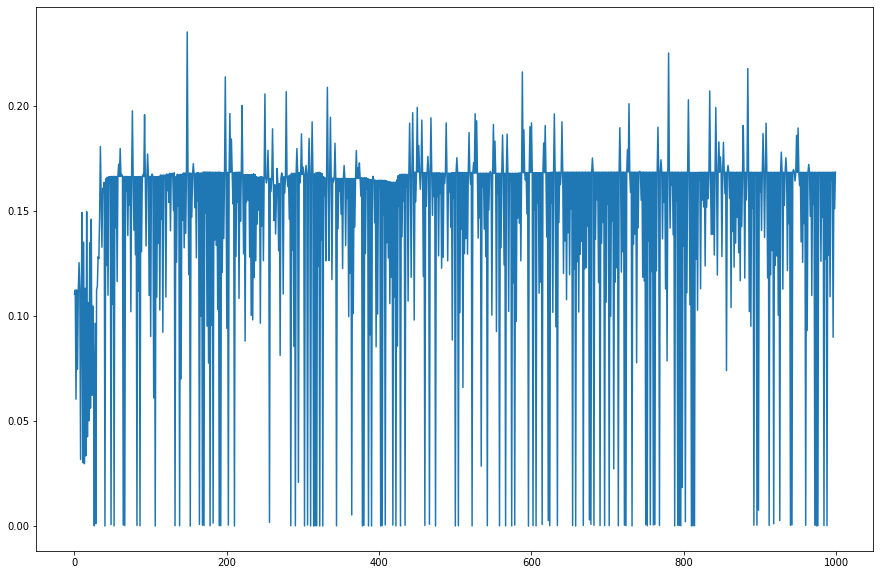

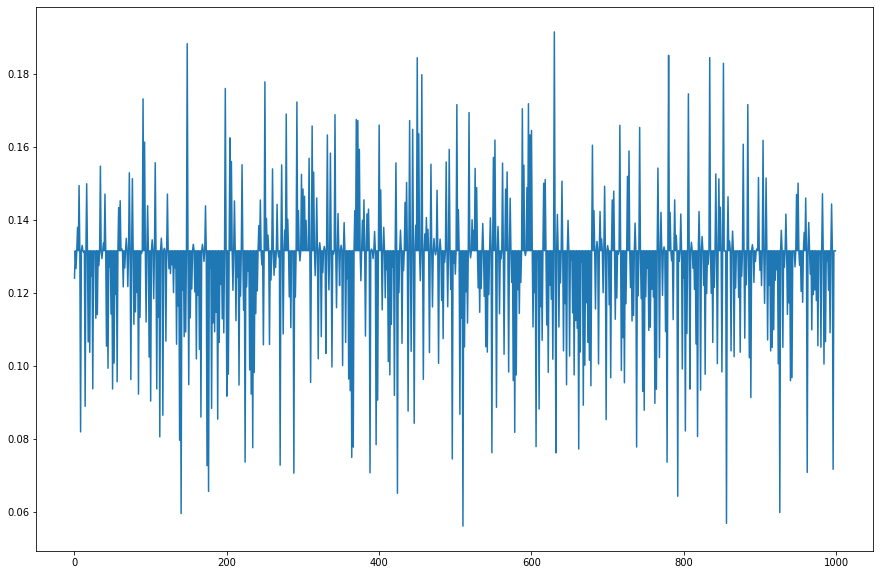

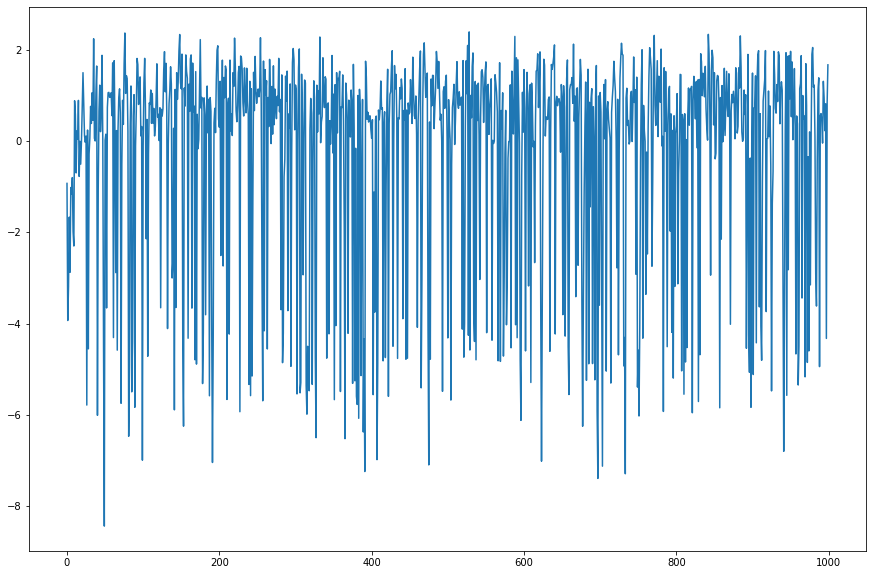

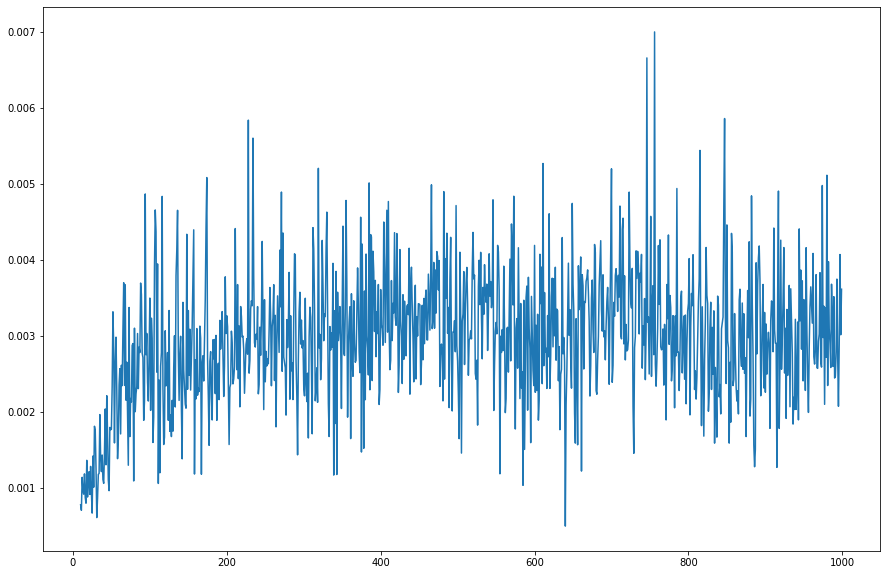

In [ ]:
def preprocess_state(state):
    return np.expand_dims(state, 0)

def build_summaries():
    with tf.compat.v1.variable_scope('total_reward'):
      var = tf.Variable(0.)
      tf.summary.scalar('reward', var)
      tf.summary.histogram('histogram', var)
    return tf.summary.merge_all(scope='total_reward'), var


def restore_model(sess,saver):
    saver.restore(sess, str(restore_path)+'/model_vars.ckpt')


def save_model(sess,saver,wsee,fpa):
    saver.save(sess, str(path2)+'/model_vars_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

def train(sess, env, params, actor, critic, noise, state_dim, action_dim,action_min,action_max, saver):
    global ep_rewards, ep_wsee, equal_wsee, test_ep_rewards, test_ep_wsee, df_wsee, df_eqwsee, df_loss, df_reward, result, EPSILON, MIN_EPSILON, EPSILON_DECAY
    EPSILON = 0.6
    MIN_EPSILON = 0.0001
    EPSILON_DECAY = np.power(MIN_EPSILON,(1/(EPISODES)))
    result = [None, None]
    ep_rewards = [] 
    ep_wsee = []
    equal_wsee =[]
    test_ep_rewards = []
    test_ep_wsee = []
    df_wsee = pd.DataFrame(columns=['wsee'])
    df_eqwsee = pd.DataFrame(columns=['eqwsee'])
    df_reward = pd.DataFrame(columns=['reward'])
    df_loss = pd.DataFrame(columns=['loss'])
    sess.run(tf.compat.v1.initialize_all_variables())

    sess.run([actor.update_target_policy_params, critic.update_target_q_params])

    replay_buffer = ReplayBuffer(random_seed=int(params['random_seed']))

    total_steps = 0
    total_episodes = 0

    if params['restore']:
        restore_model(sess, saver)
        actor.restore_model()
        critic.restore_model()
        print('Model restored!')
        total_steps, total_episodes = sess.run([total_steps_var, total_episodes_var])

    if params['use_adaptive_parameter_noise']:
      agent = actor.perturbed_predict
    else:
      agent = actor.predict

    max_exploration_steps = params['max_exploration_steps']
    p = 1
    drop_prob = params['drop_prob']
    indicator = False
    counter = 0
    prev_wsee = 0
    for episode in tqdm(range(params['max_episodes']),ascii=True, unit="episode"):

      
      
      _distance = []
      _std_dev = []
      
      episode_reward = 0

      observation, agent_no = env.reset(episode)

      state = preprocess_state(observation)

      total_reward = 0
      _evaluate = False

      for step in range(params['max_episode_len']):

        if total_steps < max_exploration_steps:

          
          state = np.reshape(state, [1, state_dim])
          # print(f'############################################ step: {step}, state: {state} ###############################################')
          actions = agent(state, drop_prob = drop_prob)
          if not params['use_adaptive_parameter_noise']:
            actions += noise(0, 0.2, action_dim)
            p -= 1/max_exploration_steps
          
        
        else:
          print('### Training Complete ###')
          raise KeyboardInterrupt

        # action = action[0]
        action =  np.clip(actions, action_min, action_max)/action_max
        # print(f'############################################ step: {step, action_max}, action: {action} ###############################################')
        next_state, reward, terminal = env.step(action, agent_no)

        episode_reward += reward


        replay_buffer.add(
            (state, action, reward, terminal, next_state)
        )
        
        # if actor.normalize_observations:
        #   actor.obs_rms.update(state)

        current_state, agent_no = env.agent_reset()
        state = preprocess_state(current_state)
        total_reward += reward
        total_steps += 1

        if total_steps % 100 == 0:
          _evaluate = True

        if terminal:
          if _evaluate:
            test_no = 100
            # if episode > 990 or counter == 10:
            #   test_no = 800
            curr_wsee, indicator = evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver, test_no, prev_wsee)
            prev_wsee = curr_wsee
            # if indicator:
            #   counter += 1
            # else:
            #   counter = 0
          break

      # if counter == 11:
      #   break
      for train_step in range(params['train_step']):
        if len(replay_buffer.buffer) >= params['minibatch_size']:
          
          minibatch, importance, indices = replay_buffer.sample()
          
          current_states = np.array([np.asarray(transition)[0] for transition in minibatch])
          current_states = np.reshape(current_states, [len(minibatch), state_dim])
          
          current_actions = np.array([np.asarray(transition)[1] for transition in minibatch])
          current_actions = np.reshape(current_actions, [len(minibatch), action_dim])
          # current_actions = np.clip(current_actions, action_min, action_max)/action_max

          current_qs_list = critic.predict(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob)
          # current_qs_list = critic.predict(current_states, np.asarray(env.pu*current_actions), drop_prob)
          
          new_states = np.array([np.asarray(transition)[4] for transition in minibatch])
          new_states = np.reshape(new_states, [len(minibatch), state_dim])

          future_actions = actor.target_predict(new_states, drop_prob)
          future_actions = np.clip(future_actions, action_min, action_max)/action_max

          future_qs_list = critic.target_predict(new_states, np.asarray(-np.log10(env.pu*future_actions)), drop_prob)
          # future_qs_list = critic.target_predict(new_states, np.asarray(env.pu*future_actions), drop_prob)
          
          y = []
          errors = []
          for index, (current_state, action, reward, terminal, next_state) in enumerate(minibatch):
              if not terminal:
                future_q = future_qs_list[index]
                new_q = reward + critic.gamma*future_q
                new_action = future_actions[index]
              else:
                new_q = reward
                new_action = action
              current_q = current_qs_list[index]
              errors.append(new_q-current_q)
              y.append(new_q)
          
          y = np.reshape(y, [1, len(minibatch)])
          importance = np.reshape(importance, [1, len(minibatch)])
          result = critic.train(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob, y, importance)
          
          actor.train(current_states, drop_prob,
                      critic.compute_grads(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob)[0])
          
          sess.run(actor.update_target_policy_params)
          sess.run(critic.update_target_q_params)

          # errors = y - critic.predict(state_batch,
          #                             actor.predict(state_batch, drop_prob),
          #                             drop_prob)

          if params['use_adaptive_parameter_noise'] and train_step % 20 == 0:
              distance, std_dev = actor.add_param_noise(current_states)
              _distance.append(distance)
              _std_dev.append(std_dev)

          replay_buffer.set_priorities(indices, errors)
      total_episodes += 1
      # distance, std_dev = actor.add_param_noise(current_states)
      # _distance.append(distance)
      # _std_dev.append(std_dev)

      sess.run([total_steps_var.assign(total_steps), total_episodes_var.assign(episode)])
      loss = result[0]
      ep_rewards.append(episode_reward)
      equal_wsee.append(env.cal_equal_p_WSEE(0))
      ep_wsee.append(env.cal_total_WSEE(0))

      if params['use_adaptive_parameter_noise']:
            print(
                f'Loss: {loss}|| Global step: {total_steps} || Episode: {total_episodes} || Reward: {total_reward:.2f} || Distance: {np.array(_distance).mean():.4f} ||')
      else:
          print(
              f'|| Global step: {total_steps} || Episode: {total_episodes} || Reward: {total_reward:.2f} ||')
          

      if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_wsee = sum(ep_wsee[-AGGREGATE_STATS_EVERY:])/len(ep_wsee[-AGGREGATE_STATS_EVERY:])
        average_equal_wsee = sum(equal_wsee[-AGGREGATE_STATS_EVERY:])/len(equal_wsee[-AGGREGATE_STATS_EVERY:])
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        #agent.tensorboard.update_stats(avg_equal_p_wsee = average_equal_wsee, reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon, avg_wsee = average_wsee) 
        # cma_reward = (cma_reward + (average_reward-cma_reward)/(episode+1))
        # print(cma_reward)
        df_wsee = df_wsee.append({'wsee': average_wsee}, ignore_index=True)
        df_eqwsee = df_eqwsee.append({'eqwsee': average_equal_wsee}, ignore_index=True)
        df_reward = df_reward.append({'reward': average_reward}, ignore_index=True)
        df_loss = df_loss.append({'loss': loss}, ignore_index=True)
        print(f'wsee: {average_wsee}, eqwsee: {average_equal_wsee}, reward: {average_reward}')
        # agent.tensorboard.update_stats2(rval, train, episode, "loss")
        # agent.tensorboard.update_stats2(average_wsee, train, episode, "wsee")
        # agent.tensorboard.update_stats2(average_equal_wsee, train, episode, "eq_wsee")
        # agent.tensorboard.update_stats2(average_reward, train, episode, "reward")
        # Save model, but only when min reward is greater or equal a set value
        # if min_reward >= MIN_REWARD and episode%5==0:
        # #     #agent.model.save(f'./models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.h5')
        #   actor.actions.save(filepath=path2/f'{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}_actor_2.h5')
        #   critic.q_value.save(filepath=path2/f'{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}_critic_2.h5')
        if EPSILON > MIN_EPSILON:
          EPSILON *= EPSILON_DECAY
          EPSILON = max(MIN_EPSILON, EPSILON)
      

global eval_wsee, eval_fpa, eval_reward

eval_reward = []
eval_wsee = []
eval_fpa = []

def evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver, test_no, prev_wsee):

    if params['restore'] and not params['train']:
        sess.run(tf.compat.v1.global_variables_initializer())
        restore_model(sess, saver)
        actor.restore_model()
        critic.restore_model()
        print('Model restored!')

    total_steps = sess.run(total_steps_var)
    err = 0.01
    _reward = []
    _test_wsee = []
    _test_fpa_wsee = []
    flag = 0
    start = 1100
    end = start+test_no
    for episode in range(start,end):
        env.reset_test(episode)
        total_reward = 0
        
        for a in range(env.K):
            agent_no = a
            observation = env.initialize_state_test(a)
            state = preprocess_state(observation)
            state = np.reshape(state, [1, state_dim])
            actions = actor.predict(state, drop_prob=0.)
            actions = np.clip(actions, action_min, action_max)/action_max
            action = actions[0]

            _, reward, _ = env.step(action, a)
            
            total_reward += reward
        if total_reward >= 0:
          flag += 1
        _reward.append(total_reward)
        _test_wsee.append(env.cal_total_WSEE(0))
        _test_fpa_wsee.append(env.cal_equal_p_WSEE(0))
        if episode % 20 ==0:
          print(f'|| Test Run No: {episode} || WSEE: {env.cal_total_WSEE(0)} || eq_WSEE: {env.cal_equal_p_WSEE(0)} || Reward: {total_reward:.2f} ||')
    wsee = np.sum(_test_wsee)/len(_test_wsee)
    fpa = np.sum(_test_fpa_wsee)/len(_test_fpa_wsee)
    eval_wsee.append(wsee)
    eval_fpa.append(fpa)
    eval_reward.append(np.sum(_reward)/len(_reward))
    print(f'wsee:{wsee}, fpa_wsee: {fpa}')
    if flag > 0.95*test_no:
        # save_model(sess,saver,wsee, fpa)
        # actor.save_model(wsee, fpa)
        # critic.save_model(wsee, fpa)
        print('Model could have been saved!')
    # total_reward = np.max(np.array(_reward))
    # summary = sess.run(merge_op, feed_dict={total_reward_var: total_reward})
    # writer.add_summary(summary, total_steps)
        if abs(prev_wsee - wsee) < err: 
          return wsee, True
        else:
          return wsee, False
    else:
      return wsee, False


def main(args, power, nrx):
    params = vars(args)
    tf.compat.v1.set_random_seed(int(params['random_seed']))
    np.random.seed(int(params['random_seed']))
    if params['train']:
      gainspath = 'testNrx/channel_K10_AP32_2k_fresh.h5'
    if params['restore']:
      gainspath = '25thJulyTestGains/channel_K10_AP32_2k.h5'

    with tf.compat.v1.Session() as sess:
        try:
            env = wirelessEnv(power, nrx, gainspath, int(params['random_seed'])) 
            # env = gym.make(args['env'])
            state_dim = env.s_dim
            action_dim = env.a_dim
            action_min = 0.000001
            action_max = power

            # assert (env.action_space.high == -env.action_space.low).all()
            # action_bound = env.action_space.high[0]

            global total_steps_var, total_episodes_var
            total_episodes_var = tf.Variable(0)
            total_steps_var = tf.Variable(0)

            # if args['use_gym_monitor']:
            #     if not args['render_env']:
            #         env = wrappers.Monitor(
            #             env, args['monitor_dir'], video_callable=False, force=True)
            #     else:
            #         env = wrappers.Monitor(env, args['monitor_dir'], force=True)

            actor = Actor(sess, state_dim, action_dim, 
                          use_param_noise=params['use_adaptive_parameter_noise'], 
                          tau=params['tau'], gamma=params['gamma'], 
                          delta=params['delta'], normalize_observations=params['normalize_obs'])
            
            critic = Critic(sess, state_dim, action_dim, tau=params['tau'], gamma=params['gamma'],
                            learning_rate=params['critic_lr'], 
                            normalize_observations=params['normalize_obs'])

            ## Noise
            noise = np.random.normal

            saver = tf.compat.v1.train.Saver()
            # writer = tf.summary.FileWriter(args['summary_dir'] + '/' + args['env'] + '/' + str(datetime.now()))

            if params['train']:
                train(sess,env,params,actor,critic,noise,state_dim,action_dim,action_min,action_max, saver)
            # evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver)
            # save_model(sess,saver)
            # actor.save_model()
            # critic.save_model()
            # print('Model saved!')

        except KeyboardInterrupt:
            if params['save']:
              # save_model(sess,saver)
              # actor.save_model()
              # critic.save_model()
              print('Model saved!')


    test_wsee = np.sum(test_ep_wsee)/len(test_ep_wsee)
    wsee = np.sum(ep_wsee)/len(ep_wsee)
    print(f'wsee:{wsee}, test_wsee: {test_wsee}, agent.env.pi: {env.pi[1]}')

    plt.figure(figsize=(15,10))
    # df_wsee.reset_index().plot(kind='line',x='index', y='wsee')
    plt.plot(df_wsee['wsee'])
    # plt.show()
    plt.savefig(dest/r'wsee.jpg', dpi=300)
    # df_eqwsee.reset_index().plot(kind='line',x='index', y='eqwsee')
    plt.figure(figsize=(15,10))
    plt.plot(df_eqwsee['eqwsee'])
    # nrxmean = df_eqwsee['eqwsee'].mean(axis=0)
    # print(nrxmean, nrx)
    # nrx_val.append(nrxmean*env.B)
    # plt.show()
    plt.savefig(dest/r'eqwsee.jpg', dpi=300)
    # df_reward.reset_index().plot(kind='line',x='index', y='reward')
    plt.figure(figsize=(15,10))
    plt.plot(df_reward['reward'])
    # plt.show()
    plt.savefig(dest/r'reward.jpg', dpi=300)
    # df_loss.reset_index().plot(kind='line',x='index', y='loss')
    plt.figure(figsize=(15,10))
    plt.plot(df_loss['loss'])
    # plt.show()
    plt.savefig(dest/r'loss.jpg', dpi=300)

    df_wsee.to_csv(dest/r'wsee29thJan.csv')
    df_eqwsee.to_csv(dest/r'eqwsee29thJan.csv')
    df_reward.to_csv(dest/r'reward29thJan.csv')
    df_loss.to_csv(dest/r'loss29thJan.csv')


def test(args, power, nrx):
    # tf.set_random_seed(int(args['random_seed']))
    # np.random.seed(int(args['random_seed']))
    params = vars(args)
    gainspath2 = '25thJulyTestGains/channel_K10_AP32_2k.h5'
    with tf.compat.v1.Session() as sess:
    
        env = wirelessEnv(power, nrx, gainspath2) 
        # env = gym.make(args['env'])
        # env.seed(int(args['random_seed']))
        state_dim = env.s_dim
        action_dim = env.a_dim
        action_min = 0.000001
        action_max = power

        global total_steps_var, total_episodes_var
        total_episodes_var = tf.Variable(0)
        total_steps_var = tf.Variable(0)

        saver_actor = tf.compat.v1.train.import_meta_graph(base_dir + 'Thu Jul 23 01:53:05 2020/models/actor/model_actor.ckpt.meta')
        saver_actor.restore(sess, tf.train.latest_checkpoint(base_dir + 'Thu Jul 23 01:53:05 2020/models/actor'))
        sess.run(tf.compat.v1.global_variables_initializer())
        graph = tf.compat.v1.get_default_graph()
        state_ph = graph.get_tensor_by_name("state_ph:0")
        drop_prob = graph.get_tensor_by_name("drop_prob:0")
        predict_operation = graph.get_tensor_by_name("actions:0")
        
        total_steps = sess.run(total_steps_var)
        _reward = []
        _test_wsee = []
        _test_fpa_wsee = []

        for episode in range(2000):
            env.reset_test(episode)
            total_reward = 0
            
            for a in range(env.K):
                agent_no = a
                observation = env.initialize_state_test(a)
                state = preprocess_state(observation)
                state = np.reshape(state, [1, state_dim])
                actions = sess.run(predict_operation, feed_dict = {state_ph: state, drop_prob: 0.0})
                actions = np.clip(actions, action_min, action_max)/action_max
                action = actions[0]

                _, reward, _ = env.step(action, a)
                
                total_reward += reward

            _reward.append(total_reward)
            _test_wsee.append(env.cal_total_WSEE(0))
            _test_fpa_wsee.append(env.cal_equal_p_WSEE(0))
            print(f'|| WSEE: {env.cal_total_WSEE(0)} || eq_WSEE: {env.cal_equal_p_WSEE(0)} || agent.env.pi: {env.pi[1]} || Reward: {total_reward:.2f} ||')



    wsee = np.sum(_test_wsee)/len(_test_wsee)
    fpa = np.sum(_test_fpa_wsee)/len(_test_fpa_wsee)
    print(f'wsee:{wsee}, fpa_wsee: {test_wsee}')



parser = argparse.ArgumentParser(description='provide arguments for DDPG agent')

# agent parameters
parser.add_argument('--actor-lr', help='actor network learning rate', default=0.005)
parser.add_argument('--critic-lr', help='critic network learning rate', default=0.05)
parser.add_argument('--gamma', help='discount factor for critic updates', default=0.4)
parser.add_argument('--tau', help='soft target update parameter', default=0.01)
parser.add_argument('--use-adaptive-parameter-noise', help='', default=True)
parser.add_argument('--delta', help='desired action deviation', default=.2)
parser.add_argument('--l2_reg', help='Q loss regularization strength', default=.0)
parser.add_argument('--drop-prob', help='drop out probability', default=.4)
parser.add_argument('--buffer-size', help='max size of the replay buffer', default=10000)
parser.add_argument('--minibatch-size', help='size of minibatch for minibatch-SGD', default=512)
parser.add_argument('--normalize-obs', help='normalizes observations', default=True)

# run parameters
parser.add_argument('--train', help='train the model', default=True)
parser.add_argument('--train_step', help='number of training steps', default=50)
parser.add_argument('--max-exploration-steps', help='', default=1e6)
# parser.add_argument('--env', help='choose the gym env', default='HalfCheetah-v2')
parser.add_argument('--save', help='save trained model', default=True)
parser.add_argument('--restore', help='restore prev trained model', default=False)
parser.add_argument('--random-seed', help='random seed for repeatability', default=1337)
parser.add_argument('--max-episodes', help='max num of episodes to do while training', default=1000)
parser.add_argument('--max-episode-len', help='max length of 1 episode', default=20000)
# parser.add_argument('--render-env', help='render the gym env', action='store_true')
# parser.add_argument('--use-gym-monitor', help='record gym results', action='store_true')
# parser.add_argument('--monitor-dir', help='directory for storing gym results', default='./results/gym_ddpg')
parser.add_argument('--summary-dir', help='directory for storing tensorboard info', default='./results/tf_ddpg')

parser.set_defaults()
# parser.set_defaults(use_gym_monitor=False)

args, _ = parser.parse_known_args()

# with open('./random_seeds_used', 'a+') as f:
#     f.write(f"Time: {str(datetime.now())}, random seed: {args['random_seed']}\n")


pp.pprint(args)
# merge_op, total_reward_var = build_summaries()
power = 30
nrx = 2
main(args, np.power(10,power/10 - 3), nrx)


In [ ]:
episode = [int(i*100) for i in range(1,len(eval_wsee)+1)]
# episode = episode*500

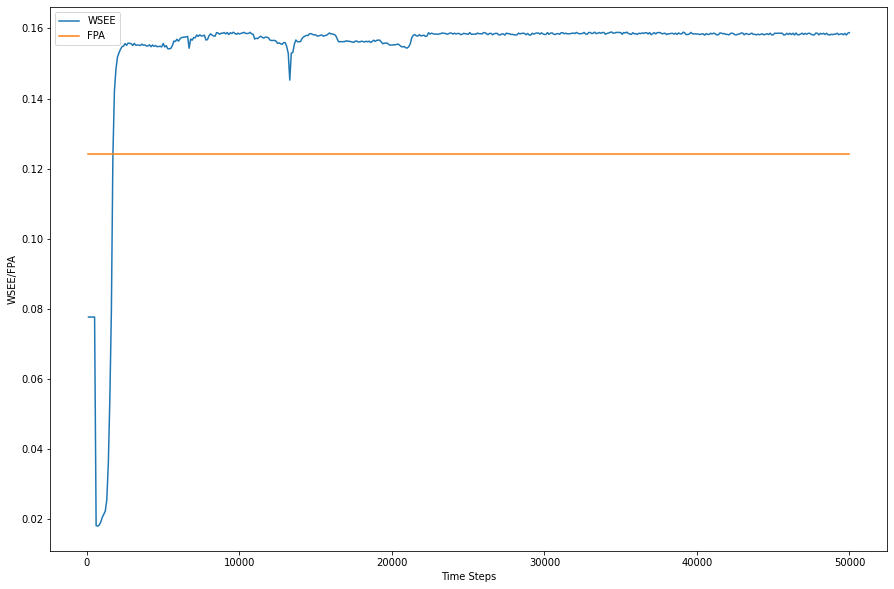

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(episode, eval_wsee, label='WSEE')
plt.plot(episode, eval_fpa, label='FPA')
plt.xlabel('Time Steps')
plt.ylabel('WSEE/FPA')
plt.legend()
plt.savefig(dest/r'training.jpg', dpi=300)

Text(0, 0.5, 'Reward')

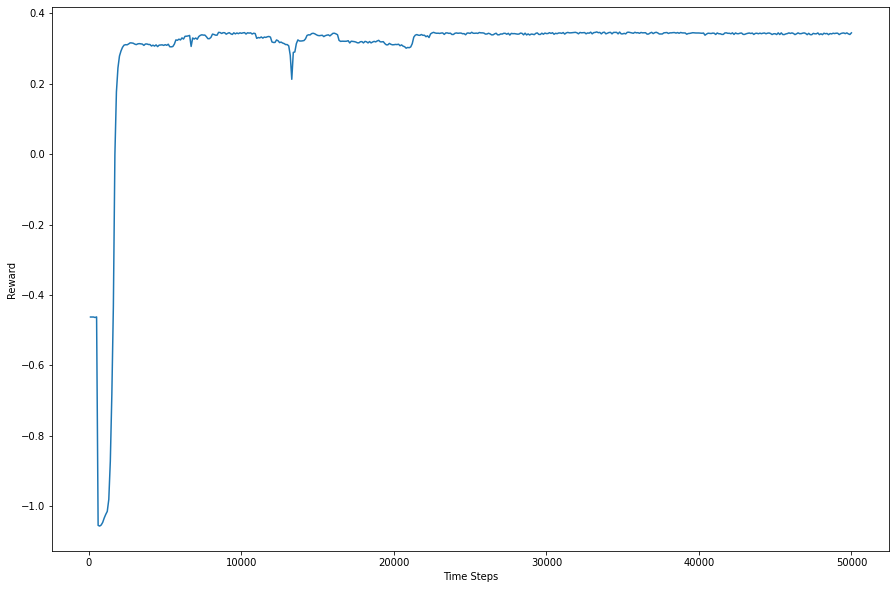

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(episode, eval_reward)
plt.xlabel('Time Steps')
plt.ylabel('Reward')
